In [1]:
import numpy as np
import sys
import random
import copy
import string
import time
import datetime
from tqdm import tqdm
from scipy.stats import pareto
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rng = np.random.default_rng(int(time.time())) #(1234)
from pdb import set_trace as bp

# 1. Helper Functions

In [2]:
##########################################
#### Functions for plotting Functions  ###
##########################################
exec(open('../utils.py').read())

In [3]:
##########################################
####### Fetch: Helper Functions  #########
##########################################
exec(open('../neurips-2022-utils.py').read())

In [4]:
DEBUG = False
def print_debug(s):
    if DEBUG: print(s)

In [5]:
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('../neurips-2022-algorithms.py').read())

In [6]:
SAME_G = True 
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

def F(sol, obs_util, m):
    v = 0

    for j in range(m):
        tmp = np.sum(sorted([obs_util[i][j] for i in sol], reverse=True))
        if j != 1:
            v += func(tmp) * weight_F[j]
        else:
            if not SAME_G:
                v += func2(tmp) * weight_F[j]
            else:
                v += func(tmp) * weight_F[j]
    return v

def marg_F(sol, item, obs_util, m):
    sol2 = copy.deepcopy(sol)
    sol2.append(item)
    return F(sol2, obs_util, m) - F(sol, obs_util, m)

def marg_F_mult(sol, items, obs_util, m, pr=False):
    v = np.array([0 for j in range(m)])

    for j in range(m):
        tmp = [obs_util[i][j] for i in sol]
        v[j] += np.sum(tmp)

    cur_util = 0
    for j in range(m):
        if j != 1:
            cur_util += func(v[j]) * weight_F[j]
        else:
            if not SAME_G:
                cur_util += func2(v[j]) * weight_F[j]
            else:
                cur_util += func(v[j]) * weight_F[j]

    utils = []
    for i in items:
        if i in sol:
            utils.append(0)
        else:
            assert(obs_util[i][j] >= 0)
            new_util = 0
            for j in range(m):
                if j != 1:
                    new_util += func(v[j] + obs_util[i][j]) * weight_F[j]
                else:
                    if not SAME_G:
                        new_util += func2(v[j] + obs_util[i][j]) * weight_F[j]
                    else:
                        new_util += func(v[j] + obs_util[i][j]) * weight_F[j]
            assert(new_util >= cur_util)
            utils.append(new_util - cur_util)
    return utils


# 2. Parse Data

In [7]:
# Identify major tags in the data
##########################################

# MAIN DATA STRUCTURES
# unique genres: list [DONE]
# movie ids: list [DONE]
# user ids: list 

# user x rating: matrix 
# movie x all relevance scores: matrix [DONE]
# movie id x name: list [DONE]
# movie id x genres: matrix [DONE]


# DERIVED DATA STRUCTURES
# movie x average rating
# movie x relevant genres
# movie x lead actor

threshold_relevance = 0.5 # threshold above which movie is said to be relevant to a category

# compute the average number of categories a movie is relevant for
# compute the average rating of a movie


# Fraction of movies led by non-male actors??
# ...

In [8]:
import csv

genres = set()
movie_ids = []
movie_id_to_index = {}
user_ids = []
movie_names = {}

with open('ml-20m/movies.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in csv_reader:
        if i == 0: 
            i += 1
            continue 
            
        movie_ids.append(int(row[0]))
        movie_id_to_index[int(row[0])] = i-1
        movie_names[i-1] = row[1]
        
        tmp_genres = row[2].split('|')
        for g in tmp_genres:
            genres.add(g)
            
        i += 1

genres = sorted(list(genres))

movie_genres = np.zeros((len(movie_ids), len(genres)))

with open('ml-20m/movies.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in csv_reader:
        if i == 0: 
            i += 1
            continue 
         
        tmp_genres = row[2].split('|')
        for g1 in tmp_genres:
            for j, g2 in enumerate(genres):
                if g1 == g2:
                    movie_genres[i-1][j] = 1
                    
        i += 1

In [9]:
print(f'There are {len(movie_ids)} movies')
print(f'There are {len(genres)} unique genres')
print(f'On average there are {np.sum(movie_genres) / len(movie_ids)} genres per movie')

print('')

for j in range(10):
    print(f'{np.round(np.mean(np.sum(movie_genres, axis=1)==j)*100, 2)}%\tof movies have {j} genre(s)')
    
print('')

print(f'Maximum number of genres of a movie are {np.max(np.sum(movie_genres, axis=1))}')

There are 27278 movies
There are 20 unique genres
On average there are 1.9945010631277953 genres per movie

0.0%	of movies have 0 genre(s)
39.7%	of movies have 1 genre(s)
32.29%	of movies have 2 genre(s)
19.54%	of movies have 3 genre(s)
6.32%	of movies have 4 genre(s)
1.75%	of movies have 5 genre(s)
0.3%	of movies have 6 genre(s)
0.07%	of movies have 7 genre(s)
0.02%	of movies have 8 genre(s)
0.0%	of movies have 9 genre(s)

Maximum number of genres of a movie are 10.0


In [10]:
for i in range(len(genres)):
    genres[i] = genres[i].lower()

## 2.1. Fetch Relevance Scores

In [11]:
tags = []

with open('ml-20m/genome-tags.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in tqdm(csv_reader):
        if i == 0: 
            i += 1
            continue 
            
        tags.append(row[1])
            
        i += 1


rev_tags = {}
for i, t in enumerate(tags):
    rev_tags[t] = i
    
cnt = 0
for g in genres:
    if g not in tags:
        cnt += 1
print(f'{cnt} genre(s) are absent from tags')

movie_tag_rel_scores = {}
movie_ind_with_scores = set()

with open('ml-20m/genome-scores.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in tqdm(csv_reader):
        if i == 0: 
            i += 1
            continue
        
        mov_id = movie_id_to_index[int(row[0])]
        tag_id = int(row[1])-1
        movie_ind_with_scores.add(mov_id)
        score = float(row[2])
        
        if tags[tag_id] not in genres: continue 
            
        if mov_id not in movie_tag_rel_scores:
            movie_tag_rel_scores[mov_id] = {}
        
        movie_tag_rel_scores[mov_id][tag_id] = score
            
        i += 1


1129it [00:00, 482462.48it/s]


3 genre(s) are absent from tags


11709769it [00:23, 505147.71it/s]


In [12]:
print(f'{np.round(len(movie_ind_with_scores)/len(movie_ids)*100, 2)}% of the movies have relevance scores')

38.06% of the movies have relevance scores


## 2.2. Fetch User Ratings

In [13]:
user_ratings = {}
movie_rating_cnt = {}
movie_rating_sum = {}

In [14]:
with open('ml-20m/ratings.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in tqdm(csv_reader):
        if i == 0: 
            i += 1
            continue 
            
        user_id = int(row[0]) 
        if int(row[1]) == 26018:
            print('hi')
        mov_ind = movie_id_to_index[int(row[1])]
        rating = float(row[2])
        # timestamp 
        
        #if mov_ind not in movie_ind_with_scores:
        #    continue 
        
        if user_id not in user_ratings:
            user_ratings[user_id] = []
        if mov_ind not in movie_rating_cnt:
            movie_rating_cnt[mov_ind] = 0
        if mov_ind not in movie_rating_sum:
            movie_rating_sum[mov_ind] = 0

        user_ratings[user_id].append({'movie_id': int(row[1]), 'movie_index': mov_ind, 'rating': rating})
        movie_rating_cnt[mov_ind] += 1
        movie_rating_sum[mov_ind] += rating
        
        i += 1

20000264it [01:05, 306947.59it/s]


## TODO(s)
- Aggregate tags relevant to each genre
- Match: noir (tag) and film-noir (genre)

## 3. Fetch name of lead actor

In [15]:
import os
import pickle
import requests
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [16]:
sys.version

'3.6.9 (default, Mar 15 2022, 13:55:28) \n[GCC 8.4.0]'

In [17]:
missing = 0
parsing_error = 0
parsing_errors = []
movie_cast = {}
cnt_exception = 0

if False:
    for i in tqdm(movie_ids):
        if not os.path.isfile('scraped_pages/'+str(i)+'.html'): 
            missing += 1
            continue

        try:
            f = open('scraped_pages/'+str(i)+'.html', "r")
            soup = BeautifulSoup(f.read(), "html.parser")
            results = soup.find(id = "main-container")

            data_elements = results.find_all("div", class_="heading-and-data")

            cast = data_elements[-2].find_all("span")

            movie_cast[i] = []

            for c in cast:
                movie_cast[i].append(c.find_all("a")[0].text)
        except:
            print(f'Error in parsing movie {i}')
            parsing_errors.append(i)

            cnt_exception += 1
            
    
    filehandler = open(f"movie_cast"+file_str()+rand_string(5)+".obj","wb")
    pickle.dump(movie_cast, filehandler)
    filehandler.close()


In [18]:
if False:
    print()
    # missing = 0
    # parsing_error = 0
    # parsing_errors = []
    # movie_cast = {}
    # cnt_exception = 0


    # def select_job(ITER, seed, movie_ids):
    #     rel_ids = []
    #     for i in tqdm(movie_ids):
    #         if i % CORES == ITER: 
    #             rel_ids.append(i)

    #     missing_int = 0
    #     parsing_error_int = 0
    #     parsing_errors_int = []
    #     movie_cast_int = {}
    #     cnt_exception_int = 0

    #     for i in tqdm(rel_ids):
    #         if not os.path.isfile('scraped_pages/'+str(i)+'.html'): 
    #             missing += 1
    #             continue

    #         try:
    #             f = open('scraped_pages/'+str(i)+'.html', "r")
    #             soup = BeautifulSoup(f.read(), "html.parser")
    #             results = soup.find(id = "main-container")

    #             data_elements = results.find_all("div", class_="heading-and-data")

    #             cast = data_elements[-2].find_all("span")

    #             movie_cast_int[i] = []

    #             for c in cast:
    #                 movie_cast_int[i].append(c.find_all("a")[0].text)
    #         except:
    #             print(f'Error in parsing movie {i}')
    #             parsing_errors_int.append(i)

    #             cnt_exception_int += 1

    #             if cnt_exception_int >= 10:
    #                 break

    #     return movie_cast_int

    # CORES = 5
    # PROC = CORES
    # ss = rng.bit_generator._seed_seq ## seed sequence (source: https://albertcthomas.github.io/good-practices-random-number-generators/)
    # child_states = ss.spawn(PROC) ## child sequences 
    # child_args = []

    # parsed_dict = Parallel(n_jobs=PROC, prefer="threads")(
    #                             delayed(select_job)(i, child_states[i], movie_ids) 
    #                         for i in range(PROC))
    print()

In [19]:
filehandler = open(f"movie_castH00M17S52_05-13-22gdipj.obj","rb")
movie_cast = pickle.load(filehandler)
filehandler.close()

In [20]:
movie_cast_ind = {}

for k in movie_cast.keys():
    movie_cast_ind[movie_id_to_index[k]] = copy.deepcopy(movie_cast[k])

In [21]:
movie_cast = movie_cast_ind

## 4. Predict (binary) genders of lead actors

In [22]:
from genderize import Genderize

ModuleNotFoundError: No module named 'genderize'

In [23]:
movie_ind_present = list(movie_cast.keys()) # [movie_ids[k] for k in movie_cast.keys()]

In [24]:
genres_matching_tags = copy.deepcopy(genres)
genres_matching_tags.remove('film-noir')
genres_matching_tags.remove('imax')
genres_matching_tags.remove('(no genres listed)')
genres_matching_tags = sorted(genres_matching_tags)

In [25]:
genderize = Genderize(
    user_agent='GenderizeDocs/0.0',
    api_key='626a4d36038fe8c3783633373a5fe327',
    timeout=5.0)

NameError: name 'Genderize' is not defined

In [26]:
to_delete = []
for ind in tqdm(movie_ind_present):
    cast = movie_cast[ind]
    if len(cast) == 0:
        to_delete.append(ind)

for m in to_delete:
    movie_ind_present.remove(m)

100%|██████████| 26429/26429 [00:00<00:00, 1457744.44it/s]


In [27]:
li = []
cnt = 0
j = 0
for ind in tqdm(movie_ind_present):
    if cnt % 100 == 0:
        li.append([])
        j += 1
        
    cast = movie_cast[ind]
    if len(cast) == 0:
        print('oops')
        continue 
    lead = cast[0]
    name = lead.split(' ')
    first_name = name[0]
    li[j-1].append((ind, first_name))
    cnt += 1


if False:
    li = []
    cnt = 0
    j = 0
    for i in tqdm(movie_ids_present):
        if cnt % 100 == 0:
            li.append([])
            j += 1

        cast = movie_cast[i]
        if len(cast) == 0:
            continue 
        lead = cast[0]
        name = lead.split(' ')
        first_name = name[0]
        li[j-1].append((i, first_name))
        cnt += 1

    predictions_all = []

    for jj in tqdm(range(j)):
        names = [ll[1] for ll in li[jj]]

        predictions = genderize.get(names)
        predictions_all.extend(predictions)
    
    filehandler = open(f"predictions_all"+file_str()+rand_string(5)+".obj","wb")
    pickle.dump(predictions_all, filehandler)
    filehandler.close()

100%|██████████| 26428/26428 [00:00<00:00, 423125.62it/s]


In [28]:
filehandler = open(f"predictions_allH00M17S50_05-13-22liism.obj","rb")
predictions_all = pickle.load(filehandler)
filehandler.close()

In [29]:
assert(len(predictions_all) == len(movie_ind_present))

In [30]:
for i in range(len(predictions_all)):
    # print()
    # print(movie_ind_present[i])
    
    if movie_cast[movie_ind_present[i]][0].split(' ')[0] != predictions_all[i]['name']:
        print(i)
        print(predictions_all[i])
        print(movie_cast[movie_ind_present[i]][0])
        assert(False)
    
    # print(movie_cast[movie_ind_present[i]])

In [48]:
grps = [[], []]
# threshold_prob = 0.5
threshold_prob = 0.1 # set this threshold to 0.5 to compute stats for Table 3 in the appendix
threshold_count = 100
fail_cnt = 0

for i, ind in tqdm(enumerate(movie_ind_present)):
    prediction = predictions_all[i]
    
    if ind not in movie_ind_with_scores:
        continue 

    pred_female = -1
    if prediction['gender'] == 'female':
        pred_female = prediction['probability']
    elif prediction['gender'] == 'male':
        pred_female = 1-prediction['probability']
    else:
        fail_cnt += 1
        print(prediction['gender'])
        continue 

    if pred_female >= 1 - threshold_prob:
        grps[1].append(ind)
    elif pred_female <= threshold_prob:
        grps[0].append(ind)
    else:
        assert(False)
        continue 

print(f'Genderize predicts the gender of the lead actor, with confidence',
  f'{1-threshold_prob} or higher for',
  f'{np.round((len(grps[0])+len(grps[1]))/len(movie_ind_with_scores), 2)} fraction of the movies (with scores)')

26428it [00:00, 447545.06it/s]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Genderize predicts the gender of the lead actor, with confidence 0.5 or higher for 0.96 fraction of the movies (with scores)


In [47]:
len(movie_ind_with_scores)-7382-2572-fail_cnt

256

In [51]:
print('number of male-led movies, female-led movies, and fraction of movies led by females')
len(grps[0]), len(grps[1]), len(grps[1])/(len(grps[1])+len(grps[0]))

number of male-led movies, female-led movies, and fraction of movies led by females


(7382, 2572, 0.25838858750251154)

In [52]:
grp_avgs = [np.zeros(len(genres_matching_tags)), np.zeros(len(genres_matching_tags))]

fg=1
cnt=0
missing = {}
for l in [0, 1]:
    for ind in grps[l]:
        for i, g in enumerate(genres_matching_tags):
#             try:
            if ind not in movie_tag_rel_scores:
                missing[ind]=0
                print(ind)
                assert(False)
            else:
                grp_avgs[l][i] += movie_tag_rel_scores[ind][rev_tags[g]]
#             except:
#                 print(rev_tags[g], g, i, ind, movie_ids[ind])
#                 cnt+=1
#                 fg=0
        if fg == 0:
            cnt += 1
#             if not fg: break
#         if not fg: break
#     if not fg: break

    grp_avgs[l] /= len(grps[l])
print(cnt/(len(grps[0])+len(grps[1])))
print(len(missing)/(len(grps[0])+len(grps[1])))

0.0
0.0


In [53]:
print('AVERAGE RELEVANCE SCORES OF FEMALE-LED AND MALE-LED MOVIES IN DIFFERENT GENRES')
print('')
print(f"Genre{' '*(10-len('Genre'))}\tMale-led\tFemale-led\tRatio (female-led/male-led)")
print('-'*74)
for i, g in enumerate(genres_matching_tags):
    print(f"{g}{' '*(10-len(g))} \t{np.round(grp_avgs[0][i], 4)}\t\t{np.round(grp_avgs[1][i], 4)}\t\t{np.round(grp_avgs[1][i]/grp_avgs[0][i],4)}")
print('-'*74)
print(f"{'Total'}{' '*(10-len('Total'))} \t{np.round(np.sum(grp_avgs[0]), 4)}\t\t{np.round(np.sum(grp_avgs[1]), 4)}\t\t{np.round(np.sum(grp_avgs[1])/np.sum(grp_avgs[0]),4)}")    
print('='*74)

AVERAGE RELEVANCE SCORES OF FEMALE-LED AND MALE-LED MOVIES IN DIFFERENT GENRES

Genre     	Male-led	Female-led	Ratio (female-led/male-led)
--------------------------------------------------------------------------
action     	0.2923		0.1948		0.6665
adventure  	0.238		0.1786		0.7506
animation  	0.0848		0.0733		0.8644
children   	0.1432		0.1464		1.0227
comedy     	0.2678		0.2058		0.7684
crime      	0.1782		0.126		0.707
documentary 	0.0794		0.0714		0.8985
drama      	0.3629		0.3558		0.9804
fantasy    	0.1927		0.1805		0.9368
horror     	0.103		0.1389		1.3482
musical    	0.0832		0.0918		1.1041
mystery    	0.1077		0.1042		0.9675
romance    	0.2276		0.2813		1.2359
sci-fi     	0.1236		0.0904		0.732
thriller   	0.1938		0.1668		0.8604
war        	0.0916		0.0607		0.663
western    	0.0516		0.0324		0.6271
--------------------------------------------------------------------------
Total      	2.8213		2.4991		0.8858


In [54]:
movie_genres[0]

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [55]:
grp_avgs_conditioned_on_genre = [np.zeros(len(genres_matching_tags)), np.zeros(len(genres_matching_tags))]

mp_genre_to_ind = {}
for i, g in enumerate(genres):
    mp_genre_to_ind[g] = i

missing = {}
for l in [0, 1]:
    cnt = 0
    for ind in tqdm(grps[l]):
        for i, g in enumerate(genres_matching_tags):
            g_ind = mp_genre_to_ind[g]
            
            if movie_genres[ind][g_ind] == 0: continue 
                
            cnt += 1
            
            if ind not in movie_tag_rel_scores:
                missing[ind]=0
                print(ind)
                assert(False)
            else:
                grp_avgs_conditioned_on_genre[l][i] += movie_tag_rel_scores[ind][rev_tags[g]]


    grp_avgs_conditioned_on_genre[l] /= cnt 
    
print(len(missing)/(len(grp_avgs_conditioned_on_genre[0])+len(grp_avgs_conditioned_on_genre[1])))

100%|██████████| 2572/2572 [00:00<00:00, 42020.97it/s]

0.0


In [56]:
print('AVERAGE RELEVANCE SCORES OF FEMALE-LED AND MALE-LED MOVIES IN DIFFERENT GENRES (COMPUTED OVER MOVIES IN THIS GENRE)')
print('')
print(f"Genre{' '*(10-len('Genre'))}\tMale-led\tFemale-led\tRatio (female-led/male-led)")
print('-'*74)
for i, g in enumerate(genres_matching_tags):
    print(f"{g}{' '*(10-len(g))} \t{np.round(grp_avgs_conditioned_on_genre[0][i], 4)}\t\t{np.round(grp_avgs_conditioned_on_genre[1][i], 4)}\t\t{np.round(grp_avgs_conditioned_on_genre[1][i]/grp_avgs_conditioned_on_genre[0][i],4)}")
print('-'*74)
print(f"{'Total'}{' '*(10-len('Totalc'))} \t{np.round(np.sum(grp_avgs_conditioned_on_genre[0]), 4)}\t\t{np.round(np.sum(grp_avgs_conditioned_on_genre[1]), 4)}\t\t{np.round(np.sum(grp_avgs_conditioned_on_genre[1])/np.sum(grp_avgs_conditioned_on_genre[0]),4)}")    
print('='*74)

AVERAGE RELEVANCE SCORES OF FEMALE-LED AND MALE-LED MOVIES IN DIFFERENT GENRES (COMPUTED OVER MOVIES IN THIS GENRE)

Genre     	Male-led	Female-led	Ratio (female-led/male-led)
--------------------------------------------------------------------------
action     	0.061		0.0274		0.4486
adventure  	0.0331		0.0168		0.5079
animation  	0.0185		0.0161		0.8704
children   	0.0169		0.0171		1.0114
comedy     	0.0937		0.0719		0.7679
crime      	0.0312		0.0148		0.475
documentary 	0.0157		0.0126		0.8029
drama      	0.1042		0.1181		1.1333
fantasy    	0.0162		0.0154		0.945
horror     	0.0287		0.0492		1.7129
musical    	0.0107		0.0148		1.3819
mystery    	0.0126		0.0118		0.9346
romance    	0.0306		0.0653		2.1365
sci-fi     	0.0285		0.0179		0.6298
thriller   	0.0372		0.0334		0.8988
war        	0.0141		0.0063		0.4467
western    	0.0091		0.0027		0.3024
--------------------------------------------------------------------------
Total     	0.5619		0.5116		0.9105


In [36]:
grp_avg_ratings_conditioned_on_genre = [[[] for i in genres_matching_tags], [[] for i in genres_matching_tags]]

for l in [0, 1]:
    cnt = np.zeros(len(genres_matching_tags))
    for ind in tqdm(grps[l]):
        for i, g in enumerate(genres_matching_tags):
            
            g_ind = mp_genre_to_ind[g]
            
            if movie_genres[ind][g_ind] == 0: continue
            
            if ind not in movie_ind_with_scores:
                print(ind)
                assert(False)
        
            if ind not in movie_rating_sum: continue
            if ind not in movie_rating_cnt: continue
            cnt[i] += 1
            assert(movie_rating_sum[ind] / movie_rating_cnt[ind]<=5)
            if g == 'western':
                print(movie_ids[ind], movie_rating_sum[ind] / movie_rating_cnt[ind], cnt[i])
            grp_avg_ratings_conditioned_on_genre[l][i].append(movie_rating_sum[ind] / movie_rating_cnt[ind])
    
#     for i in range(len(genres_matching_tags)):
#         grp_avg_ratings_conditioned_on_genre[l][i] /= cnt[i]
    
# print(f'Ratio: {grp_avg_ratings_conditioned_on_genre[1]/grp_avg_ratings_conditioned_on_genre[0]}')
# print(f'Averages: {grp_avg_ratings_conditioned_on_genre[0], grp_avg_ratings_conditioned_on_genre[1]}')

  0%|          | 0/6612 [00:00<?, ?it/s]

163 3.445394874659591 1.0
210 2.8890041493775933 2.0
266 3.496258734772123 3.0
383 3.195323383084577 4.0
432 2.735470785552695 5.0
458 3.161290322580645 6.0
487 2.6195121951219513 7.0
553 3.6974995051791253 8.0
590 3.7284654361201595 9.0
599 4.004725897920605 10.0
714 3.9047475052918053 11.0
800 4.074902723735408 12.0
964 3.410557184750733 13.0
967 2.7884615384615383 14.0
1007 2.9375 15.0
1181 3.0396039603960396 16.0
1201 4.123240894039735 17.0
1254 4.161396702230844 18.0
1266 3.9883400466398133 19.0
1283 4.075288403157256 20.0
1304 4.0536379997428975 21.0
1378 3.286454478164323 22.0
1379 2.9722591362126245 23.0
1408 3.7207504630002415 24.0


 42%|████▏     | 2810/6612 [00:00<00:00, 28090.18it/s]

1887 2.6232142857142855 25.0
1928 3.080246913580247 26.0
2012 3.249264854998986 27.0
2016 2.5960187353629975 28.0
2055 2.731132075471698 29.0
2070 3.9541571753986333 30.0
2103 2.972093023255814 31.0
2142 2.9944289693593316 32.0
2328 2.774906600249066 33.0
2401 3.731103552532124 34.0
2441 3.1035353535353534 35.0
2701 2.292716071752129 36.0
2921 3.8309197651663407 37.0
2922 3.636952498457742 38.0
2951 3.9353664087391897 39.0
3025 2.8684210526315788 40.0
3037 3.980287627076618 41.0
3074 3.766851980542043 42.0
3093 3.812278211497516 43.0
3122 3.208904109589041 44.0
3133 3.6201716738197427 45.0
3267 3.6335311572700295 46.0
3311 3.6806167400881056 47.0
3365 3.992951127819549 48.0
3368 3.7507163323782233 49.0
3467 3.9725490196078432 50.0
3487 3.6232032854209444 51.0
3494 3.6357302118171684 52.0
3508 3.9344689993861266 53.0
3671 3.876319041734005 54.0
3681 3.9730487278999567 55.0
3727 3.628054298642534 56.0
3737 3.783505154639175 57.0
3806 3.088235294117647 58.0
3871 3.7736009044658 59.0
4031 

100%|██████████| 6612/6612 [00:00<00:00, 31920.85it/s]


103384 3.0306748466257667 175.0
111743 2.8705583756345177 176.0


  0%|          | 0/1990 [00:00<?, ?it/s]

303 3.0401727861771057 1.0
416 2.705467869222097 2.0
948 3.7430184194890077 3.0
1209 4.128545495802133 4.0
3644 3.1640625 5.0
3792 3.3353413654618476 6.0
3873 3.5886792452830187 7.0
4428 3.5982456140350876 8.0
5372 3.3372549019607844 9.0
5375 3.2934782608695654 

100%|██████████| 1990/1990 [00:00<00:00, 43725.46it/s]

10.0
6428 3.506006006006006 11.0
6785 3.5200708382526567 12.0
6950 3.194954128440367 13.0
7072 3.8491784037558685 14.0
7374 2.7526501766784452 15.0
8227 3.2701149425287355 16.0
8522 3.3780487804878048 17.0
63853 3.2448200654307526 18.0
85790 3.2419354838709675 19.0


In [37]:
np.set_printoptions(precision=2)
for i in range(len(genres_matching_tags)):
    print(f'Genre: {genres_matching_tags[i]}{" "*(10-len(genres_matching_tags[i]))}\t'+
          f'Ratio: {np.mean(grp_avg_ratings_conditioned_on_genre[1][i])/np.mean(grp_avg_ratings_conditioned_on_genre[0][i]):.2f}')
    print(f'\t{" "*(10)}\t'+
          f'Averages: {np.mean(grp_avg_ratings_conditioned_on_genre[0][i]):.2f} ({np.std(grp_avg_ratings_conditioned_on_genre[0][i]):.2f}),\t'+
          f'{np.mean(grp_avg_ratings_conditioned_on_genre[1][i]):.2f} ({np.std(grp_avg_ratings_conditioned_on_genre[1][i]):.2f})')

Genre: action    	Ratio: 0.98
	          	Averages: 3.11 (0.53),	3.04 (0.54)
Genre: adventure 	Ratio: 0.95
	          	Averages: 3.22 (0.51),	3.07 (0.60)
Genre: animation 	Ratio: 1.03
	          	Averages: 3.32 (0.45),	3.43 (0.49)
Genre: children  	Ratio: 1.05
	          	Averages: 3.03 (0.54),	3.18 (0.53)
Genre: comedy    	Ratio: 1.00
	          	Averages: 3.16 (0.53),	3.15 (0.48)
Genre: crime     	Ratio: 0.96
	          	Averages: 3.36 (0.45),	3.24 (0.50)
Genre: documentary	Ratio: 1.00
	          	Averages: 3.61 (0.41),	3.59 (0.34)
Genre: drama     	Ratio: 0.99
	          	Averages: 3.44 (0.40),	3.40 (0.40)
Genre: fantasy   	Ratio: 1.01
	          	Averages: 3.22 (0.52),	3.24 (0.48)
Genre: horror    	Ratio: 1.00
	          	Averages: 2.88 (0.57),	2.88 (0.53)
Genre: musical   	Ratio: 0.98
	          	Averages: 3.36 (0.43),	3.30 (0.46)
Genre: mystery   	Ratio: 0.94
	          	Averages: 3.41 (0.44),	3.21 (0.50)
Genre: romance   	Ratio: 0.98
	          	Averages: 3.37 (0.43),	3.31 (0.45

In [38]:
grp_avg_ratings = [0, 0]

for l in [0, 1]:
    for ind in grps[l]:
        # m_ind = movie_id_to_index[m]
        if ind not in movie_ind_with_scores:
            print(ind)
            assert(False)
        
        if ind not in movie_rating_sum: continue
        if ind not in movie_rating_cnt: continue
        grp_avg_ratings[l] += movie_rating_sum[ind] / movie_rating_cnt[ind]
    grp_avg_ratings[l] /= len(grps[l])
    
print(f'Ratio: {grp_avg_ratings[1]/grp_avg_ratings[0]}')
print(f'Averages: {grp_avg_ratings[0], grp_avg_ratings[1]}')

Ratio: 0.9936361460626514
Averages: (3.2620164077987055, 3.24125741183824)


In [39]:
num_ratings_per_user = []
cnt = 0

for u in tqdm(user_ratings.keys()):
    num_ratings_per_user.append(0)
    
    for r in user_ratings[u]:
        if r['movie_index'] in movie_ind_with_scores:
            num_ratings_per_user[-1] += 1 
        else:
            cnt += 1
            
print(cnt)

100%|██████████| 138493/138493 [00:03<00:00, 36941.33it/s]

199820


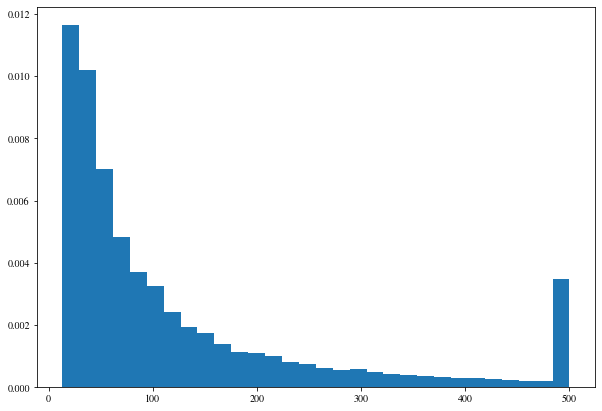

In [40]:
num_ratings_per_user = np.array(num_ratings_per_user)
_ = plt.hist(np.clip(num_ratings_per_user, 0, 500), density=True, bins=30)

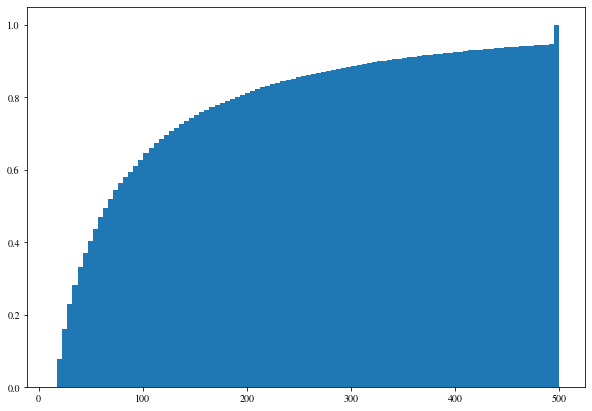

In [41]:
_ = plt.hist(np.clip(num_ratings_per_user, 0, 500), density=True, bins=100, cumulative=True)

In [42]:
user_ratings_for_movies_with_scores = {}

cnt=0
for u in tqdm(user_ratings):
    if u not in user_ratings_for_movies_with_scores:
        user_ratings_for_movies_with_scores[u] = []
        
    for r in user_ratings[u]:
        if r['movie_index'] in movie_ind_with_scores:
            user_ratings_for_movies_with_scores[u].append(r)
        else: cnt+=1
            
print(cnt)

100%|██████████| 138493/138493 [00:06<00:00, 22532.32it/s]

199820


In [43]:
threshold_on_user_rating_cnt = 200

selected_users = []

for u in tqdm(user_ratings_for_movies_with_scores.keys()):
    if len(user_ratings_for_movies_with_scores[u]) >= threshold_on_user_rating_cnt:
        selected_users.append(u)

100%|██████████| 138493/138493 [00:00<00:00, 1427213.85it/s]


In [44]:
selected_users_set = set(selected_users)

In [45]:
movie_rating_cnt_selected = {}
movie_rating_sum_selected = {}

with open('ml-20m/ratings.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    
    for row in tqdm(csv_reader):
        if i == 0: 
            i += 1
            continue 
            
        user_id = int(row[0])
        mov_ind = movie_id_to_index[int(row[1])]
        rating = float(row[2])
        # timestamp = int(row[3])
        
        if mov_ind not in movie_ind_with_scores:
            continue 
        
        if user_id not in selected_users_set: continue 
        
        if mov_ind not in movie_rating_cnt_selected:
            movie_rating_cnt_selected[mov_ind] = 0
        if mov_ind not in movie_rating_sum_selected:
            movie_rating_sum_selected[mov_ind] = 0

        movie_rating_cnt_selected[mov_ind] += 1
        movie_rating_sum_selected[mov_ind] += rating
        
        i += 1

20000264it [00:37, 536941.65it/s]


In [46]:
grp_avg_ratings_selected = [0, 0]

for l in [0, 1]:
    for ind in grps[l]:
        
        if ind not in movie_rating_sum_selected: continue
        if ind not in movie_rating_cnt_selected: continue
        grp_avg_ratings_selected[l] += movie_rating_sum_selected[ind] / movie_rating_cnt_selected[ind]
    grp_avg_ratings_selected[l] /= len(grps[l])
    
print(f'Ratio: {grp_avg_ratings_selected[1]/grp_avg_ratings_selected[0]}')
print(f'Averages: {grp_avg_ratings_selected[0], grp_avg_ratings_selected[1]}')

Ratio: 0.9909879273893368
Averages: (3.216265778126368, 3.187280557398702)


In [47]:
len(movie_genres[0]), len(genres_matching_tags)

(20, 17)

In [48]:
# del(movie_tag_rel_scores)
# del(user_ratings)

In [49]:
import gc

In [50]:
gc.collect(2)

0

In [51]:
genres

['(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western']

In [59]:
corr = np.zeros((len(movie_ind_with_scores), len(movie_ind_with_scores)))

In [52]:
movie_ind_to_clean_ind = {}
mp_clean_ind_to_ind = {}
for i, ind in enumerate(movie_ind_with_scores):
    if i <= 100: print(i, ind)
    movie_ind_to_clean_ind[ind] = i
    mp_clean_ind_to_ind[i] = ind

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101


In [53]:
if False:
    for u in tqdm(user_ratings_for_movies_with_scores):
        u_li = user_ratings_for_movies_with_scores[u]
        for i in range(len(u_li)):
            for j in range(len(u_li)):
                if i < j: continue
                indi = movie_ind_to_clean_ind[u_li[i]['movie_index']]
                indj = movie_ind_to_clean_ind[u_li[j]['movie_index']]
                corr[indi][indj] += 1
    for i in range(len(movie_ind_with_scores)):
        for j in range(len(movie_ind_with_scores)):
            if i <= j: continue
            corr[j][i] = corr[i][j]

In [62]:
filehandler = open(f"corr_H07M59S01_05-14-22bdgtl.obj","rb")
corr = pickle.load(filehandler)
filehandler.close()

In [63]:
if False:
    filehandler = open(f"corr_"+file_str()+rand_string(5)+".obj","wb")
    pickle.dump(corr, filehandler)
    filehandler.close()

In [64]:
import itertools

In [66]:
sys.setrecursionlimit(5000)

In [70]:
number_of_keys = len(movie_ind_with_scores)
threshold = 500

def dfs(i,vis,corr):
        vis[i] = 1
        cur =  set([i])
        for j in range(number_of_keys):
            if corr[i][j] < threshold or vis[j] == 1: continue
            cur = cur.union(dfs(j,vis,corr))
        return cur

# Make blocks
vis = [0 for i in range(number_of_keys)]

connected_comp = []
for i in tqdm(range(number_of_keys)):
    if vis[i] == 0:
        connected_comp.append(dfs(i,vis,corr))
        
print(len(connected_comp))

connected_comp=sorted(connected_comp,key=len,reverse=True)

block_corr = np.zeros((number_of_keys,number_of_keys))
mp = [0 for i in range(number_of_keys)]
new_index = 0

## Reindex values
for component in connected_comp:
    for i in component:
        mp[i] = new_index
        new_index += 1

## Make new matrix
for component in connected_comp:
    for r,c in itertools.product(component,component):
            block_corr[mp[r]][mp[c]] = corr[r][c]

filehandler = open(f"block_corr_"+file_str()+rand_string(5)+".obj","wb")
pickle.dump(block_corr, filehandler)
filehandler.close()


100%|██████████| 10381/10381 [00:53<00:00, 193.09it/s]


6237


In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

1.0


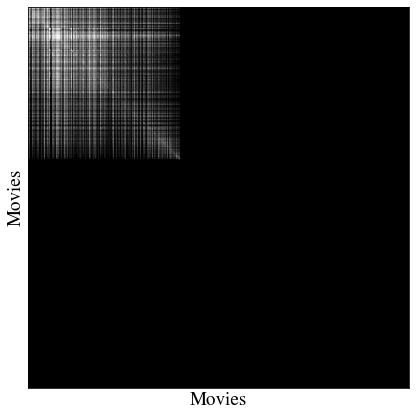

In [72]:
# filehandler = open(f"block_corr_H07M46S13_05-14-22mlhaa.obj","rb")
# block_corr = pickle.load(filehandler)
# filehandler.close()

## Threshold matrix
block_corr[block_corr<threshold]=0
block_corr[block_corr>=threshold]=1
# block_corr[block_corr==0]=-1
# block_corr[block_corr==1]=0
# block_corr[block_corr==-1]=1

print(np.max(block_corr), flush=True)

f, ax = plt.subplots()
# 'nearest' interpolation - faithful but blocky
ax.imshow(block_corr,cmap=cm.Greys_r)
# ax.imshow(block_corr,cmap="hot")
plt.xlabel('Movies',fontsize=19)
plt.ylabel('Movies',fontsize=19)
plt.xticks([])
plt.yticks([])
# plt.title('Keywords sharing at least 2 advertisers')
plt.savefig(f'../block_matrix_threshold_{threshold}.pdf', format='pdf', dpi=200)
plt.show()

In [ ]:
len(connected_comp[0])

In [ ]:
print(movie_ids[13413])

In [ ]:
13413 in movie_ind_with_scores

## Simulation

In [54]:
for j, g in enumerate(genres):
    if g not in genres_matching_tags: 
        continue
    print(j,g)

1 action
2 adventure
3 animation
4 children
5 comedy
6 crime
7 documentary
8 drama
9 fantasy
11 horror
13 musical
14 mystery
15 romance
16 sci-fi
17 thriller
18 war
19 western


In [55]:
movie_genres[1][-2]

0.0

In [56]:
for j, g in enumerate(genres):
    if g not in genres_matching_tags: 
        continue
    if g in ['action', 'adventure', 'crime', 'war', 'western']:
        print(g, j)
    if g in ['romance']:
        print(g, j)



action 1
adventure 2
crime 6
romance 15
war 18
western 19


In [79]:
for j, g in enumerate(genres):
    if g not in genres_matching_tags: 
        continue
    if g in ['romance', 'horror']:
        print(g, j)



horror 11
romance 15


In [57]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  user_ratings:  5.0 MiB
user_ratings_for_movies_with_scores:  5.0 MiB
                  movie_genres:  4.2 MiB
            selected_users_set:  2.0 MiB
             movie_id_to_index:  1.3 MiB
                   movie_names:  1.3 MiB
              movie_rating_cnt:  1.3 MiB
              movie_rating_sum:  1.3 MiB
                    movie_cast:  1.3 MiB
                movie_cast_ind:  1.3 MiB


In [58]:
del(block_corr)

NameError: name 'block_corr' is not defined

In [58]:
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('simulation-utils.py').read())

In [59]:
grps_set = [set(grps[0]), set(grps[1])]

In [60]:
cnt1=0
cnt2=0
for u in user_ratings_for_movies_with_scores:
    cnt1+=len(user_ratings_for_movies_with_scores[u])
for u in user_ratings:
    cnt2+=len(user_ratings[u])

print(cnt1, cnt2)

19800443 20000263


### Vary genres: log func

### Only include genres favoring men-led movies

In [61]:
for j, g in enumerate(genres):
    if g not in genres_matching_tags: 
        continue
    print(j,g)

1 action
2 adventure
3 animation
4 children
5 comedy
6 crime
7 documentary
8 drama
9 fantasy
11 horror
13 musical
14 mystery
15 romance
16 sci-fi
17 thriller
18 war
19 western


In [62]:
weight_F = get_movie_dist_over_genre(1)
len(weight_F)

# romance 0
# war 12
# action 13
# adventure 15
# western 16
# crime 19

20

#### Genre favoring women/men movies: random subsets of 1

In [63]:
len(weight_F)

20

Genre: adventure


  1%|          | 1/100 [00:00<01:19,  1.25it/s]

max: 4.5, min: 3.5
max: 4.5, min: 2.5
max: 4.5, min: 3.5
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.95, 0.0
util_algo_2_greedy_cons: 3.8, 0.0
util_algo_3_disjoint_attr: 3.95, 0.0
##################################################


  2%|▏         | 2/100 [00:02<01:45,  1.07s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.825, 0.08838834764831843
util_algo_2_greedy_cons: 3.8, 0.0
util_algo_3_disjoint_attr: 3.825, 0.08838834764831843
##################################################


  3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

max: 4.0, min: 1.0
max: 4.0, min: 2.5
max: 4.0, min: 1.0
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.516666666666667, 0.2585572506271133
util_algo_2_greedy_cons: 3.633333333333333, 0.13608276348795434
util_algo_3_disjoint_attr: 3.516666666666667, 0.2585572506271133
##################################################


  4%|▍         | 4/100 [00:03<01:12,  1.33it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.7750000000000004, 0.29606798205817525
util_algo_2_greedy_cons: 3.8499999999999996, 0.2136000936329383
util_algo_3_disjoint_attr: 3.7750000000000004, 0.29606798205817525
##################################################


  5%|▌         | 5/100 [00:05<02:04,  1.32s/it]

max: 4.0, min: 3.5
max: 4.5, min: 3.0
max: 4.0, min: 3.5
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.81, 0.23891421054428721
util_algo_2_greedy_cons: 3.8599999999999994, 0.1711139970896595
util_algo_3_disjoint_attr: 3.81, 0.23891421054428721
##################################################


  6%|▌         | 6/100 [00:05<01:34,  1.00s/it]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.816666666666667, 0.19918816713330623
util_algo_2_greedy_cons: 3.8249999999999993, 0.14613064930625155
util_algo_3_disjoint_attr: 3.816666666666667, 0.19918816713330623
##################################################


  7%|▋         | 7/100 [00:06<01:18,  1.18it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.835714285714286, 0.17164102481463137
util_algo_2_greedy_cons: 3.8285714285714283, 0.1252984774640558
util_algo_3_disjoint_attr: 3.835714285714286, 0.17164102481463137
##################################################


  8%|▊         | 8/100 [00:07<01:25,  1.08it/s]

max: 4.5, min: 1.0
max: 5.0, min: 1.0
max: 4.5, min: 1.0
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.81875, 0.15102190962737824
util_algo_2_greedy_cons: 3.80625, 0.11160669642767858
util_algo_3_disjoint_attr: 3.81875, 0.15102190962737824
##################################################


  9%|▉         | 9/100 [00:09<01:48,  1.19s/it]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.827777777777778, 0.1345112577580361
util_algo_2_greedy_cons: 3.7944444444444443, 0.09982838497735967
util_algo_3_disjoint_attr: 3.827777777777778, 0.1345112577580361
##################################################


 10%|█         | 10/100 [00:10<01:56,  1.29s/it]

max: 5.0, min: 2.5
max: 4.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.8400000000000007, 0.12161414391426681
util_algo_2_greedy_cons: 3.785, 0.09029119558406568
util_algo_3_disjoint_attr: 3.8400000000000007, 0.12161414391426681
##################################################


 11%|█         | 11/100 [00:11<01:46,  1.20s/it]

max: 4.5, min: 3.0
max: 5.0, min: 3.0
max: 4.5, min: 3.0
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.827272727272728, 0.11122229181618438
util_algo_2_greedy_cons: 3.8000000000000003, 0.08331955809010617
util_algo_3_disjoint_attr: 3.827272727272728, 0.11122229181618438
##################################################


 12%|█▏        | 12/100 [00:12<01:38,  1.12s/it]

max: 4.0, min: 3.5
max: 5.0, min: 2.5
max: 4.0, min: 3.5
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.804166666666667, 0.10432626662258844
util_algo_2_greedy_cons: 3.7916666666666674, 0.07679186637099494
util_algo_3_disjoint_attr: 3.804166666666667, 0.10432626662258844
##################################################


 13%|█▎        | 13/100 [00:17<03:08,  2.17s/it]

max: 4.5, min: 1.5
max: 4.5, min: 1.0
max: 4.5, min: 1.5
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.7576923076923086, 0.10614912947243625
util_algo_2_greedy_cons: 3.7307692307692313, 0.091912368468391
util_algo_3_disjoint_attr: 3.7576923076923086, 0.10614912947243625
##################################################


 14%|█▍        | 14/100 [00:19<03:08,  2.19s/it]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.682142857142858, 0.12253770170111898
util_algo_2_greedy_cons: 3.6785714285714293, 0.09906634111387663
util_algo_3_disjoint_attr: 3.682142857142858, 0.12253770170111898
##################################################


 15%|█▌        | 15/100 [00:22<03:27,  2.44s/it]

max: 5.0, min: 3.0
max: 5.0, min: 2.5
max: 5.0, min: 3.0
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.710000000000001, 0.1174923165336544
util_algo_2_greedy_cons: 3.696666666666667, 0.09410002558349714
util_algo_3_disjoint_attr: 3.710000000000001, 0.1174923165336544
##################################################


 16%|█▌        | 16/100 [00:24<03:15,  2.32s/it]

max: 5.0, min: 0.5
max: 5.0, min: 1.5
max: 5.0, min: 0.5
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.69375, 0.11126711595862453
util_algo_2_greedy_cons: 3.678125, 0.09002698705631274
util_algo_3_disjoint_attr: 3.69375, 0.11126711595862453
##################################################


 17%|█▋        | 17/100 [00:25<02:29,  1.80s/it]

max: 4.5, min: 3.0
max: 5.0, min: 3.0
max: 4.5, min: 3.0
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.711764705882353, 0.10617031200688122
util_algo_2_greedy_cons: 3.697058823529412, 0.0866994358920612
util_algo_3_disjoint_attr: 3.711764705882353, 0.10617031200688122
##################################################


 18%|█▊        | 18/100 [00:29<03:37,  2.65s/it]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.738888888888889, 0.10367889914994159
util_algo_2_greedy_cons: 3.7249999999999996, 0.0862677786292752
util_algo_3_disjoint_attr: 3.738888888888889, 0.10367889914994159
##################################################


 19%|█▉        | 19/100 [00:30<02:56,  2.18s/it]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.7421052631578946, 0.09827199223774724
util_algo_2_greedy_cons: 3.7342105263157896, 0.08221758777366678
util_algo_3_disjoint_attr: 3.7421052631578946, 0.09827199223774724
##################################################


 20%|██        | 20/100 [00:31<02:19,  1.75s/it]

max: 4.5, min: 2.0
max: 5.0, min: 2.0
max: 4.5, min: 2.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.7224999999999993, 0.09529395311351081
util_algo_2_greedy_cons: 3.7325000000000004, 0.07812449999839999
util_algo_3_disjoint_attr: 3.7224999999999993, 0.09529395311351081
##################################################


 21%|██        | 21/100 [00:32<02:01,  1.54s/it]

max: 5.0, min: 2.5
max: 5.0, min: 0.5
max: 5.0, min: 2.5
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.7619047619047614, 0.09856710146384388
util_algo_2_greedy_cons: 3.75, 0.0763391406756257
util_algo_3_disjoint_attr: 3.7619047619047614, 0.09856710146384388
##################################################


 22%|██▏       | 22/100 [00:34<02:12,  1.70s/it]

max: 4.5, min: 3.5
max: 5.0, min: 3.5
max: 4.5, min: 3.5
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.7840909090909083, 0.096551401740532
util_algo_2_greedy_cons: 3.772727272727273, 0.07617721242906937
util_algo_3_disjoint_attr: 3.7840909090909083, 0.096551401740532
##################################################


 23%|██▎       | 23/100 [00:36<02:11,  1.71s/it]

max: 4.0, min: 3.0
max: 4.5, min: 3.0
max: 4.0, min: 3.0
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.77391304347826, 0.09288841025708625
util_algo_2_greedy_cons: 3.7652173913043474, 0.07323440256067278
util_algo_3_disjoint_attr: 3.77391304347826, 0.09288841025708625
##################################################


 24%|██▍       | 24/100 [00:37<01:45,  1.39s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.7875, 0.09000626907178312
util_algo_2_greedy_cons: 3.7791666666666663, 0.07149911777492497
util_algo_3_disjoint_attr: 3.7875, 0.09000626907178312
##################################################


 25%|██▌       | 25/100 [00:38<01:35,  1.28s/it]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.7760000000000002, 0.08713759234681664
util_algo_2_greedy_cons: 3.7519999999999993, 0.0736195626175543
util_algo_3_disjoint_attr: 3.7760000000000002, 0.08713759234681664
##################################################


 26%|██▌       | 26/100 [00:40<01:45,  1.42s/it]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.776923076923077, 0.08379103557206712
util_algo_2_greedy_cons: 3.7499999999999996, 0.07081520245969988
util_algo_3_disjoint_attr: 3.776923076923077, 0.08379103557206712
##################################################


 27%|██▋       | 27/100 [00:42<01:56,  1.60s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.774074074074074, 0.08073608423415651
util_algo_2_greedy_cons: 3.757407407407407, 0.06857873748676899
util_algo_3_disjoint_attr: 3.774074074074074, 0.08073608423415651
##################################################


 28%|██▊       | 28/100 [00:42<01:30,  1.26s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.771428571428572, 0.07789598357142533
util_algo_2_greedy_cons: 3.7482142857142855, 0.06674283109754524
util_algo_3_disjoint_attr: 3.771428571428572, 0.07789598357142533
##################################################


 29%|██▉       | 29/100 [00:43<01:15,  1.07s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.7793103448275867, 0.07560761563552078
util_algo_2_greedy_cons: 3.7499999999999996, 0.06446523826151696
util_algo_3_disjoint_attr: 3.7793103448275867, 0.07560761563552078
##################################################


 30%|███       | 30/100 [00:43<01:05,  1.07it/s]

max: 5.0, min: 2.0
max: 4.5, min: 2.0
max: 5.0, min: 2.0
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.7750000000000004, 0.073210123768658
util_algo_2_greedy_cons: 3.7399999999999998, 0.06308724118235001
util_algo_3_disjoint_attr: 3.7750000000000004, 0.073210123768658
##################################################


 31%|███       | 31/100 [00:44<00:52,  1.31it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.77741935483871, 0.07088847147837343
util_algo_2_greedy_cons: 3.733870967741935, 0.06134916940557866
util_algo_3_disjoint_attr: 3.77741935483871, 0.07088847147837343
##################################################


 32%|███▏      | 32/100 [00:45<01:04,  1.06it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.7875, 0.06938626034742036
util_algo_2_greedy_cons: 3.740625, 0.059802633557969255
util_algo_3_disjoint_attr: 3.7875, 0.06938626034742036
##################################################


 33%|███▎      | 33/100 [00:47<01:24,  1.26s/it]

max: 4.5, min: 2.5
max: 4.5, min: 2.0
max: 4.5, min: 2.5
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.774242424242424, 0.06853850178149391
util_algo_2_greedy_cons: 3.7242424242424246, 0.06019257480090539
util_algo_3_disjoint_attr: 3.774242424242424, 0.06853850178149391
##################################################


 34%|███▍      | 34/100 [00:47<01:06,  1.00s/it]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.795588235294118, 0.06976752198521062
util_algo_2_greedy_cons: 3.745588235294118, 0.06209183841144704
util_algo_3_disjoint_attr: 3.795588235294118, 0.06976752198521062
##################################################


 35%|███▌      | 35/100 [00:50<01:27,  1.35s/it]

max: 4.0, min: 2.5
max: 4.0, min: 2.0
max: 4.0, min: 2.5
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.7771428571428576, 0.07017013892320191
util_algo_2_greedy_cons: 3.7228571428571433, 0.06434419109067813
util_algo_3_disjoint_attr: 3.7771428571428576, 0.07017013892320191
##################################################


 36%|███▌      | 36/100 [00:50<01:09,  1.08s/it]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.8000000000000003, 0.07184731753543089
util_algo_2_greedy_cons: 3.744444444444445, 0.06607894227208076
util_algo_3_disjoint_attr: 3.8000000000000003, 0.07184731753543089
##################################################


 37%|███▋      | 37/100 [00:50<00:56,  1.11it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.0
max: 5.0, min: 3.5
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.810810810810811, 0.07071416798762734
util_algo_2_greedy_cons: 3.748648648648649, 0.0644266301602076
util_algo_3_disjoint_attr: 3.810810810810811, 0.07071416798762734
##################################################


 38%|███▊      | 38/100 [00:51<00:47,  1.31it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.8157894736842106, 0.06902830883707667
util_algo_2_greedy_cons: 3.7578947368421054, 0.0633911896221289
util_algo_3_disjoint_attr: 3.8157894736842106, 0.06902830883707667
##################################################


 39%|███▉      | 39/100 [00:51<00:42,  1.44it/s]

max: 4.5, min: 1.5
max: 5.0, min: 1.5
max: 4.5, min: 1.5
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.802564102564103, 0.0685135862354703
util_algo_2_greedy_cons: 3.75, 0.06225543867784094
util_algo_3_disjoint_attr: 3.802564102564103, 0.0685135862354703
##################################################


 40%|████      | 40/100 [00:54<01:09,  1.15s/it]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.77875, 0.070818595280477
util_algo_2_greedy_cons: 3.7275, 0.0646372087113916
util_algo_3_disjoint_attr: 3.77875, 0.070818595280477
##################################################


 41%|████      | 41/100 [00:54<00:53,  1.10it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.798780487804878, 0.07186824080165861
util_algo_2_greedy_cons: 3.7451219512195117, 0.06541872811548245
util_algo_3_disjoint_attr: 3.798780487804878, 0.07186824080165861
##################################################


 42%|████▏     | 42/100 [00:55<00:45,  1.26it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.810714285714286, 0.07114100276248907
util_algo_2_greedy_cons: 3.753571428571428, 0.06440449469935894
util_algo_3_disjoint_attr: 3.810714285714286, 0.07114100276248907
##################################################


 43%|████▎     | 43/100 [00:55<00:40,  1.40it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.5
max: 5.0, min: 3.0
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.8255813953488373, 0.07102304436816988
util_algo_2_greedy_cons: 3.7732558139534875, 0.06584617580027786
util_algo_3_disjoint_attr: 3.8255813953488373, 0.07102304436816988
##################################################


 44%|████▍     | 44/100 [00:56<00:52,  1.08it/s]

max: 4.5, min: 2.0
max: 4.0, min: 2.5
max: 4.5, min: 2.0
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.813636363636364, 0.07040620842527624
util_algo_2_greedy_cons: 3.7647727272727267, 0.06489381714583117
util_algo_3_disjoint_attr: 3.813636363636364, 0.07040620842527624
##################################################


 45%|████▌     | 45/100 [00:57<00:46,  1.19it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.808888888888889, 0.06900150094787057
util_algo_2_greedy_cons: 3.7633333333333328, 0.06346769373585388
util_algo_3_disjoint_attr: 3.808888888888889, 0.06900150094787057
##################################################


 46%|████▌     | 46/100 [00:57<00:36,  1.46it/s]

max: 5.0, min: 3.5
max: 5.0, min: 0.5
max: 5.0, min: 3.5
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.8260869565217392, 0.06961172240443728
util_algo_2_greedy_cons: 3.771739130434782, 0.06264212901691514
util_algo_3_disjoint_attr: 3.8260869565217392, 0.06961172240443728
##################################################


 47%|████▋     | 47/100 [00:59<00:42,  1.25it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.824468085106383, 0.06814944334619619
util_algo_2_greedy_cons: 3.7755319148936164, 0.06142403104581671
util_algo_3_disjoint_attr: 3.824468085106383, 0.06814944334619619
##################################################


 48%|████▊     | 48/100 [00:59<00:33,  1.54it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.8156250000000003, 0.06730095798213054
util_algo_2_greedy_cons: 3.7677083333333328, 0.06064056185103167
util_algo_3_disjoint_attr: 3.8156250000000003, 0.06730095798213054
##################################################


 49%|████▉     | 49/100 [00:59<00:30,  1.69it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.816326530612245, 0.06593112524393123
util_algo_2_greedy_cons: 3.768367346938775, 0.059406580184023464
util_algo_3_disjoint_attr: 3.816326530612245, 0.06593112524393123
##################################################


 50%|█████     | 50/100 [01:01<00:41,  1.21it/s]

max: 4.5, min: 3.0
max: 5.0, min: 3.0
max: 4.5, min: 3.0
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.82, 0.06471475874945373
util_algo_2_greedy_cons: 3.7749999999999995, 0.058587541337728095
util_algo_3_disjoint_attr: 3.82, 0.06471475874945373
##################################################


 51%|█████     | 51/100 [01:01<00:35,  1.40it/s]

max: 5.0, min: 1.5
max: 4.5, min: 4.0
max: 5.0, min: 1.5
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.824509803921569, 0.06360278607438276
util_algo_2_greedy_cons: 3.7833333333333328, 0.058028395034417486
util_algo_3_disjoint_attr: 3.824509803921569, 0.06360278607438276
##################################################


 52%|█████▏    | 52/100 [01:02<00:33,  1.43it/s]

max: 5.0, min: 4.0
max: 5.0, min: 3.5
max: 5.0, min: 4.0
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.8403846153846155, 0.06433027847892583
util_algo_2_greedy_cons: 3.7980769230769225, 0.05875561062315317
util_algo_3_disjoint_attr: 3.8403846153846155, 0.06433027847892583
##################################################


 53%|█████▎    | 53/100 [01:02<00:31,  1.49it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.8415094339622646, 0.06312633263215334
util_algo_2_greedy_cons: 3.796226415094339, 0.05767614770945315
util_algo_3_disjoint_attr: 3.8415094339622646, 0.06312633263215334
##################################################


 54%|█████▍    | 54/100 [01:03<00:27,  1.70it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.8462962962962965, 0.06213855502280451
util_algo_2_greedy_cons: 3.799074074074073, 0.056678326395774616
util_algo_3_disjoint_attr: 3.8462962962962965, 0.06213855502280451
##################################################


 55%|█████▌    | 55/100 [01:03<00:27,  1.65it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.8345454545454545, 0.062109909608090465
util_algo_2_greedy_cons: 3.7872727272727262, 0.056863155754355584
util_algo_3_disjoint_attr: 3.8345454545454545, 0.062109909608090465
##################################################


 56%|█████▌    | 56/100 [01:04<00:31,  1.41it/s]

max: 3.0, min: 2.0
max: 4.5, min: 2.0
max: 3.0, min: 2.0
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.809821428571429, 0.06573781172019247
util_algo_2_greedy_cons: 3.7696428571428564, 0.0585169412749911
util_algo_3_disjoint_attr: 3.809821428571429, 0.06573781172019247
##################################################


 57%|█████▋    | 57/100 [01:05<00:27,  1.57it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.8070175438596494, 0.06464428552555843
util_algo_2_greedy_cons: 3.7701754385964907, 0.05749275181640915
util_algo_3_disjoint_attr: 3.8070175438596494, 0.06464428552555843
##################################################


 58%|█████▊    | 58/100 [01:05<00:26,  1.56it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.8068965517241384, 0.0635298421065466
util_algo_2_greedy_cons: 3.7689655172413787, 0.05651422729501151
util_algo_3_disjoint_attr: 3.8068965517241384, 0.0635298421065466
##################################################


 59%|█████▉    | 59/100 [01:06<00:25,  1.64it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.82542372881356, 0.06509856934496469
util_algo_2_greedy_cons: 3.7881355932203387, 0.05871773299058509
util_algo_3_disjoint_attr: 3.82542372881356, 0.06509856934496469
##################################################


 60%|██████    | 60/100 [01:06<00:20,  1.91it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.810000000000001, 0.06581539840088081
util_algo_2_greedy_cons: 3.7849999999999993, 0.05782276560509901
util_algo_3_disjoint_attr: 3.810000000000001, 0.06581539840088081
##################################################


 61%|██████    | 61/100 [01:08<00:30,  1.29it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.818032786885247, 0.06522481728366314
util_algo_2_greedy_cons: 3.7942622950819667, 0.0576119122959647
util_algo_3_disjoint_attr: 3.818032786885247, 0.06522481728366314
##################################################


 62%|██████▏   | 62/100 [01:08<00:24,  1.57it/s]

max: 5.0, min: 0.5
max: 4.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.7935483870967754, 0.06861461573844241
util_algo_2_greedy_cons: 3.7685483870967733, 0.062156798293505754
util_algo_3_disjoint_attr: 3.7935483870967754, 0.06861461573844241
##################################################


 63%|██████▎   | 63/100 [01:09<00:22,  1.65it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.797619047619049, 0.06764613597282652
util_algo_2_greedy_cons: 3.774603174603174, 0.06146437798013601
util_algo_3_disjoint_attr: 3.797619047619049, 0.06764613597282652
##################################################


 64%|██████▍   | 64/100 [01:09<00:20,  1.75it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.79296875, 0.06674881483304562
util_algo_2_greedy_cons: 3.76875, 0.060782053336593526
util_algo_3_disjoint_attr: 3.79296875, 0.06674881483304562
##################################################


 65%|██████▌   | 65/100 [01:09<00:17,  2.01it/s]

max: 4.5, min: 2.5
max: 5.0, min: 2.5
max: 4.5, min: 2.5
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.7915384615384613, 0.06573723225883749
util_algo_2_greedy_cons: 3.772307692307692, 0.05995097374961925
util_algo_3_disjoint_attr: 3.7915384615384613, 0.06573723225883749
##################################################


 66%|██████▌   | 66/100 [01:10<00:19,  1.75it/s]

max: 4.0, min: 2.5
max: 4.5, min: 2.0
max: 4.0, min: 2.5
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.7848484848484847, 0.06508073760330325
util_algo_2_greedy_cons: 3.768939393939394, 0.0591371725609775
util_algo_3_disjoint_attr: 3.7848484848484847, 0.06508073760330325
##################################################


 67%|██████▋   | 67/100 [01:11<00:18,  1.82it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.791791044776119, 0.06447862263343239
util_algo_2_greedy_cons: 3.771641791044776, 0.05831624135703001
util_algo_3_disjoint_attr: 3.791791044776119, 0.06447862263343239
##################################################


 68%|██████▊   | 68/100 [01:12<00:25,  1.26it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.0
max: 4.5, min: 3.5
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.7948529411764698, 0.06360306618384819
util_algo_2_greedy_cons: 3.7720588235294117, 0.05746014069930388
util_algo_3_disjoint_attr: 3.7948529411764698, 0.06360306618384819
##################################################


 69%|██████▉   | 69/100 [01:12<00:21,  1.44it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.7978260869565212, 0.06275073446683788
util_algo_2_greedy_cons: 3.7739130434782604, 0.05665729467378703
util_algo_3_disjoint_attr: 3.7978260869565212, 0.06275073446683788
##################################################


 70%|███████   | 70/100 [01:13<00:20,  1.45it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.7971428571428567, 0.06185801479330789
util_algo_2_greedy_cons: 3.775, 0.055858330276016034
util_algo_3_disjoint_attr: 3.7971428571428567, 0.06185801479330789
##################################################


 71%|███████   | 71/100 [01:14<00:18,  1.54it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.798591549295774, 0.061003736710680705
util_algo_2_greedy_cons: 3.7753521126760563, 0.05507270302036456
util_algo_3_disjoint_attr: 3.798591549295774, 0.061003736710680705
##################################################


 72%|███████▏  | 72/100 [01:14<00:17,  1.65it/s]

max: 4.5, min: 1.5
max: 4.5, min: 2.5
max: 4.5, min: 1.5
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.7902777777777774, 0.06072033271375977
util_algo_2_greedy_cons: 3.771527777777778, 0.054440426340610734
util_algo_3_disjoint_attr: 3.7902777777777774, 0.06072033271375977
##################################################


 73%|███████▎  | 73/100 [01:15<00:20,  1.34it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.787671232876712, 0.05994446687204467
util_algo_2_greedy_cons: 3.767123287671233, 0.05387254456991089
util_algo_3_disjoint_attr: 3.787671232876712, 0.05994446687204467
##################################################


 74%|███████▍  | 74/100 [01:16<00:16,  1.60it/s]

max: 4.5, min: 3.0
max: 5.0, min: 3.0
max: 4.5, min: 3.0
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.7898648648648647, 0.05917453022327664
util_algo_2_greedy_cons: 3.7709459459459462, 0.05327998763609576
util_algo_3_disjoint_attr: 3.7898648648648647, 0.05917453022327664
##################################################


 75%|███████▌  | 75/100 [01:16<00:16,  1.50it/s]

max: 4.5, min: 3.0
max: 5.0, min: 3.5
max: 4.5, min: 3.0
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.792, 0.05842404375673503
util_algo_2_greedy_cons: 3.776, 0.052808753483153184
util_algo_3_disjoint_attr: 3.792, 0.05842404375673503
##################################################


 76%|███████▌  | 76/100 [01:17<00:13,  1.76it/s]

max: 5.0, min: 3.5
max: 4.5, min: 3.5
max: 5.0, min: 3.5
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.7967105263157888, 0.0578448912688967
util_algo_2_greedy_cons: 3.7796052631578947, 0.05223682248093018
util_algo_3_disjoint_attr: 3.7967105263157888, 0.0578448912688967
##################################################


 77%|███████▋  | 77/100 [01:18<00:16,  1.43it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.7889610389610384, 0.05761042017951022
util_algo_2_greedy_cons: 3.7714285714285714, 0.052194452739756175
util_algo_3_disjoint_attr: 3.7889610389610384, 0.05761042017951022
##################################################


 78%|███████▊  | 78/100 [01:18<00:13,  1.69it/s]

max: 4.5, min: 2.5
max: 5.0, min: 2.5
max: 4.5, min: 2.5
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.7891025641025635, 0.05687199888331189
util_algo_2_greedy_cons: 3.7730769230769226, 0.051551314793575734
util_algo_3_disjoint_attr: 3.7891025641025635, 0.05687199888331189
##################################################


 79%|███████▉  | 79/100 [01:18<00:10,  1.92it/s]

max: 5.0, min: 2.5
max: 5.0, min: 4.0
max: 5.0, min: 2.5
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.798101265822784, 0.056859563529180875
util_algo_2_greedy_cons: 3.7841772151898727, 0.05208014222702058
util_algo_3_disjoint_attr: 3.798101265822784, 0.056859563529180875
##################################################


 80%|████████  | 80/100 [01:19<00:09,  2.11it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.794375, 0.05627078609000856
util_algo_2_greedy_cons: 3.7825, 0.0514561403041464
util_algo_3_disjoint_attr: 3.794375, 0.05627078609000856
##################################################


 81%|████████  | 81/100 [01:20<00:11,  1.73it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.8043209876543216, 0.05644822964301864
util_algo_2_greedy_cons: 3.792592592592593, 0.05180120329920704
util_algo_3_disjoint_attr: 3.8043209876543216, 0.05644822964301864
##################################################


 82%|████████▏ | 82/100 [01:21<00:14,  1.27it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.805487804878049, 0.055771894684821424
util_algo_2_greedy_cons: 3.792682926829269, 0.05116956007298958
util_algo_3_disjoint_attr: 3.805487804878049, 0.055771894684821424
##################################################


 83%|████████▎ | 83/100 [01:21<00:11,  1.53it/s]

max: 4.0, min: 3.5
max: 4.0, min: 3.5
max: 4.0, min: 3.5
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.8066265060240965, 0.055111567416193476
util_algo_2_greedy_cons: 3.7933734939759045, 0.05055771896527287
util_algo_3_disjoint_attr: 3.8066265060240965, 0.055111567416193476
##################################################


 84%|████████▍ | 84/100 [01:22<00:09,  1.74it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.7970238095238096, 0.055285739859388894
util_algo_2_greedy_cons: 3.7839285714285724, 0.05083041082742694
util_algo_3_disjoint_attr: 3.7970238095238096, 0.055285739859388894
##################################################


 85%|████████▌ | 85/100 [01:22<00:07,  2.00it/s]

max: 4.5, min: 3.5
max: 4.5, min: 2.5
max: 4.5, min: 3.5
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.7982352941176467, 0.05464859149894946
util_algo_2_greedy_cons: 3.7817647058823542, 0.05027844309459356
util_algo_3_disjoint_attr: 3.7982352941176467, 0.05464859149894946
##################################################


 86%|████████▌ | 86/100 [01:22<00:07,  1.90it/s]

max: 5.0, min: 3.0
max: 5.0, min: 4.0
max: 5.0, min: 3.0
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.8029069767441857, 0.0542124564542549
util_algo_2_greedy_cons: 3.78779069767442, 0.050053622183010425
util_algo_3_disjoint_attr: 3.8029069767441857, 0.0542124564542549
##################################################


 87%|████████▋ | 87/100 [01:23<00:05,  2.20it/s]

max: 5.0, min: 2.0
max: 5.0, min: 4.0
max: 5.0, min: 2.0
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.801724137931034, 0.05360222714924021
util_algo_2_greedy_cons: 3.791379310344829, 0.04960676983561215
util_algo_3_disjoint_attr: 3.801724137931034, 0.05360222714924021
##################################################


 88%|████████▊ | 88/100 [01:23<00:05,  2.39it/s]

max: 4.0, min: 3.5
max: 4.0, min: 3.0
max: 4.0, min: 3.5
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.802840909090909, 0.053004743293038
util_algo_2_greedy_cons: 3.7914772727272723, 0.04904315326893353
util_algo_3_disjoint_attr: 3.802840909090909, 0.053004743293038
##################################################


 89%|████████▉ | 89/100 [01:24<00:04,  2.39it/s]

max: 5.0, min: 2.5
max: 5.0, min: 3.5
max: 5.0, min: 2.5
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.8050561797752804, 0.05245545626477386
util_algo_2_greedy_cons: 3.7960674157303367, 0.04870643777376065
util_algo_3_disjoint_attr: 3.8050561797752804, 0.05245545626477386
##################################################


 90%|█████████ | 90/100 [01:24<00:05,  1.98it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.807222222222222, 0.051917319781345256
util_algo_2_greedy_cons: 3.7999999999999994, 0.04832375383996141
util_algo_3_disjoint_attr: 3.807222222222222, 0.051917319781345256
##################################################


 91%|█████████ | 91/100 [01:27<00:09,  1.11s/it]

max: 5.0, min: 0.5
max: 5.0, min: 1.0
max: 5.0, min: 0.5
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.807142857142857, 0.0513468604457018
util_algo_2_greedy_cons: 3.7999999999999994, 0.047792723577983816
util_algo_3_disjoint_attr: 3.807142857142857, 0.0513468604457018
##################################################


 92%|█████████▏| 92/100 [01:28<00:08,  1.10s/it]

max: 4.0, min: 1.0
max: 3.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.783152173913044, 0.05611410897943081
util_algo_2_greedy_cons: 3.776086956521739, 0.05291858883667001
util_algo_3_disjoint_attr: 3.783152173913044, 0.05611410897943081
##################################################


 93%|█████████▎| 93/100 [01:28<00:06,  1.15it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.786021505376344, 0.05558404306185369
util_algo_2_greedy_cons: 3.779032258064516, 0.05243147133550645
util_algo_3_disjoint_attr: 3.786021505376344, 0.05558404306185369
##################################################


 94%|█████████▍| 94/100 [01:29<00:04,  1.26it/s]

max: 4.0, min: 3.0
max: 4.5, min: 3.0
max: 4.0, min: 3.0
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.7808510638297874, 0.05523267782926762
util_algo_2_greedy_cons: 3.778191489361702, 0.05188043039168934
util_algo_3_disjoint_attr: 3.7808510638297874, 0.05523267782926762
##################################################


 95%|█████████▌| 95/100 [01:29<00:03,  1.49it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.776842105263158, 0.0547965793780259
util_algo_2_greedy_cons: 3.7757894736842106, 0.05138989606057011
util_algo_3_disjoint_attr: 3.776842105263158, 0.0547965793780259
##################################################


 96%|█████████▌| 96/100 [01:30<00:02,  1.53it/s]

max: 5.0, min: 2.0
max: 5.0, min: 3.5
max: 5.0, min: 2.0
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.7817708333333333, 0.0544469899384789
util_algo_2_greedy_cons: 3.7828125, 0.05133223059324377
util_algo_3_disjoint_attr: 3.7817708333333333, 0.0544469899384789
##################################################


 97%|█████████▋| 97/100 [01:30<00:01,  1.68it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.788144329896907, 0.05425743517627701
util_algo_2_greedy_cons: 3.7865979381443293, 0.05094241758708685
util_algo_3_disjoint_attr: 3.788144329896907, 0.05425743517627701
##################################################


 98%|█████████▊| 98/100 [01:31<00:01,  1.58it/s]

max: 5.0, min: 1.5
max: 5.0, min: 2.5
max: 5.0, min: 1.5
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.783673469387755, 0.05388767448086709
util_algo_2_greedy_cons: 3.78469387755102, 0.05045816822436958
util_algo_3_disjoint_attr: 3.783673469387755, 0.05388767448086709
##################################################


 99%|█████████▉| 99/100 [01:33<00:01,  1.06s/it]

max: 5.0, min: 1.0
max: 4.5, min: 2.0
max: 5.0, min: 1.0
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.7797979797979795, 0.05348253155443247
util_algo_2_greedy_cons: 3.7803030303030303, 0.05013917057333673
util_algo_3_disjoint_attr: 3.7797979797979795, 0.05348253155443247
##################################################


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.7834999999999996, 0.05307567710354716
util_algo_2_greedy_cons: 3.786, 0.04996038430596786
util_algo_3_disjoint_attr: 3.7834999999999996, 0.05307567710354716
##################################################
./figs/H17M55S21_05-15-22phhsh.pdf
Genre: western


  1%|          | 1/100 [00:00<00:40,  2.43it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.9, 0.0
util_algo_2_greedy_cons: 3.8, 0.0
util_algo_3_disjoint_attr: 3.9, 0.0
##################################################


  2%|▏         | 2/100 [00:00<00:36,  2.71it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 1 ###############
util_baseline_greedy_uncons: 4.125, 0.1590990257669731
util_algo_2_greedy_cons: 4.1, 0.21213203435596442
util_algo_3_disjoint_attr: 4.125, 0.1590990257669731
##################################################


  3%|▎         | 3/100 [00:01<00:33,  2.86it/s]

max: 5.0, min: 4.0
max: 5.0, min: 2.0
max: 5.0, min: 4.0
############### iteration 2 ###############
util_baseline_greedy_uncons: 4.3, 0.17795130420052194
util_algo_2_greedy_cons: 4.1, 0.14142135623730964
util_algo_3_disjoint_attr: 4.3, 0.17795130420052194
##################################################


  4%|▍         | 4/100 [00:01<00:37,  2.53it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 3 ###############
util_baseline_greedy_uncons: 4.175, 0.1718465885608441
util_algo_2_greedy_cons: 4.05, 0.1145643923738961
util_algo_3_disjoint_attr: 4.175, 0.1718465885608441
##################################################


  5%|▌         | 5/100 [00:03<01:33,  1.02it/s]

max: 4.5, min: 4.0
max: 4.5, min: 3.5
max: 4.5, min: 4.0
############### iteration 4 ###############
util_baseline_greedy_uncons: 4.17, 0.13754999091239523
util_algo_2_greedy_cons: 4.06, 0.09208691546577076
util_algo_3_disjoint_attr: 4.17, 0.13754999091239523
##################################################


  6%|▌         | 6/100 [00:04<01:19,  1.18it/s]

max: 5.0, min: 2.0
max: 4.5, min: 2.0
max: 5.0, min: 2.0
############### iteration 5 ###############
util_baseline_greedy_uncons: 4.066666666666667, 0.1484487690654155
util_algo_2_greedy_cons: 3.9583333333333326, 0.1204255571496965
util_algo_3_disjoint_attr: 4.066666666666667, 0.1484487690654155
##################################################


  7%|▋         | 7/100 [00:04<01:11,  1.31it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 6 ###############
util_baseline_greedy_uncons: 4.078571428571429, 0.127718257711142
util_algo_2_greedy_cons: 3.971428571428571, 0.10393146429805086
util_algo_3_disjoint_attr: 4.078571428571429, 0.127718257711142
##################################################


  8%|▊         | 8/100 [00:05<01:01,  1.49it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 7 ###############
util_baseline_greedy_uncons: 4.04375, 0.11640362832618238
util_algo_2_greedy_cons: 3.93125, 0.09840029058646116
util_algo_3_disjoint_attr: 4.04375, 0.11640362832618238
##################################################


  9%|▉         | 9/100 [00:05<00:56,  1.62it/s]

max: 3.5, min: 1.0
max: 3.5, min: 1.5
max: 3.5, min: 1.0
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.888888888888889, 0.1789506066374524
util_algo_2_greedy_cons: 3.7944444444444443, 0.15584188814792033
util_algo_3_disjoint_attr: 3.888888888888889, 0.1789506066374524
##################################################


 10%|█         | 10/100 [00:06<00:51,  1.75it/s]

max: 5.0, min: 3.0
max: 5.0, min: 4.0
max: 5.0, min: 3.0
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.9299999999999997, 0.1657105910918189
util_algo_2_greedy_cons: 3.8449999999999998, 0.14823123827317908
util_algo_3_disjoint_attr: 3.9299999999999997, 0.1657105910918189
##################################################


 11%|█         | 11/100 [00:07<01:04,  1.37it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.8636363636363638, 0.16339513900369734
util_algo_2_greedy_cons: 3.7818181818181813, 0.1476080256156343
util_algo_3_disjoint_attr: 3.8636363636363638, 0.16339513900369734
##################################################


 12%|█▏        | 12/100 [00:07<01:00,  1.44it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.8833333333333333, 0.15096142504577736
util_algo_2_greedy_cons: 3.7791666666666663, 0.13533116959135083
util_algo_3_disjoint_attr: 3.8833333333333333, 0.15096142504577736
##################################################


 13%|█▎        | 13/100 [00:08<01:00,  1.43it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.853846153846154, 0.14219970314942704
util_algo_2_greedy_cons: 3.7423076923076914, 0.12984357382669115
util_algo_3_disjoint_attr: 3.853846153846154, 0.14219970314942704
##################################################


 14%|█▍        | 14/100 [00:09<00:52,  1.64it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.7857142857142856, 0.1474639848307289
util_algo_2_greedy_cons: 3.6678571428571423, 0.14029916494808936
util_algo_3_disjoint_attr: 3.7857142857142856, 0.1474639848307289
##################################################


 15%|█▌        | 15/100 [00:09<01:01,  1.39it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.74, 0.14454526396023265
util_algo_2_greedy_cons: 3.626666666666666, 0.13685894333352996
util_algo_3_disjoint_attr: 3.74, 0.14454526396023265
##################################################


 16%|█▌        | 16/100 [00:10<00:56,  1.49it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.7125, 0.13810237371240222
util_algo_2_greedy_cons: 3.596875, 0.13150783825855208
util_algo_3_disjoint_attr: 3.7125, 0.13810237371240222
##################################################


 17%|█▋        | 17/100 [00:10<00:47,  1.76it/s]

max: 4.5, min: 2.5
max: 4.5, min: 1.0
max: 4.5, min: 2.5
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.702941176470588, 0.13030909409581065
util_algo_2_greedy_cons: 3.579411764705882, 0.12492619437212212
util_algo_3_disjoint_attr: 3.702941176470588, 0.13030909409581065
##################################################


 18%|█▊        | 18/100 [00:15<02:38,  1.94s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.6999999999999997, 0.1231028878120019
util_algo_2_greedy_cons: 3.5777777777777775, 0.11799653571906661
util_algo_3_disjoint_attr: 3.6999999999999997, 0.1231028878120019
##################################################


 19%|█▉        | 19/100 [00:16<02:02,  1.52s/it]

max: 5.0, min: 3.0
max: 5.0, min: 2.5
max: 5.0, min: 3.0
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.7184210526315784, 0.1179939975887659
util_algo_2_greedy_cons: 3.5868421052631576, 0.11213380568591284
util_algo_3_disjoint_attr: 3.7184210526315784, 0.1179939975887659
##################################################


 20%|██        | 20/100 [00:17<01:36,  1.21s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.7224999999999993, 0.1121647783397266
util_algo_2_greedy_cons: 3.6025, 0.10761476432163014
util_algo_3_disjoint_attr: 3.7224999999999993, 0.1121647783397266
##################################################


 21%|██        | 21/100 [00:17<01:14,  1.06it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.7309523809523806, 0.10714159737228651
util_algo_2_greedy_cons: 3.607142857142857, 0.10259035695964738
util_algo_3_disjoint_attr: 3.7309523809523806, 0.10714159737228651
##################################################


 22%|██▏       | 22/100 [00:17<00:59,  1.30it/s]

max: 4.0, min: 2.0
max: 4.0, min: 1.0
max: 4.0, min: 2.0
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.675, 0.1159647816300811
util_algo_2_greedy_cons: 3.5522727272727277, 0.11164053112257809
util_algo_3_disjoint_attr: 3.675, 0.1159647816300811
##################################################


 23%|██▎       | 23/100 [00:17<00:48,  1.60it/s]

max: 4.5, min: 3.0
max: 4.0, min: 1.0
max: 4.5, min: 3.0
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.6826086956521733, 0.11117216572278797
util_algo_2_greedy_cons: 3.539130434782609, 0.10755736684205114
util_algo_3_disjoint_attr: 3.6826086956521733, 0.11117216572278797
##################################################


 24%|██▍       | 24/100 [00:18<00:41,  1.84it/s]

max: 5.0, min: 1.0
max: 5.0, min: 3.0
max: 5.0, min: 1.0
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.6833333333333336, 0.10654235377608358
util_algo_2_greedy_cons: 3.5541666666666667, 0.10412151799344486
util_algo_3_disjoint_attr: 3.6833333333333336, 0.10654235377608358
##################################################


 25%|██▌       | 25/100 [00:18<00:35,  2.10it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.5
max: 5.0, min: 2.0
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.658, 0.10524941805064766
util_algo_2_greedy_cons: 3.5439999999999996, 0.10045177947652295
util_algo_3_disjoint_attr: 3.658, 0.10524941805064766
##################################################


 26%|██▌       | 26/100 [00:20<01:00,  1.23it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.6346153846153846, 0.1037666800867317
util_algo_2_greedy_cons: 3.523076923076923, 0.09874324069559302
util_algo_3_disjoint_attr: 3.6346153846153846, 0.1037666800867317
##################################################


 27%|██▋       | 27/100 [00:20<00:47,  1.52it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.6333333333333333, 0.09993138935727439
util_algo_2_greedy_cons: 3.522222222222222, 0.0950897826168308
util_algo_3_disjoint_attr: 3.6333333333333333, 0.09993138935727439
##################################################


 28%|██▊       | 28/100 [00:21<00:44,  1.63it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.6357142857142857, 0.09639077112471657
util_algo_2_greedy_cons: 3.539285714285714, 0.09321213540408202
util_algo_3_disjoint_attr: 3.6357142857142857, 0.09639077112471657
##################################################


 29%|██▉       | 29/100 [00:24<01:45,  1.49s/it]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.6120689655172415, 0.095923298865513
util_algo_2_greedy_cons: 3.518965517241379, 0.09218621596105935
util_algo_3_disjoint_attr: 3.6120689655172415, 0.095923298865513
##################################################


 30%|███       | 30/100 [00:24<01:20,  1.15s/it]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.585, 0.09646962676868244
util_algo_2_greedy_cons: 3.505, 0.09016497225764682
util_algo_3_disjoint_attr: 3.585, 0.09646962676868244
##################################################


 31%|███       | 31/100 [00:25<01:04,  1.07it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.593548387096774, 0.09373568390127923
util_algo_2_greedy_cons: 3.4999999999999996, 0.08739494957512302
util_algo_3_disjoint_attr: 3.593548387096774, 0.09373568390127923
##################################################


 32%|███▏      | 32/100 [00:25<00:56,  1.20it/s]

max: 4.0, min: 2.5
max: 4.0, min: 3.0
max: 4.0, min: 2.5
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.5874999999999995, 0.09100137361600646
util_algo_2_greedy_cons: 3.4984375, 0.08467782391101396
util_algo_3_disjoint_attr: 3.5874999999999995, 0.09100137361600646
##################################################


 33%|███▎      | 33/100 [00:26<00:50,  1.34it/s]

max: 3.5, min: 2.0
max: 4.0, min: 2.0
max: 3.5, min: 2.0
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.5666666666666664, 0.09059710776348583
util_algo_2_greedy_cons: 3.490909090909091, 0.08244581228055928
util_algo_3_disjoint_attr: 3.5666666666666664, 0.09059710776348583
##################################################


 34%|███▍      | 34/100 [00:27<00:48,  1.37it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.5676470588235287, 0.08793779141973133
util_algo_2_greedy_cons: 3.4911764705882353, 0.08002136901657958
util_algo_3_disjoint_attr: 3.5676470588235287, 0.08793779141973133
##################################################


 35%|███▌      | 35/100 [00:27<00:42,  1.52it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.5799999999999996, 0.08628855246041786
util_algo_2_greedy_cons: 3.5, 0.07821999326859326
util_algo_3_disjoint_attr: 3.5799999999999996, 0.08628855246041786
##################################################


 36%|███▌      | 36/100 [00:28<00:38,  1.68it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.605555555555555, 0.08759425650287128
util_algo_2_greedy_cons: 3.5277777777777777, 0.08082914375464915
util_algo_3_disjoint_attr: 3.605555555555555, 0.08759425650287128
##################################################


 37%|███▋      | 37/100 [00:28<00:32,  1.94it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.6243243243243244, 0.08721445365478413
util_algo_2_greedy_cons: 3.5432432432432432, 0.08011045520693896
util_algo_3_disjoint_attr: 3.6243243243243244, 0.08721445365478413
##################################################


 38%|███▊      | 38/100 [00:29<00:32,  1.91it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.6236842105263154, 0.08492168549062996
util_algo_2_greedy_cons: 3.5368421052631582, 0.07825760542293358
util_algo_3_disjoint_attr: 3.6236842105263154, 0.08492168549062996
##################################################


 39%|███▉      | 39/100 [00:29<00:37,  1.64it/s]

max: 5.0, min: 2.5
max: 5.0, min: 0.5
max: 5.0, min: 2.5
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.6243589743589744, 0.08274688707389603
util_algo_2_greedy_cons: 3.5230769230769234, 0.077452158121342
util_algo_3_disjoint_attr: 3.6243589743589744, 0.08274688707389603
##################################################


 40%|████      | 40/100 [00:30<00:31,  1.89it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.62125, 0.08073659912022552
util_algo_2_greedy_cons: 3.5200000000000005, 0.07557694754354663
util_algo_3_disjoint_attr: 3.62125, 0.08073659912022552
##################################################


 41%|████      | 41/100 [00:30<00:28,  2.09it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.636585365853658, 0.08021061638645034
util_algo_2_greedy_cons: 3.5329268292682934, 0.07483095675142085
util_algo_3_disjoint_attr: 3.636585365853658, 0.08021061638645034
##################################################


 42%|████▏     | 42/100 [00:31<00:35,  1.65it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.5
max: 5.0, min: 3.0
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.6440476190476185, 0.07864719256522193
util_algo_2_greedy_cons: 3.542857142857143, 0.07370521486139782
util_algo_3_disjoint_attr: 3.6440476190476185, 0.07864719256522193
##################################################


 43%|████▎     | 43/100 [00:32<00:47,  1.21it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.631395348837209, 0.0778292436883737
util_algo_2_greedy_cons: 3.5290697674418605, 0.07326933352801586
util_algo_3_disjoint_attr: 3.631395348837209, 0.0778292436883737
##################################################


 44%|████▍     | 44/100 [00:33<00:38,  1.44it/s]

max: 3.5, min: 1.5
max: 4.0, min: 2.0
max: 3.5, min: 1.5
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.607954545454545, 0.07951205762910886
util_algo_2_greedy_cons: 3.5113636363636362, 0.0737124963537916
util_algo_3_disjoint_attr: 3.607954545454545, 0.07951205762910886
##################################################


 45%|████▌     | 45/100 [00:33<00:35,  1.56it/s]

max: 5.0, min: 1.0
max: 5.0, min: 3.0
max: 5.0, min: 1.0
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.614444444444444, 0.07800953126669799
util_algo_2_greedy_cons: 3.531111111111111, 0.0746727657708873
util_algo_3_disjoint_attr: 3.614444444444444, 0.07800953126669799
##################################################


 46%|████▌     | 46/100 [00:34<00:31,  1.72it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.634782608695652, 0.07892037283631728
util_algo_2_greedy_cons: 3.5521739130434784, 0.07596195511008971
util_algo_3_disjoint_attr: 3.634782608695652, 0.07892037283631728
##################################################


 47%|████▋     | 47/100 [00:34<00:27,  1.96it/s]

max: 5.0, min: 3.0
max: 5.0, min: 4.0
max: 5.0, min: 3.0
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.65531914893617, 0.07986852656637147
util_algo_2_greedy_cons: 3.5787234042553195, 0.07884901825392986
util_algo_3_disjoint_attr: 3.65531914893617, 0.07986852656637147
##################################################


 48%|████▊     | 48/100 [00:35<00:29,  1.73it/s]

max: 5.0, min: 3.5
max: 5.0, min: 2.5
max: 5.0, min: 3.5
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.665625, 0.07886670488715086
util_algo_2_greedy_cons: 3.5875, 0.07769325144080691
util_algo_3_disjoint_attr: 3.665625, 0.07886670488715086
##################################################


 49%|████▉     | 49/100 [00:35<00:25,  2.00it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.656122448979591, 0.07782755011816382
util_algo_2_greedy_cons: 3.5755102040816324, 0.07702726531694191
util_algo_3_disjoint_attr: 3.656122448979591, 0.07782755011816382
##################################################


 50%|█████     | 50/100 [00:36<00:35,  1.42it/s]

max: 5.0, min: 1.5
max: 5.0, min: 2.5
max: 5.0, min: 1.5
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.6499999999999995, 0.07651143705355429
util_algo_2_greedy_cons: 3.5759999999999996, 0.07548827723560791
util_algo_3_disjoint_attr: 3.6499999999999995, 0.07651143705355429
##################################################


 51%|█████     | 51/100 [00:37<00:29,  1.68it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.0
max: 5.0, min: 2.5
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.651960784313725, 0.07503633343058118
util_algo_2_greedy_cons: 3.576470588235294, 0.07400958172814458
util_algo_3_disjoint_attr: 3.651960784313725, 0.07503633343058118
##################################################


 52%|█████▏    | 52/100 [00:37<00:24,  1.96it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.672115384615384, 0.076252042623946
util_algo_2_greedy_cons: 3.594230769230769, 0.07468689384337034
util_algo_3_disjoint_attr: 3.672115384615384, 0.076252042623946
##################################################


 53%|█████▎    | 53/100 [00:37<00:22,  2.10it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.680188679245282, 0.07523949683759422
util_algo_2_greedy_cons: 3.5999999999999996, 0.07350019313502812
util_algo_3_disjoint_attr: 3.680188679245282, 0.07523949683759422
##################################################


 54%|█████▍    | 54/100 [00:38<00:22,  2.03it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.5
max: 4.5, min: 2.0
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.6731481481481474, 0.07417485000124646
util_algo_2_greedy_cons: 3.5944444444444446, 0.07234873376603872
util_algo_3_disjoint_attr: 3.6731481481481474, 0.07417485000124646
##################################################


 55%|█████▌    | 55/100 [00:39<00:26,  1.71it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.0
max: 4.5, min: 3.5
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.6781818181818173, 0.07299681456158372
util_algo_2_greedy_cons: 3.6, 0.07124628451962417
util_algo_3_disjoint_attr: 3.6781818181818173, 0.07299681456158372
##################################################


 56%|█████▌    | 56/100 [00:40<00:31,  1.42it/s]

max: 4.5, min: 0.5
max: 4.5, min: 3.0
max: 4.5, min: 0.5
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.6785714285714284, 0.07169433975405368
util_algo_2_greedy_cons: 3.6053571428571423, 0.07017514726547981
util_algo_3_disjoint_attr: 3.6785714285714284, 0.07169433975405368
##################################################


 57%|█████▋    | 57/100 [00:40<00:29,  1.45it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.6666666666666665, 0.07141809124482013
util_algo_2_greedy_cons: 3.582456140350877, 0.07258464485003567
util_algo_3_disjoint_attr: 3.6666666666666665, 0.07141809124482013
##################################################


 58%|█████▊    | 58/100 [00:41<00:29,  1.42it/s]

max: 5.0, min: 0.5
max: 5.0, min: 1.0
max: 5.0, min: 0.5
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.6594827586206895, 0.07054713236051553
util_algo_2_greedy_cons: 3.572413793103448, 0.0720245327246142
util_algo_3_disjoint_attr: 3.6594827586206895, 0.07054713236051553
##################################################


 59%|█████▉    | 59/100 [00:41<00:25,  1.61it/s]

max: 4.5, min: 2.5
max: 4.5, min: 3.5
max: 4.5, min: 2.5
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.6635593220338984, 0.06946910043788265
util_algo_2_greedy_cons: 3.577966101694915, 0.07101746679193935
util_algo_3_disjoint_attr: 3.6635593220338984, 0.06946910043788265
##################################################


 60%|██████    | 60/100 [00:42<00:30,  1.32it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.0
max: 5.0, min: 1.5
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.6475, 0.07014295917782641
util_algo_2_greedy_cons: 3.5625, 0.07149810603552142
util_algo_3_disjoint_attr: 3.6475, 0.07014295917782641
##################################################


 61%|██████    | 61/100 [00:43<00:24,  1.58it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.65, 0.0690376120958871
util_algo_2_greedy_cons: 3.566393442622951, 0.07043193522804096
util_algo_3_disjoint_attr: 3.65, 0.0690376120958871
##################################################


 62%|██████▏   | 62/100 [00:44<00:30,  1.23it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.642741935483871, 0.06830456422530091
util_algo_2_greedy_cons: 3.559677419354839, 0.06961540241183918
util_algo_3_disjoint_attr: 3.642741935483871, 0.06830456422530091
##################################################


 63%|██████▎   | 63/100 [00:44<00:25,  1.45it/s]

max: 4.0, min: 2.5
max: 4.0, min: 1.0
max: 4.0, min: 2.5
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.6396825396825396, 0.06728884584914625
util_algo_2_greedy_cons: 3.5531746031746034, 0.06881344175031562
util_algo_3_disjoint_attr: 3.6396825396825396, 0.06728884584914625
##################################################


 64%|██████▍   | 64/100 [00:45<00:21,  1.64it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.64609375, 0.06654218336783366
util_algo_2_greedy_cons: 3.5648437499999996, 0.06872051647183157
util_algo_3_disjoint_attr: 3.64609375, 0.06654218336783366
##################################################


 65%|██████▌   | 65/100 [00:45<00:18,  1.94it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.653076923076923, 0.06588385803217249
util_algo_2_greedy_cons: 3.5776923076923075, 0.06885393827267773
util_algo_3_disjoint_attr: 3.653076923076923, 0.06588385803217249
##################################################


 66%|██████▌   | 66/100 [00:47<00:25,  1.31it/s]

max: 4.5, min: 2.0
max: 4.5, min: 1.0
max: 4.5, min: 2.0
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.6446969696969695, 0.06541638186562898
util_algo_2_greedy_cons: 3.5666666666666664, 0.06868779708225813
util_algo_3_disjoint_attr: 3.6446969696969695, 0.06541638186562898
##################################################


 67%|██████▋   | 67/100 [00:47<00:22,  1.49it/s]

max: 4.5, min: 2.0
max: 5.0, min: 3.5
max: 4.5, min: 2.0
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.647014925373134, 0.06448107195158541
util_algo_2_greedy_cons: 3.5746268656716413, 0.06812229654868193
util_algo_3_disjoint_attr: 3.647014925373134, 0.06448107195158541
##################################################


 68%|██████▊   | 68/100 [00:48<00:24,  1.29it/s]

max: 4.0, min: 1.5
max: 4.0, min: 2.0
max: 4.0, min: 1.5
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.634558823529412, 0.06472474117673141
util_algo_2_greedy_cons: 3.566176470588235, 0.06764259237549237
util_algo_3_disjoint_attr: 3.634558823529412, 0.06472474117673141
##################################################


 69%|██████▉   | 69/100 [00:49<00:25,  1.23it/s]

max: 4.0, min: 2.0
max: 4.0, min: 0.5
max: 4.0, min: 2.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.6246376811594203, 0.0645425893463812
util_algo_2_greedy_cons: 3.5536231884057967, 0.06781709683219282
util_algo_3_disjoint_attr: 3.6246376811594203, 0.0645425893463812
##################################################


 70%|███████   | 70/100 [00:49<00:19,  1.52it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.6157142857142857, 0.06423444667732175
util_algo_2_greedy_cons: 3.5414285714285705, 0.0679358297802421
util_algo_3_disjoint_attr: 3.6157142857142857, 0.06423444667732175
##################################################


 71%|███████   | 71/100 [00:50<00:17,  1.65it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.6119718309859152, 0.06343866472772275
util_algo_2_greedy_cons: 3.5323943661971824, 0.06757700825563441
util_algo_3_disjoint_attr: 3.6119718309859152, 0.06343866472772275
##################################################


 72%|███████▏  | 72/100 [00:50<00:15,  1.82it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.6062499999999997, 0.06281508156048687
util_algo_2_greedy_cons: 3.5277777777777777, 0.06679594589646155
util_algo_3_disjoint_attr: 3.6062499999999997, 0.06281508156048687
##################################################


 73%|███████▎  | 73/100 [00:51<00:14,  1.82it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.613013698630137, 0.06231768226931491
util_algo_2_greedy_cons: 3.5315068493150688, 0.06598494378749041
util_algo_3_disjoint_attr: 3.613013698630137, 0.06231768226931491
##################################################


 74%|███████▍  | 74/100 [00:51<00:12,  2.00it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.6162162162162166, 0.06155778542186728
util_algo_2_greedy_cons: 3.5351351351351354, 0.06519293253876352
util_algo_3_disjoint_attr: 3.6162162162162166, 0.06155778542186728
##################################################


 75%|███████▌  | 75/100 [00:52<00:13,  1.91it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.6066666666666665, 0.06147327031290073
util_algo_2_greedy_cons: 3.5226666666666673, 0.0655051708448074
util_algo_3_disjoint_attr: 3.6066666666666665, 0.06147327031290073
##################################################


 76%|███████▌  | 76/100 [00:52<00:10,  2.20it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.6046052631578944, 0.06069896451558564
util_algo_2_greedy_cons: 3.5197368421052637, 0.06470874809852377
util_algo_3_disjoint_attr: 3.6046052631578944, 0.06069896451558564
##################################################


 77%|███████▋  | 77/100 [00:52<00:10,  2.19it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.5
max: 5.0, min: 3.0
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.611688311688311, 0.0603225161699353
util_algo_2_greedy_cons: 3.52922077922078, 0.06455963319504303
util_algo_3_disjoint_attr: 3.611688311688311, 0.0603225161699353
##################################################


 78%|███████▊  | 78/100 [00:55<00:21,  1.03it/s]

max: 5.0, min: 2.5
max: 5.0, min: 3.5
max: 5.0, min: 2.5
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.6185897435897427, 0.059942643075484206
util_algo_2_greedy_cons: 3.539743589743591, 0.06458382785557933
util_algo_3_disjoint_attr: 3.6185897435897427, 0.059942643075484206
##################################################


 79%|███████▉  | 79/100 [00:55<00:17,  1.22it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.6246835443037972, 0.059492818588842
util_algo_2_greedy_cons: 3.5455696202531657, 0.06402855146349788
util_algo_3_disjoint_attr: 3.6246835443037972, 0.059492818588842
##################################################


 80%|████████  | 80/100 [00:55<00:13,  1.45it/s]

max: 5.0, min: 3.5
max: 4.5, min: 3.0
max: 5.0, min: 3.5
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.63125, 0.059110430287302076
util_algo_2_greedy_cons: 3.548125, 0.06327916663237197
util_algo_3_disjoint_attr: 3.63125, 0.059110430287302076
##################################################


 81%|████████  | 81/100 [00:56<00:11,  1.63it/s]

max: 4.5, min: 3.0
max: 4.5, min: 1.0
max: 4.5, min: 3.0
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.633950617283951, 0.05844233177015342
util_algo_2_greedy_cons: 3.5444444444444447, 0.06260488836300296
util_algo_3_disjoint_attr: 3.633950617283951, 0.05844233177015342
##################################################


 82%|████████▏ | 82/100 [00:57<00:12,  1.44it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.632926829268293, 0.05773858702835457
util_algo_2_greedy_cons: 3.546341463414634, 0.06187014865282356
util_algo_3_disjoint_attr: 3.632926829268293, 0.05773858702835457
##################################################


 83%|████████▎ | 83/100 [00:57<00:10,  1.70it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.6228915662650607, 0.05790846514899008
util_algo_2_greedy_cons: 3.536144578313253, 0.06195930733147688
util_algo_3_disjoint_attr: 3.6228915662650607, 0.05790846514899008
##################################################


 84%|████████▍ | 84/100 [00:58<00:09,  1.70it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.6285714285714294, 0.05749695418758041
util_algo_2_greedy_cons: 3.5404761904761903, 0.061372922551423036
util_algo_3_disjoint_attr: 3.6285714285714294, 0.05749695418758041
##################################################


 85%|████████▌ | 85/100 [00:58<00:08,  1.87it/s]

max: 4.5, min: 1.0
max: 3.5, min: 0.5
max: 4.5, min: 1.0
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.6223529411764717, 0.05715580528479064
util_algo_2_greedy_cons: 3.526470588235294, 0.06222844527696015
util_algo_3_disjoint_attr: 3.6223529411764717, 0.05715580528479064
##################################################


 86%|████████▌ | 86/100 [00:58<00:07,  1.95it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.624418604651164, 0.056528518064313325
util_algo_2_greedy_cons: 3.5290697674418605, 0.0615591164793145
util_algo_3_disjoint_attr: 3.624418604651164, 0.056528518064313325
##################################################


 87%|████████▋ | 87/100 [00:59<00:07,  1.69it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.6229885057471276, 0.05589685188867354
util_algo_2_greedy_cons: 3.5275862068965513, 0.060869414536642234
util_algo_3_disjoint_attr: 3.6229885057471276, 0.05589685188867354
##################################################


 88%|████████▊ | 88/100 [01:01<00:11,  1.04it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.6181818181818177, 0.05546794395108567
util_algo_2_greedy_cons: 3.5232954545454547, 0.06032875703497501
util_algo_3_disjoint_attr: 3.6181818181818177, 0.05546794395108567
##################################################


 89%|████████▉ | 89/100 [01:02<00:08,  1.25it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.623033707865168, 0.05505650183221146
util_algo_2_greedy_cons: 3.5269662921348317, 0.05976248162672906
util_algo_3_disjoint_attr: 3.623033707865168, 0.05505650183221146
##################################################


 90%|█████████ | 90/100 [01:02<00:06,  1.45it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.6216666666666666, 0.05446173194926489
util_algo_2_greedy_cons: 3.5233333333333334, 0.05920877479179652
util_algo_3_disjoint_attr: 3.6216666666666666, 0.05446173194926489
##################################################


 91%|█████████ | 91/100 [01:04<00:09,  1.00s/it]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.624175824175824, 0.05392102127239194
util_algo_2_greedy_cons: 3.5269230769230773, 0.05866684850764869
util_algo_3_disjoint_attr: 3.624175824175824, 0.05392102127239194
##################################################


 92%|█████████▏| 92/100 [01:04<00:06,  1.23it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.6222826086956523, 0.05336814911361091
util_algo_2_greedy_cons: 3.5211956521739136, 0.05830806864714131
util_algo_3_disjoint_attr: 3.6222826086956523, 0.05336814911361091
##################################################


 93%|█████████▎| 93/100 [01:05<00:05,  1.34it/s]

max: 5.0, min: 3.0
max: 5.0, min: 0.5
max: 5.0, min: 3.0
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.627956989247312, 0.05309510598506155
util_algo_2_greedy_cons: 3.522043010752689, 0.05768725693284238
util_algo_3_disjoint_attr: 3.627956989247312, 0.05309510598506155
##################################################


 94%|█████████▍| 94/100 [01:05<00:04,  1.30it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.622340425531915, 0.052826497856463754
util_algo_2_greedy_cons: 3.5143617021276605, 0.05758269163932087
util_algo_3_disjoint_attr: 3.622340425531915, 0.052826497856463754
##################################################


 95%|█████████▌| 95/100 [01:06<00:03,  1.59it/s]

max: 4.5, min: 2.0
max: 5.0, min: 2.5
max: 4.5, min: 2.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.6189473684210527, 0.05237928449802882
util_algo_2_greedy_cons: 3.5157894736842112, 0.056994256200347766
util_algo_3_disjoint_attr: 3.6189473684210527, 0.05237928449802882
##################################################


 96%|█████████▌| 96/100 [01:06<00:02,  1.64it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.623958333333333, 0.05207280709602617
util_algo_2_greedy_cons: 3.5208333333333335, 0.05662331113089313
util_algo_3_disjoint_attr: 3.623958333333333, 0.05207280709602617
##################################################


 97%|█████████▋| 97/100 [01:07<00:01,  1.84it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.6237113402061856, 0.051536559802044954
util_algo_2_greedy_cons: 3.5170103092783505, 0.056168476535958974
util_algo_3_disjoint_attr: 3.6237113402061856, 0.051536559802044954
##################################################


 98%|█████████▊| 98/100 [01:07<00:01,  1.89it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.629081632653061, 0.05128971510716889
util_algo_2_greedy_cons: 3.5229591836734695, 0.05590946770823739
util_algo_3_disjoint_attr: 3.629081632653061, 0.05128971510716889
##################################################


 99%|█████████▉| 99/100 [01:09<00:00,  1.06it/s]

max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.5
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.625252525252525, 0.050914370303927294
util_algo_2_greedy_cons: 3.5202020202020203, 0.05541266837011122
util_algo_3_disjoint_attr: 3.625252525252525, 0.050914370303927294
##################################################


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.6239999999999997, 0.050420630698157665
util_algo_2_greedy_cons: 3.5210000000000004, 0.05486428710919335
util_algo_3_disjoint_attr: 3.6239999999999997, 0.050420630698157665
##################################################
./figs/H17M56S31_05-15-22ccrrm.pdf
Genre: crime


  1%|          | 1/100 [00:01<02:06,  1.28s/it]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.4, 0.0
util_algo_2_greedy_cons: 3.1, 0.0
util_algo_3_disjoint_attr: 3.4, 0.0
##################################################


  2%|▏         | 2/100 [00:01<01:18,  1.25it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.7750000000000004, 0.26516504294495546
util_algo_2_greedy_cons: 3.625, 0.3712310601229375
util_algo_3_disjoint_attr: 3.7750000000000004, 0.26516504294495546
##################################################


  3%|▎         | 3/100 [00:04<02:47,  1.72s/it]

max: 4.0, min: 1.5
max: 5.0, min: 3.0
max: 4.0, min: 1.5
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.566666666666667, 0.2453266907313292
util_algo_2_greedy_cons: 3.6, 0.24832774042918906
util_algo_3_disjoint_attr: 3.566666666666667, 0.2453266907313292
##################################################


  4%|▍         | 4/100 [00:05<02:07,  1.33s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.7125000000000004, 0.22316963839196416
util_algo_2_greedy_cons: 3.7375000000000003, 0.2210592397978425
util_algo_3_disjoint_attr: 3.7125000000000004, 0.22316963839196416
##################################################


  5%|▌         | 5/100 [00:06<01:45,  1.11s/it]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.6300000000000003, 0.1931838502566921
util_algo_2_greedy_cons: 3.6300000000000003, 0.20129580224137816
util_algo_3_disjoint_attr: 3.6300000000000003, 0.1931838502566921
##################################################


  6%|▌         | 6/100 [00:08<02:43,  1.74s/it]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.491666666666667, 0.20460553737845408
util_algo_2_greedy_cons: 3.5250000000000004, 0.19320038532282724
util_algo_3_disjoint_attr: 3.491666666666667, 0.20460553737845408
##################################################


  7%|▋         | 7/100 [00:09<02:12,  1.43s/it]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.4357142857142864, 0.18286670893345136
util_algo_2_greedy_cons: 3.4214285714285717, 0.1913585007303028
util_algo_3_disjoint_attr: 3.4357142857142864, 0.18286670893345136
##################################################


  8%|▊         | 8/100 [00:10<01:39,  1.08s/it]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.3875, 0.16624295097837988
util_algo_2_greedy_cons: 3.36875, 0.17453901336807198
util_algo_3_disjoint_attr: 3.3875, 0.16624295097837988
##################################################


  9%|▉         | 9/100 [00:10<01:18,  1.17it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.355555555555556, 0.1508094301592766
util_algo_2_greedy_cons: 3.361111111111111, 0.1553128618241612
util_algo_3_disjoint_attr: 3.355555555555556, 0.1508094301592766
##################################################


 10%|█         | 10/100 [00:10<01:01,  1.46it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.45, 0.16263455967290594
util_algo_2_greedy_cons: 3.4549999999999996, 0.16574830315873523
util_algo_3_disjoint_attr: 3.45, 0.16263455967290594
##################################################


 11%|█         | 11/100 [00:11<00:53,  1.66it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.5454545454545454, 0.17361667492545557
util_algo_2_greedy_cons: 3.55, 0.17580981459830652
util_algo_3_disjoint_attr: 3.5454545454545454, 0.17361667492545557
##################################################


 12%|█▏        | 12/100 [00:15<02:34,  1.76s/it]

max: 4.0, min: 1.5
max: 4.0, min: 2.5
max: 4.0, min: 1.5
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.5083333333333333, 0.16306880506456528
util_algo_2_greedy_cons: 3.5416666666666665, 0.16135637461727267
util_algo_3_disjoint_attr: 3.5083333333333333, 0.16306880506456528
##################################################


 13%|█▎        | 13/100 [00:16<02:04,  1.43s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.5
max: 5.0, min: 2.0
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.5423076923076926, 0.15402356634467076
util_algo_2_greedy_cons: 3.5807692307692305, 0.153609285108525
util_algo_3_disjoint_attr: 3.5423076923076926, 0.15402356634467076
##################################################


 14%|█▍        | 14/100 [00:16<01:34,  1.10s/it]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.5642857142857145, 0.14458143064537562
util_algo_2_greedy_cons: 3.596428571428571, 0.14343314997977116
util_algo_3_disjoint_attr: 3.5642857142857145, 0.14458143064537562
##################################################


 15%|█▌        | 15/100 [00:16<01:14,  1.14it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.5900000000000007, 0.13721030087667133
util_algo_2_greedy_cons: 3.6066666666666665, 0.13423583448267182
util_algo_3_disjoint_attr: 3.5900000000000007, 0.13721030087667133
##################################################


 16%|█▌        | 16/100 [00:17<01:17,  1.09it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.578125, 0.12914750151837048
util_algo_2_greedy_cons: 3.565625, 0.131971140163058
util_algo_3_disjoint_attr: 3.578125, 0.12914750151837048
##################################################


 17%|█▋        | 17/100 [00:18<01:07,  1.24it/s]

max: 5.0, min: 2.0
max: 5.0, min: 0.5
max: 5.0, min: 2.0
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.591176470588235, 0.12220829219098069
util_algo_2_greedy_cons: 3.5441176470588234, 0.12594846758445125
util_algo_3_disjoint_attr: 3.591176470588235, 0.12220829219098069
##################################################


 18%|█▊        | 18/100 [00:18<00:55,  1.48it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.6416666666666666, 0.12541597452743677
util_algo_2_greedy_cons: 3.5805555555555557, 0.12411034572086244
util_algo_3_disjoint_attr: 3.6416666666666666, 0.12541597452743677
##################################################


 19%|█▉        | 19/100 [00:19<00:49,  1.64it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.5
max: 5.0, min: 3.0
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.65, 0.11909166841036589
util_algo_2_greedy_cons: 3.5921052631578947, 0.11811440753455997
util_algo_3_disjoint_attr: 3.65, 0.11909166841036589
##################################################


 20%|██        | 20/100 [00:19<00:41,  1.94it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.6875, 0.11889464874417184
util_algo_2_greedy_cons: 3.6174999999999997, 0.11490621175550084
util_algo_3_disjoint_attr: 3.6875, 0.11889464874417184
##################################################


 21%|██        | 21/100 [00:19<00:36,  2.14it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.7023809523809526, 0.11416045667981783
util_algo_2_greedy_cons: 3.645238095238095, 0.11273274045234269
util_algo_3_disjoint_attr: 3.7023809523809526, 0.11416045667981783
##################################################


 22%|██▏       | 22/100 [00:20<00:33,  2.35it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.715909090909091, 0.10976996813944305
util_algo_2_greedy_cons: 3.661363636363636, 0.10875572646563661
util_algo_3_disjoint_attr: 3.715909090909091, 0.10976996813944305
##################################################


 23%|██▎       | 23/100 [00:20<00:34,  2.24it/s]

max: 3.5, min: 1.0
max: 3.5, min: 1.0
max: 3.5, min: 1.0
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.6586956521739133, 0.11897689939215164
util_algo_2_greedy_cons: 3.6130434782608694, 0.11425841235960321
util_algo_3_disjoint_attr: 3.6586956521739133, 0.11897689939215164
##################################################


 24%|██▍       | 24/100 [00:21<00:30,  2.46it/s]

max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.65625, 0.11404466184716117
util_algo_2_greedy_cons: 3.625, 0.11012146072002092
util_algo_3_disjoint_attr: 3.65625, 0.11404466184716117
##################################################


 25%|██▌       | 25/100 [00:22<00:46,  1.60it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.65, 0.10965400129498241
util_algo_2_greedy_cons: 3.62, 0.10583005244258363
util_algo_3_disjoint_attr: 3.65, 0.10965400129498241
##################################################


 26%|██▌       | 26/100 [00:22<00:48,  1.53it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.6538461538461537, 0.10550397076444178
util_algo_2_greedy_cons: 3.628846153846154, 0.10212871407002402
util_algo_3_disjoint_attr: 3.6538461538461537, 0.10550397076444178
##################################################


 27%|██▋       | 27/100 [00:24<00:55,  1.30it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.6777777777777776, 0.10427532056187001
util_algo_2_greedy_cons: 3.6537037037037035, 0.10132611538640918
util_algo_3_disjoint_attr: 3.6777777777777776, 0.10427532056187001
##################################################


 28%|██▊       | 28/100 [00:24<00:45,  1.58it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.667857142857143, 0.10102201864311
util_algo_2_greedy_cons: 3.644642857142857, 0.0981116114522092
util_algo_3_disjoint_attr: 3.667857142857143, 0.10102201864311
##################################################


 29%|██▉       | 29/100 [00:25<00:46,  1.54it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.679310344827586, 0.09818559803247476
util_algo_2_greedy_cons: 3.6603448275862065, 0.09597671482197746
util_algo_3_disjoint_attr: 3.679310344827586, 0.09818559803247476
##################################################


 30%|███       | 30/100 [00:25<00:43,  1.61it/s]

max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.6783333333333337, 0.09491760559480972
util_algo_2_greedy_cons: 3.6616666666666666, 0.09278659306091507
util_algo_3_disjoint_attr: 3.6783333333333337, 0.09491760559480972
##################################################


 31%|███       | 31/100 [00:25<00:36,  1.87it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.6919354838709677, 0.09282525777909931
util_algo_2_greedy_cons: 3.679032258064516, 0.09140407234329628
util_algo_3_disjoint_attr: 3.6919354838709677, 0.09282525777909931
##################################################


 32%|███▏      | 32/100 [00:26<00:31,  2.18it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.6828125, 0.09037166571369142
util_algo_2_greedy_cons: 3.671875, 0.08882747223814683
util_algo_3_disjoint_attr: 3.6828125, 0.09037166571369142
##################################################


 33%|███▎      | 33/100 [00:26<00:29,  2.31it/s]

max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.5
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.675757575757576, 0.08790807276214671
util_algo_2_greedy_cons: 3.662121212121212, 0.08666958839719886
util_algo_3_disjoint_attr: 3.675757575757576, 0.08790807276214671
##################################################


 34%|███▍      | 34/100 [00:27<00:30,  2.17it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.6750000000000003, 0.08532580547281565
util_algo_2_greedy_cons: 3.661764705882353, 0.08412121607837333
util_algo_3_disjoint_attr: 3.6750000000000003, 0.08532580547281565
##################################################


 35%|███▌      | 35/100 [00:27<00:26,  2.45it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.6614285714285715, 0.08396028493320007
util_algo_2_greedy_cons: 3.6471428571428572, 0.08297879879561214
util_algo_3_disjoint_attr: 3.6614285714285715, 0.08396028493320007
##################################################


 36%|███▌      | 36/100 [00:27<00:24,  2.62it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.654166666666667, 0.08194150183040473
util_algo_2_greedy_cons: 3.6375000000000006, 0.08123219178060802
util_algo_3_disjoint_attr: 3.654166666666667, 0.08194150183040473
##################################################


 37%|███▋      | 37/100 [00:28<00:25,  2.46it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.6662162162162164, 0.08060794508612804
util_algo_2_greedy_cons: 3.651351351351352, 0.08020896936938582
util_algo_3_disjoint_attr: 3.6662162162162164, 0.08060794508612804
##################################################


 38%|███▊      | 38/100 [00:28<00:26,  2.34it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.6776315789473686, 0.07929086170158814
util_algo_2_greedy_cons: 3.66842105263158, 0.07989391019247598
util_algo_3_disjoint_attr: 3.6776315789473686, 0.07929086170158814
##################################################


 39%|███▉      | 39/100 [00:28<00:24,  2.46it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.65, 0.08193100158292542
util_algo_2_greedy_cons: 3.641025641025642, 0.08240851311464481
util_algo_3_disjoint_attr: 3.65, 0.08193100158292542
##################################################


 40%|████      | 40/100 [00:29<00:23,  2.59it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.62375, 0.08398265259861705
util_algo_2_greedy_cons: 3.6100000000000003, 0.08599055180657932
util_algo_3_disjoint_attr: 3.62375, 0.08398265259861705
##################################################


 41%|████      | 41/100 [00:29<00:22,  2.58it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.6085365853658535, 0.08330085020530584
util_algo_2_greedy_cons: 3.6097560975609757, 0.08389356717478935
util_algo_3_disjoint_attr: 3.6085365853658535, 0.08330085020530584
##################################################


 42%|████▏     | 42/100 [00:30<00:20,  2.81it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.5797619047619045, 0.08614408649997911
util_algo_2_greedy_cons: 3.5714285714285716, 0.09022745975053997
util_algo_3_disjoint_attr: 3.5797619047619045, 0.08614408649997911
##################################################


 43%|████▎     | 43/100 [00:30<00:19,  2.88it/s]

max: 4.0, min: 0.5
max: 4.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.5558139534883724, 0.08740612367094223
util_algo_2_greedy_cons: 3.544186046511628, 0.09215010713687147
util_algo_3_disjoint_attr: 3.5558139534883724, 0.08740612367094223
##################################################


 44%|████▍     | 44/100 [00:30<00:19,  2.87it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.5511363636363638, 0.08554469127587401
util_algo_2_greedy_cons: 3.539772727272727, 0.09016140751221123
util_algo_3_disjoint_attr: 3.5511363636363638, 0.08554469127587401
##################################################


 45%|████▌     | 45/100 [00:31<00:22,  2.44it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.542222222222222, 0.08410686258983315
util_algo_2_greedy_cons: 3.5355555555555553, 0.08825639167875397
util_algo_3_disjoint_attr: 3.542222222222222, 0.08410686258983315
##################################################


 46%|████▌     | 46/100 [00:31<00:20,  2.59it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.5402173913043478, 0.0823023433518944
util_algo_2_greedy_cons: 3.5315217391304343, 0.08642990942396295
util_algo_3_disjoint_attr: 3.5402173913043478, 0.0823023433518944
##################################################


 47%|████▋     | 47/100 [00:31<00:18,  2.80it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.547872340425532, 0.08090644025766051
util_algo_2_greedy_cons: 3.535106382978723, 0.08466527833951965
util_algo_3_disjoint_attr: 3.547872340425532, 0.08090644025766051
##################################################


 48%|████▊     | 48/100 [00:32<00:24,  2.13it/s]

max: 5.0, min: 1.0
max: 3.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.517708333333333, 0.08465731554297083
util_algo_2_greedy_cons: 3.501041666666667, 0.08949231790400236
util_algo_3_disjoint_attr: 3.517708333333333, 0.08465731554297083
##################################################


 49%|████▉     | 49/100 [00:33<00:26,  1.91it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.503061224489796, 0.08418717572511157
util_algo_2_greedy_cons: 3.498979591836735, 0.08768969793270166
util_algo_3_disjoint_attr: 3.503061224489796, 0.08418717572511157
##################################################


 50%|█████     | 50/100 [00:33<00:23,  2.12it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.517, 0.08364938732590932
util_algo_2_greedy_cons: 3.511, 0.08675586435509704
util_algo_3_disjoint_attr: 3.517, 0.08364938732590932
##################################################


 51%|█████     | 51/100 [00:33<00:20,  2.36it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.506862745098039, 0.08262117390382173
util_algo_2_greedy_cons: 3.507843137254902, 0.08511218538131723
util_algo_3_disjoint_attr: 3.506862745098039, 0.08262117390382173
##################################################


 52%|█████▏    | 52/100 [00:34<00:26,  1.83it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.5173076923076922, 0.08168986097696611
util_algo_2_greedy_cons: 3.5163461538461536, 0.08389907858867779
util_algo_3_disjoint_attr: 3.5173076923076922, 0.08168986097696611
##################################################


 53%|█████▎    | 53/100 [00:35<00:25,  1.85it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.5226415094339627, 0.0803224858950646
util_algo_2_greedy_cons: 3.521698113207547, 0.08248660240484224
util_algo_3_disjoint_attr: 3.5226415094339627, 0.0803224858950646
##################################################


 54%|█████▍    | 54/100 [00:35<00:25,  1.82it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.512962962962963, 0.07941600528253942
util_algo_2_greedy_cons: 3.5120370370370373, 0.08152287653453894
util_algo_3_disjoint_attr: 3.512962962962963, 0.07941600528253942
##################################################


 55%|█████▌    | 55/100 [00:36<00:21,  2.11it/s]

max: 4.0, min: 1.0
max: 5.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.500909090909091, 0.07888155058878316
util_algo_2_greedy_cons: 3.512727272727273, 0.0800435643968481
util_algo_3_disjoint_attr: 3.500909090909091, 0.07888155058878316
##################################################


 56%|█████▌    | 56/100 [00:36<00:21,  2.00it/s]

max: 4.5, min: 2.0
max: 4.5, min: 0.5
max: 4.5, min: 2.0
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.5008928571428575, 0.077472953141575
util_algo_2_greedy_cons: 3.5124999999999997, 0.07861453768683174
util_algo_3_disjoint_attr: 3.5008928571428575, 0.077472953141575
##################################################


 57%|█████▋    | 57/100 [00:38<00:39,  1.08it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.503508771929825, 0.07615792958532897
util_algo_2_greedy_cons: 3.513157894736842, 0.07723808805583679
util_algo_3_disjoint_attr: 3.503508771929825, 0.07615792958532897
##################################################


 58%|█████▊    | 58/100 [00:39<00:33,  1.25it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.499137931034483, 0.0749701821355576
util_algo_2_greedy_cons: 3.50948275862069, 0.0759937815896594
util_algo_3_disjoint_attr: 3.499137931034483, 0.0749701821355576
##################################################


 59%|█████▉    | 59/100 [00:39<00:28,  1.45it/s]

max: 4.5, min: 1.0
max: 5.0, min: 1.0
max: 4.5, min: 1.0
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.5033898305084747, 0.07381997487910356
util_algo_2_greedy_cons: 3.514406779661017, 0.07486510753057102
util_algo_3_disjoint_attr: 3.5033898305084747, 0.07381997487910356
##################################################


 60%|██████    | 60/100 [00:39<00:23,  1.70it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.5083333333333337, 0.07275497946558047
util_algo_2_greedy_cons: 3.5175, 0.07368122970683315
util_algo_3_disjoint_attr: 3.5083333333333337, 0.07275497946558047
##################################################


 61%|██████    | 61/100 [00:41<00:30,  1.27it/s]

max: 5.0, min: 3.5
max: 4.5, min: 0.5
max: 5.0, min: 3.5
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.518852459016394, 0.07231871973726642
util_algo_2_greedy_cons: 3.5172131147540986, 0.07247389920130973
util_algo_3_disjoint_attr: 3.518852459016394, 0.07231871973726642
##################################################


 62%|██████▏   | 62/100 [00:42<00:31,  1.21it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.525000000000001, 0.07141310037596024
util_algo_2_greedy_cons: 3.523387096774194, 0.07156745998888402
util_algo_3_disjoint_attr: 3.525000000000001, 0.07141310037596024
##################################################


 63%|██████▎   | 63/100 [00:42<00:29,  1.26it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.5325396825396833, 0.07067645230024613
util_algo_2_greedy_cons: 3.53015873015873, 0.07075110546727965
util_algo_3_disjoint_attr: 3.5325396825396833, 0.07067645230024613
##################################################


 64%|██████▍   | 64/100 [00:43<00:24,  1.50it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.52734375, 0.06976286640245312
util_algo_2_greedy_cons: 3.528125, 0.06967484295091288
util_algo_3_disjoint_attr: 3.52734375, 0.06976286640245312
##################################################


 65%|██████▌   | 65/100 [00:44<00:35,  1.01s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.540769230769231, 0.0699694972230593
util_algo_2_greedy_cons: 3.540769230769231, 0.06974079063880627
util_algo_3_disjoint_attr: 3.540769230769231, 0.0699694972230593
##################################################


 66%|██████▌   | 66/100 [00:46<00:38,  1.14s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.547727272727273, 0.06925445670089378
util_algo_2_greedy_cons: 3.5454545454545454, 0.06884131612078975
util_algo_3_disjoint_attr: 3.547727272727273, 0.06925445670089378
##################################################


 67%|██████▋   | 67/100 [00:47<00:36,  1.09s/it]

max: 4.5, min: 3.0
max: 4.5, min: 2.5
max: 4.5, min: 3.0
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.5507462686567166, 0.06828657963662377
util_algo_2_greedy_cons: 3.5470149253731345, 0.06783151552775013
util_algo_3_disjoint_attr: 3.5507462686567166, 0.06828657963662377
##################################################


 68%|██████▊   | 68/100 [00:47<00:29,  1.09it/s]

max: 5.0, min: 1.0
max: 4.5, min: 1.0
max: 5.0, min: 1.0
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.547058823529412, 0.06738185188131462
util_algo_2_greedy_cons: 3.5397058823529415, 0.06722662525435709
util_algo_3_disjoint_attr: 3.547058823529412, 0.06738185188131462
##################################################


 69%|██████▉   | 69/100 [00:48<00:22,  1.35it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.56231884057971, 0.06811136121739625
util_algo_2_greedy_cons: 3.555072463768116, 0.06798588360228312
util_algo_3_disjoint_attr: 3.56231884057971, 0.06811136121739625
##################################################


 70%|███████   | 70/100 [00:48<00:19,  1.52it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.5614285714285714, 0.06714415977894
util_algo_2_greedy_cons: 3.5535714285714284, 0.06703122504620763
util_algo_3_disjoint_attr: 3.5614285714285714, 0.06714415977894
##################################################


 71%|███████   | 71/100 [00:48<00:15,  1.82it/s]

max: 3.0, min: 2.0
max: 3.0, min: 2.0
max: 3.0, min: 2.0
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.546478873239437, 0.06784233755546061
util_algo_2_greedy_cons: 3.5401408450704226, 0.06741919508426523
util_algo_3_disjoint_attr: 3.546478873239437, 0.06784233755546061
##################################################


 72%|███████▏  | 72/100 [00:50<00:23,  1.17it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.546527777777778, 0.06690010049374656
util_algo_2_greedy_cons: 3.5395833333333333, 0.06648512245974775
util_algo_3_disjoint_attr: 3.546527777777778, 0.06690010049374656
##################################################


 73%|███████▎  | 73/100 [00:51<00:22,  1.18it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.5472602739726034, 0.06598767072781885
util_algo_2_greedy_cons: 3.5390410958904113, 0.0655765785025236
util_algo_3_disjoint_attr: 3.5472602739726034, 0.06598767072781885
##################################################


 74%|███████▍  | 74/100 [00:52<00:20,  1.28it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.5371621621621627, 0.0658640719795765
util_algo_2_greedy_cons: 3.5229729729729735, 0.06662990731046009
util_algo_3_disjoint_attr: 3.5371621621621627, 0.0658640719795765
##################################################


 75%|███████▌  | 75/100 [00:53<00:23,  1.07it/s]

max: 4.0, min: 2.5
max: 4.5, min: 1.0
max: 4.0, min: 2.5
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.5320000000000005, 0.06518786526476977
util_algo_2_greedy_cons: 3.5186666666666673, 0.06588052036044464
util_algo_3_disjoint_attr: 3.5320000000000005, 0.06518786526476977
##################################################


 76%|███████▌  | 76/100 [00:54<00:22,  1.08it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.5401315789473684, 0.06483531594162047
util_algo_2_greedy_cons: 3.5256578947368427, 0.06538357299771266
util_algo_3_disjoint_attr: 3.5401315789473684, 0.06483531594162047
##################################################


 77%|███████▋  | 77/100 [00:54<00:18,  1.27it/s]

max: 5.0, min: 4.0
max: 5.0, min: 3.5
max: 5.0, min: 4.0
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.5506493506493513, 0.06484079850184718
util_algo_2_greedy_cons: 3.5357142857142865, 0.06530322349780963
util_algo_3_disjoint_attr: 3.5506493506493513, 0.06484079850184718
##################################################


 78%|███████▊  | 78/100 [00:54<00:14,  1.56it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.5551282051282054, 0.06416400737073638
util_algo_2_greedy_cons: 3.5403846153846157, 0.06463279229995836
util_algo_3_disjoint_attr: 3.5551282051282054, 0.06416400737073638
##################################################


 79%|███████▉  | 79/100 [00:55<00:12,  1.65it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.5544303797468357, 0.06335559928496981
util_algo_2_greedy_cons: 3.539873417721519, 0.06381667725457293
util_algo_3_disjoint_attr: 3.5544303797468357, 0.06335559928496981
##################################################


 80%|████████  | 80/100 [00:56<00:12,  1.66it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.5487499999999996, 0.06281778584724233
util_algo_2_greedy_cons: 3.5318749999999994, 0.0635182291132829
util_algo_3_disjoint_attr: 3.5487499999999996, 0.06281778584724233
##################################################


 81%|████████  | 81/100 [00:56<00:11,  1.62it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.5438271604938265, 0.062234852701324145
util_algo_2_greedy_cons: 3.5216049382716044, 0.06355889771976402
util_algo_3_disjoint_attr: 3.5438271604938265, 0.062234852701324145
##################################################


 82%|████████▏ | 82/100 [00:57<00:10,  1.74it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.5597560975609754, 0.06348166616915485
util_algo_2_greedy_cons: 3.5353658536585355, 0.06425618785479659
util_algo_3_disjoint_attr: 3.5597560975609754, 0.06348166616915485
##################################################


 83%|████████▎ | 83/100 [00:58<00:12,  1.34it/s]

max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.56144578313253, 0.06273930988921043
util_algo_2_greedy_cons: 3.539759036144577, 0.06363202018974112
util_algo_3_disjoint_attr: 3.56144578313253, 0.06273930988921043
##################################################


 84%|████████▍ | 84/100 [00:58<00:09,  1.61it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.5690476190476184, 0.06245125515197616
util_algo_2_greedy_cons: 3.545238095238094, 0.06310994352228007
util_algo_3_disjoint_attr: 3.5690476190476184, 0.06245125515197616
##################################################


 85%|████████▌ | 85/100 [00:59<00:08,  1.80it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.5794117647058816, 0.06257061957786439
util_algo_2_greedy_cons: 3.5529411764705867, 0.06283582684871954
util_algo_3_disjoint_attr: 3.5794117647058816, 0.06257061957786439
##################################################


 86%|████████▌ | 86/100 [00:59<00:07,  1.92it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.5738372093023254, 0.06209088242208117
util_algo_2_greedy_cons: 3.5453488372093007, 0.06256218057200136
util_algo_3_disjoint_attr: 3.5738372093023254, 0.06209088242208117
##################################################


 87%|████████▋ | 87/100 [00:59<00:06,  2.05it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.577586206896551, 0.0614902706879585
util_algo_2_greedy_cons: 3.548275862068964, 0.0619115088592245
util_algo_3_disjoint_attr: 3.577586206896551, 0.0614902706879585
##################################################


 88%|████████▊ | 88/100 [01:01<00:09,  1.20it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.5789772727272733, 0.06080725029423078
util_algo_2_greedy_cons: 3.5517045454545455, 0.06130283637564495
util_algo_3_disjoint_attr: 3.5789772727272733, 0.06080725029423078
##################################################


 89%|████████▉ | 89/100 [01:01<00:07,  1.45it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.571348314606742, 0.060600702729819565
util_algo_2_greedy_cons: 3.5432584269662923, 0.06119311464669936
util_algo_3_disjoint_attr: 3.571348314606742, 0.060600702729819565
##################################################


 90%|█████████ | 90/100 [01:02<00:06,  1.51it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.5700000000000003, 0.05994235914404009
util_algo_2_greedy_cons: 3.5411111111111118, 0.06055085495404087
util_algo_3_disjoint_attr: 3.5700000000000003, 0.05994235914404009
##################################################


 91%|█████████ | 91/100 [01:02<00:05,  1.69it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.0
max: 5.0, min: 3.5
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.5785714285714287, 0.05989335033648525
util_algo_2_greedy_cons: 3.547252747252748, 0.06019612632704208
util_algo_3_disjoint_attr: 3.5785714285714287, 0.05989335033648525
##################################################


 92%|█████████▏| 92/100 [01:03<00:04,  1.95it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.5809782608695655, 0.059290675576890675
util_algo_2_greedy_cons: 3.5489130434782616, 0.059564712890940945
util_algo_3_disjoint_attr: 3.5809782608695655, 0.059290675576890675
##################################################


 93%|█████████▎| 93/100 [01:05<00:06,  1.06it/s]

max: 4.5, min: 3.5
max: 4.5, min: 3.5
max: 4.5, min: 3.5
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.5849462365591402, 0.05878576810357816
util_algo_2_greedy_cons: 3.5532258064516133, 0.05908015787636203
util_algo_3_disjoint_attr: 3.5849462365591402, 0.05878576810357816
##################################################


 94%|█████████▍| 94/100 [01:05<00:04,  1.20it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.584574468085107, 0.05816156313488166
util_algo_2_greedy_cons: 3.556382978723405, 0.058535942509717054
util_algo_3_disjoint_attr: 3.584574468085107, 0.05816156313488166
##################################################


 95%|█████████▌| 95/100 [01:06<00:03,  1.45it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.590526315789474, 0.057853069871367534
util_algo_2_greedy_cons: 3.565789473684211, 0.058670700157790814
util_algo_3_disjoint_attr: 3.590526315789474, 0.057853069871367534
##################################################


 96%|█████████▌| 96/100 [01:07<00:03,  1.16it/s]

max: 4.0, min: 1.0
max: 5.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.5739583333333336, 0.05957558937997227
util_algo_2_greedy_cons: 3.553645833333333, 0.05930297528306082
util_algo_3_disjoint_attr: 3.5739583333333336, 0.05957558937997227
##################################################


 97%|█████████▋| 97/100 [01:08<00:03,  1.02s/it]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.5793814432989697, 0.05920772384878527
util_algo_2_greedy_cons: 3.558762886597938, 0.058911957369055676
util_algo_3_disjoint_attr: 3.5793814432989697, 0.05920772384878527
##################################################


 98%|█████████▊| 98/100 [01:09<00:01,  1.18it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.5811224489795923, 0.05862915498722509
util_algo_2_greedy_cons: 3.560204081632653, 0.0583284406493495
util_algo_3_disjoint_attr: 3.5811224489795923, 0.05862915498722509
##################################################


 99%|█████████▉| 99/100 [01:09<00:00,  1.38it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.5787878787878795, 0.05808340314400628
util_algo_2_greedy_cons: 3.5585858585858583, 0.05776170753785069
util_algo_3_disjoint_attr: 3.5787878787878795, 0.05808340314400628
##################################################


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.5720000000000005, 0.05789784106510363
util_algo_2_greedy_cons: 3.5515, 0.05761707646175741
util_algo_3_disjoint_attr: 3.5720000000000005, 0.05789784106510363
##################################################
./figs/H17M57S41_05-15-22rujjb.pdf
Genre: romance


  1%|          | 1/100 [00:00<00:55,  1.78it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.0
max: 4.5, min: 2.5
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.6, 0.0
util_algo_2_greedy_cons: 3.5, 0.0
util_algo_3_disjoint_attr: 3.6, 0.0
##################################################


  2%|▏         | 2/100 [00:01<01:01,  1.60it/s]

max: 3.5, min: 2.0
max: 3.5, min: 2.0
max: 3.5, min: 2.0
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.3, 0.21213203435596428
util_algo_2_greedy_cons: 3.275, 0.15909902576697324
util_algo_3_disjoint_attr: 3.3, 0.21213203435596428
##################################################


  3%|▎         | 3/100 [00:01<00:49,  1.96it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.4, 0.16329931618554525
util_algo_2_greedy_cons: 3.3666666666666667, 0.1298146827283103
util_algo_3_disjoint_attr: 3.4, 0.16329931618554525
##################################################


  4%|▍         | 4/100 [00:03<01:48,  1.13s/it]

max: 3.5, min: 2.0
max: 4.0, min: 2.0
max: 3.5, min: 2.0
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.2874999999999996, 0.15649980031936142
util_algo_2_greedy_cons: 3.325, 0.10383279828647592
util_algo_3_disjoint_attr: 3.2874999999999996, 0.15649980031936142
##################################################


  5%|▌         | 5/100 [00:04<01:21,  1.17it/s]

max: 5.0, min: 2.5
max: 5.0, min: 1.5
max: 5.0, min: 2.5
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.38, 0.15006665185843254
util_algo_2_greedy_cons: 3.41, 0.11260550608207395
util_algo_3_disjoint_attr: 3.38, 0.15006665185843254
##################################################


  6%|▌         | 6/100 [00:04<01:04,  1.45it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.4166666666666665, 0.12945755775256715
util_algo_2_greedy_cons: 3.391666666666667, 0.09531866631540828
util_algo_3_disjoint_attr: 3.4166666666666665, 0.12945755775256715
##################################################


  7%|▋         | 7/100 [00:05<01:16,  1.21it/s]

max: 4.0, min: 1.5
max: 5.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.335714285714286, 0.13390305879448366
util_algo_2_greedy_cons: 3.3285714285714287, 0.10043636570909617
util_algo_3_disjoint_attr: 3.335714285714286, 0.13390305879448366
##################################################


  8%|▊         | 8/100 [00:06<01:08,  1.35it/s]

max: 3.5, min: 2.0
max: 4.0, min: 2.0
max: 3.5, min: 2.0
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.3125, 0.1191604747808601
util_algo_2_greedy_cons: 3.31875, 0.0883607219724918
util_algo_3_disjoint_attr: 3.3125, 0.1191604747808601
##################################################


  9%|▉         | 9/100 [00:06<01:00,  1.51it/s]

max: 4.0, min: 3.0
max: 5.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.3444444444444446, 0.11011902775791486
util_algo_2_greedy_cons: 3.361111111111111, 0.08811390558052089
util_algo_3_disjoint_attr: 3.3444444444444446, 0.11011902775791486
##################################################


 10%|█         | 10/100 [00:07<00:54,  1.65it/s]

max: 5.0, min: 3.0
max: 5.0, min: 1.0
max: 5.0, min: 3.0
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.4, 0.11224972160321822
util_algo_2_greedy_cons: 3.3850000000000002, 0.0824772695959317
util_algo_3_disjoint_attr: 3.4, 0.11224972160321822
##################################################


 11%|█         | 11/100 [00:07<00:50,  1.75it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.4863636363636363, 0.13112528062365625
util_algo_2_greedy_cons: 3.463636363636364, 0.10603502249489133
util_algo_3_disjoint_attr: 3.4863636363636363, 0.13112528062365625
##################################################


 12%|█▏        | 12/100 [00:08<00:51,  1.72it/s]

max: 4.0, min: 2.0
max: 4.5, min: 2.0
max: 4.0, min: 2.0
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.470833333333333, 0.12111437623019666
util_algo_2_greedy_cons: 3.4499999999999997, 0.09807168579949851
util_algo_3_disjoint_attr: 3.470833333333333, 0.12111437623019666
##################################################


 13%|█▎        | 13/100 [00:08<00:45,  1.93it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.519230769230769, 0.12108220855661891
util_algo_2_greedy_cons: 3.4615384615384617, 0.091203953471393
util_algo_3_disjoint_attr: 3.519230769230769, 0.12108220855661891
##################################################


 14%|█▍        | 14/100 [00:09<00:49,  1.75it/s]

max: 3.0, min: 2.0
max: 3.0, min: 1.5
max: 3.0, min: 2.0
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.4464285714285716, 0.13252495776828935
util_algo_2_greedy_cons: 3.3892857142857147, 0.10963512902366186
util_algo_3_disjoint_attr: 3.4464285714285716, 0.13252495776828935
##################################################


 15%|█▌        | 15/100 [00:09<00:45,  1.87it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.503333333333333, 0.13535686713824854
util_algo_2_greedy_cons: 3.43, 0.10962562555250381
util_algo_3_disjoint_attr: 3.503333333333333, 0.13535686713824854
##################################################


 16%|█▌        | 16/100 [00:10<00:39,  2.11it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.4875, 0.12781975835135972
util_algo_2_greedy_cons: 3.4156250000000004, 0.1037122248625373
util_algo_3_disjoint_attr: 3.4875, 0.12781975835135972
##################################################


 17%|█▋        | 17/100 [00:10<00:38,  2.13it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.0
max: 5.0, min: 3.5
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.5294117647058822, 0.12698655512364193
util_algo_2_greedy_cons: 3.455882352941177, 0.10513480824901278
util_algo_3_disjoint_attr: 3.5294117647058822, 0.12698655512364193
##################################################


 18%|█▊        | 18/100 [00:11<00:54,  1.50it/s]

max: 4.0, min: 2.0
max: 4.0, min: 1.0
max: 4.0, min: 2.0
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.5027777777777778, 0.12269304656853566
util_algo_2_greedy_cons: 3.4194444444444447, 0.10541942163644166
util_algo_3_disjoint_attr: 3.5027777777777778, 0.12269304656853566
##################################################


 19%|█▉        | 19/100 [00:12<00:51,  1.56it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.507894736842105, 0.11634217121003955
util_algo_2_greedy_cons: 3.4078947368421053, 0.10050173010836554
util_algo_3_disjoint_attr: 3.507894736842105, 0.11634217121003955
##################################################


 20%|██        | 20/100 [00:12<00:51,  1.55it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.5074999999999994, 0.11052573229795855
util_algo_2_greedy_cons: 3.4125, 0.09558209821927952
util_algo_3_disjoint_attr: 3.5074999999999994, 0.11052573229795855
##################################################


 21%|██        | 21/100 [00:13<00:46,  1.70it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.497619047619047, 0.10570335585261974
util_algo_2_greedy_cons: 3.4142857142857146, 0.09104724902438117
util_algo_3_disjoint_attr: 3.497619047619047, 0.10570335585261974
##################################################


 22%|██▏       | 22/100 [00:13<00:41,  1.89it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.513636363636363, 0.10210500480392976
util_algo_2_greedy_cons: 3.4295454545454547, 0.08817825033252522
util_algo_3_disjoint_attr: 3.513636363636363, 0.10210500480392976
##################################################


 23%|██▎       | 23/100 [00:14<00:39,  1.96it/s]

max: 4.0, min: 1.0
max: 5.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.478260869565217, 0.10361272260216545
util_algo_2_greedy_cons: 3.393478260869565, 0.09142354268538481
util_algo_3_disjoint_attr: 3.478260869565217, 0.10361272260216545
##################################################


 24%|██▍       | 24/100 [00:14<00:45,  1.67it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.4270833333333335, 0.11121875211383762
util_algo_2_greedy_cons: 3.34375, 0.10023031203876843
util_algo_3_disjoint_attr: 3.4270833333333335, 0.11121875211383762
##################################################


 25%|██▌       | 25/100 [00:15<00:42,  1.78it/s]

max: 4.0, min: 0.5
max: 5.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.3819999999999997, 0.1155467005154193
util_algo_2_greedy_cons: 3.312, 0.10112487330029145
util_algo_3_disjoint_attr: 3.3819999999999997, 0.1155467005154193
##################################################


 26%|██▌       | 26/100 [00:15<00:38,  1.92it/s]

max: 4.5, min: 3.5
max: 4.0, min: 3.5
max: 4.5, min: 3.5
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.401923076923077, 0.1128071339790128
util_algo_2_greedy_cons: 3.3307692307692305, 0.09896195413366478
util_algo_3_disjoint_attr: 3.401923076923077, 0.1128071339790128
##################################################


 27%|██▋       | 27/100 [00:16<00:37,  1.97it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.4074074074074074, 0.10876232578254105
util_algo_2_greedy_cons: 3.331481481481481, 0.09529925965035087
util_algo_3_disjoint_attr: 3.4074074074074074, 0.10876232578254105
##################################################


 28%|██▊       | 28/100 [00:16<00:38,  1.88it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.4, 0.10512990021096445
util_algo_2_greedy_cons: 3.3232142857142852, 0.09225360671483278
util_algo_3_disjoint_attr: 3.4, 0.10512990021096445
##################################################


 29%|██▉       | 29/100 [00:17<00:39,  1.80it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.4068965517241376, 0.10173068763049374
util_algo_2_greedy_cons: 3.327586206896551, 0.08917598090368324
util_algo_3_disjoint_attr: 3.4068965517241376, 0.10173068763049374
##################################################


 30%|███       | 30/100 [00:18<00:45,  1.54it/s]

max: 3.5, min: 2.0
max: 3.5, min: 1.5
max: 3.5, min: 2.0
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.388333333333333, 0.10001897968034014
util_algo_2_greedy_cons: 3.3083333333333327, 0.08825730480731808
util_algo_3_disjoint_attr: 3.388333333333333, 0.10001897968034014
##################################################


 31%|███       | 31/100 [00:19<01:02,  1.10it/s]

max: 3.5, min: 1.0
max: 3.5, min: 0.5
max: 3.5, min: 1.0
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.3483870967741933, 0.10446543650600382
util_algo_2_greedy_cons: 3.2612903225806447, 0.0971420341791912
util_algo_3_disjoint_attr: 3.3483870967741933, 0.10446543650600382
##################################################


 32%|███▏      | 32/100 [00:20<00:54,  1.26it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.3562499999999997, 0.10149637270304293
util_algo_2_greedy_cons: 3.259375, 0.09412522565959004
util_algo_3_disjoint_attr: 3.3562499999999997, 0.10149637270304293
##################################################


 33%|███▎      | 33/100 [00:20<00:46,  1.43it/s]

max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.5
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.3454545454545452, 0.09899317848430894
util_algo_2_greedy_cons: 3.257575757575758, 0.09129014110414925
util_algo_3_disjoint_attr: 3.3454545454545452, 0.09899317848430894
##################################################


 34%|███▍      | 34/100 [00:21<00:40,  1.64it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.327941176470588, 0.0976185105430898
util_algo_2_greedy_cons: 3.238235294117647, 0.09063069152941254
util_algo_3_disjoint_attr: 3.327941176470588, 0.0976185105430898
##################################################


 35%|███▌      | 35/100 [00:21<00:36,  1.79it/s]

max: 4.0, min: 0.5
max: 4.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.2971428571428567, 0.09956933502908469
util_algo_2_greedy_cons: 3.2071428571428573, 0.09322220233799647
util_algo_3_disjoint_attr: 3.2971428571428567, 0.09956933502908469
##################################################


 36%|███▌      | 36/100 [00:22<00:39,  1.61it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.3055555555555554, 0.0971582682067398
util_algo_2_greedy_cons: 3.2194444444444446, 0.09144075229184313
util_algo_3_disjoint_attr: 3.3055555555555554, 0.0971582682067398
##################################################


 37%|███▋      | 37/100 [00:23<00:42,  1.47it/s]

max: 4.0, min: 3.5
max: 4.0, min: 3.0
max: 4.0, min: 3.5
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.316216216216216, 0.09511543972367371
util_algo_2_greedy_cons: 3.22972972972973, 0.08954595841571096
util_algo_3_disjoint_attr: 3.316216216216216, 0.09511543972367371
##################################################


 38%|███▊      | 38/100 [00:23<00:35,  1.73it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.3486842105263155, 0.09799737902300415
util_algo_2_greedy_cons: 3.2578947368421054, 0.09151174023249183
util_algo_3_disjoint_attr: 3.3486842105263155, 0.09799737902300415
##################################################


 39%|███▉      | 39/100 [00:23<00:29,  2.05it/s]

max: 4.0, min: 1.0
max: 5.0, min: 2.0
max: 4.0, min: 1.0
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.3320512820512818, 0.09688588316823334
util_algo_2_greedy_cons: 3.2564102564102564, 0.08917732497599036
util_algo_3_disjoint_attr: 3.3320512820512818, 0.09688588316823334
##################################################


 40%|████      | 40/100 [00:24<00:38,  1.55it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.0
max: 5.0, min: 2.5
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.33125, 0.09446704948022881
util_algo_2_greedy_cons: 3.25625, 0.08694803584613052
util_algo_3_disjoint_attr: 3.33125, 0.09446704948022881
##################################################


 41%|████      | 41/100 [00:25<00:33,  1.78it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.319512195121951, 0.09288934089194487
util_algo_2_greedy_cons: 3.257317073170732, 0.0848338996409219
util_algo_3_disjoint_attr: 3.319512195121951, 0.09288934089194487
##################################################


 42%|████▏     | 42/100 [00:25<00:34,  1.69it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.3166666666666664, 0.0907212637402798
util_algo_2_greedy_cons: 3.2416666666666667, 0.08424529341951924
util_algo_3_disjoint_attr: 3.3166666666666664, 0.0907212637402798
##################################################


 43%|████▎     | 43/100 [00:27<00:41,  1.38it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.3139534883720922, 0.08865202880008677
util_algo_2_greedy_cons: 3.256976744186047, 0.08366570199289793
util_algo_3_disjoint_attr: 3.3139534883720922, 0.08865202880008677
##################################################


 44%|████▍     | 44/100 [00:27<00:37,  1.49it/s]

max: 4.5, min: 3.0
max: 5.0, min: 1.0
max: 4.5, min: 3.0
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.3215909090909084, 0.08696557168948374
util_algo_2_greedy_cons: 3.2613636363636362, 0.0818791382205048
util_algo_3_disjoint_attr: 3.3215909090909084, 0.08696557168948374
##################################################


 45%|████▌     | 45/100 [00:27<00:32,  1.71it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.3433333333333333, 0.08770883368380199
util_algo_2_greedy_cons: 3.281111111111111, 0.0824065334951581
util_algo_3_disjoint_attr: 3.3433333333333333, 0.08770883368380199
##################################################


 46%|████▌     | 46/100 [00:28<00:31,  1.74it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.3554347826086954, 0.08663293407651054
util_algo_2_greedy_cons: 3.2913043478260873, 0.08124306496251839
util_algo_3_disjoint_attr: 3.3554347826086954, 0.08663293407651054
##################################################


 47%|████▋     | 47/100 [00:29<00:35,  1.51it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.368085106382978, 0.08570831724456873
util_algo_2_greedy_cons: 3.301063829787234, 0.08009853259973833
util_algo_3_disjoint_attr: 3.368085106382978, 0.08570831724456873
##################################################


 48%|████▊     | 48/100 [00:29<00:30,  1.70it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.3822916666666667, 0.08509198432969085
util_algo_2_greedy_cons: 3.3166666666666664, 0.07993505031285413
util_algo_3_disjoint_attr: 3.3822916666666667, 0.08509198432969085
##################################################


 49%|████▉     | 49/100 [00:30<00:27,  1.88it/s]

max: 4.0, min: 2.5
max: 5.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.3806122448979594, 0.08337198456526707
util_algo_2_greedy_cons: 3.323469387755102, 0.07859265603545844
util_algo_3_disjoint_attr: 3.3806122448979594, 0.08337198456526707
##################################################


 50%|█████     | 50/100 [00:30<00:25,  1.93it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.377, 0.08178276101966721
util_algo_2_greedy_cons: 3.3169999999999997, 0.07728660944820906
util_algo_3_disjoint_attr: 3.377, 0.08178276101966721
##################################################


 51%|█████     | 51/100 [00:30<00:22,  2.18it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.37156862745098, 0.08035932976307573
util_algo_2_greedy_cons: 3.3186274509803924, 0.0757883186968245
util_algo_3_disjoint_attr: 3.37156862745098, 0.08035932976307573
##################################################


 52%|█████▏    | 52/100 [00:31<00:19,  2.43it/s]

max: 4.0, min: 2.5
max: 4.0, min: 1.5
max: 4.0, min: 2.5
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.3653846153846154, 0.07905154371355233
util_algo_2_greedy_cons: 3.310576923076923, 0.07475720733768991
util_algo_3_disjoint_attr: 3.3653846153846154, 0.07905154371355233
##################################################


 53%|█████▎    | 53/100 [00:31<00:22,  2.08it/s]

max: 4.0, min: 2.0
max: 4.0, min: 1.0
max: 4.0, min: 2.0
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.3566037735849057, 0.07804615816938139
util_algo_2_greedy_cons: 3.297169811320755, 0.07453922889014854
util_algo_3_disjoint_attr: 3.3566037735849057, 0.07804615816938139
##################################################


 54%|█████▍    | 54/100 [00:32<00:20,  2.21it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.3666666666666667, 0.07724686523931187
util_algo_2_greedy_cons: 3.315740740740741, 0.07543681748928469
util_algo_3_disjoint_attr: 3.3666666666666667, 0.07724686523931187
##################################################


 55%|█████▌    | 55/100 [00:33<00:23,  1.89it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.3400000000000003, 0.08031343557515329
util_algo_2_greedy_cons: 3.2881818181818185, 0.07893886782500503
util_algo_3_disjoint_attr: 3.3400000000000003, 0.08031343557515329
##################################################


 56%|█████▌    | 56/100 [00:33<00:21,  2.02it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.3446428571428575, 0.07901335309427873
util_algo_2_greedy_cons: 3.294642857142857, 0.0777932094503686
util_algo_3_disjoint_attr: 3.3446428571428575, 0.07901335309427873
##################################################


 57%|█████▋    | 57/100 [00:33<00:21,  1.97it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.0
max: 4.0, min: 2.5
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.3421052631578947, 0.07766789193018801
util_algo_2_greedy_cons: 3.290350877192983, 0.07654672255093
util_algo_3_disjoint_attr: 3.3421052631578947, 0.07766789193018801
##################################################


 58%|█████▊    | 58/100 [00:34<00:19,  2.15it/s]

max: 3.0, min: 2.0
max: 4.0, min: 2.0
max: 3.0, min: 2.0
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.3275862068965516, 0.07767401557720245
util_algo_2_greedy_cons: 3.285344827586207, 0.07539046811339481
util_algo_3_disjoint_attr: 3.3275862068965516, 0.07767401557720245
##################################################


 59%|█████▉    | 59/100 [00:35<00:24,  1.66it/s]

max: 2.5, min: 0.5
max: 3.5, min: 0.5
max: 2.5, min: 0.5
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.3033898305084746, 0.08003755588218497
util_algo_2_greedy_cons: 3.265254237288136, 0.07674293128730765
util_algo_3_disjoint_attr: 3.3033898305084746, 0.08003755588218497
##################################################


 60%|██████    | 60/100 [00:35<00:25,  1.57it/s]

max: 4.0, min: 2.0
max: 4.0, min: 0.5
max: 4.0, min: 2.0
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.3041666666666667, 0.07870736647250393
util_algo_2_greedy_cons: 3.2583333333333333, 0.07577531358000537
util_algo_3_disjoint_attr: 3.3041666666666667, 0.07870736647250393
##################################################


 61%|██████    | 61/100 [00:37<00:34,  1.14it/s]

max: 3.5, min: 2.0
max: 5.0, min: 2.0
max: 3.5, min: 2.0
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.2959016393442626, 0.07784982582016521
util_algo_2_greedy_cons: 3.2540983606557377, 0.07465134476991701
util_algo_3_disjoint_attr: 3.2959016393442626, 0.07784982582016521
##################################################


 62%|██████▏   | 62/100 [00:38<00:32,  1.17it/s]

max: 3.5, min: 2.0
max: 3.5, min: 2.0
max: 3.5, min: 2.0
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.2846774193548387, 0.07739909605298852
util_algo_2_greedy_cons: 3.2443548387096777, 0.07408042602235482
util_algo_3_disjoint_attr: 3.2846774193548387, 0.07739909605298852
##################################################


 63%|██████▎   | 63/100 [00:38<00:25,  1.45it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.2817460317460316, 0.07622602995934556
util_algo_2_greedy_cons: 3.2452380952380957, 0.07290981156170319
util_algo_3_disjoint_attr: 3.2817460317460316, 0.07622602995934556
##################################################


 64%|██████▍   | 64/100 [00:38<00:21,  1.68it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.28125, 0.0750366121574162
util_algo_2_greedy_cons: 3.246875, 0.07178896855269182
util_algo_3_disjoint_attr: 3.28125, 0.0750366121574162
##################################################


 65%|██████▌   | 65/100 [00:39<00:21,  1.62it/s]

max: 4.5, min: 2.5
max: 4.5, min: 1.5
max: 4.5, min: 2.5
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.286153846153846, 0.07404226917128331
util_algo_2_greedy_cons: 3.250769230769231, 0.07079006639513473
util_algo_3_disjoint_attr: 3.286153846153846, 0.07404226917128331
##################################################


 66%|██████▌   | 66/100 [00:40<00:19,  1.70it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.2984848484848484, 0.07394009016818333
util_algo_2_greedy_cons: 3.2590909090909093, 0.07020491039230982
util_algo_3_disjoint_attr: 3.2984848484848484, 0.07394009016818333
##################################################


 67%|██████▋   | 67/100 [00:40<00:17,  1.92it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.3, 0.07285202902606434
util_algo_2_greedy_cons: 3.2626865671641796, 0.06924909341442088
util_algo_3_disjoint_attr: 3.3, 0.07285202902606434
##################################################


 68%|██████▊   | 68/100 [00:40<00:16,  1.90it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.3154411764705882, 0.07339883518291022
util_algo_2_greedy_cons: 3.280882352941177, 0.07058080086282398
util_algo_3_disjoint_attr: 3.3154411764705882, 0.07339883518291022
##################################################


 69%|██████▉   | 69/100 [00:41<00:14,  2.16it/s]

max: 4.0, min: 1.0
max: 4.5, min: 1.5
max: 4.0, min: 1.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.307246376811594, 0.07279111109295605
util_algo_2_greedy_cons: 3.2811594202898555, 0.0695584345219444
util_algo_3_disjoint_attr: 3.307246376811594, 0.07279111109295605
##################################################


 70%|███████   | 70/100 [00:42<00:19,  1.51it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.3049999999999997, 0.07178589196850788
util_algo_2_greedy_cons: 3.2800000000000002, 0.0685744046973201
util_algo_3_disjoint_attr: 3.3049999999999997, 0.07178589196850788
##################################################


 71%|███████   | 71/100 [00:43<00:20,  1.41it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.3035211267605633, 0.07079005468674987
util_algo_2_greedy_cons: 3.274647887323944, 0.06781710791828369
util_algo_3_disjoint_attr: 3.3035211267605633, 0.07079005468674987
##################################################


 72%|███████▏  | 72/100 [00:44<00:21,  1.31it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.322222222222222, 0.07223483389410673
util_algo_2_greedy_cons: 3.2965277777777775, 0.07031623885044896
util_algo_3_disjoint_attr: 3.322222222222222, 0.07223483389410673
##################################################


 73%|███████▎  | 73/100 [00:44<00:19,  1.38it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.331506849315068, 0.07183953241389487
util_algo_2_greedy_cons: 3.3020547945205476, 0.0695698816533141
util_algo_3_disjoint_attr: 3.331506849315068, 0.07183953241389487
##################################################


 74%|███████▍  | 74/100 [00:45<00:16,  1.54it/s]

max: 4.5, min: 1.0
max: 5.0, min: 1.0
max: 4.5, min: 1.0
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.3222972972972973, 0.07145660421200566
util_algo_2_greedy_cons: 3.3006756756756754, 0.0686434162405482
util_algo_3_disjoint_attr: 3.3222972972972973, 0.07145660421200566
##################################################


 75%|███████▌  | 75/100 [00:45<00:13,  1.80it/s]

max: 5.0, min: 3.5
max: 5.0, min: 4.0
max: 5.0, min: 3.5
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.336, 0.07180566365777376
util_algo_2_greedy_cons: 3.3159999999999994, 0.06941764104958399
util_algo_3_disjoint_attr: 3.336, 0.07180566365777376
##################################################


 76%|███████▌  | 76/100 [00:45<00:11,  2.06it/s]

max: 5.0, min: 1.5
max: 5.0, min: 2.5
max: 5.0, min: 1.5
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.3375, 0.07087651785005013
util_algo_2_greedy_cons: 3.3197368421052627, 0.06860475684816363
util_algo_3_disjoint_attr: 3.3375, 0.07087651785005013
##################################################


 77%|███████▋  | 77/100 [00:46<00:12,  1.85it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.329220779220779, 0.07043793956765697
util_algo_2_greedy_cons: 3.315584415584415, 0.06783933613538219
util_algo_3_disjoint_attr: 3.329220779220779, 0.07043793956765697
##################################################


 78%|███████▊  | 78/100 [00:46<00:10,  2.08it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.331410256410256, 0.06956890934817993
util_algo_2_greedy_cons: 3.3179487179487173, 0.06701078812887389
util_algo_3_disjoint_attr: 3.331410256410256, 0.06956890934817993
##################################################


 79%|███████▉  | 79/100 [00:47<00:10,  2.09it/s]

max: 4.5, min: 3.0
max: 4.5, min: 2.5
max: 4.5, min: 3.0
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.3367088607594932, 0.06888977458308476
util_algo_2_greedy_cons: 3.3208860759493666, 0.06622689724509455
util_algo_3_disjoint_attr: 3.3367088607594932, 0.06888977458308476
##################################################


 80%|████████  | 80/100 [00:47<00:09,  2.15it/s]

max: 3.5, min: 1.0
max: 3.5, min: 1.5
max: 3.5, min: 1.0
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.3243750000000007, 0.06912394749424759
util_algo_2_greedy_cons: 3.3081250000000004, 0.06661716505291634
util_algo_3_disjoint_attr: 3.3243750000000007, 0.06912394749424759
##################################################


 81%|████████  | 81/100 [00:48<00:09,  1.93it/s]

max: 3.0, min: 2.0
max: 4.5, min: 2.0
max: 3.0, min: 2.0
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.3148148148148153, 0.06892850560294424
util_algo_2_greedy_cons: 3.3006172839506176, 0.06621643710265682
util_algo_3_disjoint_attr: 3.3148148148148153, 0.06892850560294424
##################################################


 82%|████████▏ | 82/100 [00:48<00:08,  2.15it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.0
max: 4.0, min: 1.5
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.3140243902439033, 0.06809244594234364
util_algo_2_greedy_cons: 3.2975609756097564, 0.06547941559009607
util_algo_3_disjoint_attr: 3.3140243902439033, 0.06809244594234364
##################################################


 83%|████████▎ | 83/100 [00:49<00:07,  2.36it/s]

max: 4.0, min: 1.0
max: 3.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.3030120481927714, 0.06815673085257073
util_algo_2_greedy_cons: 3.2855421686746995, 0.06578429166462954
util_algo_3_disjoint_attr: 3.3030120481927714, 0.06815673085257073
##################################################


 84%|████████▍ | 84/100 [00:50<00:09,  1.78it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.2994047619047624, 0.06744073386881302
util_algo_2_greedy_cons: 3.283333333333334, 0.06503821773145427
util_algo_3_disjoint_attr: 3.2994047619047624, 0.06744073386881302
##################################################


 85%|████████▌ | 85/100 [00:50<00:07,  2.00it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.2976470588235296, 0.06667021498122061
util_algo_2_greedy_cons: 3.2817647058823534, 0.06429197595498379
util_algo_3_disjoint_attr: 3.2976470588235296, 0.06667021498122061
##################################################


 86%|████████▌ | 86/100 [00:50<00:06,  2.17it/s]

max: 4.0, min: 0.5
max: 5.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.2877906976744184, 0.06661956625475451
util_algo_2_greedy_cons: 3.2755813953488375, 0.06384104378096273
util_algo_3_disjoint_attr: 3.2877906976744184, 0.06661956625475451
##################################################


 87%|████████▋ | 87/100 [00:51<00:05,  2.38it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.2890804597701147, 0.06586630789831462
util_algo_2_greedy_cons: 3.280459770114943, 0.06329335326664415
util_algo_3_disjoint_attr: 3.2890804597701147, 0.06586630789831462
##################################################


 88%|████████▊ | 88/100 [00:53<00:10,  1.10it/s]

max: 4.0, min: 1.5
max: 4.5, min: 1.5
max: 4.0, min: 1.5
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.282386363636364, 0.06545710899300118
util_algo_2_greedy_cons: 3.2744318181818177, 0.06286050121071604
util_algo_3_disjoint_attr: 3.282386363636364, 0.06545710899300118
##################################################


 89%|████████▉ | 89/100 [00:53<00:08,  1.23it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.5
max: 4.5, min: 3.0
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.2882022471910117, 0.06497949368154565
util_algo_2_greedy_cons: 3.2825842696629213, 0.06268062461140798
util_algo_3_disjoint_attr: 3.2882022471910117, 0.06497949368154565
##################################################


 90%|█████████ | 90/100 [00:54<00:07,  1.42it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.298333333333334, 0.06504248374222824
util_algo_2_greedy_cons: 3.2938888888888886, 0.06299533481540359
util_algo_3_disjoint_attr: 3.298333333333334, 0.06504248374222824
##################################################


 91%|█████████ | 91/100 [00:54<00:05,  1.55it/s]

max: 4.5, min: 2.5
max: 4.5, min: 1.5
max: 4.5, min: 2.5
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.2967032967032965, 0.06434815319297686
util_algo_2_greedy_cons: 3.291208791208791, 0.06236006387967614
util_algo_3_disjoint_attr: 3.2967032967032965, 0.06434815319297686
##################################################


 92%|█████████▏| 92/100 [00:55<00:05,  1.44it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.296195652173913, 0.06365071912526318
util_algo_2_greedy_cons: 3.2913043478260873, 0.06168231031078982
util_algo_3_disjoint_attr: 3.296195652173913, 0.06365071912526318
##################################################


 93%|█████████▎| 93/100 [00:55<00:04,  1.67it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.286559139784946, 0.06369159393530328
util_algo_2_greedy_cons: 3.281720430107527, 0.061759124593826355
util_algo_3_disjoint_attr: 3.286559139784946, 0.06369159393530328
##################################################


 94%|█████████▍| 94/100 [00:56<00:03,  1.90it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.2957446808510635, 0.06367294371250903
util_algo_2_greedy_cons: 3.2909574468085103, 0.061789019732148606
util_algo_3_disjoint_attr: 3.2957446808510635, 0.06367294371250903
##################################################


 95%|█████████▌| 95/100 [00:56<00:02,  1.79it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.0
max: 5.0, min: 3.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.3026315789473677, 0.06337405299790254
util_algo_2_greedy_cons: 3.2968421052631576, 0.06141819109518668
util_algo_3_disjoint_attr: 3.3026315789473677, 0.06337405299790254
##################################################


 96%|█████████▌| 96/100 [00:57<00:02,  1.45it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.2937499999999997, 0.0633332048381372
util_algo_2_greedy_cons: 3.288020833333333, 0.06140863452955483
util_algo_3_disjoint_attr: 3.2937499999999997, 0.0633332048381372
##################################################


 97%|█████████▋| 97/100 [00:58<00:01,  1.68it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.2958762886597937, 0.06271596803831614
util_algo_2_greedy_cons: 3.2845360824742262, 0.060874349964076604
util_algo_3_disjoint_attr: 3.2958762886597937, 0.06271596803831614
##################################################


 98%|█████████▊| 98/100 [00:58<00:01,  1.90it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.29234693877551, 0.062175237202667745
util_algo_2_greedy_cons: 3.2806122448979584, 0.06037951201516723
util_algo_3_disjoint_attr: 3.29234693877551, 0.062175237202667745
##################################################


 99%|█████████▉| 99/100 [00:59<00:00,  1.98it/s]

max: 5.0, min: 3.5
max: 5.0, min: 2.5
max: 5.0, min: 3.5
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.305050505050505, 0.0628315913477135
util_algo_2_greedy_cons: 3.2909090909090906, 0.060641250879375025
util_algo_3_disjoint_attr: 3.305050505050505, 0.0628315913477135
##################################################


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.3095, 0.062360624595974024
util_algo_2_greedy_cons: 3.296, 0.06024815349867578
util_algo_3_disjoint_attr: 3.3095, 0.062360624595974024
##################################################
./figs/H17M58S41_05-15-22oktnc.pdf
Genre: war


  1%|          | 1/100 [00:00<00:51,  1.94it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.95, 0.0
util_algo_2_greedy_cons: 3.95, 0.0
util_algo_3_disjoint_attr: 3.95, 0.0
##################################################


  2%|▏         | 2/100 [00:01<01:44,  1.06s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.975, 0.017677669529663625
util_algo_2_greedy_cons: 3.925, 0.01767766952966378
util_algo_3_disjoint_attr: 3.975, 0.017677669529663625
##################################################


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

max: 5.0, min: 2.0
max: 4.5, min: 2.0
max: 5.0, min: 2.0
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.716666666666667, 0.2112572593536838
util_algo_2_greedy_cons: 3.5833333333333335, 0.27921848606953475
util_algo_3_disjoint_attr: 3.716666666666667, 0.2112572593536838
##################################################


  4%|▍         | 4/100 [00:02<01:02,  1.54it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.6125, 0.18232440182268528
util_algo_2_greedy_cons: 3.5625, 0.210189646510003
util_algo_3_disjoint_attr: 3.6125, 0.18232440182268528
##################################################


  5%|▌         | 5/100 [00:03<01:05,  1.45it/s]

max: 4.0, min: 1.0
max: 4.5, min: 0.5
max: 4.0, min: 1.0
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.4299999999999997, 0.21890637268019403
util_algo_2_greedy_cons: 3.37, 0.2406657433038612
util_algo_3_disjoint_attr: 3.4299999999999997, 0.21890637268019403
##################################################


  6%|▌         | 6/100 [00:05<01:48,  1.15s/it]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.2916666666666665, 0.22186603398681162
util_algo_2_greedy_cons: 3.225, 0.24029784758827025
util_algo_3_disjoint_attr: 3.2916666666666665, 0.22186603398681162
##################################################


  7%|▋         | 7/100 [00:06<01:33,  1.00s/it]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.357142857142857, 0.19959872280596533
util_algo_2_greedy_cons: 3.3214285714285716, 0.2244851576515269
util_algo_3_disjoint_attr: 3.357142857142857, 0.19959872280596533
##################################################


  8%|▊         | 8/100 [00:07<01:30,  1.02it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.325, 0.1772180859844728
util_algo_2_greedy_cons: 3.2562499999999996, 0.20566916319054734
util_algo_3_disjoint_attr: 3.325, 0.1772180859844728
##################################################


  9%|▉         | 9/100 [00:08<01:49,  1.20s/it]

max: 4.5, min: 2.0
max: 4.0, min: 2.0
max: 4.5, min: 2.0
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.3222222222222224, 0.1575489559640978
util_algo_2_greedy_cons: 3.2499999999999996, 0.18291197370171478
util_algo_3_disjoint_attr: 3.3222222222222224, 0.1575489559640978
##################################################


 10%|█         | 10/100 [00:09<01:32,  1.03s/it]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.3400000000000007, 0.1427935572776307
util_algo_2_greedy_cons: 3.275, 0.16632047378479897
util_algo_3_disjoint_attr: 3.3400000000000007, 0.1427935572776307
##################################################


 11%|█         | 11/100 [00:09<01:12,  1.23it/s]

max: 4.0, min: 3.0
max: 5.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.327272727272728, 0.13037828565523552
util_algo_2_greedy_cons: 3.2954545454545454, 0.1524530201927476
util_algo_3_disjoint_attr: 3.327272727272728, 0.13037828565523552
##################################################


 12%|█▏        | 12/100 [00:10<00:59,  1.48it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.2500000000000004, 0.14055939827860833
util_algo_2_greedy_cons: 3.220833333333333, 0.15695212616402307
util_algo_3_disjoint_attr: 3.2500000000000004, 0.14055939827860833
##################################################


 13%|█▎        | 13/100 [00:10<00:48,  1.78it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.2692307692307696, 0.13105607245891682
util_algo_2_greedy_cons: 3.25, 0.14756404687116062
util_algo_3_disjoint_attr: 3.2692307692307696, 0.13105607245891682
##################################################


 14%|█▍        | 14/100 [00:10<00:41,  2.05it/s]

max: 3.5, min: 1.5
max: 3.0, min: 1.5
max: 3.5, min: 1.5
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.221428571428572, 0.13012104703108746
util_algo_2_greedy_cons: 3.1964285714285716, 0.14642546039502505
util_algo_3_disjoint_attr: 3.221428571428572, 0.13012104703108746
##################################################


 15%|█▌        | 15/100 [00:11<00:37,  2.24it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.2100000000000004, 0.12194716524426105
util_algo_2_greedy_cons: 3.2, 0.13670731102939918
util_algo_3_disjoint_attr: 3.2100000000000004, 0.12194716524426105
##################################################


 16%|█▌        | 16/100 [00:11<00:35,  2.36it/s]

max: 4.5, min: 2.0
max: 5.0, min: 1.0
max: 4.5, min: 2.0
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.23125, 0.11616218121122726
util_algo_2_greedy_cons: 3.209375, 0.12848415743171412
util_algo_3_disjoint_attr: 3.23125, 0.11616218121122726
##################################################


 17%|█▋        | 17/100 [00:12<00:36,  2.30it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.261764705882353, 0.11326618461502111
util_algo_2_greedy_cons: 3.2411764705882353, 0.12479986013029265
util_algo_3_disjoint_attr: 3.261764705882353, 0.11326618461502111
##################################################


 18%|█▊        | 18/100 [00:13<00:48,  1.69it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.0
max: 4.0, min: 2.5
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.266666666666667, 0.10707964037442434
util_algo_2_greedy_cons: 3.2444444444444445, 0.11790931392393783
util_algo_3_disjoint_attr: 3.266666666666667, 0.10707964037442434
##################################################


 19%|█▉        | 19/100 [00:13<00:46,  1.74it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.2421052631578946, 0.10422269718233329
util_algo_2_greedy_cons: 3.221052631578947, 0.11400027879842009
util_algo_3_disjoint_attr: 3.2421052631578946, 0.10422269718233329
##################################################


 20%|██        | 20/100 [00:14<00:46,  1.74it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.245, 0.0990517541490306
util_algo_2_greedy_cons: 3.225, 0.10836858400846622
util_algo_3_disjoint_attr: 3.245, 0.0990517541490306
##################################################


 21%|██        | 21/100 [00:14<00:47,  1.66it/s]

max: 5.0, min: 2.0
max: 4.5, min: 2.0
max: 5.0, min: 2.0
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.2452380952380957, 0.09433529011123806
util_algo_2_greedy_cons: 3.2142857142857144, 0.10373647807645035
util_algo_3_disjoint_attr: 3.2452380952380957, 0.09433529011123806
##################################################


 22%|██▏       | 22/100 [00:15<00:40,  1.92it/s]

max: 4.5, min: 0.5
max: 4.0, min: 0.5
max: 4.5, min: 0.5
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.2454545454545456, 0.0900475706986606
util_algo_2_greedy_cons: 3.1818181818181817, 0.1039779783654871
util_algo_3_disjoint_attr: 3.2454545454545456, 0.0900475706986606
##################################################


 23%|██▎       | 23/100 [00:15<00:38,  1.98it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.25, 0.08624710619511902
util_algo_2_greedy_cons: 3.1847826086956523, 0.09949944583865476
util_algo_3_disjoint_attr: 3.25, 0.08624710619511902
##################################################


 24%|██▍       | 24/100 [00:16<00:35,  2.12it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.2479166666666663, 0.08267863481633327
util_algo_2_greedy_cons: 3.18125, 0.09541632550885154
util_algo_3_disjoint_attr: 3.2479166666666663, 0.08267863481633327
##################################################


 25%|██▌       | 25/100 [00:16<00:35,  2.14it/s]

max: 5.0, min: 2.5
max: 4.0, min: 2.5
max: 5.0, min: 2.5
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.2719999999999994, 0.08280483077695407
util_algo_2_greedy_cons: 3.2, 0.09342376571301331
util_algo_3_disjoint_attr: 3.2719999999999994, 0.08280483077695407
##################################################


 26%|██▌       | 26/100 [00:16<00:31,  2.35it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.2923076923076917, 0.08207246706292662
util_algo_2_greedy_cons: 3.215384615384615, 0.09108847180098419
util_algo_3_disjoint_attr: 3.2923076923076917, 0.08207246706292662
##################################################


 27%|██▋       | 27/100 [00:17<00:28,  2.52it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.303703703703703, 0.07982001039744734
util_algo_2_greedy_cons: 3.225925925925926, 0.08832267077390882
util_algo_3_disjoint_attr: 3.303703703703703, 0.07982001039744734
##################################################


 28%|██▊       | 28/100 [00:18<00:41,  1.75it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.282142857142856, 0.07982819105719205
util_algo_2_greedy_cons: 3.2160714285714285, 0.0857162786758102
util_algo_3_disjoint_attr: 3.282142857142856, 0.07982819105719205
##################################################


 29%|██▉       | 29/100 [00:18<00:41,  1.73it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.293103448275861, 0.07782431424573094
util_algo_2_greedy_cons: 3.225862068965517, 0.08331781943144442
util_algo_3_disjoint_attr: 3.293103448275861, 0.07782431424573094
##################################################


 30%|███       | 30/100 [00:18<00:34,  2.02it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.3283333333333323, 0.08282120411978959
util_algo_2_greedy_cons: 3.265, 0.08926085368177923
util_algo_3_disjoint_attr: 3.3283333333333323, 0.08282120411978959
##################################################


 31%|███       | 31/100 [00:19<00:30,  2.25it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.3419354838709667, 0.08125885124904232
util_algo_2_greedy_cons: 3.282258064516129, 0.08803403664608266
util_algo_3_disjoint_attr: 3.3419354838709667, 0.08125885124904232
##################################################


 32%|███▏      | 32/100 [00:19<00:30,  2.20it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.3375, 0.07884047382214289
util_algo_2_greedy_cons: 3.2796875, 0.0853204945601711
util_algo_3_disjoint_attr: 3.3375, 0.07884047382214289
##################################################


 33%|███▎      | 33/100 [00:20<00:28,  2.38it/s]

max: 4.0, min: 0.5
max: 5.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.3106060606060606, 0.08090845464956885
util_algo_2_greedy_cons: 3.257575757575758, 0.08555230846965348
util_algo_3_disjoint_attr: 3.3106060606060606, 0.08090845464956885
##################################################


 34%|███▍      | 34/100 [00:20<00:28,  2.35it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.0
max: 5.0, min: 3.5
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.335294117647059, 0.0822091552480303
util_algo_2_greedy_cons: 3.2808823529411764, 0.0861522427768268
util_algo_3_disjoint_attr: 3.335294117647059, 0.0822091552480303
##################################################


 35%|███▌      | 35/100 [00:21<00:29,  2.21it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.345714285714286, 0.08051800226065378
util_algo_2_greedy_cons: 3.287142857142857, 0.08391791074282197
util_algo_3_disjoint_attr: 3.345714285714286, 0.08051800226065378
##################################################


 36%|███▌      | 36/100 [00:21<00:32,  1.99it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.355555555555556, 0.07888052033512578
util_algo_2_greedy_cons: 3.301388888888889, 0.08278724104909684
util_algo_3_disjoint_attr: 3.355555555555556, 0.07888052033512578
##################################################


 37%|███▋      | 37/100 [00:22<00:29,  2.16it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.3662162162162166, 0.07746565614427384
util_algo_2_greedy_cons: 3.3135135135135134, 0.08143276541783556
util_algo_3_disjoint_attr: 3.3662162162162166, 0.07746565614427384
##################################################


 38%|███▊      | 38/100 [00:22<00:27,  2.28it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.3815789473684212, 0.07693534926271427
util_algo_2_greedy_cons: 3.330263157894737, 0.08099407218323723
util_algo_3_disjoint_attr: 3.3815789473684212, 0.07693534926271427
##################################################


 39%|███▉      | 39/100 [00:22<00:23,  2.56it/s]

max: 4.0, min: 3.0
max: 5.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.3846153846153846, 0.07502254419344812
util_algo_2_greedy_cons: 3.342307692307692, 0.07980784083064055
util_algo_3_disjoint_attr: 3.3846153846153846, 0.07502254419344812
##################################################


 40%|████      | 40/100 [00:23<00:27,  2.17it/s]

max: 5.0, min: 1.0
max: 5.0, min: 3.0
max: 5.0, min: 1.0
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.3875, 0.07320241628525659
util_algo_2_greedy_cons: 3.3537499999999993, 0.07862862670490944
util_algo_3_disjoint_attr: 3.3875, 0.07320241628525659
##################################################


 41%|████      | 41/100 [00:23<00:25,  2.27it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.4012195121951216, 0.07269127069634485
util_algo_2_greedy_cons: 3.3682926829268283, 0.07804413281819314
util_algo_3_disjoint_attr: 3.4012195121951216, 0.07269127069634485
##################################################


 42%|████▏     | 42/100 [00:24<00:29,  1.99it/s]

max: 3.5, min: 2.0
max: 3.5, min: 2.0
max: 3.5, min: 2.0
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.3833333333333333, 0.07312793333199646
util_algo_2_greedy_cons: 3.3535714285714278, 0.07756192860984891
util_algo_3_disjoint_attr: 3.3833333333333333, 0.07312793333199646
##################################################


 43%|████▎     | 43/100 [00:24<00:28,  2.03it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.3872093023255814, 0.07152992814162064
util_algo_2_greedy_cons: 3.3581395348837204, 0.07589256575893774
util_algo_3_disjoint_attr: 3.3872093023255814, 0.07152992814162064
##################################################


 44%|████▍     | 44/100 [00:25<00:30,  1.82it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.3897727272727276, 0.06995016572943023
util_algo_2_greedy_cons: 3.364772727272727, 0.07445704890643833
util_algo_3_disjoint_attr: 3.3897727272727276, 0.06995016572943023
##################################################


 45%|████▌     | 45/100 [00:26<00:32,  1.69it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.3755555555555556, 0.06982557142795219
util_algo_2_greedy_cons: 3.3577777777777778, 0.07313028380075623
util_algo_3_disjoint_attr: 3.3755555555555556, 0.06982557142795219
##################################################


 46%|████▌     | 46/100 [00:26<00:28,  1.90it/s]

max: 5.0, min: 2.5
max: 4.5, min: 2.5
max: 5.0, min: 2.5
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.381521739130435, 0.06856203804992933
util_algo_2_greedy_cons: 3.360869565217391, 0.07160582217972011
util_algo_3_disjoint_attr: 3.381521739130435, 0.06856203804992933
##################################################


 47%|████▋     | 47/100 [00:27<00:26,  1.98it/s]

max: 3.5, min: 2.5
max: 4.0, min: 2.5
max: 3.5, min: 2.5
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.3744680851063835, 0.06746513511042186
util_algo_2_greedy_cons: 3.358510638297872, 0.07012113861659454
util_algo_3_disjoint_attr: 3.3744680851063835, 0.06746513511042186
##################################################


 48%|████▊     | 48/100 [00:27<00:23,  2.21it/s]

max: 5.0, min: 2.0
max: 4.5, min: 2.0
max: 5.0, min: 2.0
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.3802083333333335, 0.0663033652882962
util_algo_2_greedy_cons: 3.360416666666667, 0.06868618144860537
util_algo_3_disjoint_attr: 3.3802083333333335, 0.0663033652882962
##################################################


 49%|████▉     | 49/100 [00:27<00:21,  2.38it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.378571428571429, 0.0649704382846188
util_algo_2_greedy_cons: 3.355102040816327, 0.06748972028962123
util_algo_3_disjoint_attr: 3.378571428571429, 0.0649704382846188
##################################################


 50%|█████     | 50/100 [00:28<00:24,  2.01it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.375, 0.06376911478137359
util_algo_2_greedy_cons: 3.3510000000000004, 0.06626447011785426
util_algo_3_disjoint_attr: 3.375, 0.06376911478137359
##################################################


 51%|█████     | 51/100 [00:29<00:25,  1.92it/s]

max: 4.5, min: 2.5
max: 4.5, min: 1.5
max: 4.5, min: 2.5
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.3754901960784314, 0.0625206240330973
util_algo_2_greedy_cons: 3.351960784313726, 0.06497213172899954
util_algo_3_disjoint_attr: 3.3754901960784314, 0.0625206240330973
##################################################


 52%|█████▏    | 52/100 [00:29<00:25,  1.89it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.3778846153846156, 0.061364138030911355
util_algo_2_greedy_cons: 3.3500000000000005, 0.06375224790096452
util_algo_3_disjoint_attr: 3.3778846153846156, 0.061364138030911355
##################################################


 53%|█████▎    | 53/100 [00:29<00:22,  2.06it/s]

max: 5.0, min: 3.5
max: 4.5, min: 3.5
max: 5.0, min: 3.5
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.395283018867925, 0.06262423254221355
util_algo_2_greedy_cons: 3.366981132075472, 0.0647714633454669
util_algo_3_disjoint_attr: 3.395283018867925, 0.06262423254221355
##################################################


 54%|█████▍    | 54/100 [00:30<00:20,  2.28it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.399074074074074, 0.06157916632717567
util_algo_2_greedy_cons: 3.3657407407407414, 0.0635838676103587
util_algo_3_disjoint_attr: 3.399074074074074, 0.06157916632717567
##################################################


 55%|█████▌    | 55/100 [00:30<00:21,  2.08it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.394545454545455, 0.060625836993765204
util_algo_2_greedy_cons: 3.3609090909090913, 0.06261110335204277
util_algo_3_disjoint_attr: 3.394545454545455, 0.060625836993765204
##################################################


 56%|█████▌    | 56/100 [00:31<00:19,  2.22it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.401785714285714, 0.059974009646599234
util_algo_2_greedy_cons: 3.3758928571428575, 0.06326056456988956
util_algo_3_disjoint_attr: 3.401785714285714, 0.059974009646599234
##################################################


 57%|█████▋    | 57/100 [00:31<00:19,  2.17it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.380701754385964, 0.06251813385394707
util_algo_2_greedy_cons: 3.35, 0.06724129086574317
util_algo_3_disjoint_attr: 3.380701754385964, 0.06251813385394707
##################################################


 58%|█████▊    | 58/100 [00:32<00:17,  2.40it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.3724137931034477, 0.061987163694039144
util_algo_2_greedy_cons: 3.3422413793103454, 0.06652806578926236
util_algo_3_disjoint_attr: 3.3724137931034477, 0.061987163694039144
##################################################


 59%|█████▉    | 59/100 [00:32<00:16,  2.51it/s]

max: 4.5, min: 2.5
max: 4.5, min: 1.5
max: 4.5, min: 2.5
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.378813559322033, 0.06126600993008124
util_algo_2_greedy_cons: 3.3457627118644075, 0.06549359727125603
util_algo_3_disjoint_attr: 3.378813559322033, 0.06126600993008124
##################################################


 60%|██████    | 60/100 [00:33<00:19,  2.09it/s]

max: 4.5, min: 1.0
max: 4.0, min: 1.0
max: 4.5, min: 1.0
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.3716666666666657, 0.060660332392148374
util_algo_2_greedy_cons: 3.3366666666666673, 0.0650306195686423
util_algo_3_disjoint_attr: 3.3716666666666657, 0.060660332392148374
##################################################


 61%|██████    | 61/100 [00:33<00:17,  2.23it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.3770491803278677, 0.0599042253886923
util_algo_2_greedy_cons: 3.3459016393442633, 0.06461694420653703
util_algo_3_disjoint_attr: 3.3770491803278677, 0.0599042253886923
##################################################


 62%|██████▏   | 62/100 [00:33<00:16,  2.31it/s]

max: 5.0, min: 4.0
max: 5.0, min: 1.0
max: 5.0, min: 4.0
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.396774193548386, 0.062100659364654816
util_algo_2_greedy_cons: 3.3596774193548393, 0.06502659655253226
util_algo_3_disjoint_attr: 3.396774193548386, 0.062100659364654816
##################################################


 63%|██████▎   | 63/100 [00:34<00:14,  2.49it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.4063492063492053, 0.061848693203333076
util_algo_2_greedy_cons: 3.3698412698412703, 0.06478387896087293
util_algo_3_disjoint_attr: 3.4063492063492053, 0.061848693203333076
##################################################


 64%|██████▍   | 64/100 [00:34<00:17,  2.11it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.40625, 0.060882386936309416
util_algo_2_greedy_cons: 3.3726562499999995, 0.06383275961887848
util_algo_3_disjoint_attr: 3.40625, 0.060882386936309416
##################################################


 65%|██████▌   | 65/100 [00:35<00:19,  1.80it/s]

max: 4.0, min: 2.5
max: 4.0, min: 3.0
max: 4.0, min: 2.5
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.403076923076923, 0.06002836531752787
util_algo_2_greedy_cons: 3.3715384615384614, 0.06286050331209556
util_algo_3_disjoint_attr: 3.403076923076923, 0.06002836531752787
##################################################


 66%|██████▌   | 66/100 [00:36<00:18,  1.87it/s]

max: 3.0, min: 1.0
max: 3.0, min: 1.0
max: 3.0, min: 1.0
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.3757575757575755, 0.06503903631311778
util_algo_2_greedy_cons: 3.3446969696969693, 0.06739554026363645
util_algo_3_disjoint_attr: 3.3757575757575755, 0.06503903631311778
##################################################


 67%|██████▋   | 67/100 [00:36<00:16,  1.99it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.3776119402985074, 0.06409473439143996
util_algo_2_greedy_cons: 3.347014925373134, 0.06642948580177564
util_algo_3_disjoint_attr: 3.3776119402985074, 0.06409473439143996
##################################################


 68%|██████▊   | 68/100 [00:37<00:20,  1.59it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.3742647058823527, 0.06323950607602874
util_algo_2_greedy_cons: 3.344117647058823, 0.0655157325773245
util_algo_3_disjoint_attr: 3.3742647058823527, 0.06323950607602874
##################################################


 69%|██████▉   | 69/100 [00:38<00:23,  1.34it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.3789855072463766, 0.06249894598650374
util_algo_2_greedy_cons: 3.3492753623188403, 0.0647689311633959
util_algo_3_disjoint_attr: 3.3789855072463766, 0.06249894598650374
##################################################


 70%|███████   | 70/100 [00:40<00:31,  1.04s/it]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.383571428571428, 0.06177412301322033
util_algo_2_greedy_cons: 3.3528571428571423, 0.06394262187405424
util_algo_3_disjoint_attr: 3.383571428571428, 0.06177412301322033
##################################################


 71%|███████   | 71/100 [00:40<00:23,  1.21it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.380985915492957, 0.06095814835773172
util_algo_2_greedy_cons: 3.349295774647887, 0.06314112121276307
util_algo_3_disjoint_attr: 3.380985915492957, 0.06095814835773172
##################################################


 72%|███████▏  | 72/100 [00:41<00:21,  1.27it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.3715277777777772, 0.060840835319460274
util_algo_2_greedy_cons: 3.3388888888888886, 0.0631159633415528
util_algo_3_disjoint_attr: 3.3715277777777772, 0.060840835319460274
##################################################


 73%|███████▎  | 73/100 [00:41<00:19,  1.39it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.3705479452054794, 0.0600152887292228
util_algo_2_greedy_cons: 3.335616438356164, 0.06233613874859482
util_algo_3_disjoint_attr: 3.3705479452054794, 0.0600152887292228
##################################################


 74%|███████▍  | 74/100 [00:42<00:16,  1.61it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.372297297297297, 0.05922976126966908
util_algo_2_greedy_cons: 3.343243243243243, 0.06195857027512162
util_algo_3_disjoint_attr: 3.372297297297297, 0.05922976126966908
##################################################


 75%|███████▌  | 75/100 [00:43<00:18,  1.33it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.3766666666666665, 0.05860097332019385
util_algo_2_greedy_cons: 3.349333333333333, 0.061431033296305955
util_algo_3_disjoint_attr: 3.3766666666666665, 0.05860097332019385
##################################################


 76%|███████▌  | 76/100 [00:43<00:17,  1.38it/s]

max: 4.5, min: 1.0
max: 4.5, min: 2.0
max: 4.5, min: 1.0
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.371052631578947, 0.05809820077317905
util_algo_2_greedy_cons: 3.3473684210526313, 0.0606541465964523
util_algo_3_disjoint_attr: 3.371052631578947, 0.05809820077317905
##################################################


 77%|███████▋  | 77/100 [00:44<00:14,  1.62it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.3818181818181814, 0.058332575807417616
util_algo_2_greedy_cons: 3.358441558441558, 0.06086880536744588
util_algo_3_disjoint_attr: 3.3818181818181814, 0.058332575807417616
##################################################


 78%|███████▊  | 78/100 [00:44<00:13,  1.60it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.3846153846153846, 0.05765174993415058
util_algo_2_greedy_cons: 3.358974358974358, 0.06009076789364831
util_algo_3_disjoint_attr: 3.3846153846153846, 0.05765174993415058
##################################################


 79%|███████▉  | 79/100 [00:45<00:11,  1.85it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.3841772151898737, 0.05692364602838694
util_algo_2_greedy_cons: 3.358227848101265, 0.059334762053454816
util_algo_3_disjoint_attr: 3.3841772151898737, 0.05692364602838694
##################################################


 80%|████████  | 80/100 [00:45<00:10,  1.99it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.3768749999999996, 0.056678532573519395
util_algo_2_greedy_cons: 3.35, 0.05916079783099616
util_algo_3_disjoint_attr: 3.3768749999999996, 0.056678532573519395
##################################################


 81%|████████  | 81/100 [00:45<00:08,  2.26it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.3895061728395057, 0.05736900381058404
util_algo_2_greedy_cons: 3.3617283950617285, 0.05958163089351969
util_algo_3_disjoint_attr: 3.3895061728395057, 0.05736900381058404
##################################################


 82%|████████▏ | 82/100 [00:46<00:07,  2.52it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.4030487804878042, 0.05824589637484284
util_algo_2_greedy_cons: 3.3743902439024387, 0.06018539114755378
util_algo_3_disjoint_attr: 3.4030487804878042, 0.05824589637484284
##################################################


 83%|████████▎ | 83/100 [00:46<00:08,  2.09it/s]

max: 5.0, min: 1.0
max: 4.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.396987951807228, 0.05785861177050347
util_algo_2_greedy_cons: 3.3674698795180724, 0.059856809680057146
util_algo_3_disjoint_attr: 3.396987951807228, 0.05785861177050347
##################################################


 84%|████████▍ | 84/100 [00:47<00:07,  2.23it/s]

max: 5.0, min: 4.0
max: 5.0, min: 4.0
max: 5.0, min: 4.0
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.410714285714285, 0.05877548313885116
util_algo_2_greedy_cons: 3.3833333333333333, 0.06121023706614053
util_algo_3_disjoint_attr: 3.410714285714285, 0.05877548313885116
##################################################


 85%|████████▌ | 85/100 [00:47<00:06,  2.27it/s]

max: 5.0, min: 1.0
max: 4.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.4094117647058817, 0.05809843763062025
util_algo_2_greedy_cons: 3.376470588235294, 0.060873618215670486
util_algo_3_disjoint_attr: 3.4094117647058817, 0.05809843763062025
##################################################


 86%|████████▌ | 86/100 [00:48<00:06,  2.09it/s]

max: 4.0, min: 0.5
max: 4.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.3965116279069765, 0.05883761546000554
util_algo_2_greedy_cons: 3.363372093023256, 0.06155889300834687
util_algo_3_disjoint_attr: 3.3965116279069765, 0.05883761546000554
##################################################


 87%|████████▋ | 87/100 [00:51<00:17,  1.32s/it]

max: 3.5, min: 2.5
max: 3.5, min: 2.5
max: 3.5, min: 2.5
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.3919540229885055, 0.05833757168917389
util_algo_2_greedy_cons: 3.359770114942529, 0.06095660919721626
util_algo_3_disjoint_attr: 3.3919540229885055, 0.05833757168917389
##################################################


 88%|████████▊ | 88/100 [00:52<00:13,  1.15s/it]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.3909090909090907, 0.05768400229666526
util_algo_2_greedy_cons: 3.3585227272727276, 0.06027668208537413
util_algo_3_disjoint_attr: 3.3909090909090907, 0.05768400229666526
##################################################


 89%|████████▉ | 89/100 [00:52<00:10,  1.04it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.388202247191011, 0.05709934195420648
util_algo_2_greedy_cons: 3.355056179775281, 0.05969901436802127
util_algo_3_disjoint_attr: 3.388202247191011, 0.05709934195420648
##################################################


 90%|█████████ | 90/100 [00:53<00:07,  1.28it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.3938888888888883, 0.056747370514911556
util_algo_2_greedy_cons: 3.3600000000000003, 0.059240043180684654
util_algo_3_disjoint_attr: 3.3938888888888883, 0.056747370514911556
##################################################


 91%|█████████ | 91/100 [00:55<00:11,  1.31s/it]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.3994505494505485, 0.056395656350854126
util_algo_2_greedy_cons: 3.365384615384616, 0.05883326167604752
util_algo_3_disjoint_attr: 3.3994505494505485, 0.056395656350854126
##################################################


 92%|█████████▏| 92/100 [00:56<00:08,  1.08s/it]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.403804347826086, 0.05595046637772793
util_algo_2_greedy_cons: 3.3701086956521746, 0.05838312419740452
util_algo_3_disjoint_attr: 3.403804347826086, 0.05595046637772793
##################################################


 93%|█████████▎| 93/100 [00:56<00:06,  1.12it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.4048387096774184, 0.05535840880935948
util_algo_2_greedy_cons: 3.3704301075268823, 0.057756233382976474
util_algo_3_disjoint_attr: 3.4048387096774184, 0.05535840880935948
##################################################


 94%|█████████▍| 94/100 [00:57<00:06,  1.01s/it]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.399999999999999, 0.054980551316691696
util_algo_2_greedy_cons: 3.365957446808511, 0.057314725845576966
util_algo_3_disjoint_attr: 3.399999999999999, 0.054980551316691696
##################################################


 95%|█████████▌| 95/100 [00:58<00:04,  1.17it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.396842105263157, 0.05449242254022459
util_algo_2_greedy_cons: 3.3600000000000003, 0.05702018887252279
util_algo_3_disjoint_attr: 3.396842105263157, 0.05449242254022459
##################################################


 96%|█████████▌| 96/100 [00:58<00:02,  1.38it/s]

max: 5.0, min: 1.0
max: 4.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.3927083333333328, 0.05408135893904006
util_algo_2_greedy_cons: 3.3552083333333336, 0.05662720347048521
util_algo_3_disjoint_attr: 3.3927083333333328, 0.05408135893904006
##################################################


 97%|█████████▋| 97/100 [00:59<00:02,  1.30it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.39381443298969, 0.053535129219591714
util_algo_2_greedy_cons: 3.356701030927835, 0.05606308822945324
util_algo_3_disjoint_attr: 3.39381443298969, 0.053535129219591714
##################################################


 98%|█████████▊| 98/100 [01:03<00:03,  1.55s/it]

max: 3.0, min: 1.5
max: 3.0, min: 3.0
max: 3.0, min: 1.5
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.3882653061224484, 0.053275670566856996
util_algo_2_greedy_cons: 3.353061224489796, 0.05560904468666458
util_algo_3_disjoint_attr: 3.3882653061224484, 0.053275670566856996
##################################################


 99%|█████████▉| 99/100 [01:03<00:01,  1.17s/it]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.3888888888888884, 0.05274118181977664
util_algo_2_greedy_cons: 3.3494949494949497, 0.055161573385805324
util_algo_3_disjoint_attr: 3.3888888888888884, 0.05274118181977664
##################################################


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.3899999999999992, 0.05222547271207796
util_algo_2_greedy_cons: 3.3510000000000004, 0.054630485994543385
util_algo_3_disjoint_attr: 3.3899999999999992, 0.05222547271207796
##################################################
./figs/H17M59S45_05-15-22crgfy.pdf
Genre: action


  1%|          | 1/100 [00:00<00:38,  2.59it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 0 ###############
util_baseline_greedy_uncons: 4.15, 0.0
util_algo_2_greedy_cons: 4.2, 0.0
util_algo_3_disjoint_attr: 4.15, 0.0
##################################################


  2%|▏         | 2/100 [00:00<00:43,  2.24it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.6750000000000003, 0.33587572106361013
util_algo_2_greedy_cons: 3.725, 0.33587572106361013
util_algo_3_disjoint_attr: 3.6750000000000003, 0.33587572106361013
##################################################


  3%|▎         | 3/100 [00:01<00:44,  2.16it/s]

max: 4.0, min: 2.0
max: 4.0, min: 3.0
max: 4.0, min: 2.0
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.483333333333334, 0.27318424118098333
util_algo_2_greedy_cons: 3.5833333333333335, 0.25202880493808355
util_algo_3_disjoint_attr: 3.483333333333334, 0.27318424118098333
##################################################


  4%|▍         | 4/100 [00:02<01:07,  1.43it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.2875000000000005, 0.2659740353869152
util_algo_2_greedy_cons: 3.2875, 0.3183821406737508
util_algo_3_disjoint_attr: 3.2875000000000005, 0.2659740353869152
##################################################


  5%|▌         | 5/100 [00:03<01:09,  1.36it/s]

max: 4.0, min: 1.0
max: 5.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.21, 0.22378561169118985
util_algo_2_greedy_cons: 3.1700000000000004, 0.27553584158871236
util_algo_3_disjoint_attr: 3.21, 0.22378561169118985
##################################################


  6%|▌         | 6/100 [00:03<00:55,  1.68it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.141666666666667, 0.1966443019298589
util_algo_2_greedy_cons: 3.108333333333334, 0.23641320543426445
util_algo_3_disjoint_attr: 3.141666666666667, 0.1966443019298589
##################################################


  7%|▋         | 7/100 [00:03<00:48,  1.92it/s]

max: 5.0, min: 1.0
max: 4.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.107142857142857, 0.17155607503223685
util_algo_2_greedy_cons: 3.0642857142857145, 0.2067025580922159
util_algo_3_disjoint_attr: 3.107142857142857, 0.17155607503223685
##################################################


  8%|▊         | 8/100 [00:04<00:41,  2.24it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.225, 0.18624580532189175
util_algo_2_greedy_cons: 3.1875, 0.2144669992096686
util_algo_3_disjoint_attr: 3.225, 0.18624580532189175
##################################################


  9%|▉         | 9/100 [00:05<00:51,  1.76it/s]

max: 3.5, min: 0.5
max: 3.5, min: 0.5
max: 3.5, min: 0.5
############### iteration 8 ###############
util_baseline_greedy_uncons: 3.1055555555555556, 0.20022278401148905
util_algo_2_greedy_cons: 3.038888888888889, 0.23658811656518766
util_algo_3_disjoint_attr: 3.1055555555555556, 0.20022278401148905
##################################################


 10%|█         | 10/100 [00:05<00:45,  1.97it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.1550000000000002, 0.18620553160419268
util_algo_2_greedy_cons: 3.075, 0.21566756826189698
util_algo_3_disjoint_attr: 3.1550000000000002, 0.18620553160419268
##################################################


 11%|█         | 11/100 [00:05<00:40,  2.19it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.0
max: 5.0, min: 3.5
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.2590909090909093, 0.19622661273692177
util_algo_2_greedy_cons: 3.1545454545454548, 0.2102197340618402
util_algo_3_disjoint_attr: 3.2590909090909093, 0.19622661273692177
##################################################


 12%|█▏        | 12/100 [00:06<00:49,  1.78it/s]

max: 5.0, min: 2.5
max: 5.0, min: 2.0
max: 5.0, min: 2.5
############### iteration 11 ###############
util_baseline_greedy_uncons: 3.329166666666667, 0.19197966592748733
util_algo_2_greedy_cons: 3.2083333333333335, 0.19946398078257047
util_algo_3_disjoint_attr: 3.329166666666667, 0.19197966592748733
##################################################


 13%|█▎        | 13/100 [00:07<00:52,  1.64it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.353846153846154, 0.17879126853949742
util_algo_2_greedy_cons: 3.2346153846153842, 0.18584403776372782
util_algo_3_disjoint_attr: 3.353846153846154, 0.17879126853949742
##################################################


 14%|█▍        | 14/100 [00:07<00:44,  1.93it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.4142857142857146, 0.1759397922461739
util_algo_2_greedy_cons: 3.239285714285714, 0.17262813722256562
util_algo_3_disjoint_attr: 3.4142857142857146, 0.1759397922461739
##################################################


 15%|█▌        | 15/100 [00:07<00:38,  2.18it/s]

max: 4.5, min: 2.5
max: 4.5, min: 2.5
max: 4.5, min: 2.5
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.416666666666667, 0.164226582410919
util_algo_2_greedy_cons: 3.2599999999999993, 0.16235762994081923
util_algo_3_disjoint_attr: 3.416666666666667, 0.164226582410919
##################################################


 16%|█▌        | 16/100 [00:08<00:37,  2.22it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 15 ###############
util_baseline_greedy_uncons: 3.428125, 0.15436163593470206
util_algo_2_greedy_cons: 3.28125, 0.15359462423454148
util_algo_3_disjoint_attr: 3.428125, 0.15436163593470206
##################################################


 17%|█▋        | 17/100 [00:08<00:35,  2.31it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.5
max: 5.0, min: 3.0
############### iteration 16 ###############
util_baseline_greedy_uncons: 3.4823529411764707, 0.15451347778698868
util_algo_2_greedy_cons: 3.3441176470588236, 0.15689914514230832
util_algo_3_disjoint_attr: 3.4823529411764707, 0.15451347778698868
##################################################


 18%|█▊        | 18/100 [00:09<00:32,  2.54it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.4916666666666667, 0.14620983145744615
util_algo_2_greedy_cons: 3.35, 0.1482927535004349
util_algo_3_disjoint_attr: 3.4916666666666667, 0.14620983145744615
##################################################


 19%|█▉        | 19/100 [00:09<00:37,  2.17it/s]

max: 4.0, min: 2.5
max: 4.0, min: 2.5
max: 4.0, min: 2.5
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.4710526315789476, 0.13996021345386345
util_algo_2_greedy_cons: 3.3342105263157897, 0.1413259641333204
util_algo_3_disjoint_attr: 3.4710526315789476, 0.13996021345386345
##################################################


 20%|██        | 20/100 [00:09<00:33,  2.37it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.4725, 0.1329696863950577
util_algo_2_greedy_cons: 3.3375, 0.13429794302222203
util_algo_3_disjoint_attr: 3.4725, 0.1329696863950577
##################################################


 21%|██        | 21/100 [00:10<00:32,  2.43it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.5
max: 5.0, min: 2.0
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.4857142857142858, 0.1272927089603099
util_algo_2_greedy_cons: 3.357142857142857, 0.12933133958969414
util_algo_3_disjoint_attr: 3.4857142857142858, 0.1272927089603099
##################################################


 22%|██▏       | 22/100 [00:11<00:39,  1.95it/s]

max: 5.0, min: 1.5
max: 4.5, min: 1.5
max: 5.0, min: 1.5
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.472727272727273, 0.12216737911533437
util_algo_2_greedy_cons: 3.35, 0.12364973189759493
util_algo_3_disjoint_attr: 3.472727272727273, 0.12216737911533437
##################################################


 23%|██▎       | 23/100 [00:14<01:53,  1.48s/it]

max: 4.0, min: 0.5
max: 4.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.4217391304347826, 0.1270512633003124
util_algo_2_greedy_cons: 3.297826086956522, 0.12881157605363436
util_algo_3_disjoint_attr: 3.4217391304347826, 0.1270512633003124
##################################################


 24%|██▍       | 24/100 [00:15<01:26,  1.13s/it]

max: 4.0, min: 3.5
max: 4.5, min: 3.5
max: 4.0, min: 3.5
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.4395833333333337, 0.12300417671130494
util_algo_2_greedy_cons: 3.3250000000000006, 0.12627818717243117
util_algo_3_disjoint_attr: 3.4395833333333337, 0.12300417671130494
##################################################


 25%|██▌       | 25/100 [00:15<01:17,  1.03s/it]

max: 4.5, min: 3.0
max: 4.0, min: 2.5
max: 4.5, min: 3.0
############### iteration 24 ###############
util_baseline_greedy_uncons: 3.4500000000000006, 0.11852425912023243
util_algo_2_greedy_cons: 3.3300000000000005, 0.12132600710482482
util_algo_3_disjoint_attr: 3.4500000000000006, 0.11852425912023243
##################################################


 26%|██▌       | 26/100 [00:16<01:01,  1.21it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.44423076923077, 0.11410595755430795
util_algo_2_greedy_cons: 3.3288461538461545, 0.11666510879597974
util_algo_3_disjoint_attr: 3.44423076923077, 0.11410595755430795
##################################################


 27%|██▋       | 27/100 [00:16<00:50,  1.46it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.45, 0.11002556131491073
util_algo_2_greedy_cons: 3.3462962962962965, 0.11364173501135844
util_algo_3_disjoint_attr: 3.45, 0.11002556131491073
##################################################


 28%|██▊       | 28/100 [00:17<00:45,  1.58it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.448214285714286, 0.10611056705951091
util_algo_2_greedy_cons: 3.3589285714285717, 0.110282960834561
util_algo_3_disjoint_attr: 3.448214285714286, 0.10611056705951091
##################################################


 29%|██▉       | 29/100 [00:17<00:42,  1.68it/s]

max: 5.0, min: 3.5
max: 5.0, min: 3.5
max: 5.0, min: 3.5
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.474137931034483, 0.10557077438670533
util_algo_2_greedy_cons: 3.387931034482759, 0.11022771728395966
util_algo_3_disjoint_attr: 3.474137931034483, 0.10557077438670533
##################################################


 30%|███       | 30/100 [00:18<00:39,  1.75it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.451666666666667, 0.10441592400197004
util_algo_2_greedy_cons: 3.361666666666667, 0.10963787193740566
util_algo_3_disjoint_attr: 3.451666666666667, 0.10441592400197004
##################################################


 31%|███       | 31/100 [00:18<00:41,  1.68it/s]

max: 5.0, min: 2.0
max: 5.0, min: 1.0
max: 5.0, min: 2.0
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.4370967741935488, 0.10205912626809567
util_algo_2_greedy_cons: 3.3467741935483875, 0.1071078376492829
util_algo_3_disjoint_attr: 3.4370967741935488, 0.10205912626809567
##################################################


 32%|███▏      | 32/100 [00:19<00:46,  1.48it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.4546875000000004, 0.10037428429753405
util_algo_2_greedy_cons: 3.3453125000000004, 0.10377069106082983
util_algo_3_disjoint_attr: 3.4546875000000004, 0.10037428429753405
##################################################


 33%|███▎      | 33/100 [00:20<00:47,  1.42it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 32 ###############
util_baseline_greedy_uncons: 3.4803030303030305, 0.10054807095476516
util_algo_2_greedy_cons: 3.3742424242424245, 0.10458104822547654
util_algo_3_disjoint_attr: 3.4803030303030305, 0.10054807095476516
##################################################


 34%|███▍      | 34/100 [00:21<00:45,  1.45it/s]

max: 4.0, min: 3.0
max: 4.0, min: 2.0
max: 4.0, min: 3.0
############### iteration 33 ###############
util_baseline_greedy_uncons: 3.475, 0.09773051890407373
util_algo_2_greedy_cons: 3.369117647058824, 0.1016306220090233
util_algo_3_disjoint_attr: 3.475, 0.09773051890407373
##################################################


 35%|███▌      | 35/100 [00:21<00:43,  1.48it/s]

max: 4.0, min: 1.0
max: 4.5, min: 1.0
max: 4.0, min: 1.0
############### iteration 34 ###############
util_baseline_greedy_uncons: 3.462857142857143, 0.09568960997791738
util_algo_2_greedy_cons: 3.358571428571429, 0.09927257290802138
util_algo_3_disjoint_attr: 3.462857142857143, 0.09568960997791738
##################################################


 36%|███▌      | 36/100 [00:22<00:36,  1.73it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 35 ###############
util_baseline_greedy_uncons: 3.4527777777777775, 0.09356090898439522
util_algo_2_greedy_cons: 3.351388888888889, 0.0967744871058242
util_algo_3_disjoint_attr: 3.4527777777777775, 0.09356090898439522
##################################################


 37%|███▋      | 37/100 [00:23<00:50,  1.25it/s]

max: 4.0, min: 1.5
max: 3.5, min: 1.5
max: 4.0, min: 1.5
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.445945945945946, 0.09128132567915663
util_algo_2_greedy_cons: 3.3405405405405406, 0.09476505563784172
util_algo_3_disjoint_attr: 3.445945945945946, 0.09128132567915663
##################################################


 38%|███▊      | 38/100 [00:24<00:46,  1.34it/s]

max: 4.5, min: 1.0
max: 4.0, min: 1.0
max: 4.5, min: 1.0
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.431578947368421, 0.09000271334459381
util_algo_2_greedy_cons: 3.3276315789473685, 0.09314632266107263
util_algo_3_disjoint_attr: 3.431578947368421, 0.09000271334459381
##################################################


 39%|███▉      | 39/100 [00:25<01:01,  1.00s/it]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.4294871794871793, 0.08771925565695943
util_algo_2_greedy_cons: 3.326923076923077, 0.09076064992480873
util_algo_3_disjoint_attr: 3.4294871794871793, 0.08771925565695943
##################################################


 40%|████      | 40/100 [00:27<01:15,  1.26s/it]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.43625, 0.08578657201159165
util_algo_2_greedy_cons: 3.3375, 0.08910580087738396
util_algo_3_disjoint_attr: 3.43625, 0.08578657201159165
##################################################


 41%|████      | 41/100 [00:28<01:06,  1.12s/it]

max: 4.5, min: 0.5
max: 3.0, min: 0.5
max: 4.5, min: 0.5
############### iteration 40 ###############
util_baseline_greedy_uncons: 3.413414634146341, 0.08668020210391436
util_algo_2_greedy_cons: 3.3097560975609754, 0.09114937162828157
util_algo_3_disjoint_attr: 3.413414634146341, 0.08668020210391436
##################################################


 42%|████▏     | 42/100 [00:28<00:54,  1.07it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.3988095238095237, 0.0858380075214667
util_algo_2_greedy_cons: 3.2869047619047613, 0.09179890776354738
util_algo_3_disjoint_attr: 3.3988095238095237, 0.0858380075214667
##################################################


 43%|████▎     | 43/100 [00:29<00:46,  1.22it/s]

max: 5.0, min: 3.0
max: 5.0, min: 2.5
max: 5.0, min: 3.0
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.420930232558139, 0.08664519194091454
util_algo_2_greedy_cons: 3.3046511627906976, 0.09136329921353051
util_algo_3_disjoint_attr: 3.420930232558139, 0.08664519194091454
##################################################


 44%|████▍     | 44/100 [00:29<00:37,  1.51it/s]

max: 4.0, min: 3.0
max: 4.0, min: 2.0
max: 4.0, min: 3.0
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.425, 0.08477150864344665
util_algo_2_greedy_cons: 3.3068181818181817, 0.08931255633873424
util_algo_3_disjoint_attr: 3.425, 0.08477150864344665
##################################################


 45%|████▌     | 45/100 [00:29<00:29,  1.84it/s]

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.4, 0.08649555758234918
util_algo_2_greedy_cons: 3.2766666666666664, 0.09227709211063741
util_algo_3_disjoint_attr: 3.4, 0.08649555758234918
##################################################


 46%|████▌     | 46/100 [00:30<00:26,  2.07it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.384782608695652, 0.08594341300630043
util_algo_2_greedy_cons: 3.2728260869565213, 0.09035095563243145
util_algo_3_disjoint_attr: 3.384782608695652, 0.08594341300630043
##################################################


 47%|████▋     | 47/100 [00:30<00:27,  1.90it/s]

max: 4.0, min: 2.0
max: 3.5, min: 2.0
max: 4.0, min: 2.0
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.3808510638297866, 0.08420470744410768
util_algo_2_greedy_cons: 3.2691489361702124, 0.08850339055188325
util_algo_3_disjoint_attr: 3.3808510638297866, 0.08420470744410768
##################################################


 48%|████▊     | 48/100 [00:31<00:24,  2.15it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.3833333333333333, 0.08248702198707562
util_algo_2_greedy_cons: 3.2781250000000006, 0.08711355947224067
util_algo_3_disjoint_attr: 3.3833333333333333, 0.08248702198707562
##################################################


 49%|████▉     | 49/100 [00:31<00:22,  2.22it/s]

max: 4.5, min: 3.0
max: 4.5, min: 1.0
max: 4.5, min: 3.0
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.394897959183673, 0.08161026348518151
util_algo_2_greedy_cons: 3.2806122448979598, 0.08537123194566466
util_algo_3_disjoint_attr: 3.394897959183673, 0.08161026348518151
##################################################


 50%|█████     | 50/100 [00:32<00:31,  1.59it/s]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.3789999999999996, 0.08151183963081682
util_algo_2_greedy_cons: 3.2730000000000006, 0.08400249996279871
util_algo_3_disjoint_attr: 3.3789999999999996, 0.08151183963081682
##################################################


 51%|█████     | 51/100 [00:33<00:30,  1.61it/s]

max: 3.5, min: 0.5
max: 3.5, min: 0.5
max: 3.5, min: 0.5
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.3470588235294114, 0.08594424044573143
util_algo_2_greedy_cons: 3.2431372549019613, 0.08750261827074189
util_algo_3_disjoint_attr: 3.3470588235294114, 0.08594424044573143
##################################################


 52%|█████▏    | 52/100 [00:33<00:29,  1.63it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.361538461538461, 0.0855025106968061
util_algo_2_greedy_cons: 3.2576923076923086, 0.08702198907001793
util_algo_3_disjoint_attr: 3.361538461538461, 0.0855025106968061
##################################################


 53%|█████▎    | 53/100 [00:34<00:27,  1.70it/s]

max: 4.5, min: 2.0
max: 4.5, min: 1.0
max: 4.5, min: 2.0
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.3566037735849052, 0.0840315352984558
util_algo_2_greedy_cons: 3.2518867924528307, 0.08557349787693923
util_algo_3_disjoint_attr: 3.3566037735849052, 0.0840315352984558
##################################################


 54%|█████▍    | 54/100 [00:34<00:25,  1.82it/s]

max: 4.5, min: 1.0
max: 4.5, min: 1.0
max: 4.5, min: 1.0
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.3481481481481477, 0.08289972543356106
util_algo_2_greedy_cons: 3.242592592592593, 0.08449202086708983
util_algo_3_disjoint_attr: 3.3481481481481477, 0.08289972543356106
##################################################


 55%|█████▌    | 55/100 [00:35<00:22,  2.01it/s]

max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 54 ###############
util_baseline_greedy_uncons: 3.358181818181818, 0.08199741616936651
util_algo_2_greedy_cons: 3.254545454545455, 0.08379700705983674
util_algo_3_disjoint_attr: 3.358181818181818, 0.08199741616936651
##################################################


 56%|█████▌    | 56/100 [00:35<00:23,  1.88it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.3482142857142856, 0.08113673704553628
util_algo_2_greedy_cons: 3.2464285714285714, 0.08269281294014223
util_algo_3_disjoint_attr: 3.3482142857142856, 0.08113673704553628
##################################################


 57%|█████▋    | 57/100 [00:36<00:20,  2.13it/s]

max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.5
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.3447368421052635, 0.07978777068618716
util_algo_2_greedy_cons: 3.2429824561403513, 0.08131383631420305
util_algo_3_disjoint_attr: 3.3447368421052635, 0.07978777068618716
##################################################


 58%|█████▊    | 58/100 [00:36<00:21,  2.00it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.345689655172414, 0.07841780843333135
util_algo_2_greedy_cons: 3.2543103448275867, 0.08069706422990208
util_algo_3_disjoint_attr: 3.345689655172414, 0.07841780843333135
##################################################


 59%|█████▉    | 59/100 [00:38<00:36,  1.13it/s]

max: 3.5, min: 3.0
max: 4.0, min: 3.0
max: 3.5, min: 3.0
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.343220338983051, 0.07712756166655184
util_algo_2_greedy_cons: 3.254237288135594, 0.07932935044839479
util_algo_3_disjoint_attr: 3.343220338983051, 0.07712756166655184
##################################################


 60%|██████    | 60/100 [00:38<00:28,  1.39it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.3491666666666666, 0.07607097989037265
util_algo_2_greedy_cons: 3.2575000000000003, 0.07807426130151841
util_algo_3_disjoint_attr: 3.3491666666666666, 0.07607097989037265
##################################################


 61%|██████    | 61/100 [00:39<00:27,  1.44it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.3442622950819674, 0.07498184283172828
util_algo_2_greedy_cons: 3.2532786885245906, 0.07690838943905885
util_algo_3_disjoint_attr: 3.3442622950819674, 0.07498184283172828
##################################################


 62%|██████▏   | 62/100 [00:39<00:22,  1.68it/s]

max: 5.0, min: 2.0
max: 4.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 61 ###############
util_baseline_greedy_uncons: 3.3451612903225807, 0.07377784732742391
util_algo_2_greedy_cons: 3.249193548387097, 0.07577634899469973
util_algo_3_disjoint_attr: 3.3451612903225807, 0.07377784732742391
##################################################


 63%|██████▎   | 63/100 [00:40<00:23,  1.59it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.3444444444444446, 0.07261025283816577
util_algo_2_greedy_cons: 3.2484126984126984, 0.07457757289491773
util_algo_3_disjoint_attr: 3.3444444444444446, 0.07261025283816577
##################################################


 64%|██████▍   | 64/100 [00:42<00:31,  1.15it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 63 ###############
util_baseline_greedy_uncons: 3.3421874999999996, 0.07151078533643435
util_algo_2_greedy_cons: 3.2437500000000004, 0.07355791324910257
util_algo_3_disjoint_attr: 3.3421874999999996, 0.07151078533643435
##################################################


 65%|██████▌   | 65/100 [00:42<00:25,  1.36it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 64 ###############
util_baseline_greedy_uncons: 3.3399999999999994, 0.07044406904704845
util_algo_2_greedy_cons: 3.2461538461538466, 0.07246552081419831
util_algo_3_disjoint_attr: 3.3399999999999994, 0.07044406904704845
##################################################


 66%|██████▌   | 66/100 [00:43<00:25,  1.35it/s]

max: 4.5, min: 2.0
max: 4.5, min: 2.0
max: 4.5, min: 2.0
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.3409090909090904, 0.06938260039447178
util_algo_2_greedy_cons: 3.2492424242424245, 0.07143334773285052
util_algo_3_disjoint_attr: 3.3409090909090904, 0.06938260039447178
##################################################


 67%|██████▋   | 67/100 [00:44<00:27,  1.22it/s]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 66 ###############
util_baseline_greedy_uncons: 3.3485074626865665, 0.06876184479874488
util_algo_2_greedy_cons: 3.2582089552238807, 0.07092769902121729
util_algo_3_disjoint_attr: 3.3485074626865665, 0.06876184479874488
##################################################


 68%|██████▊   | 68/100 [00:44<00:21,  1.49it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.3573529411764698, 0.06831721047957211
util_algo_2_greedy_cons: 3.26764705882353, 0.07050979638403773
util_algo_3_disjoint_attr: 3.3573529411764698, 0.06831721047957211
##################################################


 69%|██████▉   | 69/100 [00:45<00:28,  1.10it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 68 ###############
util_baseline_greedy_uncons: 3.358695652173912, 0.06734029955275979
util_algo_2_greedy_cons: 3.268115942028986, 0.0694894742731156
util_algo_3_disjoint_attr: 3.358695652173912, 0.06734029955275979
##################################################


 70%|███████   | 70/100 [00:46<00:23,  1.30it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.359999999999999, 0.06639092635323607
util_algo_2_greedy_cons: 3.2700000000000005, 0.0685223038320296
util_algo_3_disjoint_attr: 3.359999999999999, 0.06639092635323607
##################################################


 71%|███████   | 71/100 [00:46<00:18,  1.54it/s]

max: 4.0, min: 1.5
max: 4.0, min: 1.5
max: 4.0, min: 1.5
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.3584507042253513, 0.06547391753741219
util_algo_2_greedy_cons: 3.2711267605633805, 0.06756646438532074
util_algo_3_disjoint_attr: 3.3584507042253513, 0.06547391753741219
##################################################


 72%|███████▏  | 72/100 [00:47<00:17,  1.60it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.354861111111111, 0.06466288202924869
util_algo_2_greedy_cons: 3.271527777777778, 0.06662923130722662
util_algo_3_disjoint_attr: 3.354861111111111, 0.06466288202924869
##################################################


 73%|███████▎  | 73/100 [00:47<00:14,  1.82it/s]

max: 5.0, min: 1.0
max: 4.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.3568493150684935, 0.06380764767747524
util_algo_2_greedy_cons: 3.265068493150685, 0.06602885330278584
util_algo_3_disjoint_attr: 3.3568493150684935, 0.06380764767747524
##################################################


 74%|███████▍  | 74/100 [00:49<00:26,  1.00s/it]

max: 4.5, min: 3.0
max: 4.5, min: 3.0
max: 4.5, min: 3.0
############### iteration 73 ###############
util_baseline_greedy_uncons: 3.3608108108108112, 0.06306823694383472
util_algo_2_greedy_cons: 3.272297297297298, 0.06553107964518068
util_algo_3_disjoint_attr: 3.3608108108108112, 0.06306823694383472
##################################################


 75%|███████▌  | 75/100 [00:50<00:21,  1.16it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.3693333333333335, 0.06280051898818341
util_algo_2_greedy_cons: 3.284666666666667, 0.06581437420390665
util_algo_3_disjoint_attr: 3.3693333333333335, 0.06280051898818341
##################################################


 76%|███████▌  | 76/100 [00:50<00:19,  1.26it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.355263157894737, 0.06353082705502407
util_algo_2_greedy_cons: 3.278289473684211, 0.06525662853530007
util_algo_3_disjoint_attr: 3.355263157894737, 0.06353082705502407
##################################################


 77%|███████▋  | 77/100 [00:51<00:14,  1.54it/s]

max: 3.5, min: 0.5
max: 3.5, min: 0.5
max: 3.5, min: 0.5
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.343506493506494, 0.0637842877168574
util_algo_2_greedy_cons: 3.2668831168831174, 0.0653984143314961
util_algo_3_disjoint_attr: 3.343506493506494, 0.0637842877168574
##################################################


 78%|███████▊  | 78/100 [00:51<00:12,  1.76it/s]

max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.349358974358975, 0.06323446548131083
util_algo_2_greedy_cons: 3.2711538461538465, 0.06469926910755357
util_algo_3_disjoint_attr: 3.349358974358975, 0.06323446548131083
##################################################


 79%|███████▉  | 79/100 [00:52<00:11,  1.83it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 78 ###############
util_baseline_greedy_uncons: 3.3500000000000005, 0.06243727825386596
util_algo_2_greedy_cons: 3.2727848101265824, 0.06390084469344044
util_algo_3_disjoint_attr: 3.3500000000000005, 0.06243727825386596
##################################################


 80%|████████  | 80/100 [00:52<00:09,  2.14it/s]

max: 5.0, min: 1.0
max: 5.0, min: 2.0
max: 5.0, min: 1.0
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.354375, 0.061809901044958
util_algo_2_greedy_cons: 3.2793750000000004, 0.06344100205850707
util_algo_3_disjoint_attr: 3.354375, 0.061809901044958
##################################################


 81%|████████  | 81/100 [00:52<00:08,  2.16it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.0
max: 5.0, min: 1.5
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.3586419753086423, 0.061193921467595294
util_algo_2_greedy_cons: 3.278395061728395, 0.06266534763764803
util_algo_3_disjoint_attr: 3.3586419753086423, 0.061193921467595294
##################################################


 82%|████████▏ | 82/100 [00:53<00:10,  1.69it/s]

max: 5.0, min: 1.5
max: 4.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 81 ###############
util_baseline_greedy_uncons: 3.360975609756098, 0.06049213442316384
util_algo_2_greedy_cons: 3.2798780487804877, 0.061918681176178436
util_algo_3_disjoint_attr: 3.360975609756098, 0.06049213442316384
##################################################


 83%|████████▎ | 83/100 [00:54<00:10,  1.69it/s]

max: 4.0, min: 3.0
max: 4.0, min: 3.0
max: 4.0, min: 3.0
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.3650602409638557, 0.05990105876498661
util_algo_2_greedy_cons: 3.2855421686746986, 0.06143119434940456
util_algo_3_disjoint_attr: 3.3650602409638557, 0.05990105876498661
##################################################


 84%|████████▍ | 84/100 [00:56<00:16,  1.01s/it]

max: 4.0, min: 1.0
max: 4.0, min: 1.0
max: 4.0, min: 1.0
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.350595238095238, 0.06090943222498805
util_algo_2_greedy_cons: 3.2767857142857144, 0.0613207712092521
util_algo_3_disjoint_attr: 3.350595238095238, 0.06090943222498805
##################################################


 85%|████████▌ | 85/100 [00:56<00:12,  1.17it/s]

max: 4.5, min: 3.0
max: 4.0, min: 3.0
max: 4.5, min: 3.0
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.354117647058823, 0.060294615577317745
util_algo_2_greedy_cons: 3.280588235294118, 0.06071713369083872
util_algo_3_disjoint_attr: 3.354117647058823, 0.060294615577317745
##################################################


 86%|████████▌ | 86/100 [00:57<00:09,  1.43it/s]

max: 5.0, min: 3.5
max: 4.5, min: 2.5
max: 5.0, min: 3.5
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.362209302325581, 0.06013402220340781
util_algo_2_greedy_cons: 3.2877906976744184, 0.06043680042770377
util_algo_3_disjoint_attr: 3.362209302325581, 0.06013402220340781
##################################################


 87%|████████▋ | 87/100 [00:58<00:10,  1.28it/s]

max: 4.0, min: 0.5
max: 4.0, min: 0.5
max: 4.0, min: 0.5
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.35, 0.060669624001823665
util_algo_2_greedy_cons: 3.278735632183908, 0.06041666323018862
util_algo_3_disjoint_attr: 3.35, 0.060669624001823665
##################################################


 88%|████████▊ | 88/100 [00:58<00:08,  1.41it/s]

max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.344886363636364, 0.06019531620423843
util_algo_2_greedy_cons: 3.2744318181818177, 0.059883206306830306
util_algo_3_disjoint_attr: 3.344886363636364, 0.06019531620423843
##################################################


 89%|████████▉ | 89/100 [00:59<00:07,  1.49it/s]

max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.5
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.3449438202247195, 0.05951899175800146
util_algo_2_greedy_cons: 3.2741573033707865, 0.05921099050011448
util_algo_3_disjoint_attr: 3.3449438202247195, 0.05951899175800146
##################################################


 90%|█████████ | 90/100 [00:59<00:05,  1.69it/s]

max: 4.0, min: 2.0
max: 4.0, min: 2.0
max: 4.0, min: 2.0
############### iteration 89 ###############
util_baseline_greedy_uncons: 3.3433333333333337, 0.0588794541708463
util_algo_2_greedy_cons: 3.275555555555555, 0.058569597960141564
util_algo_3_disjoint_attr: 3.3433333333333337, 0.0588794541708463
##################################################


 91%|█████████ | 91/100 [00:59<00:04,  1.99it/s]

max: 5.0, min: 4.0
max: 5.0, min: 1.0
max: 5.0, min: 4.0
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.35934065934066, 0.060369150235465546
util_algo_2_greedy_cons: 3.2868131868131862, 0.0589979683838195
util_algo_3_disjoint_attr: 3.35934065934066, 0.060369150235465546
##################################################


 92%|█████████▏| 92/100 [01:00<00:03,  2.24it/s]

max: 5.0, min: 3.5
max: 5.0, min: 2.5
max: 5.0, min: 3.5
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.3711956521739133, 0.06086584662385599
util_algo_2_greedy_cons: 3.2951086956521736, 0.05893700270168036
util_algo_3_disjoint_attr: 3.3711956521739133, 0.06086584662385599
##################################################


 93%|█████████▎| 93/100 [01:01<00:05,  1.40it/s]

max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.374731182795699, 0.060313972398235126
util_algo_2_greedy_cons: 3.2983870967741935, 0.0583943816763851
util_algo_3_disjoint_attr: 3.374731182795699, 0.060313972398235126
##################################################


 94%|█████████▍| 94/100 [01:02<00:03,  1.56it/s]

max: 3.5, min: 0.5
max: 4.0, min: 0.5
max: 3.5, min: 0.5
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.3601063829787234, 0.061419841190168425
util_algo_2_greedy_cons: 3.2867021276595745, 0.058930675736252845
util_algo_3_disjoint_attr: 3.3601063829787234, 0.061419841190168425
##################################################


 95%|█████████▌| 95/100 [01:02<00:02,  1.74it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.360526315789474, 0.06077475208773185
util_algo_2_greedy_cons: 3.289473684210526, 0.058375490705843164
util_algo_3_disjoint_attr: 3.360526315789474, 0.06077475208773185
##################################################


 96%|█████████▌| 96/100 [01:02<00:02,  1.99it/s]

max: 5.0, min: 0.5
max: 4.5, min: 0.5
max: 5.0, min: 0.5
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.359895833333333, 0.06014495200393185
util_algo_2_greedy_cons: 3.2848958333333336, 0.05794663395721906
util_algo_3_disjoint_attr: 3.359895833333333, 0.06014495200393185
##################################################


 97%|█████████▋| 97/100 [01:03<00:01,  2.21it/s]

max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.3659793814432986, 0.059831779592134385
util_algo_2_greedy_cons: 3.2912371134020617, 0.05769517564067823
util_algo_3_disjoint_attr: 3.3659793814432986, 0.059831779592134385
##################################################


 98%|█████████▊| 98/100 [01:03<00:00,  2.05it/s]

max: 4.0, min: 2.0
max: 5.0, min: 2.5
max: 4.0, min: 2.0
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.3637755102040807, 0.05926182653144111
util_algo_2_greedy_cons: 3.2918367346938777, 0.05710956518141089
util_algo_3_disjoint_attr: 3.3637755102040807, 0.05926182653144111
##################################################


 99%|█████████▉| 99/100 [01:04<00:00,  2.32it/s]

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.3631313131313125, 0.058666723443889394
util_algo_2_greedy_cons: 3.2898989898989903, 0.05656556546700726
util_algo_3_disjoint_attr: 3.3631313131313125, 0.058666723443889394
##################################################


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]

max: 4.0, min: 0.5
max: 4.0, min: 1.0
max: 4.0, min: 0.5
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.3569999999999993, 0.05839957191623925
util_algo_2_greedy_cons: 3.283000000000001, 0.05641905706408075
util_algo_3_disjoint_attr: 3.3569999999999993, 0.05839957191623925
##################################################
./figs/H18M00S50_05-15-22fnxpo.pdf


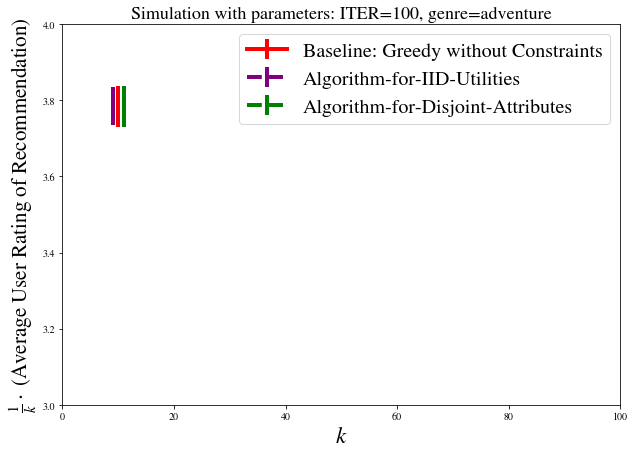

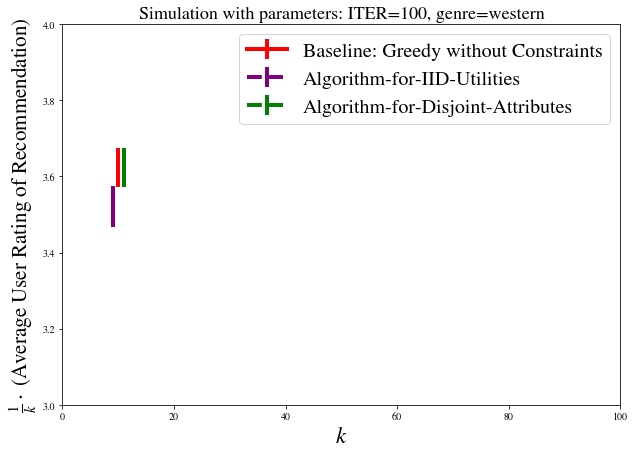

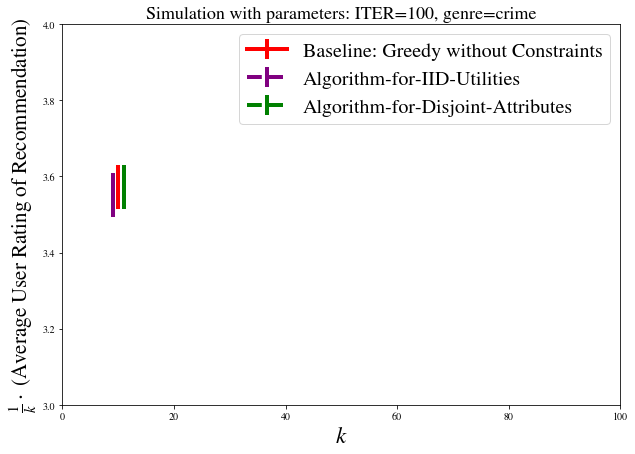

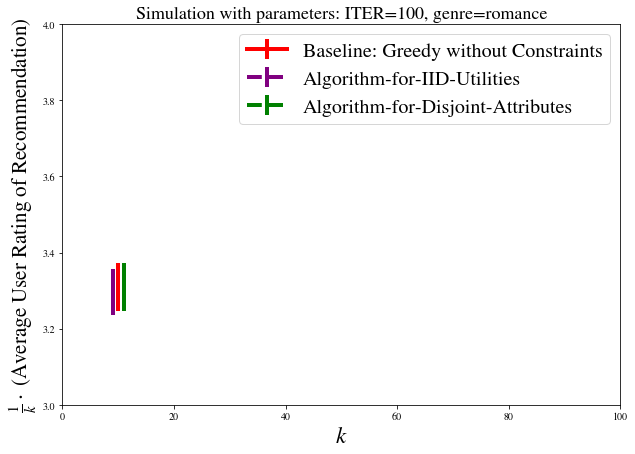

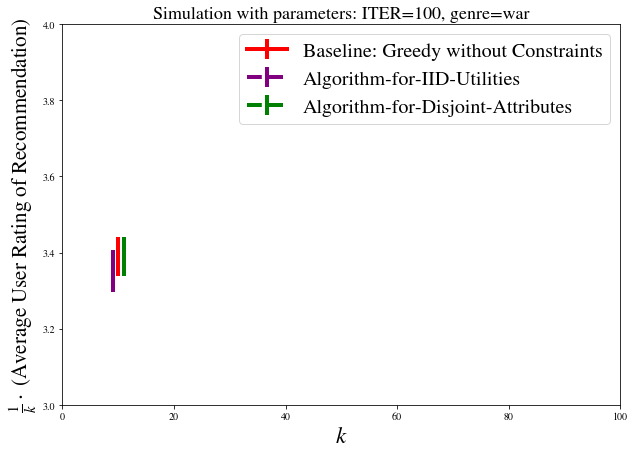

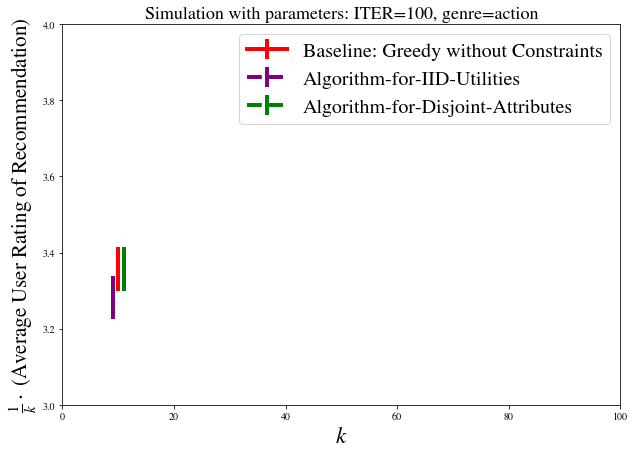

In [141]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# romance 0
# war 12
# action 13
# adventure 15
# western 16
# crime 19

for gen in [15, 16, 19, 0, 12, 13]:
    weight_F = np.zeros(20)
    weight_F[gen] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []
    
    x = []
    
    print(f'Genre: {genres[gen]}')

    for k in [10]: #[10, 50, 100]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        user_draws = rng.choice(len(selected_users), ITERS)

        for ijk in tqdm(range(ITERS)):
            u_id = selected_users[user_draws[ijk]]

            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)

            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating(sol_baseline_greedy_uncons, u_id, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating(sol_algo_2_greedy_cons, u_id, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating(sol_algo_3_disjoint_attr, u_id, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            print('#'*15 + f' iteration {ijk} ' + '#'*15)
            print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
            print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
            print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
            print('#'*50)
            
        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(ITERS))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(ITERS))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(ITERS))
        
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[gen]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

In [142]:
import os
os.system("ls")

0

In [164]:
[genres[g] for g in [15, 16, 19, 12, 13]]

['adventure', 'western', 'crime', 'war', 'action']

In [161]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# romance 0
# war 12
# action 13
# adventure 15
# western 16
# crime 19

# for gen in itertools.product([15, 16, 19, 12, 13], repeat=3):
weight_F = np.zeros(20)
for g in [16, 19, 12, 13, 15]: 
    weight_F[g] = 1

LIST_baseline_greedy_uncons_OUTER = []
LIST_algo_2_greedy_cons_OUTER = []
LIST_algo_3_disjoint_attr_OUTER = []

ERR_LIST_baseline_greedy_uncons_OUTER = []
ERR_LIST_algo_2_greedy_cons_OUTER = []
ERR_LIST_algo_3_disjoint_attr_OUTER = []

x = []

print(f'Genre: {[genres[g] for g in [15, 16, 19, 12, 13]]}')

for k in [100]: #[10, 50, 100]: #[10, 25, 50, 75, 100]:
    list_baseline_greedy_uncons = []
    list_algo_2_greedy_cons = []
    list_algo_3_disjoint_attr = []
    user_draws = rng.choice(len(selected_users), 10*ITERS)

    ijk = -1
    while len(list_algo_3_disjoint_attr) < ITERSr and ijk < 10*ITERS:
        ijk += 1
#     for ijk in tqdm(range(ITERS)):
        u_id = selected_users[user_draws[ijk]]


        m_inds = get_rated_movie_indices(u_id)

        m_ind_to_i = {}
        for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

        n = len(m_inds)
        m = len(genres_matching_tags)
        assert(n>=k)

        obs_util = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                m_ind = m_inds[i]
                g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

        # grps
        grps_int = [[], []]
        for i in range(n):
            m_ind = m_inds[i]

            if m_ind in grps_set[0]:
                grps_int[0].append(i)
            elif m_ind in grps_set[1]:
                grps_int[1].append(i)
            else:
                assert(False)
                
        if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
            continue 
        if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
            continue 
        

        # run algorithms and baselines
        sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
        sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
        sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

        util_baseline_greedy_uncons = get_score_rating(sol_baseline_greedy_uncons, u_id, m_inds, m_ind_to_i) / k
        util_algo_2_greedy_cons = get_score_rating(sol_algo_2_greedy_cons, u_id, m_inds, m_ind_to_i) / k
        util_algo_3_disjoint_attr = get_score_rating(sol_algo_3_disjoint_attr, u_id, m_inds, m_ind_to_i) / k

        list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
        list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
        list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

        print('#'*15 + f' iteration {ijk} ' + '#'*15)
        print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
        print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
        print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
        print('#'*50)

    x.append(k)

    LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
    LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
    LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

    ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))

x = np.array(x)
y1 = LIST_baseline_greedy_uncons_OUTER
y4 = LIST_algo_2_greedy_cons_OUTER
y5 = LIST_algo_3_disjoint_attr_OUTER

y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[gen]}', fontsize=18)
plt.ylim(3, 4)
plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)

# plt.show()
pdf_savefig()

Genre: ['adventure', 'western', 'crime', 'war', 'action']
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.47, 0.0
util_algo_2_greedy_cons: 3.43, 0.0
util_algo_3_disjoint_attr: 3.63, 0.0
##################################################
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.255, 0.15202795795510776
util_algo_2_greedy_cons: 3.215, 0.15202795795510776
util_algo_3_disjoint_attr: 3.41, 0.15556349186104043
##################################################
max: 5.0, min: 2.0
max: 5.0, min: 3.0
max: 5.0, min: 1.5
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.5683333333333334, 0.2751800757214703
util_algo_2_greedy_cons: 3.5383333333333327, 0.2827870550759325
util_algo_3_disjoint_attr: 3.646666666666667, 0.21930867811442464
##################################################
max: 5.0, min: 1

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.637884615384615, 0.0763445422601283
util_algo_2_greedy_cons: 3.632307692307692, 0.07783033757750452
util_algo_3_disjoint_attr: 3.6667307692307696, 0.06881549720734713
##################################################
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.6381481481481477, 0.07351742146217029
util_algo_2_greedy_cons: 3.6327777777777777, 0.07494915209721487
util_algo_3_disjoint_attr: 3.663148148148148, 0.06635996743256256
##################################################
max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 1.0
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.610178571428571, 0.07602634568820615
util_algo_2_greedy_cons: 3.6044642857142857, 0.07743592614883414
util_algo_3_disjoint_attr: 3.6405357142857144, 0.067733128823

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 111 ###############
util_baseline_greedy_uncons: 3.5987000000000005, 0.062033508686837956
util_algo_2_greedy_cons: 3.5959000000000003, 0.06253106268087885
util_algo_3_disjoint_attr: 3.6304999999999996, 0.058732146223341775
##################################################
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 116 ###############
util_baseline_greedy_uncons: 3.588725490196079, 0.06161385923392014
util_algo_2_greedy_cons: 3.5853921568627456, 0.062181575333706746
util_algo_3_disjoint_attr: 3.6199019607843135, 0.05852891749324559
##################################################
max: 4.5, min: 1.5
max: 4.5, min: 1.5
max: 4.5, min: 2.0
############### iteration 119 ###############
util_baseline_greedy_uncons: 3.587403846153847, 0.06044315058282653
util_algo_2_greedy_cons: 3.584134615384616, 0.060998490552949584
util_algo_3_disjoint_attr: 3.617884615384615, 0.0574

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 186 ###############
util_baseline_greedy_uncons: 3.585945945945946, 0.04933317910852636
util_algo_2_greedy_cons: 3.589324324324324, 0.04917139605460815
util_algo_3_disjoint_attr: 3.6167567567567565, 0.04734875891802999
##################################################
max: 4.5, min: 0.5
max: 4.5, min: 0.5
max: 4.5, min: 0.5
############### iteration 190 ###############
util_baseline_greedy_uncons: 3.570933333333333, 0.05090843137619921
util_algo_2_greedy_cons: 3.574266666666666, 0.050768992578220484
util_algo_3_disjoint_attr: 3.601933333333333, 0.04898288983202498
##################################################
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 191 ###############
util_baseline_greedy_uncons: 3.575131578947368, 0.05041139391509662
util_algo_2_greedy_cons: 3.5789473684210518, 0.05031628803546503
util_algo_3_disjoint_attr: 3.6075657894736834, 0.048661133

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 249 ###############
util_baseline_greedy_uncons: 3.5757653061224492, 0.043353980655719056
util_algo_2_greedy_cons: 3.5742857142857147, 0.04317176787003947
util_algo_3_disjoint_attr: 3.600459183673469, 0.040889799097255805
##################################################
max: 5.0, min: 0.5
max: 5.0, min: 1.5
max: 5.0, min: 0.5
############### iteration 251 ###############
util_baseline_greedy_uncons: 3.5754545454545457, 0.04291717540859357
util_algo_2_greedy_cons: 3.5741919191919194, 0.04273579129631517
util_algo_3_disjoint_attr: 3.5975252525252523, 0.04058189225842518
##################################################
max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 2.0
############### iteration 252 ###############
util_baseline_greedy_uncons: 3.5823, 0.04303047873310266
util_algo_2_greedy_cons: 3.58095, 0.04283944998479789
util_algo_3_disjoint_attr: 3.6029499999999994, 0.04053702597626027
########

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 316 ###############
util_baseline_greedy_uncons: 3.597008196721312, 0.03972957076013304
util_algo_2_greedy_cons: 3.5952459016393443, 0.039406194956513374
util_algo_3_disjoint_attr: 3.6191393442622948, 0.03693128695843191
##################################################
max: 5.0, min: 2.0
max: 5.0, min: 2.0
max: 5.0, min: 2.0
############### iteration 323 ###############
util_baseline_greedy_uncons: 3.595975609756098, 0.03941998250394538
util_algo_2_greedy_cons: 3.5940243902439026, 0.03910474698151303
util_algo_3_disjoint_attr: 3.6179268292682925, 0.03665093162047204
##################################################
max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 1.0
############### iteration 325 ###############
util_baseline_greedy_uncons: 3.593911290322581, 0.03915609356644348
util_algo_2_greedy_cons: 3.5913306451612903, 0.03888205524138005
util_algo_3_disjoint_attr: 3.6180645161290323, 0.036355

max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 388 ###############
util_baseline_greedy_uncons: 3.6009589041095893, 0.035385921405718515
util_algo_2_greedy_cons: 3.5991438356164376, 0.03503514573187806
util_algo_3_disjoint_attr: 3.616883561643836, 0.033125313667083794
##################################################
max: 5.0, min: 1.5
max: 5.0, min: 1.5
max: 5.0, min: 1.5
############### iteration 391 ###############
util_baseline_greedy_uncons: 3.5994557823129254, 0.03517711114005521
util_algo_2_greedy_cons: 3.5973469387755097, 0.034842860925548155
util_algo_3_disjoint_attr: 3.6153061224489798, 0.03293750908984652
##################################################
max: 5.0, min: 1.0
max: 5.0, min: 1.0
max: 5.0, min: 1.0
############### iteration 393 ###############
util_baseline_greedy_uncons: 3.6058108108108113, 0.03550883174865188
util_algo_2_greedy_cons: 3.6036148648648636, 0.03516668999303931
util_algo_3_disjoint_attr: 3.621689189189189, 0.033

max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 456 ###############
util_baseline_greedy_uncons: 3.606088235294118, 0.0323497451236707
util_algo_2_greedy_cons: 3.605352941176471, 0.03204847583867808
util_algo_3_disjoint_attr: 3.6190588235294117, 0.030575194851373735
##################################################
max: 5.0, min: 3.0
max: 5.0, min: 3.0
max: 5.0, min: 3.0
############### iteration 462 ###############
util_baseline_greedy_uncons: 3.608684210526316, 0.03226455702052646
util_algo_2_greedy_cons: 3.6079532163742694, 0.03196637136079892
util_algo_3_disjoint_attr: 3.6217543859649117, 0.030514983940170545
##################################################
max: 5.0, min: 0.5
max: 5.0, min: 0.5
max: 5.0, min: 0.5
############### iteration 468 ###############
util_baseline_greedy_uncons: 3.6093023255813956, 0.032082892675104974
util_algo_2_greedy_cons: 3.6080813953488375, 0.03178077734994073
util_algo_3_disjoint_attr: 3.622383720930232, 0.030344

KeyboardInterrupt: 

In [ ]:
# Genre: ['adventure', 'western', 'crime', 'war', 'action']
# ############### iteration 462 ###############
# util_baseline_greedy_uncons: 3.608684210526316, 0.03226455702052646
# util_algo_2_greedy_cons: 3.6079532163742694, 0.03196637136079892
# util_algo_3_disjoint_attr: 3.6217543859649117, 0.030514983940170545
# ##################################################

In [ ]:
action 1
adventure 2
crime 6
romance 15
war 18
western 19

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: 5.0, min: 1.0
score-mean=3.58 and score-std=1.401285124448269
[3.0, 4.0, 3.0, 4.0, 2.0, 1.0, 1.0, 2.0, 5.0, 1.0, 2.0, 5.0, 5.0, 2.0, 5.0, 5.0, 1.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 3.0, 5.0, 2.0, 5.0, 1.0, 3.0, 2.0, 5.0, 3.0, 3.0, 4.0, 4.0, 3.0, 5.0, 1.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0]
max: 5.0, min: 1.0
score-mean=3.46 and score-std=1.41718029904455
[3.0, 4.0, 3.0, 4.0, 3.0, 2.0, 1.0, 1.0, 5.0, 3.0, 3.0, 1.0, 2.0, 5.0, 1.0, 5.0, 2.0, 5.0, 1.0, 3.0, 4.0, 5.0, 3.0, 3.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, 3.0, 5.0, 2.0, 3.0, 5.0, 1.0, 3.0, 2.0, 5.0, 3.0, 3.0, 5.0, 4.0, 4.0, 5.0, 5.0, 1.0, 5.0, 5.0, 5.0]
max: 5.0, min: 1.0
score-mean=3.46 and score-std=1.3741906709041507
[3.0, 4.0, 3.0, 1.0, 1.0, 5.0, 3.0, 5.0, 1.0, 2.0, 3.0, 5.0, 3.0, 5.0, 2.0, 2.0, 5.0, 1.0, 3.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 2.0, 3.0, 5.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 1.0, 5.0, 5.0, 5.0

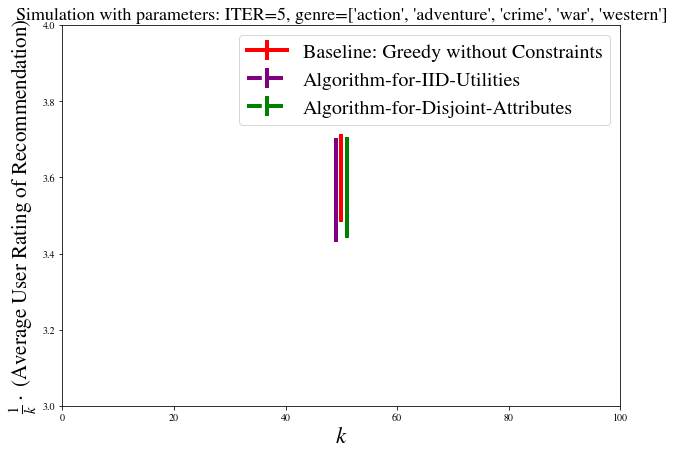

In [80]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 5

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

weight_F = np.zeros(20)
for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

LIST_baseline_greedy_uncons_OUTER = []
LIST_algo_2_greedy_cons_OUTER = []
LIST_algo_3_disjoint_attr_OUTER = []

ERR_LIST_baseline_greedy_uncons_OUTER = []
ERR_LIST_algo_2_greedy_cons_OUTER = []
ERR_LIST_algo_3_disjoint_attr_OUTER = []

x = []

print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

for k in [50]: #[10, 50, 100]: #[10, 25, 50, 75, 100]:
    list_baseline_greedy_uncons = []
    list_algo_2_greedy_cons = []
    list_algo_3_disjoint_attr = []
    user_draws = rng.choice(len(selected_users), 10*ITERS)

    ijk = -1
    while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
        ijk += 1
#     for ijk in tqdm(range(ITERS)):
        u_id = selected_users[user_draws[ijk]]


        m_inds = get_rated_movie_indices(u_id)

        m_ind_to_i = {}
        for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

        n = len(m_inds)
        m = len(genres_matching_tags)
        assert(n>=k)

        obs_util = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                m_ind = m_inds[i]
                g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

        # grps
        grps_int = [[], []]
        for i in range(n):
            m_ind = m_inds[i]

            if m_ind in grps_set[0]:
                grps_int[0].append(i)
            elif m_ind in grps_set[1]:
                grps_int[1].append(i)
            else:
                assert(False)
                
        if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
            continue 
        if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
            continue 
        

        # run algorithms and baselines
        sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
        sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
        sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

        util_baseline_greedy_uncons = get_score_rating(sol_baseline_greedy_uncons, u_id, m_inds, m_ind_to_i) / k
        util_algo_2_greedy_cons = get_score_rating(sol_algo_2_greedy_cons, u_id, m_inds, m_ind_to_i) / k
        util_algo_3_disjoint_attr = get_score_rating(sol_algo_3_disjoint_attr, u_id, m_inds, m_ind_to_i) / k

        list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
        list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
        list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

        print('#'*15 + f' iteration {ijk} ' + '#'*15)
        print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
        print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
        print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
        print('#'*50)

    x.append(k)

    LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
    LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
    LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

    ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))

x = np.array(x)
y1 = LIST_baseline_greedy_uncons_OUTER
y4 = LIST_algo_2_greedy_cons_OUTER
y5 = LIST_algo_3_disjoint_attr_OUTER

y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



plt.title(f'Simulation with parameters: ITER={ITERS}, genre={[genres[g] for g in [1, 2, 6, 18, 19]]}', fontsize=18)
plt.ylim(3, 4)
plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)

# plt.show()
pdf_savefig()

In [100]:
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('simulation-utils.py').read())

### Exact user rating for each movie

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=3.7382293131218955 and score-std=0.3447003061487841
max: -1, min: 100000000.0
score-mean=3.7040102687107077 and score-std=0.36386903658606157
max: -1, min: 100000000.0
score-mean=3.7580893274583413 and score-std=0.3419698006753587
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.7382293131218955, 0.0
util_algo_2_greedy_cons: 3.7040102687107077, 0.0
util_algo_3_disjoint_attr: 3.7580893274583413, 0.0
##################################################
max: -1, min: 100000000.0
score-mean=3.603772393628505 and score-std=0.5061571666339957
max: -1, min: 100000000.0
score-mean=3.619262436192317 and score-std=0.4830837374864258
max: -1, min: 100000000.0
score-mean=3.619079249800328 and score-std=0.4535963295459804
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.6710008533752, 0.04753769977561503
util_algo_2_greedy_cons: 3.661636352451512, 0.029962

max: -1, min: 100000000.0
score-mean=3.5944800696884975 and score-std=0.2923030257356941
max: -1, min: 100000000.0
score-mean=3.604182197888558 and score-std=0.2970152270938867
max: -1, min: 100000000.0
score-mean=3.5893968558373657 and score-std=0.44042159522042523
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.6013451784833803, 0.02266972019782814
util_algo_2_greedy_cons: 3.5965369831252874, 0.022208852496519244
util_algo_3_disjoint_attr: 3.607430114092742, 0.020649294646809754
##################################################
max: -1, min: 100000000.0
score-mean=3.4580232084804265 and score-std=0.4533543556889057
max: -1, min: 100000000.0
score-mean=3.496408366169326 and score-std=0.46616027610517446
max: -1, min: 100000000.0
score-mean=3.5861773533014194 and score-std=0.4236572403646186
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.5929144743655597, 0.02285015371809998
util_algo_2_greedy_cons: 3.590647064480819, 0.02166939

max: -1, min: 100000000.0
score-mean=3.7262467967870117 and score-std=0.3265605235476142
max: -1, min: 100000000.0
score-mean=3.6412974315043702 and score-std=0.4829563108874001
max: -1, min: 100000000.0
score-mean=3.68183966196011 and score-std=0.3537485880587006
############### iteration 84 ###############
util_baseline_greedy_uncons: 3.608787131983875, 0.01926729188993885
util_algo_2_greedy_cons: 3.595830799783411, 0.0180990569908423
util_algo_3_disjoint_attr: 3.6164492158397508, 0.017523388543139215
##################################################
max: -1, min: 100000000.0
score-mean=3.762487256985086 and score-std=0.32336991100252305
max: -1, min: 100000000.0
score-mean=3.7460840764846903 and score-std=0.31825479293839504
max: -1, min: 100000000.0
score-mean=3.7787046471049437 and score-std=0.2713538815024761
############### iteration 85 ###############
util_baseline_greedy_uncons: 3.6135902608901627, 0.019254568013964392
util_algo_2_greedy_cons: 3.6005262146803254, 0.0181322978

max: -1, min: 100000000.0
score-mean=3.4229107475827516 and score-std=0.45927813736747447
max: -1, min: 100000000.0
score-mean=3.4435099371366875 and score-std=0.423735123672242
max: -1, min: 100000000.0
score-mean=3.428534512450719 and score-std=0.45009092061575906
############### iteration 126 ###############
util_baseline_greedy_uncons: 3.6119312893786617, 0.0166367435692623
util_algo_2_greedy_cons: 3.6002013895137814, 0.015591829086169753
util_algo_3_disjoint_attr: 3.6227132132171915, 0.014854962128207364
##################################################
max: -1, min: 100000000.0
score-mean=3.459372449452196 and score-std=0.37727913435524996
max: -1, min: 100000000.0
score-mean=3.4593724494521956 and score-std=0.37727913435524996
max: -1, min: 100000000.0
score-mean=3.5989754178081945 and score-std=0.2836264022070642
############### iteration 128 ###############
util_baseline_greedy_uncons: 3.6086853566142687, 0.01659640070342562
util_algo_2_greedy_cons: 3.597205029086939, 0.01554

max: -1, min: 100000000.0
score-mean=3.5777205713763056 and score-std=0.33527432017094205
max: -1, min: 100000000.0
score-mean=3.503875984328879 and score-std=0.33262299283879193
max: -1, min: 100000000.0
score-mean=3.561986521803027 and score-std=0.380245061026406
############### iteration 187 ###############
util_baseline_greedy_uncons: 3.60837387830164, 0.014058067646789048
util_algo_2_greedy_cons: 3.5907129738967, 0.014017579506407064
util_algo_3_disjoint_attr: 3.6204750934514136, 0.012951114644508814
##################################################
max: -1, min: 100000000.0
score-mean=3.888895909180607 and score-std=0.257514035331119
max: -1, min: 100000000.0
score-mean=3.867918726434474 and score-std=0.26844143409869753
max: -1, min: 100000000.0
score-mean=3.8432789034430637 and score-std=0.3251390529112297
############### iteration 188 ###############
util_baseline_greedy_uncons: 3.6128984271867846, 0.014541213745523182
util_algo_2_greedy_cons: 3.595184034421503, 0.01448699898

max: -1, min: 100000000.0
score-mean=3.618424502902712 and score-std=0.35198866617037994
max: -1, min: 100000000.0
score-mean=3.6089569810673434 and score-std=0.37000391026120716
max: -1, min: 100000000.0
score-mean=3.624791386453794 and score-std=0.31999992126891164
############### iteration 216 ###############
util_baseline_greedy_uncons: 3.606771127486728, 0.014263137785126967
util_algo_2_greedy_cons: 3.586722529651137, 0.014481238397382152
util_algo_3_disjoint_attr: 3.6202754066801397, 0.012649037883852843
##################################################
max: -1, min: 100000000.0
score-mean=3.787862323200681 and score-std=0.40086143816478437
max: -1, min: 100000000.0
score-mean=3.7683820048214614 and score-std=0.42583866860248326
max: -1, min: 100000000.0
score-mean=3.7907730617003845 and score-std=0.4078072494525315
############### iteration 222 ###############
util_baseline_greedy_uncons: 3.609122961197299, 0.014270480728909733
util_algo_2_greedy_cons: 3.5890817436143876, 0.014

max: -1, min: 100000000.0
score-mean=3.484173684053798 and score-std=0.4016198574294187
max: -1, min: 100000000.0
score-mean=3.481097663887206 and score-std=0.418027738785988
max: -1, min: 100000000.0
score-mean=3.628057147535729 and score-std=0.38704235392946995
############### iteration 261 ###############
util_baseline_greedy_uncons: 3.601963876986517, 0.013713883369046413
util_algo_2_greedy_cons: 3.5816884737666586, 0.013917013083520991
util_algo_3_disjoint_attr: 3.6224962076115204, 0.011424377405420343
##################################################
max: -1, min: 100000000.0
score-mean=3.478950087710841 and score-std=0.4670676344007249
max: -1, min: 100000000.0
score-mean=3.42010872973139 and score-std=0.47285466092597683
max: -1, min: 100000000.0
score-mean=3.4195151246592816 and score-std=0.4596126671410686
############### iteration 265 ###############
util_baseline_greedy_uncons: 3.6006267705813464, 0.013629847623087195
util_algo_2_greedy_cons: 3.5799321722010577, 0.01387611

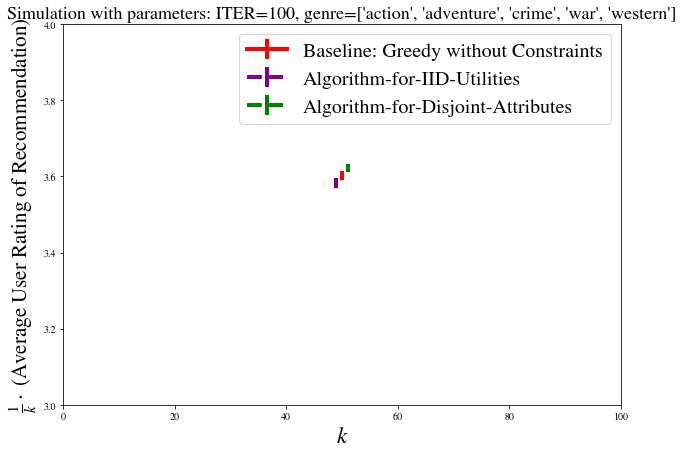

In [102]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

weight_F = np.zeros(20)
for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

LIST_baseline_greedy_uncons_OUTER = []
LIST_algo_2_greedy_cons_OUTER = []
LIST_algo_3_disjoint_attr_OUTER = []

ERR_LIST_baseline_greedy_uncons_OUTER = []
ERR_LIST_algo_2_greedy_cons_OUTER = []
ERR_LIST_algo_3_disjoint_attr_OUTER = []

x = []

print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

for k in [50]: #[10, 50, 100]: #[10, 25, 50, 75, 100]:
    list_baseline_greedy_uncons = []
    list_algo_2_greedy_cons = []
    list_algo_3_disjoint_attr = []
    user_draws = rng.choice(len(selected_users), 10*ITERS)

    ijk = -1
    while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
        ijk += 1
#     for ijk in tqdm(range(ITERS)):
        u_id = selected_users[user_draws[ijk]]


        m_inds = get_rated_movie_indices(u_id)

        m_ind_to_i = {}
        for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

        n = len(m_inds)
        m = len(genres_matching_tags)
        assert(n>=k)

        obs_util = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                m_ind = m_inds[i]
                g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

        # grps
        grps_int = [[], []]
        for i in range(n):
            m_ind = m_inds[i]

            if m_ind in grps_set[0]:
                grps_int[0].append(i)
            elif m_ind in grps_set[1]:
                grps_int[1].append(i)
            else:
                assert(False)
                
        if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
            continue 
        if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
            continue 
        

        # run algorithms and baselines
        sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
        sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
        sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

        util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
        util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
        util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

        list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
        list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
        list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

        print('#'*15 + f' iteration {ijk} ' + '#'*15)
        print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
        print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
        print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
        print('#'*50)

    x.append(k)

    LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
    LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
    LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

    ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))

x = np.array(x)
y1 = LIST_baseline_greedy_uncons_OUTER
y4 = LIST_algo_2_greedy_cons_OUTER
y5 = LIST_algo_3_disjoint_attr_OUTER

y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



plt.title(f'Simulation with parameters: ITER={ITERS}, genre={[genres[g] for g in [1, 2, 6, 18, 19]]}', fontsize=18)
plt.ylim(3, 4)
plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)

# plt.show()
pdf_savefig()

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=3.7258259142866876 and score-std=0.2562151387687191
max: -1, min: 100000000.0
score-mean=3.698502562855537 and score-std=0.28339324854626147
max: -1, min: 100000000.0
score-mean=3.7356690112098967 and score-std=0.22922746112869194
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.7258259142866876, 0.0
util_algo_2_greedy_cons: 3.698502562855537, 0.0
util_algo_3_disjoint_attr: 3.7356690112098967, 0.0
##################################################
max: -1, min: 100000000.0
score-mean=3.6357366548812644 and score-std=0.2780931684078205
max: -1, min: 100000000.0
score-mean=3.6137545122998516 and score-std=0.3216158238587813
max: -1, min: 100000000.0
score-mean=3.4265747194494174 and score-std=0.5147561371558537
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.680781284583976, 0.03185136311882436
util_algo_2_greedy_cons: 3.656128537577694, 0.02

max: -1, min: 100000000.0
score-mean=3.632364381749631 and score-std=0.3302509053889876
max: -1, min: 100000000.0
score-mean=3.692593999700377 and score-std=0.25300048645029133
max: -1, min: 100000000.0
score-mean=3.746902113609528 and score-std=0.3289736206428108
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.6851725312399175, 0.02611079306681568
util_algo_2_greedy_cons: 3.6468892758531335, 0.02774650909570524
util_algo_3_disjoint_attr: 3.6262116661910313, 0.034593146144285665
##################################################
max: -1, min: 100000000.0
score-mean=3.9010719758559818 and score-std=0.13147056996883338
max: -1, min: 100000000.0
score-mean=3.8602827591100484 and score-std=0.17467004169931236
max: -1, min: 100000000.0
score-mean=3.8166974704314027 and score-std=0.29276953890206664
############### iteration 50 ###############
util_baseline_greedy_uncons: 3.6978724985702742, 0.02749046226702684
util_algo_2_greedy_cons: 3.659441833691776, 0.0288141

max: -1, min: 100000000.0
score-mean=3.8507121109867932 and score-std=0.22945965776725702
max: -1, min: 100000000.0
score-mean=3.8562431690649204 and score-std=0.14417676289175835
max: -1, min: 100000000.0
score-mean=3.7835189133181415 and score-std=0.2744893134313852
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.6820133886663324, 0.024220674002878487
util_algo_2_greedy_cons: 3.6507012682362885, 0.023706983878423776
util_algo_3_disjoint_attr: 3.627737365043802, 0.02616910249650446
##################################################
max: -1, min: 100000000.0
score-mean=3.7112413465592944 and score-std=0.20130079853976846
max: -1, min: 100000000.0
score-mean=3.71789668253387 and score-std=0.16667476950242258
max: -1, min: 100000000.0
score-mean=3.6367340860112796 and score-std=0.21057960784420124
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.6829267623504878, 0.023480993513033295
util_algo_2_greedy_cons: 3.652801124933088, 0.0230

max: -1, min: 100000000.0
score-mean=3.7727850832163554 and score-std=0.23021021131252753
max: -1, min: 100000000.0
score-mean=3.798195156785867 and score-std=0.23616876509039147
max: -1, min: 100000000.0
score-mean=3.7996454981318406 and score-std=0.2422825431536739
############### iteration 122 ###############
util_baseline_greedy_uncons: 3.691808984468938, 0.01851494457961888
util_algo_2_greedy_cons: 3.6678913304542062, 0.018868546144142424
util_algo_3_disjoint_attr: 3.643561283411423, 0.02067394568246487
##################################################
max: -1, min: 100000000.0
score-mean=3.5901165406182627 and score-std=0.3392542243401992
max: -1, min: 100000000.0
score-mean=3.549281186328824 and score-std=0.4283943316404841
max: -1, min: 100000000.0
score-mean=3.3762564041748453 and score-std=0.34723437001993673
############### iteration 125 ###############
util_baseline_greedy_uncons: 3.6896453154508384, 0.01824699554775382
util_algo_2_greedy_cons: 3.665367710366432, 0.0186350

max: -1, min: 100000000.0
score-mean=3.535634892121076 and score-std=0.3402795901349143
max: -1, min: 100000000.0
score-mean=3.5353799136877293 and score-std=0.29769033244684356
max: -1, min: 100000000.0
score-mean=3.6738279854473093 and score-std=0.32571119062897785
############### iteration 164 ###############
util_baseline_greedy_uncons: 3.6845325910292064, 0.017121729976142402
util_algo_2_greedy_cons: 3.661748409152508, 0.01805092547368401
util_algo_3_disjoint_attr: 3.6435991274327693, 0.018883677043908333
##################################################
max: -1, min: 100000000.0
score-mean=3.837255238829384 and score-std=0.31120896808587745
max: -1, min: 100000000.0
score-mean=3.7420316457103673 and score-std=0.27168465706229816
max: -1, min: 100000000.0
score-mean=3.6580104224573162 and score-std=0.3404010698395695
############### iteration 175 ###############
util_baseline_greedy_uncons: 3.686995859542112, 0.017021843520945774
util_algo_2_greedy_cons: 3.6630433000647318, 0.017

max: -1, min: 100000000.0
score-mean=3.852956747280179 and score-std=0.1318055960921151
max: -1, min: 100000000.0
score-mean=3.8940643855787513 and score-std=0.15731948078175198
max: -1, min: 100000000.0
score-mean=3.9162403049201857 and score-std=0.16453306011168203
############### iteration 220 ###############
util_baseline_greedy_uncons: 3.6903150247186134, 0.015078877128508781
util_algo_2_greedy_cons: 3.6680869413754973, 0.015987007126423015
util_algo_3_disjoint_attr: 3.6492930206702656, 0.017116786172603086
##################################################
max: -1, min: 100000000.0
score-mean=3.5914298527646267 and score-std=0.18201344067003122
max: -1, min: 100000000.0
score-mean=3.557262903449518 and score-std=0.18188254040796226
max: -1, min: 100000000.0
score-mean=3.5937837746955843 and score-std=0.19954795440965103
############### iteration 228 ###############
util_baseline_greedy_uncons: 3.689030801706224, 0.014937634174361307
util_algo_2_greedy_cons: 3.666647668155679, 0.0

max: -1, min: 100000000.0
score-mean=3.768714301154848 and score-std=0.12908593836286789
max: -1, min: 100000000.0
score-mean=3.7640459321540676 and score-std=0.12946986865695212
max: -1, min: 100000000.0
score-mean=3.7968468545747576 and score-std=0.1765175490676738
############### iteration 272 ###############
util_baseline_greedy_uncons: 3.6942799231172, 0.013153610818937215
util_algo_2_greedy_cons: 3.673092850025039, 0.014022042285400297
util_algo_3_disjoint_attr: 3.6562780783987674, 0.015306579642968127
##################################################
max: -1, min: 100000000.0
score-mean=3.6268254399410003 and score-std=0.3128853572617274
max: -1, min: 100000000.0
score-mean=3.656784557175186 and score-std=0.28604402972057785
max: -1, min: 100000000.0
score-mean=3.592748567038057 and score-std=0.3476588248884349
############### iteration 274 ###############
util_baseline_greedy_uncons: 3.6935467222131106, 0.013031055594352513
util_algo_2_greedy_cons: 3.672915585972323, 0.0138707

max: -1, min: 100000000.0
score-mean=4.007499974050179 and score-std=0.1806846905768298
max: -1, min: 100000000.0
score-mean=4.023484578246528 and score-std=0.19385672097527382
max: -1, min: 100000000.0
score-mean=4.0221230020925445 and score-std=0.18755433996013576
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.648281124962415, 0.07689051046270115
util_algo_2_greedy_cons: 3.629824671998238, 0.08538320591271976
util_algo_3_disjoint_attr: 3.6218066828321285, 0.07626737349867374
##################################################
max: -1, min: 100000000.0
score-mean=3.7232441341786786 and score-std=0.32038368379052473
max: -1, min: 100000000.0
score-mean=3.6455171280777425 and score-std=0.4643077415922082
max: -1, min: 100000000.0
score-mean=3.704900353612906 and score-std=0.3079679378432544
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.6589901262790243, 0.06664773299543282
util_algo_2_greedy_cons: 3.6320664514381673, 0.0732150286

max: -1, min: 100000000.0
score-mean=3.625106620529125 and score-std=0.4029346266577002
max: -1, min: 100000000.0
score-mean=3.607580514429576 and score-std=0.38733364722928515
max: -1, min: 100000000.0
score-mean=3.600043085412245 and score-std=0.33987273305517307
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.6454618898938365, 0.031802602104201855
util_algo_2_greedy_cons: 3.6389460911856926, 0.03278376495983185
util_algo_3_disjoint_attr: 3.648697741115985, 0.02937802238172223
##################################################
max: -1, min: 100000000.0
score-mean=3.785079123824506 and score-std=0.2826607938633958
max: -1, min: 100000000.0
score-mean=3.771551857451588 and score-std=0.285737527801555
max: -1, min: 100000000.0
score-mean=3.7964931784009845 and score-std=0.2631424760501448
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.6518081277997756, 0.030983758528386546
util_algo_2_greedy_cons: 3.6449736260159606, 0.03184287633

max: -1, min: 100000000.0
score-mean=3.3476945123158193 and score-std=0.5101513023557558
max: -1, min: 100000000.0
score-mean=3.347630008549164 and score-std=0.5150613658767175
max: -1, min: 100000000.0
score-mean=3.3279627187818517 and score-std=0.47820003757213153
############### iteration 122 ###############
util_baseline_greedy_uncons: 3.654601301633255, 0.026990121981363732
util_algo_2_greedy_cons: 3.6457774741965725, 0.027891371490831054
util_algo_3_disjoint_attr: 3.6603654295443215, 0.02493721803946811
##################################################
max: -1, min: 100000000.0
score-mean=3.474801946784749 and score-std=0.42631584036361087
max: -1, min: 100000000.0
score-mean=3.3968358755982035 and score-std=0.5258357880126974
max: -1, min: 100000000.0
score-mean=3.394272037938225 and score-std=0.4548253322902917
############### iteration 125 ###############
util_baseline_greedy_uncons: 3.649741859610322, 0.02669453462261019
util_algo_2_greedy_cons: 3.6390493228831033, 0.0279372

max: -1, min: 100000000.0
score-mean=3.4317356620891046 and score-std=0.5151269382603022
max: -1, min: 100000000.0
score-mean=3.3865618633714267 and score-std=0.5327078830325129
max: -1, min: 100000000.0
score-mean=3.4224552563685675 and score-std=0.5303526657739077
############### iteration 165 ###############
util_baseline_greedy_uncons: 3.616844780060068, 0.02374339929509898
util_algo_2_greedy_cons: 3.607769416022702, 0.02393618206988823
util_algo_3_disjoint_attr: 3.628398789435227, 0.021413187360206493
##################################################
max: -1, min: 100000000.0
score-mean=3.6171794485764432 and score-std=0.31830707577569883
max: -1, min: 100000000.0
score-mean=3.5810975735872206 and score-std=0.39198918605487687
max: -1, min: 100000000.0
score-mean=3.611883722152326 and score-std=0.3969290662964437
############### iteration 166 ###############
util_baseline_greedy_uncons: 3.6168512159930755, 0.023286796334769308
util_algo_2_greedy_cons: 3.6072564959758657, 0.023481

max: -1, min: 100000000.0
score-mean=3.4848528387253115 and score-std=0.3728521988557201
max: -1, min: 100000000.0
score-mean=3.488882487134061 and score-std=0.3812580307270844
max: -1, min: 100000000.0
score-mean=3.5205215261278777 and score-std=0.3755668886180399
############### iteration 196 ###############
util_baseline_greedy_uncons: 3.610446847875181, 0.019501593939678052
util_algo_2_greedy_cons: 3.600264334627705, 0.020005690016865092
util_algo_3_disjoint_attr: 3.6283825809892907, 0.01735139712399692
##################################################
max: -1, min: 100000000.0
score-mean=3.7046273918388497 and score-std=0.22994363585513852
max: -1, min: 100000000.0
score-mean=3.6970243529903906 and score-std=0.22440920342167464
max: -1, min: 100000000.0
score-mean=3.694166523956765 and score-std=0.2668567453563734
############### iteration 201 ###############
util_baseline_greedy_uncons: 3.6118525276358326, 0.01926111962311989
util_algo_2_greedy_cons: 3.6017085140062526, 0.019759

max: -1, min: 100000000.0
score-mean=3.7175272526921592 and score-std=0.39719611048302705
max: -1, min: 100000000.0
score-mean=3.6811613835622 and score-std=0.4132439330066286
max: -1, min: 100000000.0
score-mean=3.6937797942026656 and score-std=0.3590240427261144
############### iteration 240 ###############
util_baseline_greedy_uncons: 3.6035908232265257, 0.017011124885506178
util_algo_2_greedy_cons: 3.5916826051852198, 0.01742235149201278
util_algo_3_disjoint_attr: 3.6217626763281343, 0.014947783546972506
##################################################
max: -1, min: 100000000.0
score-mean=3.6133979107297964 and score-std=0.32089965652087393
max: -1, min: 100000000.0
score-mean=3.6074426210081496 and score-std=0.3147100134201121
max: -1, min: 100000000.0
score-mean=3.647963096014355 and score-std=0.26820398842318544
############### iteration 242 ###############
util_baseline_greedy_uncons: 3.6037104218546143, 0.016804092563548364
util_algo_2_greedy_cons: 3.5918748005001335, 0.0172

max: -1, min: 100000000.0
score-mean=3.494723237624113 and score-std=0.3495693572042126
max: -1, min: 100000000.0
score-mean=3.4161746574146266 and score-std=0.5190208985849998
max: -1, min: 100000000.0
score-mean=3.5202512480412946 and score-std=0.4166231261673172
############### iteration 290 ###############
util_baseline_greedy_uncons: 3.602670717362931, 0.015033037003426553
util_algo_2_greedy_cons: 3.5895796678204746, 0.015563190950542989
util_algo_3_disjoint_attr: 3.621847100797755, 0.013328328818617938
##################################################
max: -1, min: 100000000.0
score-mean=3.740229371617539 and score-std=0.3843973272241399
max: -1, min: 100000000.0
score-mean=3.7119496217942713 and score-std=0.3969630850697187
max: -1, min: 100000000.0
score-mean=3.748119048862191 and score-std=0.34171816102137326
############### iteration 291 ###############
util_baseline_greedy_uncons: 3.604088847819164, 0.014944796697007521
util_algo_2_greedy_cons: 3.59084121373773, 0.015453791

max: -1, min: 100000000.0
score-mean=3.570946273241436 and score-std=0.40674100841170313
max: -1, min: 100000000.0
score-mean=3.5265614766506586 and score-std=0.4201144878266868
max: -1, min: 100000000.0
score-mean=3.5767164589178964 and score-std=0.3945151503336281
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.522831898749238, 0.042628675695569794
util_algo_2_greedy_cons: 3.5012365861566184, 0.050783870652032756
util_algo_3_disjoint_attr: 3.543684953003256, 0.03808152121997502
##################################################
max: -1, min: 100000000.0
score-mean=3.561498441984365 and score-std=0.45015786011012365
max: -1, min: 100000000.0
score-mean=3.5707203506469227 and score-std=0.4142692590683849
max: -1, min: 100000000.0
score-mean=3.5952739337116486 and score-std=0.38847086016804344
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.5260541106854983, 0.03919787699281661
util_algo_2_greedy_cons: 3.507026899864144, 0.04688082

max: -1, min: 100000000.0
score-mean=3.5246532590841206 and score-std=0.3610542518305697
max: -1, min: 100000000.0
score-mean=3.533131803856126 and score-std=0.36143437376322285
max: -1, min: 100000000.0
score-mean=3.5399344459834463 and score-std=0.39662487919573736
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.5607263910220146, 0.022177610854809328
util_algo_2_greedy_cons: 3.5452549076231175, 0.026532143102371432
util_algo_3_disjoint_attr: 3.5735414381622728, 0.020004541103420186
##################################################
max: -1, min: 100000000.0
score-mean=3.6190418320167392 and score-std=0.3629812363770022
max: -1, min: 100000000.0
score-mean=3.574959204926092 and score-std=0.3642077680357065
max: -1, min: 100000000.0
score-mean=3.6008453075493905 and score-std=0.3692087424797902
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.562886222169967, 0.021461130885736156
util_algo_2_greedy_cons: 3.546355066782487, 0.025572

max: -1, min: 100000000.0
score-mean=3.5505421297894784 and score-std=0.4071764007280607
max: -1, min: 100000000.0
score-mean=3.57261743120626 and score-std=0.41546955440787686
max: -1, min: 100000000.0
score-mean=3.6217346277833466 and score-std=0.3710308265324199
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.5589514327006455, 0.018892760510162254
util_algo_2_greedy_cons: 3.5453750860486477, 0.021167860973050956
util_algo_3_disjoint_attr: 3.578469551607711, 0.01611768731060782
##################################################
max: -1, min: 100000000.0
score-mean=3.8089929707303587 and score-std=0.44399235539257
max: -1, min: 100000000.0
score-mean=3.809315114327572 and score-std=0.4445168009957001
max: -1, min: 100000000.0
score-mean=3.797979204983781 and score-std=0.44045130205226996
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.564904802653734, 0.019358215703399646
util_algo_2_greedy_cons: 3.5516593724362413, 0.02157654399

max: -1, min: 100000000.0
score-mean=3.547526222785775 and score-std=0.40597006544756725
max: -1, min: 100000000.0
score-mean=3.5560785980747194 and score-std=0.421346044483358
max: -1, min: 100000000.0
score-mean=3.5593302268189126 and score-std=0.396921042183823
############### iteration 143 ###############
util_baseline_greedy_uncons: 3.569279677539306, 0.0164723968233704
util_algo_2_greedy_cons: 3.5566200988884193, 0.017707549744684907
util_algo_3_disjoint_attr: 3.5908970082002365, 0.013771711180939512
##################################################
max: -1, min: 100000000.0
score-mean=3.5997020282811065 and score-std=0.39372633462933493
max: -1, min: 100000000.0
score-mean=3.5629095454733504 and score-std=0.4209151638951927
max: -1, min: 100000000.0
score-mean=3.580794219856336 and score-std=0.32632268934797143
############### iteration 144 ###############
util_baseline_greedy_uncons: 3.5698134029909165, 0.016192051769723097
util_algo_2_greedy_cons: 3.556730440056576, 0.0173972

max: -1, min: 100000000.0
score-mean=3.8355976837644334 and score-std=0.3692714211320564
max: -1, min: 100000000.0
score-mean=3.8245556904930322 and score-std=0.36350381021800837
max: -1, min: 100000000.0
score-mean=3.8313367582508424 and score-std=0.3625433972173291
############### iteration 188 ###############
util_baseline_greedy_uncons: 3.5626301889879097, 0.016670154056596467
util_algo_2_greedy_cons: 3.5480956041846543, 0.017590308263640202
util_algo_3_disjoint_attr: 3.5829485332293878, 0.01447283949832378
##################################################
max: -1, min: 100000000.0
score-mean=3.286824931963421 and score-std=0.4417415878135505
max: -1, min: 100000000.0
score-mean=3.2779983424445347 and score-std=0.4544042070075968
max: -1, min: 100000000.0
score-mean=3.3333083995542463 and score-std=0.4264819057116645
############### iteration 190 ###############
util_baseline_greedy_uncons: 3.558799560418125, 0.016873004392435227
util_algo_2_greedy_cons: 3.544344253327152, 0.01774

max: -1, min: 100000000.0
score-mean=3.548220336663034 and score-std=0.4797292440799631
max: -1, min: 100000000.0
score-mean=3.5020521008894803 and score-std=0.4829196521478355
max: -1, min: 100000000.0
score-mean=3.555750885362386 and score-std=0.483642226210653
############### iteration 223 ###############
util_baseline_greedy_uncons: 3.558551586568841, 0.016324533070892145
util_algo_2_greedy_cons: 3.544214622372769, 0.017096204083982814
util_algo_3_disjoint_attr: 3.5822124424263193, 0.01394121178696516
##################################################
max: -1, min: 100000000.0
score-mean=3.6252246685244875 and score-std=0.398885182911277
max: -1, min: 100000000.0
score-mean=3.6466242096437225 and score-std=0.37955733501118677
max: -1, min: 100000000.0
score-mean=3.646962956149568 and score-std=0.39215034472916155
############### iteration 225 ###############
util_baseline_greedy_uncons: 3.5593179438326987, 0.016154873113958947
util_algo_2_greedy_cons: 3.5453917440655385, 0.01694017

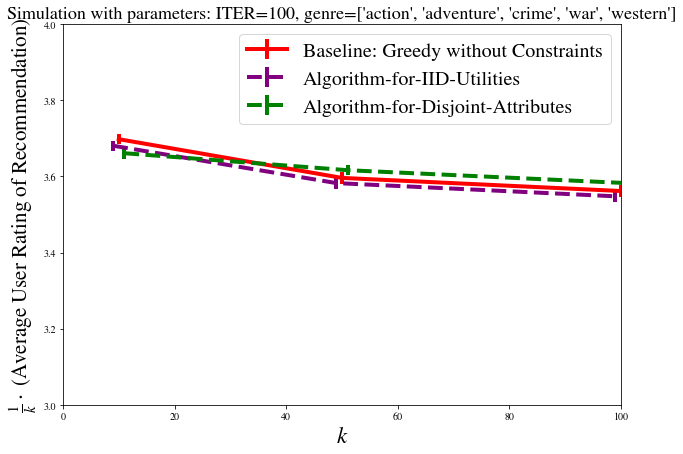

In [103]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

weight_F = np.zeros(20)
for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

LIST_baseline_greedy_uncons_OUTER = []
LIST_algo_2_greedy_cons_OUTER = []
LIST_algo_3_disjoint_attr_OUTER = []

ERR_LIST_baseline_greedy_uncons_OUTER = []
ERR_LIST_algo_2_greedy_cons_OUTER = []
ERR_LIST_algo_3_disjoint_attr_OUTER = []

x = []

print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
    list_baseline_greedy_uncons = []
    list_algo_2_greedy_cons = []
    list_algo_3_disjoint_attr = []
    user_draws = rng.choice(len(selected_users), 10*ITERS)

    ijk = -1
    while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
        ijk += 1
#     for ijk in tqdm(range(ITERS)):
        u_id = selected_users[user_draws[ijk]]


        m_inds = get_rated_movie_indices(u_id)

        m_ind_to_i = {}
        for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

        n = len(m_inds)
        m = len(genres_matching_tags)
        assert(n>=k)

        obs_util = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                m_ind = m_inds[i]
                g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

        # grps
        grps_int = [[], []]
        for i in range(n):
            m_ind = m_inds[i]

            if m_ind in grps_set[0]:
                grps_int[0].append(i)
            elif m_ind in grps_set[1]:
                grps_int[1].append(i)
            else:
                assert(False)
                
        if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
            continue 
        if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
            continue 
        

        # run algorithms and baselines
        sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
        sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
        sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

        util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
        util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
        util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

        list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
        list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
        list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

        print('#'*15 + f' iteration {ijk} ' + '#'*15)
        print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
        print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
        print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
        print('#'*50)

    x.append(k)

    LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
    LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
    LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

    ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))

x = np.array(x)
y1 = LIST_baseline_greedy_uncons_OUTER
y4 = LIST_algo_2_greedy_cons_OUTER
y5 = LIST_algo_3_disjoint_attr_OUTER

y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)

print(f'y1: {y1}')
print(f'y4: {y4}')
print(f'y5: {y5}')
print(f'y1_err: {y1_err}')
print(f'y4_err: {y4_err}')
print(f'y5_err: {y5_err}')

plt.title(f'Simulation with parameters: ITER={ITERS}, genre={[genres[g] for g in [1, 2, 6, 18, 19]]}', fontsize=18)
plt.ylim(3, 4)
plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)

# plt.show()
pdf_savefig()

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=3.7900084983313653 and score-std=0.13241668132098758
max: -1, min: 100000000.0
score-mean=3.8414381310720254 and score-std=0.16461609348789036
max: -1, min: 100000000.0
score-mean=3.7444323879981716 and score-std=0.16040204800685723
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.7900084983313653, 0.0
util_algo_2_greedy_cons: 3.8414381310720254, 0.0
util_algo_3_disjoint_attr: 3.7444323879981716, 0.0
##################################################
max: -1, min: 100000000.0
score-mean=3.7217924299750123 and score-std=0.2335147199294471
max: -1, min: 100000000.0
score-mean=3.7435450566430895 and score-std=0.2290585038136686
max: -1, min: 100000000.0
score-mean=3.4475679407950657 and score-std=0.47327695040406764
############### iteration 7 ###############
util_baseline_greedy_uncons: 3.755900464153189, 0.02411802226033116
util_algo_2_greedy_cons: 3.7924915938575574,

max: -1, min: 100000000.0
score-mean=3.5307756866127575 and score-std=0.47928307409076887
max: -1, min: 100000000.0
score-mean=3.5334177760678935 and score-std=0.44342284309631563
max: -1, min: 100000000.0
score-mean=3.4018422774403363 and score-std=0.5014792695276714
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.6855014418560046, 0.02554951456024487
util_algo_2_greedy_cons: 3.673061893554279, 0.028466629054800057
util_algo_3_disjoint_attr: 3.6374173680738604, 0.037019693934890276
##################################################
max: -1, min: 100000000.0
score-mean=3.765319441276501 and score-std=0.23517451469048764
max: -1, min: 100000000.0
score-mean=3.80597588979003 and score-std=0.1626811658290964
max: -1, min: 100000000.0
score-mean=3.671849675047498 and score-std=0.2599868182927356
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.6901966182925046, 0.024474210929031313
util_algo_2_greedy_cons: 3.680880363921088, 0.02784511

max: -1, min: 100000000.0
score-mean=3.786920721820634 and score-std=0.26687757687204844
max: -1, min: 100000000.0
score-mean=3.72711537458276 and score-std=0.3346595795593455
max: -1, min: 100000000.0
score-mean=3.7697600299084173 and score-std=0.28205557754865873
############### iteration 86 ###############
util_baseline_greedy_uncons: 3.6649009794100866, 0.02991782134369086
util_algo_2_greedy_cons: 3.650368645575015, 0.030872764188427312
util_algo_3_disjoint_attr: 3.621832434880842, 0.031166229316455574
##################################################
max: -1, min: 100000000.0
score-mean=3.6828022364861708 and score-std=0.21471979449213863
max: -1, min: 100000000.0
score-mean=3.6985271140790674 and score-std=0.19741855483278678
max: -1, min: 100000000.0
score-mean=3.666624445643353 and score-std=0.23479503696972748
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.6654603936937145, 0.02898811902056474
util_algo_2_greedy_cons: 3.6518735977157664, 0.0299446

max: -1, min: 100000000.0
score-mean=3.724551912478252 and score-std=0.29877174119125066
max: -1, min: 100000000.0
score-mean=3.572354119567789 and score-std=0.3473457348556832
max: -1, min: 100000000.0
score-mean=3.642519174497049 and score-std=0.2662488447604708
############### iteration 118 ###############
util_baseline_greedy_uncons: 3.6900843769716105, 0.024487224711708014
util_algo_2_greedy_cons: 3.654912656928215, 0.026846480246435024
util_algo_3_disjoint_attr: 3.643912131864443, 0.0269719090181173
##################################################
max: -1, min: 100000000.0
score-mean=3.639442693445602 and score-std=0.32546312324003973
max: -1, min: 100000000.0
score-mean=3.6189518466933337 and score-std=0.3137548970903284
max: -1, min: 100000000.0
score-mean=3.566233326036066 and score-std=0.2541122126933479
############### iteration 119 ###############
util_baseline_greedy_uncons: 3.6890068943433976, 0.023989913820442035
util_algo_2_greedy_cons: 3.654147533306196, 0.0262861792

max: -1, min: 100000000.0
score-mean=3.679447430786054 and score-std=0.30382785929852923
max: -1, min: 100000000.0
score-mean=3.645773820904265 and score-std=0.28563949521888776
max: -1, min: 100000000.0
score-mean=3.5491551534367254 and score-std=0.2560194799395148
############### iteration 163 ###############
util_baseline_greedy_uncons: 3.7029504132101767, 0.020090648846366303
util_algo_2_greedy_cons: 3.661605793685762, 0.021558199813264012
util_algo_3_disjoint_attr: 3.651745689559531, 0.02172600208708234
##################################################
max: -1, min: 100000000.0
score-mean=3.7913535984138376 and score-std=0.18749683163296463
max: -1, min: 100000000.0
score-mean=3.827037610551115 and score-std=0.17378517302738775
max: -1, min: 100000000.0
score-mean=3.698719146662186 and score-std=0.22284997830462422
############### iteration 167 ###############
util_baseline_greedy_uncons: 3.7043762710360424, 0.019817138963598702
util_algo_2_greedy_cons: 3.6642740487964933, 0.0213

max: -1, min: 100000000.0
score-mean=3.715667516388727 and score-std=0.2011936370987446
max: -1, min: 100000000.0
score-mean=3.7142267427184747 and score-std=0.23626008972540874
max: -1, min: 100000000.0
score-mean=3.693822809755203 and score-std=0.21117538482011913
############### iteration 201 ###############
util_baseline_greedy_uncons: 3.705793359587046, 0.016574936603413103
util_algo_2_greedy_cons: 3.6689019337031104, 0.017702639669966796
util_algo_3_disjoint_attr: 3.655500483697949, 0.018186875283950067
##################################################
max: -1, min: 100000000.0
score-mean=3.8540508696329816 and score-std=0.19873736489038574
max: -1, min: 100000000.0
score-mean=3.822133713421608 and score-std=0.17613157337894766
max: -1, min: 100000000.0
score-mean=3.832451202377726 and score-std=0.19766007484724932
############### iteration 202 ###############
util_baseline_greedy_uncons: 3.707718781795435, 0.016471131065398
util_algo_2_greedy_cons: 3.6708919568163383, 0.0175842

max: -1, min: 100000000.0
score-mean=3.7602515831526517 and score-std=0.20487398434364704
max: -1, min: 100000000.0
score-mean=3.776630671712019 and score-std=0.16811237585171282
max: -1, min: 100000000.0
score-mean=3.7370249354373373 and score-std=0.21445359995344243
############### iteration 252 ###############
util_baseline_greedy_uncons: 3.7083553791945896, 0.015039908281524062
util_algo_2_greedy_cons: 3.6792174385398484, 0.01558358762783001
util_algo_3_disjoint_attr: 3.667511092691654, 0.016309429455770776
##################################################
max: -1, min: 100000000.0
score-mean=3.9032649361897698 and score-std=0.10390350060456335
max: -1, min: 100000000.0
score-mean=3.9102678826467043 and score-std=0.16512722311462663
max: -1, min: 100000000.0
score-mean=3.8475753449212298 and score-std=0.2086029337280067
############### iteration 260 ###############
util_baseline_greedy_uncons: 3.710473961335842, 0.0150249060981927
util_algo_2_greedy_cons: 3.681728856410575, 0.0156

max: -1, min: 100000000.0
score-mean=3.6740129912168085 and score-std=0.35757344118259177
max: -1, min: 100000000.0
score-mean=3.6460639680971707 and score-std=0.3816657159825005
max: -1, min: 100000000.0
score-mean=3.7515530564101858 and score-std=0.316556781364149
############### iteration 18 ###############
util_baseline_greedy_uncons: 3.574184625887057, 0.027315679106899783
util_algo_2_greedy_cons: 3.56018650492006, 0.021261211536340887
util_algo_3_disjoint_attr: 3.6171526445229287, 0.041591758507303796
##################################################
max: -1, min: 100000000.0
score-mean=3.567176285659412 and score-std=0.30074304874271074
max: -1, min: 100000000.0
score-mean=3.554646154194299 and score-std=0.324599165288458
max: -1, min: 100000000.0
score-mean=3.6029496320878582 and score-std=0.2784217485220375
############### iteration 19 ###############
util_baseline_greedy_uncons: 3.5731834344259648, 0.023431780200522556
util_algo_2_greedy_cons: 3.559395026244951, 0.0182386216

max: -1, min: 100000000.0
score-mean=3.8173731854865283 and score-std=0.2858946073324874
max: -1, min: 100000000.0
score-mean=3.793510953398018 and score-std=0.29299821113057
max: -1, min: 100000000.0
score-mean=3.790561726461896 and score-std=0.2812737945888342
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.5781951928253024, 0.03193844888953771
util_algo_2_greedy_cons: 3.561968080774963, 0.03464905560894448
util_algo_3_disjoint_attr: 3.613229756305119, 0.030408307208015628
##################################################
max: -1, min: 100000000.0
score-mean=3.63651923239465 and score-std=0.3762107603721081
max: -1, min: 100000000.0
score-mean=3.6299493427528353 and score-std=0.36714827661487903
max: -1, min: 100000000.0
score-mean=3.7100577505807735 and score-std=0.32788175277769266
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.5808462855329997, 0.030596532083502156
util_algo_2_greedy_cons: 3.565058138137594, 0.0332116008015

max: -1, min: 100000000.0
score-mean=3.657044838947298 and score-std=0.2994992964452742
max: -1, min: 100000000.0
score-mean=3.6140664815598535 and score-std=0.3892675275175578
max: -1, min: 100000000.0
score-mean=3.6802318462518935 and score-std=0.3957591848268219
############### iteration 103 ###############
util_baseline_greedy_uncons: 3.588442507849612, 0.023500477518481666
util_algo_2_greedy_cons: 3.5698958463544415, 0.02492049354118404
util_algo_3_disjoint_attr: 3.6170260989403626, 0.022617739588914356
##################################################
max: -1, min: 100000000.0
score-mean=3.593463652185705 and score-std=0.48084440526450656
max: -1, min: 100000000.0
score-mean=3.5656591494704397 and score-std=0.4325959303213411
max: -1, min: 100000000.0
score-mean=3.696466605334153 and score-std=0.3078164126191604
############### iteration 104 ###############
util_baseline_greedy_uncons: 3.5885782144532903, 0.022865721301915744
util_algo_2_greedy_cons: 3.569781341033252, 0.0242472

max: -1, min: 100000000.0
score-mean=3.6055296531708665 and score-std=0.2787287108056326
max: -1, min: 100000000.0
score-mean=3.620761770783942 and score-std=0.2867582194233876
max: -1, min: 100000000.0
score-mean=3.6624402307882002 and score-std=0.28973692890620956
############### iteration 151 ###############
util_baseline_greedy_uncons: 3.601509166069527, 0.01969174197977196
util_algo_2_greedy_cons: 3.582479346741915, 0.020579354155118964
util_algo_3_disjoint_attr: 3.627385924673168, 0.01806548936691507
##################################################
max: -1, min: 100000000.0
score-mean=3.4205341448110236 and score-std=0.36080554597042896
max: -1, min: 100000000.0
score-mean=3.4486886816081834 and score-std=0.37968078360418767
max: -1, min: 100000000.0
score-mean=3.566713083270652 and score-std=0.42232146378685087
############### iteration 154 ###############
util_baseline_greedy_uncons: 3.5980288771991713, 0.019618194589303656
util_algo_2_greedy_cons: 3.579906449335497, 0.020343

max: -1, min: 100000000.0
score-mean=3.5356984870292623 and score-std=0.3940622786531396
max: -1, min: 100000000.0
score-mean=3.475760502893485 and score-std=0.5001160713021385
max: -1, min: 100000000.0
score-mean=3.6045545847745815 and score-std=0.38736066960371973
############### iteration 197 ###############
util_baseline_greedy_uncons: 3.5934247603045106, 0.017235743406047943
util_algo_2_greedy_cons: 3.5754585783358133, 0.018091433155712724
util_algo_3_disjoint_attr: 3.6223216541571435, 0.015859751904810412
##################################################
max: -1, min: 100000000.0
score-mean=3.350638932272677 and score-std=0.5198665467039092
max: -1, min: 100000000.0
score-mean=3.3770340891402406 and score-std=0.5238265731185853
max: -1, min: 100000000.0
score-mean=3.3942530148511776 and score-std=0.45938732060755977
############### iteration 199 ###############
util_baseline_greedy_uncons: 3.589801091229409, 0.017355236515450508
util_algo_2_greedy_cons: 3.572497018795581, 0.0180

max: -1, min: 100000000.0
score-mean=3.6072866895763385 and score-std=0.3654035633308642
max: -1, min: 100000000.0
score-mean=3.563740552528628 and score-std=0.38372337432249476
max: -1, min: 100000000.0
score-mean=3.65951060645738 and score-std=0.3493826950484307
############### iteration 235 ###############
util_baseline_greedy_uncons: 3.5902428212120276, 0.015331172649121186
util_algo_2_greedy_cons: 3.57283047538785, 0.015457707659852667
util_algo_3_disjoint_attr: 3.6148543550674828, 0.014056436808447873
##################################################
max: -1, min: 100000000.0
score-mean=3.9478028913937204 and score-std=0.18975137026005945
max: -1, min: 100000000.0
score-mean=3.9228302549087903 and score-std=0.19897777907618555
max: -1, min: 100000000.0
score-mean=3.9376767080609336 and score-std=0.191610588850292
############### iteration 240 ###############
util_baseline_greedy_uncons: 3.59460330987278, 0.015752110797250318
util_algo_2_greedy_cons: 3.577098765382008, 0.01584754

max: -1, min: 100000000.0
score-mean=3.6861300840458613 and score-std=0.3134311087155645
max: -1, min: 100000000.0
score-mean=3.6651308565000993 and score-std=0.3713596176359005
max: -1, min: 100000000.0
score-mean=3.6518797704415378 and score-std=0.34895000279998883
############### iteration 285 ###############
util_baseline_greedy_uncons: 3.5937904917056915, 0.014201723287080774
util_algo_2_greedy_cons: 3.5740719714080704, 0.01441978187183738
util_algo_3_disjoint_attr: 3.6144740625472145, 0.013012208864473225
##################################################
max: -1, min: 100000000.0
score-mean=3.6073136251502267 and score-std=0.3247346532342705
max: -1, min: 100000000.0
score-mean=3.5998633406103058 and score-std=0.3550212537909421
max: -1, min: 100000000.0
score-mean=3.620060835811955 and score-std=0.44726501213257247
############### iteration 288 ###############
util_baseline_greedy_uncons: 3.593929905452543, 0.014055998041942649
util_algo_2_greedy_cons: 3.574337861812217, 0.0142

max: -1, min: 100000000.0
score-mean=3.3624301534543037 and score-std=0.5686978462749733
max: -1, min: 100000000.0
score-mean=3.330147104885066 and score-std=0.5664946499652407
max: -1, min: 100000000.0
score-mean=3.371376618683057 and score-std=0.5335314200231374
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.5236244209116503, 0.04484134057525505
util_algo_2_greedy_cons: 3.508775651234424, 0.050179850039276504
util_algo_3_disjoint_attr: 3.5756393692077526, 0.042451958818287554
##################################################
max: -1, min: 100000000.0
score-mean=3.5434112629340575 and score-std=0.5498371945943532
max: -1, min: 100000000.0
score-mean=3.463492768379014 and score-std=0.6070267690617854
max: -1, min: 100000000.0
score-mean=3.642086165808113 and score-std=0.47820931030436126
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.5252733244135173, 0.04113486772015131
util_algo_2_greedy_cons: 3.5050020776631396, 0.0461398659

max: -1, min: 100000000.0
score-mean=3.6069623617371356 and score-std=0.3294096944394589
max: -1, min: 100000000.0
score-mean=3.5748545399885243 and score-std=0.3407571352363024
max: -1, min: 100000000.0
score-mean=3.604282624255309 and score-std=0.31898600314900555
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.5462905230379698, 0.02908734753212099
util_algo_2_greedy_cons: 3.528084444138888, 0.030850265246311348
util_algo_3_disjoint_attr: 3.5841789750674993, 0.026600090169693797
##################################################
max: -1, min: 100000000.0
score-mean=3.435085742232743 and score-std=0.4755765041606829
max: -1, min: 100000000.0
score-mean=3.4335054555677944 and score-std=0.5268444369785805
max: -1, min: 100000000.0
score-mean=3.5354952163950846 and score-std=0.4452466478470547
############### iteration 102 ###############
util_baseline_greedy_uncons: 3.542171827452591, 0.028300134611625335
util_algo_2_greedy_cons: 3.5245815186362552, 0.0299058

max: -1, min: 100000000.0
score-mean=3.5680534611734047 and score-std=0.3439748010750922
max: -1, min: 100000000.0
score-mean=3.577417587224518 and score-std=0.3597595133625491
max: -1, min: 100000000.0
score-mean=3.572699702128278 and score-std=0.32517327324274564
############### iteration 141 ###############
util_baseline_greedy_uncons: 3.545363782197361, 0.022927866371542146
util_algo_2_greedy_cons: 3.5322871115693673, 0.023387507365615692
util_algo_3_disjoint_attr: 3.5807297537471743, 0.02039412968760553
##################################################
max: -1, min: 100000000.0
score-mean=3.6865318889592347 and score-std=0.3824240678316119
max: -1, min: 100000000.0
score-mean=3.6942469467133763 and score-std=0.36668883963166665
max: -1, min: 100000000.0
score-mean=3.688754838735812 and score-std=0.3636721805142931
############### iteration 148 ###############
util_baseline_greedy_uncons: 3.548724927596453, 0.02262698970292509
util_algo_2_greedy_cons: 3.536143298120415, 0.02314638

max: -1, min: 100000000.0
score-mean=3.466853170243765 and score-std=0.5710960455909244
max: -1, min: 100000000.0
score-mean=3.485399503561309 and score-std=0.5064705790811488
max: -1, min: 100000000.0
score-mean=3.512880346971027 and score-std=0.5136249039761142
############### iteration 194 ###############
util_baseline_greedy_uncons: 3.5511500214158747, 0.018841068349240132
util_algo_2_greedy_cons: 3.5341468500763003, 0.01942761252122323
util_algo_3_disjoint_attr: 3.579612175206319, 0.016800522035633206
##################################################
max: -1, min: 100000000.0
score-mean=3.6074567234504524 and score-std=0.3840831940947642
max: -1, min: 100000000.0
score-mean=3.5997501747862453 and score-std=0.41156221778204877
max: -1, min: 100000000.0
score-mean=3.643526613849842 and score-std=0.3643493343552627
############### iteration 197 ###############
util_baseline_greedy_uncons: 3.552137858293674, 0.01853640133644346
util_algo_2_greedy_cons: 3.535297785597527, 0.0191208388

max: -1, min: 100000000.0
score-mean=3.601202681762175 and score-std=0.4775888267126927
max: -1, min: 100000000.0
score-mean=3.5519171275171915 and score-std=0.5073402685872092
max: -1, min: 100000000.0
score-mean=3.6034851412253426 and score-std=0.4474273299139273
############### iteration 228 ###############
util_baseline_greedy_uncons: 3.554680070787223, 0.017007822946583186
util_algo_2_greedy_cons: 3.538990041778098, 0.017378960594235326
util_algo_3_disjoint_attr: 3.5819567560647787, 0.015086439346636948
##################################################
max: -1, min: 100000000.0
score-mean=3.8319322987235216 and score-std=0.2991530692326945
max: -1, min: 100000000.0
score-mean=3.828785691612824 and score-std=0.2972956903384579
max: -1, min: 100000000.0
score-mean=3.8258376366522735 and score-std=0.3112714927363836
############### iteration 231 ###############
util_baseline_greedy_uncons: 3.5585307961752273, 0.017202000282449312
util_algo_2_greedy_cons: 3.5430149813591365, 0.017597

max: -1, min: 100000000.0
score-mean=3.1328774831830906 and score-std=0.7229241033018269
max: -1, min: 100000000.0
score-mean=3.0856347431882694 and score-std=0.7369488175080555
max: -1, min: 100000000.0
score-mean=3.258200516838821 and score-std=0.6411307937948614
############### iteration 261 ###############
util_baseline_greedy_uncons: 3.5635215016087423, 0.01615879333246983
util_algo_2_greedy_cons: 3.5486244671676217, 0.01654264556059999
util_algo_3_disjoint_attr: 3.5908439718113985, 0.014152531381266036
##################################################
max: -1, min: 100000000.0
score-mean=3.4943961001183315 and score-std=0.3948464714825294
max: -1, min: 100000000.0
score-mean=3.4296184030198833 and score-std=0.4627283671973838
max: -1, min: 100000000.0
score-mean=3.546701874657091 and score-std=0.43701532841136864
############### iteration 263 ###############
util_baseline_greedy_uncons: 3.5627269567640245, 0.01599258244797814
util_algo_2_greedy_cons: 3.54725658137282, 0.01640895

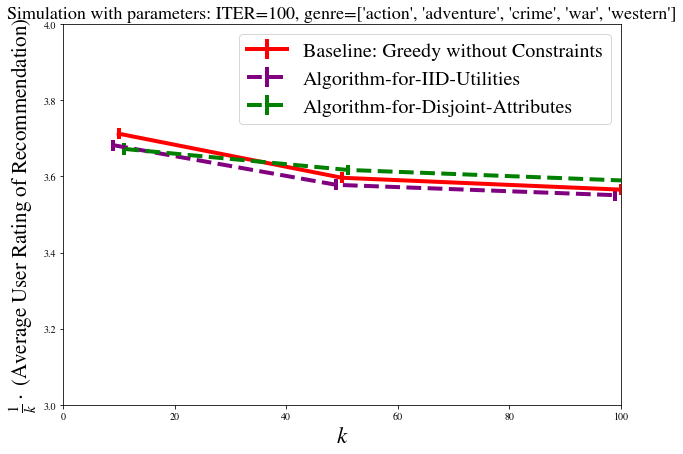

In [105]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

weight_F = np.zeros(20)
for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

LIST_baseline_greedy_uncons_OUTER = []
LIST_algo_2_greedy_cons_OUTER = []
LIST_algo_3_disjoint_attr_OUTER = []

ERR_LIST_baseline_greedy_uncons_OUTER = []
ERR_LIST_algo_2_greedy_cons_OUTER = []
ERR_LIST_algo_3_disjoint_attr_OUTER = []

x = []

print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
    list_baseline_greedy_uncons = []
    list_algo_2_greedy_cons = []
    list_algo_3_disjoint_attr = []
    user_draws = rng.choice(len(selected_users), 10*ITERS)

    ijk = -1
    while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
        ijk += 1
#     for ijk in tqdm(range(ITERS)):
        u_id = selected_users[user_draws[ijk]]


        m_inds = get_rated_movie_indices(u_id)

        m_ind_to_i = {}
        for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

        n = len(m_inds)
        m = len(genres_matching_tags)
        assert(n>=k)

        obs_util = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                m_ind = m_inds[i]
                g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

        # grps
        grps_int = [[], []]
        for i in range(n):
            m_ind = m_inds[i]

            if m_ind in grps_set[0]:
                grps_int[0].append(i)
            elif m_ind in grps_set[1]:
                grps_int[1].append(i)
            else:
                assert(False)
                
        if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
            continue 
        if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
            continue 
        

        # run algorithms and baselines
        sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
        sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
        sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

        util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
        util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
        util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

        list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
        list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
        list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

        print('#'*15 + f' iteration {ijk} ' + '#'*15)
        print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
        print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
        print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
        print('#'*50)

    x.append(k)

    LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
    LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
    LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

    ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
    ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))

x = np.array(x)
y1 = LIST_baseline_greedy_uncons_OUTER
y4 = LIST_algo_2_greedy_cons_OUTER
y5 = LIST_algo_3_disjoint_attr_OUTER

y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)

print(f'y1: {y1}')
print(f'y4: {y4}')
print(f'y5: {y5}')
print(f'y1_err: {y1_err}')
print(f'y4_err: {y4_err}')
print(f'y5_err: {y5_err}')

plt.title(f'Simulation with parameters: ITER={ITERS}, genre={[genres[g] for g in [1, 2, 6, 18, 19]]}', fontsize=18)
plt.ylim(3, 4)
plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)

# plt.show()
pdf_savefig()

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=3.70018625916878 and score-std=0.3640340554331487
max: -1, min: 100000000.0
score-mean=3.692483412902855 and score-std=0.4094390660958605
max: -1, min: 100000000.0
score-mean=3.6841438300472564 and score-std=0.30138616553021413
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.70018625916878, 0.0
util_algo_2_greedy_cons: 3.692483412902855, 0.0
util_algo_3_disjoint_attr: 3.6841438300472564, 0.0
##################################################
6
max: -1, min: 100000000.0
score-mean=3.775528375385788 and score-std=0.3194893727356885
max: -1, min: 100000000.0
score-mean=3.7750629760043397 and score-std=0.3196885286349982
max: -1, min: 100000000.0
score-mean=3.6226707008165793 and score-std=0.46073908605531844
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.737857317277284, 0.02663746064299551
util_algo_2_greedy_cons: 3.7337731944535975, 0.0291

max: -1, min: 100000000.0
score-mean=3.654794184878377 and score-std=0.3671009449811877
max: -1, min: 100000000.0
score-mean=3.5873232084699125 and score-std=0.38826579177457476
max: -1, min: 100000000.0
score-mean=3.6054273486028596 and score-std=0.3718674342169484
############### iteration 44 ###############
util_baseline_greedy_uncons: 3.7586514420186004, 0.023198414442393782
util_algo_2_greedy_cons: 3.733630255080659, 0.020608130677596183
util_algo_3_disjoint_attr: 3.6443180767385996, 0.021391963564441976
##################################################
6
max: -1, min: 100000000.0
score-mean=3.649801305189915 and score-std=0.33346309022910503
max: -1, min: 100000000.0
score-mean=3.6507234720574053 and score-std=0.332442271117047
max: -1, min: 100000000.0
score-mean=3.4691436325562943 and score-std=0.39829697243533585
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.7522484927933837, 0.022700242910187907
util_algo_2_greedy_cons: 3.728753385491056, 0.0199

max: -1, min: 100000000.0
score-mean=3.906742171958651 and score-std=0.27555453383370015
max: -1, min: 100000000.0
score-mean=3.9062691629009563 and score-std=0.25345810303290367
max: -1, min: 100000000.0
score-mean=3.724052297195143 and score-std=0.4090437471884753
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.7896069056739794, 0.016207482306375302
util_algo_2_greedy_cons: 3.769528137754569, 0.01564154409597546
util_algo_3_disjoint_attr: 3.6756232217334572, 0.016897366612260635
##################################################
6
max: -1, min: 100000000.0
score-mean=3.6769536926596915 and score-std=0.3128438933244759
max: -1, min: 100000000.0
score-mean=3.6755872474756415 and score-std=0.312747470181706
max: -1, min: 100000000.0
score-mean=3.5662121863972254 and score-std=0.34156510160187176
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.7860864927672826, 0.016078786322134473
util_algo_2_greedy_cons: 3.7665924849333523, 0.0154

max: -1, min: 100000000.0
score-mean=3.7405410251295974 and score-std=0.290578525601283
max: -1, min: 100000000.0
score-mean=3.743329929386665 and score-std=0.2918889838536818
max: -1, min: 100000000.0
score-mean=3.660813351909424 and score-std=0.3432944798457517
############### iteration 140 ###############
util_baseline_greedy_uncons: 3.76966373611898, 0.014830454772747312
util_algo_2_greedy_cons: 3.751496135269085, 0.014428669892001422
util_algo_3_disjoint_attr: 3.665260552906554, 0.014947096636344314
##################################################
6
max: -1, min: 100000000.0
score-mean=4.051112510298914 and score-std=0.1952267712017658
max: -1, min: 100000000.0
score-mean=4.042312034851292 and score-std=0.20148313994278316
max: -1, min: 100000000.0
score-mean=4.001962787958786 and score-std=0.2681673682565406
############### iteration 148 ###############
util_baseline_greedy_uncons: 3.7756520079100424, 0.015677344729986133
util_algo_2_greedy_cons: 3.7576837076006213, 0.015391335

max: -1, min: 100000000.0
score-mean=3.831563700771738 and score-std=0.3782894467968156
max: -1, min: 100000000.0
score-mean=3.8415130801275406 and score-std=0.381218525750562
max: -1, min: 100000000.0
score-mean=3.6198916336112097 and score-std=0.45113742059097234
############### iteration 179 ###############
util_baseline_greedy_uncons: 3.765718522528115, 0.013427885923614527
util_algo_2_greedy_cons: 3.749137818243432, 0.013337748748024101
util_algo_3_disjoint_attr: 3.6631842180524004, 0.014073874534544041
##################################################
6
max: -1, min: 100000000.0
score-mean=3.8033838102828015 and score-std=0.41168627864836826
max: -1, min: 100000000.0
score-mean=3.8033838102828015 and score-std=0.41168627864836826
max: -1, min: 100000000.0
score-mean=3.645162780782809 and score-std=0.4307225686216354
############### iteration 183 ###############
util_baseline_greedy_uncons: 3.7663260271693195, 0.013225042346038959
util_algo_2_greedy_cons: 3.750012753598906, 0.013

max: -1, min: 100000000.0
score-mean=3.896982464136719 and score-std=0.21492239560949267
max: -1, min: 100000000.0
score-mean=3.886865707691379 and score-std=0.22158336307494791
max: -1, min: 100000000.0
score-mean=3.707141935498741 and score-std=0.31117071751240577
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.7694164719954473, 0.01180430218258301
util_algo_2_greedy_cons: 3.7520547232331003, 0.011609147100377028
util_algo_3_disjoint_attr: 3.6670589482093074, 0.011950774218901596
##################################################
6
max: -1, min: 100000000.0
score-mean=3.803274379211621 and score-std=0.31699769382681814
max: -1, min: 100000000.0
score-mean=3.8034421479547755 and score-std=0.31589522797079417
max: -1, min: 100000000.0
score-mean=3.6474368700252207 and score-std=0.3866974971427103
############### iteration 222 ###############
util_baseline_greedy_uncons: 3.7698561850761774, 0.011659186389239696
util_algo_2_greedy_cons: 3.7527220923853304, 0.

max: -1, min: 100000000.0
score-mean=3.7965385336277637 and score-std=0.33260323336140085
max: -1, min: 100000000.0
score-mean=3.8107839910402106 and score-std=0.3252976097242105
max: -1, min: 100000000.0
score-mean=3.7211431020340706 and score-std=0.3511905575243215
############### iteration 262 ###############
util_baseline_greedy_uncons: 3.7758573547466225, 0.010529058737903682
util_algo_2_greedy_cons: 3.759850108849822, 0.010390120384748755
util_algo_3_disjoint_attr: 3.6717828724606822, 0.010529470310099681
##################################################
6
max: -1, min: 100000000.0
score-mean=3.8005562676376092 and score-std=0.3790099926695972
max: -1, min: 100000000.0
score-mean=3.811969017653455 and score-std=0.34414871076615233
max: -1, min: 100000000.0
score-mean=3.6873155371058783 and score-std=0.42382155661406135
############### iteration 265 ###############
util_baseline_greedy_uncons: 3.7761258211910897, 0.010418034519196146
util_algo_2_greedy_cons: 3.7604166187281227, 0

max: -1, min: 100000000.0
score-mean=3.67380807790247 and score-std=0.41947183849602887
max: -1, min: 100000000.0
score-mean=3.5261889387273517 and score-std=0.5053151325440668
max: -1, min: 100000000.0
score-mean=3.563891931577414 and score-std=0.4554085955318466
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.741243595544137, 0.022853362127032453
util_algo_2_greedy_cons: 3.709039535784576, 0.04009717488837258
util_algo_3_disjoint_attr: 3.651173012104944, 0.02538039111280528
##################################################
15
max: -1, min: 100000000.0
score-mean=3.838332629372478 and score-std=0.30388314768410907
max: -1, min: 100000000.0
score-mean=3.828869552767868 and score-std=0.29006250363764924
max: -1, min: 100000000.0
score-mean=3.7710580252912678 and score-std=0.33794714802008674
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.755113457519614, 0.02342230350368736
util_algo_2_greedy_cons: 3.7261581096393317, 0.037847200

max: -1, min: 100000000.0
score-mean=3.6550592736316387 and score-std=0.378157731536915
max: -1, min: 100000000.0
score-mean=3.622321220706315 and score-std=0.3670106630372513
max: -1, min: 100000000.0
score-mean=3.6653013272111044 and score-std=0.369333723506803
############### iteration 65 ###############
util_baseline_greedy_uncons: 3.74224725110712, 0.031086136648529578
util_algo_2_greedy_cons: 3.726927977692136, 0.029668944299703046
util_algo_3_disjoint_attr: 3.6546289856028644, 0.024142500595051297
##################################################
15
max: -1, min: 100000000.0
score-mean=3.510101381281422 and score-std=0.3469950876790049
max: -1, min: 100000000.0
score-mean=3.496669686448133 and score-std=0.3524488932241657
max: -1, min: 100000000.0
score-mean=3.5194177338902874 and score-std=0.3797490833367276
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.7316951661150424, 0.031413054025119076
util_algo_2_greedy_cons: 3.7164616917264994, 0.030109906

max: -1, min: 100000000.0
score-mean=3.7470281502300735 and score-std=0.3841279927351608
max: -1, min: 100000000.0
score-mean=3.7068079057866625 and score-std=0.38725206341014207
max: -1, min: 100000000.0
score-mean=3.6943473774709856 and score-std=0.3623659549972164
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.7399516804502886, 0.023291997701529534
util_algo_2_greedy_cons: 3.7225185917911583, 0.022997315483139002
util_algo_3_disjoint_attr: 3.6602402050367733, 0.018433249504786618
##################################################
15
max: -1, min: 100000000.0
score-mean=3.8736129708245777 and score-std=0.24765907056835426
max: -1, min: 100000000.0
score-mean=3.8976507454409313 and score-std=0.2302691312078172
max: -1, min: 100000000.0
score-mean=3.802407893218978 and score-std=0.3094200893583448
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.743564147757702, 0.022940911313481322
util_algo_2_greedy_cons: 3.727251893241152, 0.02

max: -1, min: 100000000.0
score-mean=3.7127489149843016 and score-std=0.38979052439773404
max: -1, min: 100000000.0
score-mean=3.6575631970845692 and score-std=0.4325306655588966
max: -1, min: 100000000.0
score-mean=3.623598856295036 and score-std=0.41608114529544993
############### iteration 143 ###############
util_baseline_greedy_uncons: 3.7592670664930496, 0.019058355275967394
util_algo_2_greedy_cons: 3.7412281789811725, 0.019115304464353597
util_algo_3_disjoint_attr: 3.676544684926438, 0.01679175870997941
##################################################
15
max: -1, min: 100000000.0
score-mean=3.9280077854522637 and score-std=0.255091618379491
max: -1, min: 100000000.0
score-mean=3.91241799179295 and score-std=0.2513917522656689
max: -1, min: 100000000.0
score-mean=3.8147453311643256 and score-std=0.34361269096332653
############### iteration 144 ###############
util_baseline_greedy_uncons: 3.7625120803191883, 0.01896609635030606
util_algo_2_greedy_cons: 3.7445202907660144, 0.019

max: -1, min: 100000000.0
score-mean=3.8312771686165146 and score-std=0.3185864003191217
max: -1, min: 100000000.0
score-mean=3.683507339805631 and score-std=0.5135119350864079
max: -1, min: 100000000.0
score-mean=3.7391037863205203 and score-std=0.4072983691865249
############### iteration 173 ###############
util_baseline_greedy_uncons: 3.766134093011387, 0.016466020213401978
util_algo_2_greedy_cons: 3.746495158207181, 0.016498378365945254
util_algo_3_disjoint_attr: 3.6878676424239467, 0.014011209409793321
##################################################
15
max: -1, min: 100000000.0
score-mean=3.826131107217006 and score-std=0.2884004776090996
max: -1, min: 100000000.0
score-mean=3.8182684102338995 and score-std=0.28931860863385417
max: -1, min: 100000000.0
score-mean=3.6568837268471293 and score-std=0.40488666746655727
############### iteration 176 ###############
util_baseline_greedy_uncons: 3.767029570835352, 0.016244590023620314
util_algo_2_greedy_cons: 3.747566400774744, 0.016

max: -1, min: 100000000.0
score-mean=3.89010446549458 and score-std=0.25799291610287656
max: -1, min: 100000000.0
score-mean=3.866519466532273 and score-std=0.2798480082585925
max: -1, min: 100000000.0
score-mean=3.822743925270129 and score-std=0.3102905782151098
############### iteration 216 ###############
util_baseline_greedy_uncons: 3.7562318819103946, 0.015406274202556993
util_algo_2_greedy_cons: 3.738694654588492, 0.014998498946749487
util_algo_3_disjoint_attr: 3.6820129835440025, 0.012869739036642949
##################################################
15
max: -1, min: 100000000.0
score-mean=3.8212056312375244 and score-std=0.3112786786016655
max: -1, min: 100000000.0
score-mean=3.866419273448612 and score-std=0.3180615165851648
max: -1, min: 100000000.0
score-mean=3.765073899038271 and score-std=0.34709546183226264
############### iteration 218 ###############
util_baseline_greedy_uncons: 3.7570242447070674, 0.015238755262339419
util_algo_2_greedy_cons: 3.7402522718916646, 0.0148

max: -1, min: 100000000.0
score-mean=3.876720747635229 and score-std=0.276154504647474
max: -1, min: 100000000.0
score-mean=3.8493152784713462 and score-std=0.27991450073771884
max: -1, min: 100000000.0
score-mean=3.761541488547993 and score-std=0.34315410973626315
############### iteration 255 ###############
util_baseline_greedy_uncons: 3.759391950535427, 0.013492734603393076
util_algo_2_greedy_cons: 3.7406193771611833, 0.013375910280175847
util_algo_3_disjoint_attr: 3.6808947154064455, 0.011719404542475312
##################################################
15
max: -1, min: 100000000.0
score-mean=3.768561327581823 and score-std=0.3451581127806788
max: -1, min: 100000000.0
score-mean=3.70606755930663 and score-std=0.37836453125836644
max: -1, min: 100000000.0
score-mean=3.6828704951364672 and score-std=0.4401126011522174
############### iteration 257 ###############
util_baseline_greedy_uncons: 3.7594864801956995, 0.013353965378415879
util_algo_2_greedy_cons: 3.7402631728534046, 0.013

max: -1, min: 100000000.0
score-mean=3.660346109220084 and score-std=0.3626494971534436
max: -1, min: 100000000.0
score-mean=3.6509113416123995 and score-std=0.3729547036638421
max: -1, min: 100000000.0
score-mean=3.6834267231683095 and score-std=0.3227918498501654
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.607746746039173, 0.01744994038230329
util_algo_2_greedy_cons: 3.6005992509960745, 0.015114502139921961
util_algo_3_disjoint_attr: 3.654063459949674, 0.01363993444331832
##################################################
18
max: -1, min: 100000000.0
score-mean=3.755776092524568 and score-std=0.28475953044236796
max: -1, min: 100000000.0
score-mean=3.710039446109481 and score-std=0.289192249241459
max: -1, min: 100000000.0
score-mean=3.627715805581733 and score-std=0.5038894436770502
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.620082524912956, 0.01988354653362182
util_algo_2_greedy_cons: 3.609719267255525, 0.016376916578

max: -1, min: 100000000.0
score-mean=3.505479596901115 and score-std=0.36719202258529
max: -1, min: 100000000.0
score-mean=3.5178416075897667 and score-std=0.36585872148813914
max: -1, min: 100000000.0
score-mean=3.6424362446493235 and score-std=0.44313029947670163
############### iteration 74 ###############
util_baseline_greedy_uncons: 3.550981192042558, 0.03525355644583619
util_algo_2_greedy_cons: 3.536138709637299, 0.035126619858647734
util_algo_3_disjoint_attr: 3.6036214347837094, 0.02088060648831504
##################################################
18
max: -1, min: 100000000.0
score-mean=3.431010914909228 and score-std=0.4728472508660772
max: -1, min: 100000000.0
score-mean=3.430025746696966 and score-std=0.47221862951856086
max: -1, min: 100000000.0
score-mean=3.4394895181960505 and score-std=0.5656629446108048
############### iteration 77 ###############
util_baseline_greedy_uncons: 3.546537848445027, 0.03422674232371613
util_algo_2_greedy_cons: 3.5322085998987682, 0.034044782

max: -1, min: 100000000.0
score-mean=3.57821001444327 and score-std=0.34935255069999793
max: -1, min: 100000000.0
score-mean=3.548986249776485 and score-std=0.401937931035595
max: -1, min: 100000000.0
score-mean=3.6305935924681223 and score-std=0.4063892808940051
############### iteration 118 ###############
util_baseline_greedy_uncons: 3.5066898862744056, 0.026863688333167317
util_algo_2_greedy_cons: 3.4908921061614557, 0.026729110201485953
util_algo_3_disjoint_attr: 3.574710735008701, 0.017020319642476283
##################################################
18
max: -1, min: 100000000.0
score-mean=3.602771903706249 and score-std=0.2868282540215444
max: -1, min: 100000000.0
score-mean=3.60729467018143 and score-std=0.289750409044078
max: -1, min: 100000000.0
score-mean=3.71751512405246 and score-std=0.30790841201378927
############### iteration 120 ###############
util_baseline_greedy_uncons: 3.508977553356116, 0.026321303434946396
util_algo_2_greedy_cons: 3.493663595780979, 0.0262359945

max: -1, min: 100000000.0
score-mean=3.5680715623115176 and score-std=0.3185465504681945
max: -1, min: 100000000.0
score-mean=3.5788094953169467 and score-std=0.3147637746558619
max: -1, min: 100000000.0
score-mean=3.6062745925419426 and score-std=0.4193552998294511
############### iteration 144 ###############
util_baseline_greedy_uncons: 3.5164496732708628, 0.020363580511696226
util_algo_2_greedy_cons: 3.503219234739331, 0.020179187768745208
util_algo_3_disjoint_attr: 3.588690674074897, 0.013846497218488811
##################################################
18
max: -1, min: 100000000.0
score-mean=3.613273315076937 and score-std=0.30342213477561625
max: -1, min: 100000000.0
score-mean=3.609374876984347 and score-std=0.30147536865235824
max: -1, min: 100000000.0
score-mean=3.6840057580641066 and score-std=0.3053379653344944
############### iteration 147 ###############
util_baseline_greedy_uncons: 3.5181483336534254, 0.020077047934102202
util_algo_2_greedy_cons: 3.5050816144278403, 0.0

max: -1, min: 100000000.0
score-mean=3.684639375958734 and score-std=0.26141619389183834
max: -1, min: 100000000.0
score-mean=3.70060143636506 and score-std=0.2708825388991242
max: -1, min: 100000000.0
score-mean=3.738897519151089 and score-std=0.3156868223484998
############### iteration 186 ###############
util_baseline_greedy_uncons: 3.500643119037555, 0.019952414701719136
util_algo_2_greedy_cons: 3.491496198793561, 0.01994343912561067
util_algo_3_disjoint_attr: 3.5747173274470763, 0.013809720105881116
##################################################
18
max: -1, min: 100000000.0
score-mean=3.6924719359234945 and score-std=0.2401007588036708
max: -1, min: 100000000.0
score-mean=3.6834477080317676 and score-std=0.26619833685481054
max: -1, min: 100000000.0
score-mean=3.7370903579879937 and score-std=0.28933126403718334
############### iteration 187 ###############
util_baseline_greedy_uncons: 3.5033074081609707, 0.019852385042356452
util_algo_2_greedy_cons: 3.494162191977425, 0.0198

max: -1, min: 100000000.0
score-mean=3.6831554316937978 and score-std=0.26118699478499724
max: -1, min: 100000000.0
score-mean=3.681508647454621 and score-std=0.26386619982612164
max: -1, min: 100000000.0
score-mean=3.717557836548827 and score-std=0.3000271795172315
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.4919326447081978, 0.01970564766761425
util_algo_2_greedy_cons: 3.4817709451427237, 0.01991157037786531
util_algo_3_disjoint_attr: 3.5754529324508226, 0.013172940091302928
##################################################
18
max: -1, min: 100000000.0
score-mean=3.2926907882385934 and score-std=0.448218168185159
max: -1, min: 100000000.0
score-mean=3.2577178347350184 and score-std=0.43566351791117197
max: -1, min: 100000000.0
score-mean=3.3947437475059714 and score-std=0.47097735611763936
############### iteration 233 ###############
util_baseline_greedy_uncons: 3.489642508426938, 0.01961177115235572
util_algo_2_greedy_cons: 3.479195622034589, 0.019

max: -1, min: 100000000.0
score-mean=3.568076282873184 and score-std=0.42150193147755877
max: -1, min: 100000000.0
score-mean=3.5472306546778323 and score-std=0.4177980030540532
max: -1, min: 100000000.0
score-mean=3.514453392618112 and score-std=0.48004612537229374
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.568076282873184, 0.0
util_algo_2_greedy_cons: 3.5472306546778323, 0.0
util_algo_3_disjoint_attr: 3.514453392618112, 0.0
##################################################
1
max: -1, min: 100000000.0
score-mean=3.7748730748668122 and score-std=0.2763038117063696
max: -1, min: 100000000.0
score-mean=3.738751271959048 and score-std=0.3431296073779678
max: -1, min: 100000000.0
score-mean=3.750115688404801 and score-std=0.31652079306140246
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.6714746788699983, 0.07311370697315922
util_algo_2_greedy_cons: 3.6429909633184403, 0.06771276360829051
util_algo_3_disjoint_attr: 3.632284540511

max: -1, min: 100000000.0
score-mean=3.632321833563995 and score-std=0.4045778553117087
max: -1, min: 100000000.0
score-mean=3.6714919866628977 and score-std=0.3903910850241167
max: -1, min: 100000000.0
score-mean=3.5686775465564473 and score-std=0.4176294702310486
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.594496129124724, 0.03707574503533609
util_algo_2_greedy_cons: 3.5610614379571874, 0.038991009028826
util_algo_3_disjoint_attr: 3.6226360179802564, 0.03335602819414255
##################################################
1
max: -1, min: 100000000.0
score-mean=3.4155726801214 and score-std=0.5091566396330385
max: -1, min: 100000000.0
score-mean=3.33208016034925 and score-std=0.5385992314437099
max: -1, min: 100000000.0
score-mean=3.398623132038404 and score-std=0.5285619623661024
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.583971220359823, 0.03635802507414567
util_algo_2_greedy_cons: 3.5475919510390734, 0.03895453183783622

max: -1, min: 100000000.0
score-mean=3.625420813263639 and score-std=0.3985869788369075
max: -1, min: 100000000.0
score-mean=3.674918710110279 and score-std=0.41628181286975147
max: -1, min: 100000000.0
score-mean=3.707112298317055 and score-std=0.37374130822787804
############### iteration 98 ###############
util_baseline_greedy_uncons: 3.5676272914121836, 0.023421656133318917
util_algo_2_greedy_cons: 3.5398605371819913, 0.025374676951674755
util_algo_3_disjoint_attr: 3.590997141642098, 0.02219832930445088
##################################################
1
max: -1, min: 100000000.0
score-mean=3.709209203465198 and score-std=0.3175388323429995
max: -1, min: 100000000.0
score-mean=3.7168462359416963 and score-std=0.29899220200258386
max: -1, min: 100000000.0
score-mean=3.7596377729635475 and score-std=0.36835843879607394
############### iteration 102 ###############
util_baseline_greedy_uncons: 3.5720517261638403, 0.023103846085795174
util_algo_2_greedy_cons: 3.5453913402682327, 0.025

max: -1, min: 100000000.0
score-mean=3.7852348674208143 and score-std=0.2891350977814811
max: -1, min: 100000000.0
score-mean=3.793314177481802 and score-std=0.29040617157081566
max: -1, min: 100000000.0
score-mean=3.748399497012325 and score-std=0.30762947797633267
############### iteration 144 ###############
util_baseline_greedy_uncons: 3.561453257507567, 0.02339558399620002
util_algo_2_greedy_cons: 3.53333284311449, 0.025186991856176396
util_algo_3_disjoint_attr: 3.584537825302419, 0.020152079768037318
##################################################
1
max: -1, min: 100000000.0
score-mean=3.6251506878828406 and score-std=0.3694893973294043
max: -1, min: 100000000.0
score-mean=3.580598513198097 and score-std=0.45523889974068904
max: -1, min: 100000000.0
score-mean=3.497769836340148 and score-std=0.4091953509772762
############### iteration 147 ###############
util_baseline_greedy_uncons: 3.5628085219836363, 0.02293702605160267
util_algo_2_greedy_cons: 3.5343384956694597, 0.0246711

max: -1, min: 100000000.0
score-mean=3.5553544185212513 and score-std=0.3869209528896572
max: -1, min: 100000000.0
score-mean=3.5220192867496984 and score-std=0.3813301174026795
max: -1, min: 100000000.0
score-mean=3.5795752692686937 and score-std=0.3918909745866437
############### iteration 180 ###############
util_baseline_greedy_uncons: 3.572421433798764, 0.019966182218870074
util_algo_2_greedy_cons: 3.544354525569507, 0.02112653149653622
util_algo_3_disjoint_attr: 3.5923929473584293, 0.01721124172445213
##################################################
1
max: -1, min: 100000000.0
score-mean=3.554111539292736 and score-std=0.3974529434538609
max: -1, min: 100000000.0
score-mean=3.386144660949948 and score-std=0.5447037071907205
max: -1, min: 100000000.0
score-mean=3.5256533804197687 and score-std=0.4290095134793198
############### iteration 184 ###############
util_baseline_greedy_uncons: 3.5721261129196344, 0.019646330953925987
util_algo_2_greedy_cons: 3.541802753559514, 0.0209393

max: -1, min: 100000000.0
score-mean=3.574237256047245 and score-std=0.44463331241270715
max: -1, min: 100000000.0
score-mean=3.5887356949877267 and score-std=0.45499274382547705
max: -1, min: 100000000.0
score-mean=3.5956403665909598 and score-std=0.4396479763186086
############### iteration 215 ###############
util_baseline_greedy_uncons: 3.5666933887218732, 0.017478236397461763
util_algo_2_greedy_cons: 3.53838551764881, 0.018539329174692327
util_algo_3_disjoint_attr: 3.5900447027511397, 0.01505275594219333
##################################################
1
max: -1, min: 100000000.0
score-mean=3.7407747179963753 and score-std=0.27750603093390125
max: -1, min: 100000000.0
score-mean=3.720202457729615 and score-std=0.27932888173679576
max: -1, min: 100000000.0
score-mean=3.691347967602715 and score-std=0.33869851259131867
############### iteration 218 ###############
util_baseline_greedy_uncons: 3.568954185205958, 0.017396848016562147
util_algo_2_greedy_cons: 3.540746776610898, 0.018

max: -1, min: 100000000.0
score-mean=3.4986316880646156 and score-std=0.3693643732789942
max: -1, min: 100000000.0
score-mean=3.4526778572862766 and score-std=0.5003514809524046
max: -1, min: 100000000.0
score-mean=3.4813712195629996 and score-std=0.3963398847221832
############### iteration 253 ###############
util_baseline_greedy_uncons: 3.565754486729608, 0.01572905509647952
util_algo_2_greedy_cons: 3.536109329780553, 0.016662437112876214
util_algo_3_disjoint_attr: 3.586011522065046, 0.01355841715156561
##################################################
1
max: -1, min: 100000000.0
score-mean=3.5827355465820756 and score-std=0.42755494904254604
max: -1, min: 100000000.0
score-mean=3.554771959999721 and score-std=0.3994407530034978
max: -1, min: 100000000.0
score-mean=3.6415852348603073 and score-std=0.42299497873709646
############### iteration 254 ###############
util_baseline_greedy_uncons: 3.5659390634671344, 0.015559170050767528
util_algo_2_greedy_cons: 3.536312184456848, 0.01648

max: -1, min: 100000000.0
score-mean=3.6018652796137047 and score-std=0.31021422639683827
max: -1, min: 100000000.0
score-mean=3.597559774254585 and score-std=0.31408933230712716
max: -1, min: 100000000.0
score-mean=3.7141306338784177 and score-std=0.29418883541971286
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.418831607966782, 0.10626153571276223
util_algo_2_greedy_cons: 3.415019542218919, 0.09992792890791045
util_algo_3_disjoint_attr: 3.596388841485954, 0.06694833751707052
##################################################
2
max: -1, min: 100000000.0
score-mean=3.5920589053980785 and score-std=0.43934520977763
max: -1, min: 100000000.0
score-mean=3.5836104399489495 and score-std=0.43515322003694734
max: -1, min: 100000000.0
score-mean=3.6982507680304058 and score-std=0.35420735521871166
############### iteration 29 ###############
util_baseline_greedy_uncons: 3.443578364742682, 0.09391869972808758
util_algo_2_greedy_cons: 3.4391039561803516, 0.08850732

max: -1, min: 100000000.0
score-mean=2.91944114033376 and score-std=0.5461265696559192
max: -1, min: 100000000.0
score-mean=2.8534846045632913 and score-std=0.5397506102839107
max: -1, min: 100000000.0
score-mean=3.1766822097687846 and score-std=0.6017944694681043
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.4175863109867595, 0.056659728463747734
util_algo_2_greedy_cons: 3.4085065922996285, 0.05670832723316214
util_algo_3_disjoint_attr: 3.56318412611148, 0.041347972293019244
##################################################
2
max: -1, min: 100000000.0
score-mean=3.6518205802449177 and score-std=0.35305590936903997
max: -1, min: 100000000.0
score-mean=3.648014786637439 and score-std=0.3201055684685153
max: -1, min: 100000000.0
score-mean=3.7186173420092747 and score-std=0.2996871444695751
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.4282333232257667, 0.0550755500569122
util_algo_2_greedy_cons: 3.4193933284058926, 0.055165784

max: -1, min: 100000000.0
score-mean=3.383720923715938 and score-std=0.4352898158074412
max: -1, min: 100000000.0
score-mean=3.383720923715938 and score-std=0.4352898158074412
max: -1, min: 100000000.0
score-mean=3.6379408178814985 and score-std=0.37613772977986415
############### iteration 100 ###############
util_baseline_greedy_uncons: 3.381936034814117, 0.0468713913589196
util_algo_2_greedy_cons: 3.3787049855500495, 0.04549915438954699
util_algo_3_disjoint_attr: 3.5595651926120078, 0.029209051699984792
##################################################
2
max: -1, min: 100000000.0
score-mean=3.32135200013099 and score-std=0.42916513207930984
max: -1, min: 100000000.0
score-mean=3.3184180633550318 and score-std=0.40542702438887074
max: -1, min: 100000000.0
score-mean=3.5456821863660792 and score-std=0.39770619985488304
############### iteration 103 ###############
util_baseline_greedy_uncons: 3.38029862847133, 0.04563318863195764
util_algo_2_greedy_cons: 3.3770756092745082, 0.0442986

max: -1, min: 100000000.0
score-mean=3.5389969334777196 and score-std=0.27428365856423087
max: -1, min: 100000000.0
score-mean=3.534711795174961 and score-std=0.28073405586390626
max: -1, min: 100000000.0
score-mean=3.6057016983206354 and score-std=0.27735663067665095
############### iteration 143 ###############
util_baseline_greedy_uncons: 3.3919608707859803, 0.03447243601670712
util_algo_2_greedy_cons: 3.3901597583370697, 0.03358769760326396
util_algo_3_disjoint_attr: 3.5586942134515938, 0.022194591797714387
##################################################
2
max: -1, min: 100000000.0
score-mean=3.4464398394975664 and score-std=0.45264244717494845
max: -1, min: 100000000.0
score-mean=3.4260824457014794 and score-std=0.4714891118811278
max: -1, min: 100000000.0
score-mean=3.5676319450848513 and score-std=0.3314797967412474
############### iteration 148 ###############
util_baseline_greedy_uncons: 3.393008543261203, 0.03382542102958248
util_algo_2_greedy_cons: 3.3908505792479238, 0.0

max: -1, min: 100000000.0
score-mean=3.5443847925138936 and score-std=0.3839467569986703
max: -1, min: 100000000.0
score-mean=3.5635579249712146 and score-std=0.3809664848754647
max: -1, min: 100000000.0
score-mean=3.580713852721627 and score-std=0.38017252637889115
############### iteration 189 ###############
util_baseline_greedy_uncons: 3.3939027491123976, 0.02769772800295614
util_algo_2_greedy_cons: 3.3922381884890824, 0.027033906595332446
util_algo_3_disjoint_attr: 3.563510976187048, 0.017590792909809035
##################################################
2
max: -1, min: 100000000.0
score-mean=3.6042389203755794 and score-std=0.2817353921750926
max: -1, min: 100000000.0
score-mean=3.6330065838408063 and score-std=0.2952028718525525
max: -1, min: 100000000.0
score-mean=3.54689888719834 and score-std=0.367464071578717
############### iteration 192 ###############
util_baseline_greedy_uncons: 3.397042094952147, 0.0274616643452825
util_algo_2_greedy_cons: 3.3958317466286605, 0.02686819

max: -1, min: 100000000.0
score-mean=3.5188291041680486 and score-std=0.33968405970842164
max: -1, min: 100000000.0
score-mean=3.521042012474418 and score-std=0.33468386166828673
max: -1, min: 100000000.0
score-mean=3.5793334119780225 and score-std=0.3435531049512089
############### iteration 238 ###############
util_baseline_greedy_uncons: 3.4034269393550676, 0.024212714308041988
util_algo_2_greedy_cons: 3.4017767607455625, 0.023641960072984324
util_algo_3_disjoint_attr: 3.5708614393234575, 0.015482029158809826
##################################################
2
max: -1, min: 100000000.0
score-mean=3.6391895194962696 and score-std=0.47979050491922776
max: -1, min: 100000000.0
score-mean=3.638774850823342 and score-std=0.47931626925563786
max: -1, min: 100000000.0
score-mean=3.7603765647822445 and score-std=0.4736808060324558
############### iteration 241 ###############
util_baseline_greedy_uncons: 3.4063020927714236, 0.02408753834058156
util_algo_2_greedy_cons: 3.404666981356267, 0.

max: -1, min: 100000000.0
score-mean=3.446765570132409 and score-std=0.4032752016467997
max: -1, min: 100000000.0
score-mean=3.450138044867906 and score-std=0.3885784794052242
max: -1, min: 100000000.0
score-mean=3.557195042885735 and score-std=0.3857436831790035
############### iteration 307 ###############
util_baseline_greedy_uncons: 3.401986815574656, 0.02207405068762114
util_algo_2_greedy_cons: 3.3990960255653193, 0.021494673743801603
util_algo_3_disjoint_attr: 3.5690167038469274, 0.014476736087133395
##################################################
2
max: -1, min: 100000000.0
score-mean=3.2814334750779013 and score-std=0.4098326471260298
max: -1, min: 100000000.0
score-mean=3.3067564740087096 and score-std=0.4021774961078532
max: -1, min: 100000000.0
score-mean=3.4994422049388096 and score-std=0.4109810903492383
############### iteration 312 ###############
util_baseline_greedy_uncons: 3.4007439976313907, 0.021881441885685547
util_algo_2_greedy_cons: 3.3981440714255604, 0.02129

max: -1, min: 100000000.0
score-mean=3.7524585316439616 and score-std=0.19030003550688152
max: -1, min: 100000000.0
score-mean=3.7561709898405424 and score-std=0.18961964171511317
max: -1, min: 100000000.0
score-mean=3.732124111374684 and score-std=0.28150103891209294
############### iteration 21 ###############
util_baseline_greedy_uncons: 3.5086278199167054, 0.04431195979035876
util_algo_2_greedy_cons: 3.500336532519695, 0.04566412240154661
util_algo_3_disjoint_attr: 3.591647992241065, 0.03590345411316343
##################################################
19
max: -1, min: 100000000.0
score-mean=3.303492652744243 and score-std=0.6213644302534571
max: -1, min: 100000000.0
score-mean=3.3075351417047973 and score-std=0.6140583027386736
max: -1, min: 100000000.0
score-mean=3.487482360608718 and score-std=0.5896187246914056
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.491533222652334, 0.04379269798811342
util_algo_2_greedy_cons: 3.4842697499517867, 0.04459581

max: -1, min: 100000000.0
score-mean=3.209581702081112 and score-std=0.4802987225014059
max: -1, min: 100000000.0
score-mean=3.125355548573284 and score-std=0.4900750909651936
max: -1, min: 100000000.0
score-mean=3.3090712845680366 and score-std=0.5115540762777745
############### iteration 75 ###############
util_baseline_greedy_uncons: 3.5114492606636554, 0.03529180473594696
util_algo_2_greedy_cons: 3.501936056978079, 0.03600714758317458
util_algo_3_disjoint_attr: 3.5926994234681184, 0.027241408926877805
##################################################
19
max: -1, min: 100000000.0
score-mean=3.452943724168703 and score-std=0.42985672611715015
max: -1, min: 100000000.0
score-mean=3.4528546570443517 and score-std=0.42180022867627687
max: -1, min: 100000000.0
score-mean=3.578514883082312 and score-std=0.42355732845481314
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.50928238894162, 0.034051157457039155
util_algo_2_greedy_cons: 3.500118227350904, 0.03471940

max: -1, min: 100000000.0
score-mean=3.5768017722192567 and score-std=0.3500169768734561
max: -1, min: 100000000.0
score-mean=3.5981739667778982 and score-std=0.35649120281888824
max: -1, min: 100000000.0
score-mean=3.631101179959564 and score-std=0.36171600484683364
############### iteration 124 ###############
util_baseline_greedy_uncons: 3.4990426111510717, 0.024758390710123895
util_algo_2_greedy_cons: 3.4954695950736534, 0.02520625705553135
util_algo_3_disjoint_attr: 3.5918830810332465, 0.018839933793037434
##################################################
19
max: -1, min: 100000000.0
score-mean=3.7947028223945924 and score-std=0.3259364135476117
max: -1, min: 100000000.0
score-mean=3.6726442026623785 and score-std=0.3529851163049414
max: -1, min: 100000000.0
score-mean=3.713161117944614 and score-std=0.34582075983400284
############### iteration 125 ###############
util_baseline_greedy_uncons: 3.506082139990203, 0.02514977267326853
util_algo_2_greedy_cons: 3.49968803811148, 0.024

max: -1, min: 100000000.0
score-mean=3.403568012256404 and score-std=0.43869955033898594
max: -1, min: 100000000.0
score-mean=3.336075980403164 and score-std=0.4576375609694397
max: -1, min: 100000000.0
score-mean=3.4899066250367974 and score-std=0.43704482917746085
############### iteration 165 ###############
util_baseline_greedy_uncons: 3.5147474211058634, 0.020411846832863113
util_algo_2_greedy_cons: 3.5084334999071265, 0.020461629097514627
util_algo_3_disjoint_attr: 3.598943070977366, 0.01545078209208362
##################################################
19
max: -1, min: 100000000.0
score-mean=3.4299589586514156 and score-std=0.3708545154913451
max: -1, min: 100000000.0
score-mean=3.429958958651415 and score-std=0.3708545154913451
max: -1, min: 100000000.0
score-mean=3.4393342437699745 and score-std=0.4732333931953294
############### iteration 166 ###############
util_baseline_greedy_uncons: 3.5132599042206976, 0.02010787273161242
util_algo_2_greedy_cons: 3.507056753569307, 0.0201

max: -1, min: 100000000.0
score-mean=3.596273715710774 and score-std=0.3748868637316923
max: -1, min: 100000000.0
score-mean=3.5903124121698706 and score-std=0.37745208172910405
max: -1, min: 100000000.0
score-mean=3.6210139920481197 and score-std=0.3779683760600349
############### iteration 198 ###############
util_baseline_greedy_uncons: 3.5061858073592167, 0.01882486117062966
util_algo_2_greedy_cons: 3.5005320348033937, 0.018611413432436424
util_algo_3_disjoint_attr: 3.585275922029306, 0.014798817910934379
##################################################
19
max: -1, min: 100000000.0
score-mean=3.7617645674396556 and score-std=0.24128371536656243
max: -1, min: 100000000.0
score-mean=3.761505118033732 and score-std=0.24727876836568155
max: -1, min: 100000000.0
score-mean=3.694033535167082 and score-std=0.3599162169599057
############### iteration 203 ###############
util_baseline_greedy_uncons: 3.5097355123603338, 0.01889511567704242
util_algo_2_greedy_cons: 3.5041566609593713, 0.01

max: -1, min: 100000000.0
score-mean=3.447039045617663 and score-std=0.4443007383093742
max: -1, min: 100000000.0
score-mean=3.4479602621984577 and score-std=0.4418772144036203
max: -1, min: 100000000.0
score-mean=3.5719532424489726 and score-std=0.4762903467228211
############### iteration 249 ###############
util_baseline_greedy_uncons: 3.512135030046864, 0.019381065152990037
util_algo_2_greedy_cons: 3.505683360143927, 0.018882594113481824
util_algo_3_disjoint_attr: 3.5891549805061675, 0.013860842058967177
##################################################
19
max: -1, min: 100000000.0
score-mean=3.311872032087919 and score-std=0.34947132837524897
max: -1, min: 100000000.0
score-mean=3.30458676517267 and score-std=0.3614083056869774
max: -1, min: 100000000.0
score-mean=3.265730149773441 and score-std=0.42174967594206314
############### iteration 252 ###############
util_baseline_greedy_uncons: 3.5098331565071064, 0.019294505906201027
util_algo_2_greedy_cons: 3.5033719050293146, 0.0188

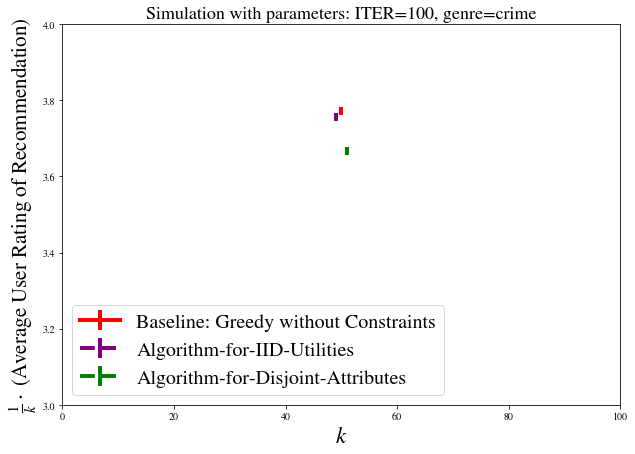

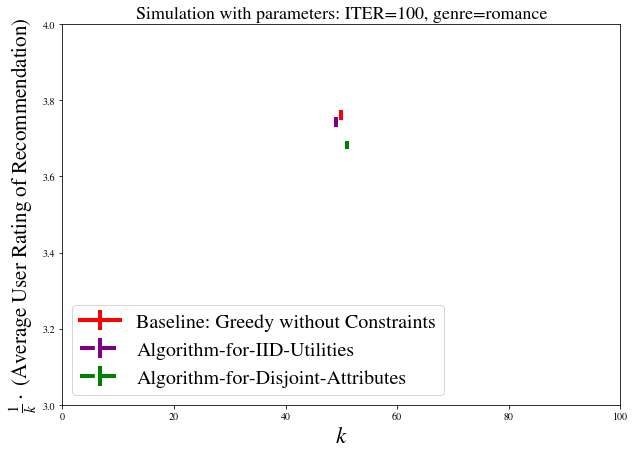

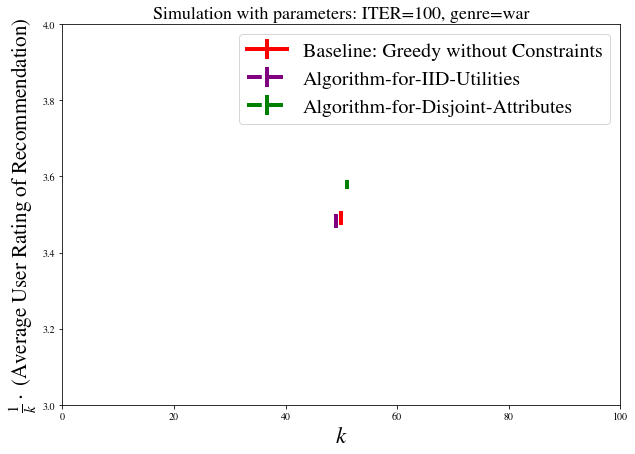

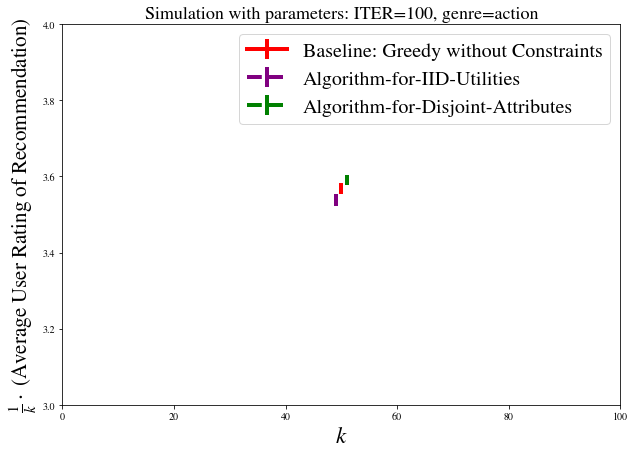

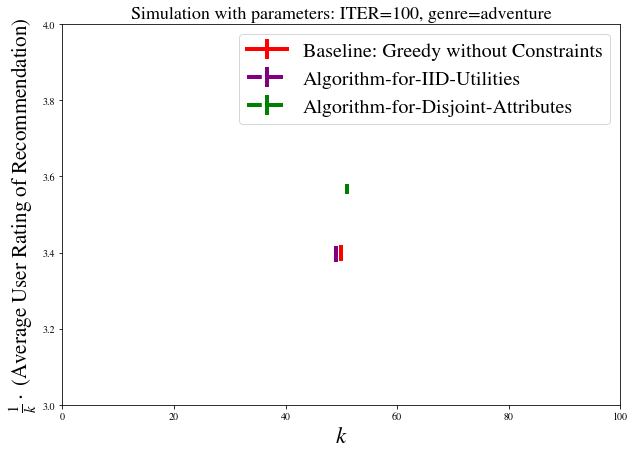

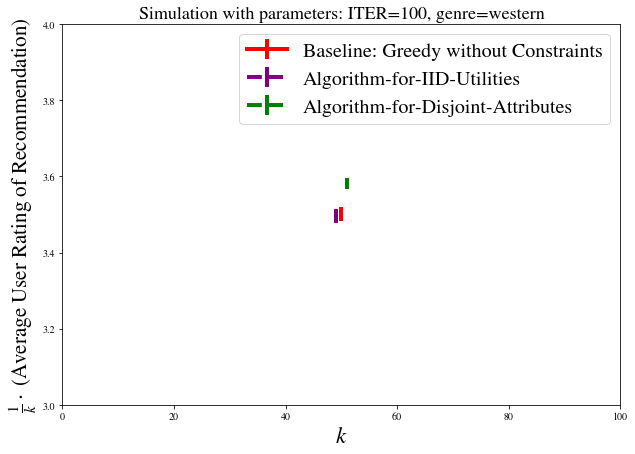

In [111]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

for g in [6, 15, 18, 1, 2, 19]: 
    weight_F = np.zeros(20)
#     for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []

    x = []

    print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

    for k in [50]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
    #     for ijk in tqdm(range(ITERS)):
            u_id = selected_users[user_draws[ijk]]


            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    ggg = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][ggg]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)

            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 


            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            print('#'*15 + f' iteration {ijk} ' + '#'*15)
            print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
            print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
            print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
            print('#'*50)
            print(g)

            

        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))
        
            
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)


    print(f'y1: {y1}')
    print(f'y4: {y4}')
    print(f'y5: {y5}')
    print(f'y1_err: {y1_err}')
    print(f'y4_err: {y4_err}')
    print(f'y5_err: {y5_err}')

    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[g]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

In [ ]:
1...
2...
18...
19....
western, adventure, war...

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=2.7741167546136163 and score-std=0.4676377567744313
max: -1, min: 100000000.0
score-mean=2.6909178210434783 and score-std=0.4034139294454779
max: -1, min: 100000000.0
score-mean=2.7741167546136163 and score-std=0.4676377567744313
############### iteration 2 ###############
util_baseline_greedy_uncons: 2.7741167546136163, 0.0
util_algo_2_greedy_cons: 2.6909178210434783, 0.0
util_algo_3_disjoint_attr: 2.7741167546136163, 0.0
##################################################
18
max: -1, min: 100000000.0
score-mean=3.4811418703727304 and score-std=0.3888523441044461
max: -1, min: 100000000.0
score-mean=3.356398910113242 and score-std=0.49590791126129974
max: -1, min: 100000000.0
score-mean=3.4811418703727304 and score-std=0.3888523441044461
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.1276293124931733, 0.24997112691123663
util_algo_2_greedy_cons: 3.02365836557836, 0

max: -1, min: 100000000.0
score-mean=3.228985142905182 and score-std=0.32383520565846413
max: -1, min: 100000000.0
score-mean=3.180421436742899 and score-std=0.3399253617785935
max: -1, min: 100000000.0
score-mean=3.228985142905182 and score-std=0.32383520565846413
############### iteration 36 ###############
util_baseline_greedy_uncons: 3.44104157037163, 0.06059509750052366
util_algo_2_greedy_cons: 3.410252038938365, 0.06569316425730924
util_algo_3_disjoint_attr: 3.4410415703716297, 0.06059509750052366
##################################################
18
max: -1, min: 100000000.0
score-mean=3.473990037035655 and score-std=0.5504425271408899
max: -1, min: 100000000.0
score-mean=3.263622537855851 and score-std=0.45806415093515257
max: -1, min: 100000000.0
score-mean=3.473990037035655 and score-std=0.5504425271408899
############### iteration 37 ###############
util_baseline_greedy_uncons: 3.442979715469514, 0.0570616675418403
util_algo_2_greedy_cons: 3.4016267741688053, 0.0623925235304

max: -1, min: 100000000.0
score-mean=3.442841439788972 and score-std=0.2994484365866944
max: -1, min: 100000000.0
score-mean=3.4325636201834913 and score-std=0.301199277682824
max: -1, min: 100000000.0
score-mean=3.442841439788972 and score-std=0.2994484365866944
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.5303261513850317, 0.04482205479994335
util_algo_2_greedy_cons: 3.494149168988497, 0.047367411080512005
util_algo_3_disjoint_attr: 3.5303261513850317, 0.04482205479994334
##################################################
18
max: -1, min: 100000000.0
score-mean=2.877846683375977 and score-std=0.30136353525415766
max: -1, min: 100000000.0
score-mean=2.919853725629498 and score-std=0.2994316722923
max: -1, min: 100000000.0
score-mean=2.877846683375977 and score-std=0.30136353525415766
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.509936168009749, 0.0478348636413233
util_algo_2_greedy_cons: 3.476202436383529, 0.049169637881154

max: -1, min: 100000000.0
score-mean=3.289272750486705 and score-std=0.3986017381088762
max: -1, min: 100000000.0
score-mean=3.3603889463910748 and score-std=0.4123395271483797
max: -1, min: 100000000.0
score-mean=3.289272750486705 and score-std=0.3986017381088762
############### iteration 109 ###############
util_baseline_greedy_uncons: 3.4970342463149784, 0.04075552276839458
util_algo_2_greedy_cons: 3.4710913897356024, 0.04104085460083508
util_algo_3_disjoint_attr: 3.4970342463149784, 0.04075552276839458
##################################################
18
max: -1, min: 100000000.0
score-mean=3.358915259455636 and score-std=0.37135260363274664
max: -1, min: 100000000.0
score-mean=3.4968856025475548 and score-std=0.25831867975997963
max: -1, min: 100000000.0
score-mean=3.358915259455636 and score-std=0.37135260363274664
############### iteration 112 ###############
util_baseline_greedy_uncons: 3.4940955444669073, 0.03999419209787517
util_algo_2_greedy_cons: 3.471640202774155, 0.04017

max: -1, min: 100000000.0
score-mean=3.6531515976998192 and score-std=0.32324596197585415
max: -1, min: 100000000.0
score-mean=3.5568559128594734 and score-std=0.3895069032495012
max: -1, min: 100000000.0
score-mean=3.6531515976998192 and score-std=0.32324596197585415
############### iteration 152 ###############
util_baseline_greedy_uncons: 3.511887139497141, 0.03304032903942173
util_algo_2_greedy_cons: 3.4846538963681155, 0.03279263949939859
util_algo_3_disjoint_attr: 3.5118871394971416, 0.033040329039421716
##################################################
18
max: -1, min: 100000000.0
score-mean=3.777470460479988 and score-std=0.197186976830679
max: -1, min: 100000000.0
score-mean=3.66391364593932 and score-std=0.3148567073338535
max: -1, min: 100000000.0
score-mean=3.777470460479988 and score-std=0.19718697683067904
############### iteration 153 ###############
util_baseline_greedy_uncons: 3.516170741448477, 0.03278392408010782
util_algo_2_greedy_cons: 3.487545182651522, 0.0323909

max: -1, min: 100000000.0
score-mean=3.6070141480576687 and score-std=0.29373085400401583
max: -1, min: 100000000.0
score-mean=3.586132989754991 and score-std=0.3223215007562824
max: -1, min: 100000000.0
score-mean=3.6070141480576687 and score-std=0.2937308540040158
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.514824097470812, 0.028638901023361196
util_algo_2_greedy_cons: 3.4924430912387145, 0.028115814174159395
util_algo_3_disjoint_attr: 3.514824097470812, 0.02863890102336119
##################################################
18
max: -1, min: 100000000.0
score-mean=3.4913455237530995 and score-std=0.42898748239630063
max: -1, min: 100000000.0
score-mean=3.4913455237530995 and score-std=0.42898748239630063
max: -1, min: 100000000.0
score-mean=3.4913455237530995 and score-std=0.42898748239630063
############### iteration 223 ###############
util_baseline_greedy_uncons: 3.5145191809290237, 0.028268590410662514
util_algo_2_greedy_cons: 3.492428837115525, 0.

max: -1, min: 100000000.0
score-mean=3.532946537440087 and score-std=0.4793665677331748
max: -1, min: 100000000.0
score-mean=3.4131057529379354 and score-std=0.5337361221963021
max: -1, min: 100000000.0
score-mean=3.532946537440087 and score-std=0.4793665677331748
############### iteration 261 ###############
util_baseline_greedy_uncons: 3.505625233850523, 0.026348331454566266
util_algo_2_greedy_cons: 3.487404568794148, 0.02630370651726591
util_algo_3_disjoint_attr: 3.5056252338505223, 0.026348331454566262
##################################################
18
max: -1, min: 100000000.0
score-mean=3.1607220611280393 and score-std=0.4838268959986215
max: -1, min: 100000000.0
score-mean=3.1607220611280393 and score-std=0.4838268959986215
max: -1, min: 100000000.0
score-mean=3.160722061128039 and score-std=0.4838268959986215
############### iteration 263 ###############
util_baseline_greedy_uncons: 3.5018762863209303, 0.02632729337986205
util_algo_2_greedy_cons: 3.48385367197169, 0.02625638

max: -1, min: 100000000.0
score-mean=3.685143182370396 and score-std=0.32357345935823495
max: -1, min: 100000000.0
score-mean=3.683038528602651 and score-std=0.3207947158676601
max: -1, min: 100000000.0
score-mean=3.7775600984268727 and score-std=0.3535728425376499
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.4706095554715835, 0.0537704199830718
util_algo_2_greedy_cons: 3.4806739362328365, 0.05252715166728879
util_algo_3_disjoint_attr: 3.6069482060982483, 0.04416270988500415
##################################################
18
max: -1, min: 100000000.0
score-mean=3.498700148951707 and score-std=0.3618085710533358
max: -1, min: 100000000.0
score-mean=3.4642073347662996 and score-std=0.3754431507939481
max: -1, min: 100000000.0
score-mean=3.63307289820367 and score-std=0.3393258772231115
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.4746224973973154, 0.0462384339354584
util_algo_2_greedy_cons: 3.47832156459476, 0.0450759162899

max: -1, min: 100000000.0
score-mean=3.5380785004323503 and score-std=0.5138354791570938
max: -1, min: 100000000.0
score-mean=3.576384912088284 and score-std=0.5018577444658527
max: -1, min: 100000000.0
score-mean=3.718162314354119 and score-std=0.4011366456134347
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.524488103262461, 0.03924441682082048
util_algo_2_greedy_cons: 3.5211325699679077, 0.04087218767390421
util_algo_3_disjoint_attr: 3.621990266160534, 0.025137572839887656
##################################################
18
max: -1, min: 100000000.0
score-mean=3.6451277172972056 and score-std=0.29586369810502766
max: -1, min: 100000000.0
score-mean=3.651271130410618 and score-std=0.29064285796112044
max: -1, min: 100000000.0
score-mean=3.6633442624308925 and score-std=0.36720380849242285
############### iteration 67 ###############
util_baseline_greedy_uncons: 3.5299717220822218, 0.037841753192193454
util_algo_2_greedy_cons: 3.5270479590789403, 0.03944

max: -1, min: 100000000.0
score-mean=3.4628185645093157 and score-std=0.38111872103612443
max: -1, min: 100000000.0
score-mean=3.545277094765103 and score-std=0.3466034941427583
max: -1, min: 100000000.0
score-mean=3.5286168480849858 and score-std=0.3483390877411853
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.503248297407045, 0.030905934346038232
util_algo_2_greedy_cons: 3.5028648920847267, 0.03080656376398716
util_algo_3_disjoint_attr: 3.5917580870705663, 0.01982364113762735
##################################################
18
max: -1, min: 100000000.0
score-mean=3.5471136104122247 and score-std=0.35211720310256706
max: -1, min: 100000000.0
score-mean=3.5316450415660636 and score-std=0.35469986360888345
max: -1, min: 100000000.0
score-mean=3.644423999047022 and score-std=0.47814593684879425
############### iteration 97 ###############
util_baseline_greedy_uncons: 3.5044338464071845, 0.030093369011537325
util_algo_2_greedy_cons: 3.5036427339626, 0.02998

max: -1, min: 100000000.0
score-mean=3.1395898121401062 and score-std=0.4738884266698749
max: -1, min: 100000000.0
score-mean=3.1408950839072753 and score-std=0.47305331874811224
max: -1, min: 100000000.0
score-mean=3.2961351945079893 and score-std=0.4429675417611912
############### iteration 133 ###############
util_baseline_greedy_uncons: 3.5198583720438896, 0.02478813410590236
util_algo_2_greedy_cons: 3.5193174772490994, 0.024546664785728145
util_algo_3_disjoint_attr: 3.6010614431747636, 0.01676850167093315
##################################################
18
max: -1, min: 100000000.0
score-mean=3.358366796290761 and score-std=0.5988719474881593
max: -1, min: 100000000.0
score-mean=3.342521107960256 and score-std=0.5989248401165523
max: -1, min: 100000000.0
score-mean=3.469121065146213 and score-std=0.6332458844153276
############### iteration 134 ###############
util_baseline_greedy_uncons: 3.516752764817868, 0.02450521161514037
util_algo_2_greedy_cons: 3.515917547070468, 0.024308

max: -1, min: 100000000.0
score-mean=3.1313535073196697 and score-std=0.4799086367197659
max: -1, min: 100000000.0
score-mean=3.128460631182342 and score-std=0.4763580171091961
max: -1, min: 100000000.0
score-mean=3.2560126135049927 and score-std=0.5430204753063893
############### iteration 178 ###############
util_baseline_greedy_uncons: 3.499238822478786, 0.023637664914096423
util_algo_2_greedy_cons: 3.4972931930937485, 0.023315892820293973
util_algo_3_disjoint_attr: 3.5862818411122843, 0.016183897150177404
##################################################
18
max: -1, min: 100000000.0
score-mean=3.4470250466023624 and score-std=0.357504145104616
max: -1, min: 100000000.0
score-mean=3.4388088794975062 and score-std=0.3609898532877259
max: -1, min: 100000000.0
score-mean=3.4519534677230683 and score-std=0.4592158172042317
############### iteration 181 ###############
util_baseline_greedy_uncons: 3.4984595123910784, 0.02329770693909925
util_algo_2_greedy_cons: 3.4964202928908197, 0.022

max: -1, min: 100000000.0
score-mean=3.4528714058441987 and score-std=0.4850139910491731
max: -1, min: 100000000.0
score-mean=3.471799661026373 and score-std=0.48575084561816945
max: -1, min: 100000000.0
score-mean=3.5607138442349373 and score-std=0.40140558191298686
############### iteration 231 ###############
util_baseline_greedy_uncons: 3.4859778678016844, 0.02111794729949637
util_algo_2_greedy_cons: 3.4854099060979693, 0.020653235990391806
util_algo_3_disjoint_attr: 3.578450844709342, 0.014501649744317764
##################################################
18
max: -1, min: 100000000.0
score-mean=3.4198590836091665 and score-std=0.3407715692166407
max: -1, min: 100000000.0
score-mean=3.410072700192669 and score-std=0.36469566539270376
max: -1, min: 100000000.0
score-mean=3.4863306695770495 and score-std=0.39048809735415974
############### iteration 233 ###############
util_baseline_greedy_uncons: 3.4851715411651902, 0.020875799285481424
util_algo_2_greedy_cons: 3.48449115968449, 0.0

max: -1, min: 100000000.0
score-mean=3.6087766813751125 and score-std=0.2868903672610799
max: -1, min: 100000000.0
score-mean=3.624484654075586 and score-std=0.2906322431946158
max: -1, min: 100000000.0
score-mean=3.7930893862701396 and score-std=0.33759978815103014
############### iteration 283 ###############
util_baseline_greedy_uncons: 3.4991726886847636, 0.018646711050129758
util_algo_2_greedy_cons: 3.4968927675156642, 0.01828358919457701
util_algo_3_disjoint_attr: 3.585133445634847, 0.013113960842162759
##################################################
18
max: -1, min: 100000000.0
score-mean=3.3874463304024847 and score-std=0.5062476501628915
max: -1, min: 100000000.0
score-mean=3.383539415025267 and score-std=0.5066812731891565
max: -1, min: 100000000.0
score-mean=3.4994770455474566 and score-std=0.5097915021514373
############### iteration 287 ###############
util_baseline_greedy_uncons: 3.4980208705581424, 0.018490016929684744
util_algo_2_greedy_cons: 3.495724176252877, 0.018

max: -1, min: 100000000.0
score-mean=3.2236243845334993 and score-std=0.44071759017168743
max: -1, min: 100000000.0
score-mean=3.218108602819015 and score-std=0.43043011649038293
max: -1, min: 100000000.0
score-mean=3.2582590051567144 and score-std=0.47632043818855924
############### iteration 42 ###############
util_baseline_greedy_uncons: 3.3530081018844053, 0.05895877068989032
util_algo_2_greedy_cons: 3.3532072541756595, 0.0588550210499856
util_algo_3_disjoint_attr: 3.4402838450436017, 0.045889097786251984
##################################################
18
max: -1, min: 100000000.0
score-mean=3.429209337012843 and score-std=0.41225971467236106
max: -1, min: 100000000.0
score-mean=3.42808725820877 and score-std=0.41089376473549105
max: -1, min: 100000000.0
score-mean=3.589992387220198 and score-std=0.3457835692595436
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.359358204811775, 0.05438643086372693
util_algo_2_greedy_cons: 3.359447254511752, 0.0542802

max: -1, min: 100000000.0
score-mean=3.5170562653765978 and score-std=0.3743110670239722
max: -1, min: 100000000.0
score-mean=3.5242509387318552 and score-std=0.3699113348945869
max: -1, min: 100000000.0
score-mean=3.603671001888943 and score-std=0.39062556201546667
############### iteration 79 ###############
util_baseline_greedy_uncons: 3.40771718467114, 0.03493660712240707
util_algo_2_greedy_cons: 3.411077713297533, 0.03591874608173441
util_algo_3_disjoint_attr: 3.5033647721836747, 0.027457532742128914
##################################################
18
max: -1, min: 100000000.0
score-mean=3.384122201652575 and score-std=0.37723644204510864
max: -1, min: 100000000.0
score-mean=3.36924136342602 and score-std=0.36888218381204463
max: -1, min: 100000000.0
score-mean=3.406656868270687 and score-std=0.46742745638439726
############### iteration 80 ###############
util_baseline_greedy_uncons: 3.406843296411193, 0.03365358645567719
util_algo_2_greedy_cons: 3.4095282188578473, 0.034621827

max: -1, min: 100000000.0
score-mean=3.743297280462691 and score-std=0.25134204814366073
max: -1, min: 100000000.0
score-mean=3.713125228149859 and score-std=0.24294101192480763
max: -1, min: 100000000.0
score-mean=3.7285211907617652 and score-std=0.2722279176787515
############### iteration 122 ###############
util_baseline_greedy_uncons: 3.445615184995666, 0.027754103299134844
util_algo_2_greedy_cons: 3.447637976318182, 0.02805825028444644
util_algo_3_disjoint_attr: 3.5371652579610835, 0.02179837097448143
##################################################
18
max: -1, min: 100000000.0
score-mean=3.6487961746718343 and score-std=0.362289735903161
max: -1, min: 100000000.0
score-mean=3.6522663031324605 and score-std=0.3645095376072652
max: -1, min: 100000000.0
score-mean=3.6911307008559895 and score-std=0.36123291776872957
############### iteration 123 ###############
util_baseline_greedy_uncons: 3.4504528276070037, 0.027511670453967678
util_algo_2_greedy_cons: 3.452510079337569, 0.0278

max: -1, min: 100000000.0
score-mean=3.4983720010674193 and score-std=0.35772022077097104
max: -1, min: 100000000.0
score-mean=3.4799663954557314 and score-std=0.37430176053197484
max: -1, min: 100000000.0
score-mean=3.562748799478795 and score-std=0.4197022060817957
############### iteration 157 ###############
util_baseline_greedy_uncons: 3.45291169809192, 0.02349936095651448
util_algo_2_greedy_cons: 3.454246453887727, 0.023769186170158326
util_algo_3_disjoint_attr: 3.5471692784634112, 0.01823526632255744
##################################################
18
max: -1, min: 100000000.0
score-mean=3.804254369698025 and score-std=0.3651937657303588
max: -1, min: 100000000.0
score-mean=3.792992384890419 and score-std=0.3617433141325734
max: -1, min: 100000000.0
score-mean=3.702732346542468 and score-std=0.41400304687287653
############### iteration 159 ###############
util_baseline_greedy_uncons: 3.4590756046113253, 0.023881812725100728
util_algo_2_greedy_cons: 3.46018936495795, 0.0240836

max: -1, min: 100000000.0
score-mean=3.8706497990651716 and score-std=0.17363226015006553
max: -1, min: 100000000.0
score-mean=3.8725272967482116 and score-std=0.1746299978486875
max: -1, min: 100000000.0
score-mean=3.778447582152718 and score-std=0.27287518726336013
############### iteration 211 ###############
util_baseline_greedy_uncons: 3.4632749983655757, 0.02091535908104733
util_algo_2_greedy_cons: 3.463661558039271, 0.021009537810954892
util_algo_3_disjoint_attr: 3.556866437377179, 0.015314829630206759
##################################################
18
max: -1, min: 100000000.0
score-mean=3.7324150810006125 and score-std=0.2605094368103204
max: -1, min: 100000000.0
score-mean=3.743162729644418 and score-std=0.25280165463571175
max: -1, min: 100000000.0
score-mean=3.809816711642224 and score-std=0.2721144644222194
############### iteration 214 ###############
util_baseline_greedy_uncons: 3.4670130550688403, 0.020956244339882732
util_algo_2_greedy_cons: 3.467543518756009, 0.021

max: -1, min: 100000000.0
score-mean=3.3650553511005343 and score-std=0.42845547956440116
max: -1, min: 100000000.0
score-mean=3.3902678549530236 and score-std=0.42921652677012
max: -1, min: 100000000.0
score-mean=3.5639133464474293 and score-std=0.40205313018244143
############### iteration 252 ###############
util_baseline_greedy_uncons: 3.461370802592, 0.018492002102396366
util_algo_2_greedy_cons: 3.4608654131125367, 0.018656479887042995
util_algo_3_disjoint_attr: 3.556053240454235, 0.013780440417279579
##################################################
18
max: -1, min: 100000000.0
score-mean=3.4624556895474283 and score-std=0.4234525531379431
max: -1, min: 100000000.0
score-mean=3.4646087627349447 and score-std=0.4184421030384156
max: -1, min: 100000000.0
score-mean=3.5362229367661335 and score-std=0.43489228387206463
############### iteration 255 ###############
util_baseline_greedy_uncons: 3.4613832725570046, 0.018279454558613607
util_algo_2_greedy_cons: 3.460908440119691, 0.0184

max: -1, min: 100000000.0
score-mean=3.4554012553103646 and score-std=0.4293187175604684
max: -1, min: 100000000.0
score-mean=3.5498710691965725 and score-std=0.4808217075007831
max: -1, min: 100000000.0
score-mean=3.4554012553103646 and score-std=0.4293187175604684
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.4554012553103646, 0.0
util_algo_2_greedy_cons: 3.5498710691965725, 0.0
util_algo_3_disjoint_attr: 3.4554012553103646, 0.0
##################################################
1
max: -1, min: 100000000.0
score-mean=3.429663004388355 and score-std=0.46404794830756396
max: -1, min: 100000000.0
score-mean=3.425730797061199 and score-std=0.38273768588446927
max: -1, min: 100000000.0
score-mean=3.429663004388355 and score-std=0.46404794830756396
############### iteration 5 ###############
util_baseline_greedy_uncons: 3.4425321298493596, 0.009099845881416888
util_algo_2_greedy_cons: 3.4878009331288857, 0.043890214122633
util_algo_3_disjoint_attr: 3.4425321298

max: -1, min: 100000000.0
score-mean=3.6517700759963874 and score-std=0.6017117982907603
max: -1, min: 100000000.0
score-mean=3.6271175360000862 and score-std=0.596386666552979
max: -1, min: 100000000.0
score-mean=3.6517700759963874 and score-std=0.6017117982907603
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.5333977122892666, 0.04606296021698303
util_algo_2_greedy_cons: 3.5599548546038258, 0.0392601315403166
util_algo_3_disjoint_attr: 3.5333977122892666, 0.04606296021698302
##################################################
1
max: -1, min: 100000000.0
score-mean=3.718643927059334 and score-std=0.4232148349942151
max: -1, min: 100000000.0
score-mean=3.674775357669135 and score-std=0.3986097776730914
max: -1, min: 100000000.0
score-mean=3.718643927059334 and score-std=0.4232148349942151
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.5442945484522115, 0.04462366341406157
util_algo_2_greedy_cons: 3.5667090018429617, 0.03752719258

max: -1, min: 100000000.0
score-mean=3.8287831304870834 and score-std=0.31106314255872325
max: -1, min: 100000000.0
score-mean=3.8079435031927944 and score-std=0.2976296900975285
max: -1, min: 100000000.0
score-mean=3.8287831304870834 and score-std=0.31106314255872325
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.5428089014635886, 0.02870048264362597
util_algo_2_greedy_cons: 3.554482951179245, 0.030963589240952036
util_algo_3_disjoint_attr: 3.5428089014635886, 0.028700482643625968
##################################################
1
max: -1, min: 100000000.0
score-mean=3.2718638812278407 and score-std=0.3345667147312051
max: -1, min: 100000000.0
score-mean=3.3432940158630537 and score-std=0.3265376130486987
max: -1, min: 100000000.0
score-mean=3.2718638812278407 and score-std=0.3345667147312051
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.534341869581222, 0.029025679252048315
util_algo_2_greedy_cons: 3.547883296950615, 0.0306

max: -1, min: 100000000.0
score-mean=4.053983396249803 and score-std=0.10862023594802733
max: -1, min: 100000000.0
score-mean=3.959639339785612 and score-std=0.3452595809897412
max: -1, min: 100000000.0
score-mean=4.053983396249803 and score-std=0.10862023594802733
############### iteration 136 ###############
util_baseline_greedy_uncons: 3.546573544242002, 0.026122421359108756
util_algo_2_greedy_cons: 3.5526400869152512, 0.028260926374639
util_algo_3_disjoint_attr: 3.546573544242002, 0.026122421359108753
##################################################
1
max: -1, min: 100000000.0
score-mean=3.981829326871609 and score-std=0.24704133851078167
max: -1, min: 100000000.0
score-mean=4.008094812903111 and score-std=0.13552725044502212
max: -1, min: 100000000.0
score-mean=3.981829326871609 and score-std=0.24704133851078167
############### iteration 137 ###############
util_baseline_greedy_uncons: 3.555834305574547, 0.027158595425724588
util_algo_2_greedy_cons: 3.5623306130000993, 0.0292739

max: -1, min: 100000000.0
score-mean=3.589732008197749 and score-std=0.477904028880466
max: -1, min: 100000000.0
score-mean=3.4574749253382926 and score-std=0.4459011088716465
max: -1, min: 100000000.0
score-mean=3.589732008197749 and score-std=0.47790402888046596
############### iteration 177 ###############
util_baseline_greedy_uncons: 3.5623423698378316, 0.02230120027202211
util_algo_2_greedy_cons: 3.556664936924964, 0.024050826083128318
util_algo_3_disjoint_attr: 3.5623423698378316, 0.022301200272022103
##################################################
1
max: -1, min: 100000000.0
score-mean=3.5043333456515633 and score-std=0.42515309614403424
max: -1, min: 100000000.0
score-mean=3.4503128102308587 and score-std=0.4791581157619014
max: -1, min: 100000000.0
score-mean=3.5043333456515633 and score-std=0.42515309614403424
############### iteration 180 ###############
util_baseline_greedy_uncons: 3.5614067404154723, 0.021961121523612268
util_algo_2_greedy_cons: 3.554949580042801, 0.023

max: -1, min: 100000000.0
score-mean=3.601102758396139 and score-std=0.2741733935842301
max: -1, min: 100000000.0
score-mean=3.427386999791581 and score-std=0.3602670050526973
max: -1, min: 100000000.0
score-mean=3.601102758396139 and score-std=0.2741733935842301
############### iteration 229 ###############
util_baseline_greedy_uncons: 3.565239772222948, 0.01959788056031218
util_algo_2_greedy_cons: 3.562030206336728, 0.02193127491778219
util_algo_3_disjoint_attr: 3.565239772222948, 0.019597880560312184
##################################################
1
max: -1, min: 100000000.0
score-mean=3.742025697854565 and score-std=0.3211033233855526
max: -1, min: 100000000.0
score-mean=3.866269321845639 and score-std=0.2858699803645191
max: -1, min: 100000000.0
score-mean=3.742025697854565 and score-std=0.3211033233855526
############### iteration 231 ###############
util_baseline_greedy_uncons: 3.5675356933350466, 0.019477383648343432
util_algo_2_greedy_cons: 3.5659813636810003, 0.02199949613

max: -1, min: 100000000.0
score-mean=3.307417109187483 and score-std=0.46373326151585836
max: -1, min: 100000000.0
score-mean=3.296983017446974 and score-std=0.402962536068489
max: -1, min: 100000000.0
score-mean=3.307417109187483 and score-std=0.4637332615158584
############### iteration 268 ###############
util_baseline_greedy_uncons: 3.5680970509267707, 0.01813458540305977
util_algo_2_greedy_cons: 3.562071538721805, 0.02034823133354308
util_algo_3_disjoint_attr: 3.5680970509267707, 0.01813458540305977
##################################################
1
max: -1, min: 100000000.0
score-mean=3.475758962067856 and score-std=0.4162100078154118
max: -1, min: 100000000.0
score-mean=3.201351412974973 and score-std=0.8220106996991924
max: -1, min: 100000000.0
score-mean=3.475758962067856 and score-std=0.4162100078154118
############### iteration 276 ###############
util_baseline_greedy_uncons: 3.5670933760478696, 0.01796522351699546
util_algo_2_greedy_cons: 3.5581506677897745, 0.02050132843

max: -1, min: 100000000.0
score-mean=3.5297441433444248 and score-std=0.4699091300819266
max: -1, min: 100000000.0
score-mean=3.4836262846481327 and score-std=0.5026880523198725
max: -1, min: 100000000.0
score-mean=3.543156166816291 and score-std=0.45503014612348036
############### iteration 14 ###############
util_baseline_greedy_uncons: 3.4892168392694933, 0.03397753151009526
util_algo_2_greedy_cons: 3.4197457280811787, 0.03370350909129733
util_algo_3_disjoint_attr: 3.51209230069778, 0.03094285020046592
##################################################
1
max: -1, min: 100000000.0
score-mean=3.63247861501522 and score-std=0.31789123157196697
max: -1, min: 100000000.0
score-mean=3.5794911831816916 and score-std=0.3836842316806224
max: -1, min: 100000000.0
score-mean=3.6524513364881646 and score-std=0.33128007673538384
############### iteration 20 ###############
util_baseline_greedy_uncons: 3.5096828072331685, 0.0347448310023438
util_algo_2_greedy_cons: 3.442566507381252, 0.0357903331

max: -1, min: 100000000.0
score-mean=3.7000005663672124 and score-std=0.3298494016601624
max: -1, min: 100000000.0
score-mean=3.7299123287545517 and score-std=0.34658230242124516
max: -1, min: 100000000.0
score-mean=3.6992301894642172 and score-std=0.36412610830703346
############### iteration 43 ###############
util_baseline_greedy_uncons: 3.5600274749258847, 0.02864311989142407
util_algo_2_greedy_cons: 3.522625806170269, 0.032587366580896567
util_algo_3_disjoint_attr: 3.5866991831412545, 0.026641637804574715
##################################################
1
max: -1, min: 100000000.0
score-mean=3.1892106419198956 and score-std=0.5352904579592802
max: -1, min: 100000000.0
score-mean=3.115340172675271 and score-std=0.5241400205795188
max: -1, min: 100000000.0
score-mean=3.2102620758009857 and score-std=0.496546202996394
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.5431721643347034, 0.031917500141452275
util_algo_2_greedy_cons: 3.5041128228295872, 0.0359

max: -1, min: 100000000.0
score-mean=3.801827073130138 and score-std=0.33983513756565537
max: -1, min: 100000000.0
score-mean=3.7644405825629343 and score-std=0.3296784553436014
max: -1, min: 100000000.0
score-mean=3.8655601215662454 and score-std=0.2865042707727431
############### iteration 93 ###############
util_baseline_greedy_uncons: 3.562143514803757, 0.02675737525012166
util_algo_2_greedy_cons: 3.5293644692745043, 0.028965999869275023
util_algo_3_disjoint_attr: 3.5976478462142367, 0.023618545802821262
##################################################
1
max: -1, min: 100000000.0
score-mean=3.417101854728033 and score-std=0.42902257536282656
max: -1, min: 100000000.0
score-mean=3.356144655261917 and score-std=0.4842760639973895
max: -1, min: 100000000.0
score-mean=3.4783980961628025 and score-std=0.43460930028845973
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.5582234699368454, 0.02631978641973307
util_algo_2_greedy_cons: 3.52468285267957, 0.0285589

max: -1, min: 100000000.0
score-mean=3.3603312196322737 and score-std=0.4651872404389559
max: -1, min: 100000000.0
score-mean=3.4017348210315475 and score-std=0.46606279369213405
max: -1, min: 100000000.0
score-mean=3.40291055769775 and score-std=0.4784114295051644
############### iteration 142 ###############
util_baseline_greedy_uncons: 3.5452966035409297, 0.02153328969155429
util_algo_2_greedy_cons: 3.5164230149037174, 0.023281323373898283
util_algo_3_disjoint_attr: 3.578344112989466, 0.01916379028715108
##################################################
1
max: -1, min: 100000000.0
score-mean=3.785617659198441 and score-std=0.3703723818743422
max: -1, min: 100000000.0
score-mean=3.7760478266309434 and score-std=0.388984012276752
max: -1, min: 100000000.0
score-mean=3.7556827032255846 and score-std=0.3731407660846615
############### iteration 146 ###############
util_baseline_greedy_uncons: 3.549918162303574, 0.021609446071393437
util_algo_2_greedy_cons: 3.5214157997446254, 0.0233628

max: -1, min: 100000000.0
score-mean=3.549913409608577 and score-std=0.4431423901318386
max: -1, min: 100000000.0
score-mean=3.5461250643570783 and score-std=0.44368652674329495
max: -1, min: 100000000.0
score-mean=3.5618934114715803 and score-std=0.4609588402714765
############### iteration 179 ###############
util_baseline_greedy_uncons: 3.5544190817613734, 0.018551734293143596
util_algo_2_greedy_cons: 3.526155496401151, 0.020018385967444666
util_algo_3_disjoint_attr: 3.5829241034537094, 0.015797861193080815
##################################################
1
max: -1, min: 100000000.0
score-mean=3.5469522211196027 and score-std=0.46415982820625856
max: -1, min: 100000000.0
score-mean=3.582174176904128 and score-std=0.409814747441122
max: -1, min: 100000000.0
score-mean=3.601210717466219 and score-std=0.39343529391348725
############### iteration 185 ###############
util_baseline_greedy_uncons: 3.5543076360801527, 0.01827517747682704
util_algo_2_greedy_cons: 3.5269915961101503, 0.019

max: -1, min: 100000000.0
score-mean=3.452734263992893 and score-std=0.4362483106573043
max: -1, min: 100000000.0
score-mean=3.479441060292593 and score-std=0.4466005218687039
max: -1, min: 100000000.0
score-mean=3.4781334678899465 and score-std=0.43978746741662705
############### iteration 231 ###############
util_baseline_greedy_uncons: 3.55153633147624, 0.016215267994752303
util_algo_2_greedy_cons: 3.5264021191661823, 0.017434570903211252
util_algo_3_disjoint_attr: 3.5773029059338595, 0.013939602656753397
##################################################
1
max: -1, min: 100000000.0
score-mean=3.897065385972584 and score-std=0.2137440116949356
max: -1, min: 100000000.0
score-mean=3.8792938075760937 and score-std=0.21649998271741083
max: -1, min: 100000000.0
score-mean=3.870291753947594 and score-std=0.26061193668045524
############### iteration 233 ###############
util_baseline_greedy_uncons: 3.555750100433513, 0.016555974372820383
util_algo_2_greedy_cons: 3.5307056763419133, 0.0177

max: -1, min: 100000000.0
score-mean=3.614577234540328 and score-std=0.42926279174212717
max: -1, min: 100000000.0
score-mean=3.5424681685167037 and score-std=0.5573018300529364
max: -1, min: 100000000.0
score-mean=3.649174147594366 and score-std=0.410215645678936
############### iteration 258 ###############
util_baseline_greedy_uncons: 3.5656315835783445, 0.015452440555097598
util_algo_2_greedy_cons: 3.5394665442426523, 0.0165997055878748
util_algo_3_disjoint_attr: 3.588352375505871, 0.013326882587420883
##################################################
1
max: -1, min: 100000000.0
score-mean=3.6855939678784755 and score-std=0.3342455282055092
max: -1, min: 100000000.0
score-mean=3.6826727380614797 and score-std=0.32031310437497085
max: -1, min: 100000000.0
score-mean=3.6466700394536713 and score-std=0.3374540090782286
############### iteration 264 ###############
util_baseline_greedy_uncons: 3.5668683091896862, 0.01534254747264795
util_algo_2_greedy_cons: 3.540942896756248, 0.016494

max: -1, min: 100000000.0
score-mean=3.502669977634799 and score-std=0.40145054624724663
max: -1, min: 100000000.0
score-mean=3.4515976301373126 and score-std=0.4316062465868958
max: -1, min: 100000000.0
score-mean=3.5928946017848182 and score-std=0.3830445054877511
############### iteration 27 ###############
util_baseline_greedy_uncons: 3.5044924204334986, 0.05234694985139283
util_algo_2_greedy_cons: 3.4755639956525077, 0.05235349726130446
util_algo_3_disjoint_attr: 3.5473571369301227, 0.04468409808786259
##################################################
1
max: -1, min: 100000000.0
score-mean=3.6484873306586336 and score-std=0.45512584053711286
max: -1, min: 100000000.0
score-mean=3.625242697020167 and score-std=0.42305062692442963
max: -1, min: 100000000.0
score-mean=3.752842503373533 and score-std=0.3923380401161121
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.516491996285593, 0.049340880513021275
util_algo_2_greedy_cons: 3.4880372207664796, 0.049454

max: -1, min: 100000000.0
score-mean=3.883813424201025 and score-std=0.26676033568488067
max: -1, min: 100000000.0
score-mean=3.864013584152026 and score-std=0.27072552817396917
max: -1, min: 100000000.0
score-mean=3.8985579125551895 and score-std=0.2554305594627933
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.530135584925504, 0.035807221458032765
util_algo_2_greedy_cons: 3.508430152953085, 0.03694124112723689
util_algo_3_disjoint_attr: 3.5796707649386508, 0.03367506437715345
##################################################
1
max: -1, min: 100000000.0
score-mean=3.593438039150194 and score-std=0.3671742139865981
max: -1, min: 100000000.0
score-mean=3.546830178899813 and score-std=0.43941758610452436
max: -1, min: 100000000.0
score-mean=3.603223893689158 and score-std=0.35734873781489673
############### iteration 90 ###############
util_baseline_greedy_uncons: 3.53248012026716, 0.03455769893804902
util_algo_2_greedy_cons: 3.509852376136297, 0.03560041399

max: -1, min: 100000000.0
score-mean=3.736713502349504 and score-std=0.2923950929799694
max: -1, min: 100000000.0
score-mean=3.675457725173798 and score-std=0.3539268702443405
max: -1, min: 100000000.0
score-mean=3.7162305371770765 and score-std=0.33682084928866807
############### iteration 124 ###############
util_baseline_greedy_uncons: 3.5271660264218605, 0.02544584832807189
util_algo_2_greedy_cons: 3.50052757488998, 0.02624856333708606
util_algo_3_disjoint_attr: 3.5713654325271653, 0.02345441084597049
##################################################
1
max: -1, min: 100000000.0
score-mean=3.597499963781983 and score-std=0.4445446107412515
max: -1, min: 100000000.0
score-mean=3.5395597066575446 and score-std=0.45440200463740227
max: -1, min: 100000000.0
score-mean=3.5907565060642357 and score-std=0.4244965147542465
############### iteration 125 ###############
util_baseline_greedy_uncons: 3.5288406439780537, 0.024895037966489553
util_algo_2_greedy_cons: 3.5014569113606364, 0.025640

max: -1, min: 100000000.0
score-mean=3.829403581447944 and score-std=0.32433469262402914
max: -1, min: 100000000.0
score-mean=3.82881412242986 and score-std=0.3141469973585932
max: -1, min: 100000000.0
score-mean=3.859015482387988 and score-std=0.27573836640042193
############### iteration 169 ###############
util_baseline_greedy_uncons: 3.5393161174549794, 0.023134251445583412
util_algo_2_greedy_cons: 3.5106363485190966, 0.023876594247847358
util_algo_3_disjoint_attr: 3.5802627219950396, 0.021380607725590913
##################################################
1
max: -1, min: 100000000.0
score-mean=3.5647904444243084 and score-std=0.5040235249173673
max: -1, min: 100000000.0
score-mean=3.5233380469557947 and score-std=0.5156138857725111
max: -1, min: 100000000.0
score-mean=3.553047519534747 and score-std=0.4919739013934735
############### iteration 170 ###############
util_baseline_greedy_uncons: 3.539763035471985, 0.022732703858259738
util_algo_2_greedy_cons: 3.5108591853337754, 0.0234

max: -1, min: 100000000.0
score-mean=3.8892761406877683 and score-std=0.25005843508824727
max: -1, min: 100000000.0
score-mean=3.895744800662367 and score-std=0.22484576573641718
max: -1, min: 100000000.0
score-mean=3.8962043866667284 and score-std=0.21359934136772032
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.5541657572374614, 0.021005213165522195
util_algo_2_greedy_cons: 3.5260173667599797, 0.021672376425530823
util_algo_3_disjoint_attr: 3.5917377333699925, 0.019069500097701777
##################################################
1
max: -1, min: 100000000.0
score-mean=3.704260554074076 and score-std=0.3569758688316185
max: -1, min: 100000000.0
score-mean=3.6887304098228615 and score-std=0.3825821972430551
max: -1, min: 100000000.0
score-mean=3.715373088418287 and score-std=0.350744750670484
############### iteration 222 ###############
util_baseline_greedy_uncons: 3.5562504071935246, 0.020816661995133632
util_algo_2_greedy_cons: 3.528277270135853, 0.02

max: -1, min: 100000000.0
score-mean=3.761989478402139 and score-std=0.3549848631158987
max: -1, min: 100000000.0
score-mean=3.6924206386153005 and score-std=0.3935016229372477
max: -1, min: 100000000.0
score-mean=3.7545392634371377 and score-std=0.35789506651525294
############### iteration 298 ###############
util_baseline_greedy_uncons: 3.553258261164928, 0.018535400210447292
util_algo_2_greedy_cons: 3.5246306945041983, 0.019132063045384447
util_algo_3_disjoint_attr: 3.590453944926635, 0.01688801185037233
##################################################
1
max: -1, min: 100000000.0
score-mean=3.851993054076695 and score-std=0.3519700393115232
max: -1, min: 100000000.0
score-mean=3.861934184784086 and score-std=0.34056510259576833
max: -1, min: 100000000.0
score-mean=3.830142998817577 and score-std=0.3423757505809214
############### iteration 301 ###############
util_baseline_greedy_uncons: 3.5566919944167874, 0.01863769022345594
util_algo_2_greedy_cons: 3.528507746116611, 0.0193009

max: -1, min: 100000000.0
score-mean=3.5837819269557807 and score-std=0.2233814419101552
max: -1, min: 100000000.0
score-mean=3.5418660931958312 and score-std=0.28987884841477435
max: -1, min: 100000000.0
score-mean=3.5837819269557807 and score-std=0.2233814419101552
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.5837819269557807, 0.0
util_algo_2_greedy_cons: 3.5418660931958312, 0.0
util_algo_3_disjoint_attr: 3.5837819269557807, 0.0
##################################################
2
max: -1, min: 100000000.0
score-mean=3.641518204567395 and score-std=0.33662526153188416
max: -1, min: 100000000.0
score-mean=3.647012599861751 and score-std=0.3368429133962303
max: -1, min: 100000000.0
score-mean=3.641518204567396 and score-std=0.33662526153188416
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.6126500657615876, 0.020412856709820782
util_algo_2_greedy_cons: 3.594439346528791, 0.03717490394077422
util_algo_3_disjoint_attr: 3.612650065

max: -1, min: 100000000.0
score-mean=3.656043578012608 and score-std=0.19104025855352658
max: -1, min: 100000000.0
score-mean=3.656444533412331 and score-std=0.1917262607545067
max: -1, min: 100000000.0
score-mean=3.656043578012608 and score-std=0.19104025855352655
############### iteration 55 ###############
util_baseline_greedy_uncons: 3.569463447996033, 0.03150569371196554
util_algo_2_greedy_cons: 3.565400985300721, 0.03171878148546673
util_algo_3_disjoint_attr: 3.569463447996033, 0.031505693711965564
##################################################
2
max: -1, min: 100000000.0
score-mean=3.756549362715865 and score-std=0.162479590982557
max: -1, min: 100000000.0
score-mean=3.718686987310124 and score-std=0.23451646264671672
max: -1, min: 100000000.0
score-mean=3.756549362715865 and score-std=0.162479590982557
############### iteration 57 ###############
util_baseline_greedy_uncons: 3.580468501803082, 0.03151591487973314
util_algo_2_greedy_cons: 3.5744178089483327, 0.03110820533332

max: -1, min: 100000000.0
score-mean=3.419805362951732 and score-std=0.16252035039606155
max: -1, min: 100000000.0
score-mean=3.3977533185444933 and score-std=0.27072894915179535
max: -1, min: 100000000.0
score-mean=3.419805362951732 and score-std=0.16252035039606155
############### iteration 99 ###############
util_baseline_greedy_uncons: 3.5601082274308005, 0.03021710044157825
util_algo_2_greedy_cons: 3.520107035062979, 0.03448170592875267
util_algo_3_disjoint_attr: 3.5601082274308005, 0.03021710044157826
##################################################
2
max: -1, min: 100000000.0
score-mean=3.1000986822669083 and score-std=0.32329345664651554
max: -1, min: 100000000.0
score-mean=3.116501589601368 and score-std=0.34424358938723915
max: -1, min: 100000000.0
score-mean=3.100098682266908 and score-std=0.32329345664651554
############### iteration 100 ###############
util_baseline_greedy_uncons: 3.545732929144428, 0.03251290778992703
util_algo_2_greedy_cons: 3.5074943648923047, 0.03563

max: -1, min: 100000000.0
score-mean=3.6888062791729856 and score-std=0.4500176095330799
max: -1, min: 100000000.0
score-mean=3.6710434899757445 and score-std=0.44446393492765984
max: -1, min: 100000000.0
score-mean=3.688806279172985 and score-std=0.4500176095330799
############### iteration 136 ###############
util_baseline_greedy_uncons: 3.5396031174007874, 0.02533233889659271
util_algo_2_greedy_cons: 3.5133651111678326, 0.02677629185322625
util_algo_3_disjoint_attr: 3.539603117400788, 0.02533233889659272
##################################################
2
max: -1, min: 100000000.0
score-mean=3.5669929747746165 and score-std=0.36211183015945553
max: -1, min: 100000000.0
score-mean=3.5505911258651843 and score-std=0.385526844293653
max: -1, min: 100000000.0
score-mean=3.5669929747746165 and score-std=0.36211183015945553
############### iteration 140 ###############
util_baseline_greedy_uncons: 3.540185880323635, 0.024800055200602262
util_algo_2_greedy_cons: 3.514157154033734, 0.02621

max: -1, min: 100000000.0
score-mean=3.2164913230732077 and score-std=0.34217210111794655
max: -1, min: 100000000.0
score-mean=3.227006223418138 and score-std=0.3519897797448906
max: -1, min: 100000000.0
score-mean=3.216491323073207 and score-std=0.34217210111794655
############### iteration 182 ###############
util_baseline_greedy_uncons: 3.5365726330308815, 0.022374941464871123
util_algo_2_greedy_cons: 3.5112159805049745, 0.02243195837299758
util_algo_3_disjoint_attr: 3.5365726330308824, 0.022374941464871134
##################################################
2
max: -1, min: 100000000.0
score-mean=3.360931555162396 and score-std=0.23216713410772633
max: -1, min: 100000000.0
score-mean=3.362758627735085 and score-std=0.22211048824600396
max: -1, min: 100000000.0
score-mean=3.3609315551623964 and score-std=0.23216713410772633
############### iteration 185 ###############
util_baseline_greedy_uncons: 3.5337397124200995, 0.02219267058982733
util_algo_2_greedy_cons: 3.5088215070732023, 0.0

max: -1, min: 100000000.0
score-mean=3.661681402680582 and score-std=0.6415030581205269
max: -1, min: 100000000.0
score-mean=3.5560323063904944 and score-std=0.7161367837598152
max: -1, min: 100000000.0
score-mean=3.661681402680583 and score-std=0.6415030581205269
############### iteration 221 ###############
util_baseline_greedy_uncons: 3.5372109233503806, 0.020093960491099003
util_algo_2_greedy_cons: 3.5042120876095595, 0.019253444657165004
util_algo_3_disjoint_attr: 3.537210923350381, 0.02009396049109901
##################################################
2
max: -1, min: 100000000.0
score-mean=3.4995029302406095 and score-std=0.2149079254852236
max: -1, min: 100000000.0
score-mean=3.574379124858259 and score-std=0.1392564944344387
max: -1, min: 100000000.0
score-mean=3.4995029302406095 and score-std=0.2149079254852236
############### iteration 223 ###############
util_baseline_greedy_uncons: 3.5367212091541496, 0.019838966532303194
util_algo_2_greedy_cons: 3.5051233478335684, 0.01902

max: -1, min: 100000000.0
score-mean=3.1862340002743776 and score-std=0.5935691567567549
max: -1, min: 100000000.0
score-mean=3.13681395614096 and score-std=0.5869175205402062
max: -1, min: 100000000.0
score-mean=3.1862340002743776 and score-std=0.5935691567567549
############### iteration 267 ###############
util_baseline_greedy_uncons: 3.5353129668566305, 0.018624954947373786
util_algo_2_greedy_cons: 3.50339722248208, 0.01921403508469134
util_algo_3_disjoint_attr: 3.5353129668566305, 0.018624954947373793
##################################################
2
max: -1, min: 100000000.0
score-mean=3.5012513577340973 and score-std=0.1401723119170827
max: -1, min: 100000000.0
score-mean=3.446527483160037 and score-std=0.2178588911527811
max: -1, min: 100000000.0
score-mean=3.5012513577340973 and score-std=0.1401723119170827
############### iteration 268 ###############
util_baseline_greedy_uncons: 3.534942731974864, 0.01842618926173165
util_algo_2_greedy_cons: 3.502779073141623, 0.019015127

max: -1, min: 100000000.0
score-mean=3.4940912665107264 and score-std=0.5487231688742545
max: -1, min: 100000000.0
score-mean=3.4902457582813344 and score-std=0.5512768960506226
max: -1, min: 100000000.0
score-mean=3.6774025788372495 and score-std=0.480629268435697
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.5727502201555263, 0.04909230779221272
util_algo_2_greedy_cons: 3.5653397658090475, 0.047338238296777684
util_algo_3_disjoint_attr: 3.6636881895963636, 0.04422459147911737
##################################################
2
max: -1, min: 100000000.0
score-mean=3.114918029931326 and score-std=0.6294949082021202
max: -1, min: 100000000.0
score-mean=3.0969326309414305 and score-std=0.6099968019946367
max: -1, min: 100000000.0
score-mean=3.43727266468241 and score-std=0.5393070059307363
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.5073456215520693, 0.07373808480894753
util_algo_2_greedy_cons: 3.4984244608279593, 0.0740565634

max: -1, min: 100000000.0
score-mean=3.362330758943821 and score-std=0.4842881316329112
max: -1, min: 100000000.0
score-mean=3.3550641455725674 and score-std=0.52396082859647
max: -1, min: 100000000.0
score-mean=3.5301002849292895 and score-std=0.47660277074391566
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.4342677669629933, 0.03728804529049114
util_algo_2_greedy_cons: 3.4342229224767173, 0.03796382971110659
util_algo_3_disjoint_attr: 3.5752181934277694, 0.02482778526925817
##################################################
2
max: -1, min: 100000000.0
score-mean=3.341636845347116 and score-std=0.5264570126421824
max: -1, min: 100000000.0
score-mean=3.304740723838622 and score-std=0.5206299474737869
max: -1, min: 100000000.0
score-mean=3.563615138729475 and score-std=0.36221454512050244
############### iteration 52 ###############
util_baseline_greedy_uncons: 3.4300572705259076, 0.035830066247499
util_algo_2_greedy_cons: 3.4283373679931675, 0.036691585350

max: -1, min: 100000000.0
score-mean=3.4153290999680324 and score-std=0.36619711458042387
max: -1, min: 100000000.0
score-mean=3.499817249583866 and score-std=0.3166392392374306
max: -1, min: 100000000.0
score-mean=3.56810256510164 and score-std=0.37517154278058
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.4295248329782004, 0.031647741336655995
util_algo_2_greedy_cons: 3.4316418171010072, 0.03245763755428103
util_algo_3_disjoint_attr: 3.572717881735296, 0.022148102476053408
##################################################
2
max: -1, min: 100000000.0
score-mean=3.566356362246899 and score-std=0.4427699880722547
max: -1, min: 100000000.0
score-mean=3.5499353193097662 and score-std=0.4270030657820128
max: -1, min: 100000000.0
score-mean=3.643110093985278 and score-std=0.35797822830432063
############### iteration 88 ###############
util_baseline_greedy_uncons: 3.433222982417895, 0.031007715021234124
util_algo_2_greedy_cons: 3.434838938782325, 0.03173747393

max: -1, min: 100000000.0
score-mean=3.29797282220129 and score-std=0.3935993577941249
max: -1, min: 100000000.0
score-mean=3.3234313638517845 and score-std=0.3937997301394453
max: -1, min: 100000000.0
score-mean=3.575778404746664 and score-std=0.309136811008857
############### iteration 129 ###############
util_baseline_greedy_uncons: 3.4124501141285792, 0.030068141533507786
util_algo_2_greedy_cons: 3.4132631027713582, 0.030215053550379872
util_algo_3_disjoint_attr: 3.5603927909668887, 0.020089956927918515
##################################################
2
max: -1, min: 100000000.0
score-mean=3.5333252243576703 and score-std=0.2697618250218257
max: -1, min: 100000000.0
score-mean=3.5112884449008224 and score-std=0.2575204228541261
max: -1, min: 100000000.0
score-mean=3.5539880459954594 and score-std=0.3628727457199916
############### iteration 140 ###############
util_baseline_greedy_uncons: 3.4147746354791386, 0.02957962414118947
util_algo_2_greedy_cons: 3.415148205504617, 0.029692

max: -1, min: 100000000.0
score-mean=3.8294777016759394 and score-std=0.23988653350671227
max: -1, min: 100000000.0
score-mean=3.84928980678207 and score-std=0.2355333737881389
max: -1, min: 100000000.0
score-mean=3.845207642957061 and score-std=0.2259287495277277
############### iteration 190 ###############
util_baseline_greedy_uncons: 3.402192776874559, 0.028213552960847474
util_algo_2_greedy_cons: 3.4013906428005294, 0.028319922815624784
util_algo_3_disjoint_attr: 3.5530254881975387, 0.01872486431461411
##################################################
2
max: -1, min: 100000000.0
score-mean=3.299706266253882 and score-std=0.5269072040246203
max: -1, min: 100000000.0
score-mean=3.3486782966282256 and score-std=0.5157347201814643
max: -1, min: 100000000.0
score-mean=3.5692863098960044 and score-std=0.39289877615148794
############### iteration 191 ###############
util_baseline_greedy_uncons: 3.40066312746231, 0.02783389063887505
util_algo_2_greedy_cons: 3.4006038913651224, 0.0279081

max: -1, min: 100000000.0
score-mean=3.4154862874992666 and score-std=0.5248816560812894
max: -1, min: 100000000.0
score-mean=3.396203198521886 and score-std=0.5277138720579021
max: -1, min: 100000000.0
score-mean=3.6053233968754896 and score-std=0.434341840236701
############### iteration 233 ###############
util_baseline_greedy_uncons: 3.3939465863349554, 0.02439094756430449
util_algo_2_greedy_cons: 3.3931163319493174, 0.02451697502182932
util_algo_3_disjoint_attr: 3.5545810967718596, 0.01640843523524828
##################################################
2
max: -1, min: 100000000.0
score-mean=3.0594949665967333 and score-std=0.4197727670329408
max: -1, min: 100000000.0
score-mean=3.0608053778763407 and score-std=0.41881832005805514
max: -1, min: 100000000.0
score-mean=3.275205798785464 and score-std=0.5229828653970824
############### iteration 236 ###############
util_baseline_greedy_uncons: 3.389867908045465, 0.02443213744530516
util_algo_2_greedy_cons: 3.3890637593386717, 0.0245506

max: -1, min: 100000000.0
score-mean=3.24075076642261 and score-std=0.679093867628421
max: -1, min: 100000000.0
score-mean=3.2053589885662133 and score-std=0.6887893927162407
max: -1, min: 100000000.0
score-mean=3.620352288401038 and score-std=0.4113583546323012
############### iteration 273 ###############
util_baseline_greedy_uncons: 3.4061530982422314, 0.02239838558217066
util_algo_2_greedy_cons: 3.4048526752199257, 0.022619867252345202
util_algo_3_disjoint_attr: 3.562324428831349, 0.015600265929335834
##################################################
2
max: -1, min: 100000000.0
score-mean=3.699990800827494 and score-std=0.284212659543177
max: -1, min: 100000000.0
score-mean=3.6915242474573517 and score-std=0.280678853603882
max: -1, min: 100000000.0
score-mean=3.672639144550633 and score-std=0.29283086048281876
############### iteration 276 ###############
util_baseline_greedy_uncons: 3.4091823529080587, 0.022371381334045263
util_algo_2_greedy_cons: 3.407808052253301, 0.0225789133

max: -1, min: 100000000.0
score-mean=3.3650730369208066 and score-std=0.6132583770325264
max: -1, min: 100000000.0
score-mean=3.443041292180687 and score-std=0.5208834304439157
max: -1, min: 100000000.0
score-mean=3.629714412447975 and score-std=0.3694828969081857
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.3622819526553163, 0.04876844864075259
util_algo_2_greedy_cons: 3.365388644071295, 0.04887736073125048
util_algo_3_disjoint_attr: 3.5137599914520194, 0.03987011124635168
##################################################
2
max: -1, min: 100000000.0
score-mean=3.2877345630362322 and score-std=0.44065663138677696
max: -1, min: 100000000.0
score-mean=3.2702881278647697 and score-std=0.44630056526884954
max: -1, min: 100000000.0
score-mean=3.446610291203711 and score-std=0.4717015504434421
############### iteration 45 ###############
util_baseline_greedy_uncons: 3.3560696701870594, 0.045098345881478465
util_algo_2_greedy_cons: 3.357463601054084, 0.04544219

max: -1, min: 100000000.0
score-mean=3.650718948137941 and score-std=0.33872905915933926
max: -1, min: 100000000.0
score-mean=3.6424411473695217 and score-std=0.33888246670692085
max: -1, min: 100000000.0
score-mean=3.739569348861628 and score-std=0.3561630597479446
############### iteration 92 ###############
util_baseline_greedy_uncons: 3.4172416067891067, 0.0389734413928347
util_algo_2_greedy_cons: 3.406213781836388, 0.039808544567021154
util_algo_3_disjoint_attr: 3.5578679324997107, 0.028554880308735618
##################################################
2
max: -1, min: 100000000.0
score-mean=3.6906183988015315 and score-std=0.30192478301184444
max: -1, min: 100000000.0
score-mean=3.69107944453786 and score-std=0.28342974039472013
max: -1, min: 100000000.0
score-mean=3.6946294954837655 and score-std=0.277052792480923
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.4273666731599373, 0.03882292477531679
util_algo_2_greedy_cons: 3.4167643619364423, 0.0397076

max: -1, min: 100000000.0
score-mean=2.976638395805917 and score-std=0.5941400460447919
max: -1, min: 100000000.0
score-mean=3.041107174724971 and score-std=0.5542622098733586
max: -1, min: 100000000.0
score-mean=3.477299489035099 and score-std=0.3968411426956971
############### iteration 146 ###############
util_baseline_greedy_uncons: 3.382217542961137, 0.0365702707752716
util_algo_2_greedy_cons: 3.375804185781009, 0.036031143707423025
util_algo_3_disjoint_attr: 3.531227523381825, 0.02478808476296714
##################################################
2
max: -1, min: 100000000.0
score-mean=3.3154941395500583 and score-std=0.561665069718083
max: -1, min: 100000000.0
score-mean=3.2883832100885013 and score-std=0.5523662755620101
max: -1, min: 100000000.0
score-mean=3.5696226160370697 and score-std=0.41656196016260977
############### iteration 148 ###############
util_baseline_greedy_uncons: 3.3806288904989685, 0.035734039780186244
util_algo_2_greedy_cons: 3.3737227339788065, 0.035233328

max: -1, min: 100000000.0
score-mean=3.0391235056535297 and score-std=0.5469681124883622
max: -1, min: 100000000.0
score-mean=3.0262995646827666 and score-std=0.5392175993246954
max: -1, min: 100000000.0
score-mean=3.336910390890696 and score-std=0.5371431999534944
############### iteration 188 ###############
util_baseline_greedy_uncons: 3.3906737541651566, 0.030449695517898515
util_algo_2_greedy_cons: 3.3858636766282375, 0.030127754009869997
util_algo_3_disjoint_attr: 3.5451355123026893, 0.021149861998661507
##################################################
2
max: -1, min: 100000000.0
score-mean=3.497136773262988 and score-std=0.5676714944291845
max: -1, min: 100000000.0
score-mean=3.486779287222629 and score-std=0.5687319371073838
max: -1, min: 100000000.0
score-mean=3.6436352748713356 and score-std=0.5141680904041696
############### iteration 190 ###############
util_baseline_greedy_uncons: 3.3925415264300307, 0.029972719797850215
util_algo_2_greedy_cons: 3.387634125936911, 0.0296

max: -1, min: 100000000.0
score-mean=3.4186077805143977 and score-std=0.45241862185796816
max: -1, min: 100000000.0
score-mean=3.4241048207684823 and score-std=0.44861357408911506
max: -1, min: 100000000.0
score-mean=3.574290795818607 and score-std=0.38896301602900063
############### iteration 218 ###############
util_baseline_greedy_uncons: 3.3788611919395497, 0.0273704351894771
util_algo_2_greedy_cons: 3.37484182119597, 0.02717964116268439
util_algo_3_disjoint_attr: 3.5372343391443724, 0.019457095269975185
##################################################
2
max: -1, min: 100000000.0
score-mean=3.523552358847814 and score-std=0.41295278811128155
max: -1, min: 100000000.0
score-mean=3.5274913202699305 and score-std=0.4165673388456131
max: -1, min: 100000000.0
score-mean=3.655336746860397 and score-std=0.34543077440670944
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.380870791479942, 0.02706396438602985
util_algo_2_greedy_cons: 3.3769619531275525, 0.02688

max: -1, min: 100000000.0
score-mean=3.2132976292015996 and score-std=0.5445903299042782
max: -1, min: 100000000.0
score-mean=3.230645680502837 and score-std=0.539529462030427
max: -1, min: 100000000.0
score-mean=3.391807093538378 and score-std=0.5110194167630052
############### iteration 256 ###############
util_baseline_greedy_uncons: 3.3735306730768095, 0.024073646903049584
util_algo_2_greedy_cons: 3.369745400601059, 0.02387531323968756
util_algo_3_disjoint_attr: 3.5296041752316305, 0.01765671604847886
##################################################
2
max: -1, min: 100000000.0
score-mean=3.0292799697546657 and score-std=0.4679425509372832
max: -1, min: 100000000.0
score-mean=3.024515177306179 and score-std=0.46879257591497075
max: -1, min: 100000000.0
score-mean=3.1586844141425723 and score-std=0.5183728628887868
############### iteration 259 ###############
util_baseline_greedy_uncons: 3.369573768440923, 0.02411993783169919
util_algo_2_greedy_cons: 3.365777237114911, 0.023928373

max: -1, min: 100000000.0
score-mean=3.441963057168401 and score-std=0.6040952848668089
max: -1, min: 100000000.0
score-mean=3.4405382420317414 and score-std=0.6040522945446415
max: -1, min: 100000000.0
score-mean=3.4419630571684 and score-std=0.604095284866809
############### iteration 0 ###############
util_baseline_greedy_uncons: 3.441963057168401, 0.0
util_algo_2_greedy_cons: 3.4405382420317414, 0.0
util_algo_3_disjoint_attr: 3.4419630571684, 0.0
##################################################
19
max: -1, min: 100000000.0
score-mean=3.696108704225206 and score-std=0.2282767552908357
max: -1, min: 100000000.0
score-mean=3.6982976931963 and score-std=0.26230042452726765
max: -1, min: 100000000.0
score-mean=3.6961087042252068 and score-std=0.2282767552908357
############### iteration 1 ###############
util_baseline_greedy_uncons: 3.5690358806968034, 0.08985405522145483
util_algo_2_greedy_cons: 3.5694179676140205, 0.09113172791669108
util_algo_3_disjoint_attr: 3.5690358806968034, 0.

max: -1, min: 100000000.0
score-mean=2.959582864634459 and score-std=0.48739179212446254
max: -1, min: 100000000.0
score-mean=3.031935391199407 and score-std=0.43083354271053365
max: -1, min: 100000000.0
score-mean=2.9595828646344584 and score-std=0.48739179212446254
############### iteration 38 ###############
util_baseline_greedy_uncons: 3.575358364085404, 0.05849848157979553
util_algo_2_greedy_cons: 3.584525311070973, 0.0581140414166412
util_algo_3_disjoint_attr: 3.575358364085404, 0.058498481579795536
##################################################
19
max: -1, min: 100000000.0
score-mean=3.8038429002362135 and score-std=0.11847325976734256
max: -1, min: 100000000.0
score-mean=3.709058345745814 and score-std=0.4402126697523372
max: -1, min: 100000000.0
score-mean=3.803842900236213 and score-std=0.11847325976734258
############### iteration 41 ###############
util_baseline_greedy_uncons: 3.5887986309178044, 0.056580310408617905
util_algo_2_greedy_cons: 3.5918507836989053, 0.055155

max: -1, min: 100000000.0
score-mean=3.457826634339085 and score-std=0.33322153560009676
max: -1, min: 100000000.0
score-mean=3.400914684270011 and score-std=0.403877253657346
max: -1, min: 100000000.0
score-mean=3.457826634339085 and score-std=0.33322153560009676
############### iteration 82 ###############
util_baseline_greedy_uncons: 3.5675113605011988, 0.035699014873093626
util_algo_2_greedy_cons: 3.5776682675781, 0.034165297430616436
util_algo_3_disjoint_attr: 3.567511360501199, 0.03569901487309362
##################################################
19
max: -1, min: 100000000.0
score-mean=3.4607275924630314 and score-std=0.46635557270556555
max: -1, min: 100000000.0
score-mean=3.3709503271784214 and score-std=0.44573504085966664
max: -1, min: 100000000.0
score-mean=3.4607275924630314 and score-std=0.46635557270556555
############### iteration 83 ###############
util_baseline_greedy_uncons: 3.564174367750006, 0.03473903452935437
util_algo_2_greedy_cons: 3.57120833194061, 0.033702817

max: -1, min: 100000000.0
score-mean=3.3573143421469256 and score-std=0.4652976339936752
max: -1, min: 100000000.0
score-mean=3.1821238375957175 and score-std=0.5110638686539293
max: -1, min: 100000000.0
score-mean=3.3573143421469256 and score-std=0.4652976339936752
############### iteration 125 ###############
util_baseline_greedy_uncons: 3.550695188831702, 0.03103063372405364
util_algo_2_greedy_cons: 3.5387238220238797, 0.033294649832077965
util_algo_3_disjoint_attr: 3.550695188831702, 0.031030633724053628
##################################################
19
max: -1, min: 100000000.0
score-mean=3.1515458711415496 and score-std=0.37839132829624716
max: -1, min: 100000000.0
score-mean=3.1617210364333586 and score-std=0.37268012597619415
max: -1, min: 100000000.0
score-mean=3.1515458711415487 and score-std=0.3783913282962471
############### iteration 127 ###############
util_baseline_greedy_uncons: 3.542202650157443, 0.03151111433855851
util_algo_2_greedy_cons: 3.530702486160252, 0.033

max: -1, min: 100000000.0
score-mean=3.689824471565256 and score-std=0.24264159363916024
max: -1, min: 100000000.0
score-mean=3.692712242902276 and score-std=0.237145504614179
max: -1, min: 100000000.0
score-mean=3.689824471565256 and score-std=0.24264159363916024
############### iteration 177 ###############
util_baseline_greedy_uncons: 3.53219863820393, 0.02788903137802495
util_algo_2_greedy_cons: 3.5187087783799966, 0.03011318507600361
util_algo_3_disjoint_attr: 3.53219863820393, 0.02788903137802495
##################################################
19
max: -1, min: 100000000.0
score-mean=3.684228388814064 and score-std=0.2717826040266951
max: -1, min: 100000000.0
score-mean=3.541154511168748 and score-std=0.3184759722423109
max: -1, min: 100000000.0
score-mean=3.684228388814064 and score-std=0.2717826040266951
############### iteration 180 ###############
util_baseline_greedy_uncons: 3.5346507309557063, 0.027546795286095258
util_algo_2_greedy_cons: 3.519070806328202, 0.029629664656

max: -1, min: 100000000.0
score-mean=3.154358109797016 and score-std=0.6115941031096995
max: -1, min: 100000000.0
score-mean=3.116180567012631 and score-std=0.5999107348043305
max: -1, min: 100000000.0
score-mean=3.154358109797016 and score-std=0.6115941031096996
############### iteration 227 ###############
util_baseline_greedy_uncons: 3.5255429507219005, 0.025891965911509416
util_algo_2_greedy_cons: 3.5069574925389086, 0.027281265395092423
util_algo_3_disjoint_attr: 3.5255429507219005, 0.02589196591150942
##################################################
19
max: -1, min: 100000000.0
score-mean=3.723268735415604 and score-std=0.28439145742517263
max: -1, min: 100000000.0
score-mean=3.6540026447082923 and score-std=0.33621135082809894
max: -1, min: 100000000.0
score-mean=3.723268735415604 and score-std=0.28439145742517263
############### iteration 229 ###############
util_baseline_greedy_uncons: 3.5281108180555854, 0.025682726638021156
util_algo_2_greedy_cons: 3.5088671698398097, 0.02

max: -1, min: 100000000.0
score-mean=3.7327155622855024 and score-std=0.22497772179558367
max: -1, min: 100000000.0
score-mean=3.6846345956338675 and score-std=0.23003554906747453
max: -1, min: 100000000.0
score-mean=3.7327155622855024 and score-std=0.22497772179558367
############### iteration 269 ###############
util_baseline_greedy_uncons: 3.532281569657028, 0.023218395163278865
util_algo_2_greedy_cons: 3.511064495882328, 0.02425299396606375
util_algo_3_disjoint_attr: 3.532281569657028, 0.023218395163278862
##################################################
19
max: -1, min: 100000000.0
score-mean=3.6473870473868297 and score-std=0.1678753879391097
max: -1, min: 100000000.0
score-mean=3.674999347988083 and score-std=0.1580219820032636
max: -1, min: 100000000.0
score-mean=3.647387047386829 and score-std=0.16787538793910967
############### iteration 275 ###############
util_baseline_greedy_uncons: 3.533532716154091, 0.02299970624102432
util_algo_2_greedy_cons: 3.5128463964486945, 0.024

max: -1, min: 100000000.0
score-mean=3.3629669621935534 and score-std=0.4125657318262114
max: -1, min: 100000000.0
score-mean=3.3618590044373873 and score-std=0.413529585265877
max: -1, min: 100000000.0
score-mean=3.3549586358833836 and score-std=0.5037203155159384
############### iteration 12 ###############
util_baseline_greedy_uncons: 3.45403249030073, 0.054488854015516
util_algo_2_greedy_cons: 3.458276067570187, 0.053712295433321615
util_algo_3_disjoint_attr: 3.5590029632898577, 0.04003830611151827
##################################################
19
max: -1, min: 100000000.0
score-mean=3.619128102683186 and score-std=0.32294151508664937
max: -1, min: 100000000.0
score-mean=3.6035294923163406 and score-std=0.3422540120043834
max: -1, min: 100000000.0
score-mean=3.687635177830222 and score-std=0.3719475495938667
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.477617577783938, 0.05155698935101157
util_algo_2_greedy_cons: 3.4790265568196372, 0.049886577941

max: -1, min: 100000000.0
score-mean=3.5520746482462067 and score-std=0.36641606081965017
max: -1, min: 100000000.0
score-mean=3.554433823268624 and score-std=0.3640648551858763
max: -1, min: 100000000.0
score-mean=3.6693269611076547 and score-std=0.3534482900953496
############### iteration 58 ###############
util_baseline_greedy_uncons: 3.424514957120546, 0.03806412247798016
util_algo_2_greedy_cons: 3.422668033388995, 0.037389434888979924
util_algo_3_disjoint_attr: 3.548513956821227, 0.02684753593939647
##################################################
19
max: -1, min: 100000000.0
score-mean=3.5656417700471494 and score-std=0.3370291154481087
max: -1, min: 100000000.0
score-mean=3.570207052160848 and score-std=0.33368202116258805
max: -1, min: 100000000.0
score-mean=3.6238307830651757 and score-std=0.2597475194685464
############### iteration 59 ###############
util_baseline_greedy_uncons: 3.4309298122535736, 0.036870513076078505
util_algo_2_greedy_cons: 3.4293743524240794, 0.036286

max: -1, min: 100000000.0
score-mean=3.6330956254332603 and score-std=0.37918012375179344
max: -1, min: 100000000.0
score-mean=3.6308123721891605 and score-std=0.37894920394116166
max: -1, min: 100000000.0
score-mean=3.681749950972289 and score-std=0.34656808093082697
############### iteration 126 ###############
util_baseline_greedy_uncons: 3.441620242227805, 0.02717287407479269
util_algo_2_greedy_cons: 3.4391111733397195, 0.027333466109847906
util_algo_3_disjoint_attr: 3.560385937027926, 0.02095749041712092
##################################################
19
max: -1, min: 100000000.0
score-mean=3.571152523202593 and score-std=0.3434052693691312
max: -1, min: 100000000.0
score-mean=3.4878079125118107 and score-std=0.34577473492682265
max: -1, min: 100000000.0
score-mean=3.636032032267895 and score-std=0.3721992065930787
############### iteration 128 ###############
util_baseline_greedy_uncons: 3.445121114686583, 0.02666303934951742
util_algo_2_greedy_cons: 3.4404273014254514, 0.0266

max: -1, min: 100000000.0
score-mean=3.5204179858850937 and score-std=0.4415609788330876
max: -1, min: 100000000.0
score-mean=3.5170832197117408 and score-std=0.47838235847646454
max: -1, min: 100000000.0
score-mean=3.653664550364466 and score-std=0.34645641286067247
############### iteration 157 ###############
util_baseline_greedy_uncons: 3.4633854119021, 0.02235228790874835
util_algo_2_greedy_cons: 3.4557688093219268, 0.022294734251047502
util_algo_3_disjoint_attr: 3.5705071692186245, 0.01624130791943831
##################################################
19
max: -1, min: 100000000.0
score-mean=3.531029794235364 and score-std=0.45486946385508154
max: -1, min: 100000000.0
score-mean=3.579768272663933 and score-std=0.4586467178337741
max: -1, min: 100000000.0
score-mean=3.6224595775388484 and score-std=0.3786106875180736
############### iteration 159 ###############
util_baseline_greedy_uncons: 3.4646862654085093, 0.021960256986125106
util_algo_2_greedy_cons: 3.458153414386196, 0.02199

max: -1, min: 100000000.0
score-mean=3.445466436907455 and score-std=0.41168083485408963
max: -1, min: 100000000.0
score-mean=3.446089100916221 and score-std=0.4120547916799236
max: -1, min: 100000000.0
score-mean=3.411712588783887 and score-std=0.435871407083521
############### iteration 204 ###############
util_baseline_greedy_uncons: 3.4692176019117014, 0.018632640526125812
util_algo_2_greedy_cons: 3.462430852178544, 0.018686167298781045
util_algo_3_disjoint_attr: 3.566239759553766, 0.014087287405625372
##################################################
19
max: -1, min: 100000000.0
score-mean=3.6350732940047226 and score-std=0.4361820608385097
max: -1, min: 100000000.0
score-mean=3.6298763789690183 and score-std=0.4425222907018845
max: -1, min: 100000000.0
score-mean=3.77509539855838 and score-std=0.34640739926228137
############### iteration 207 ###############
util_baseline_greedy_uncons: 3.4716930600026417, 0.01851825105631658
util_algo_2_greedy_cons: 3.464930039145566, 0.0185736

max: -1, min: 100000000.0
score-mean=3.663460291438562 and score-std=0.3441624310100545
max: -1, min: 100000000.0
score-mean=3.6634914220540997 and score-std=0.3424320683012021
max: -1, min: 100000000.0
score-mean=3.6596554110422757 and score-std=0.3869507312436834
############### iteration 251 ###############
util_baseline_greedy_uncons: 3.467245856310278, 0.018564177554266852
util_algo_2_greedy_cons: 3.4626698940578144, 0.01843313370216538
util_algo_3_disjoint_attr: 3.56442562497809, 0.013722842891034228
##################################################
19
max: -1, min: 100000000.0
score-mean=3.1722027725253863 and score-std=0.4994427217454278
max: -1, min: 100000000.0
score-mean=3.167995761927776 and score-std=0.4990357313804988
max: -1, min: 100000000.0
score-mean=3.3133121351682018 and score-std=0.5257066489867289
############### iteration 253 ###############
util_baseline_greedy_uncons: 3.4636477699226575, 0.01868321998154577
util_algo_2_greedy_cons: 3.4590763070806188, 0.018555

max: -1, min: 100000000.0
score-mean=3.4360278042783574 and score-std=0.4017020228429865
max: -1, min: 100000000.0
score-mean=3.456362920123189 and score-std=0.393778976831702
max: -1, min: 100000000.0
score-mean=3.5678427190624795 and score-std=0.462167306458608
############### iteration 307 ###############
util_baseline_greedy_uncons: 3.4617239791324113, 0.01845031757701726
util_algo_2_greedy_cons: 3.455496729102332, 0.018274522650691367
util_algo_3_disjoint_attr: 3.556265358997482, 0.012817296783957564
##################################################
19
max: -1, min: 100000000.0
score-mean=3.853693862754559 and score-std=0.14955048696827414
max: -1, min: 100000000.0
score-mean=3.828842663700807 and score-std=0.16960902507261416
max: -1, min: 100000000.0
score-mean=3.733579154846831 and score-std=0.2737596681527639
############### iteration 311 ###############
util_baseline_greedy_uncons: 3.4657649057676907, 0.018697387395540464
util_algo_2_greedy_cons: 3.459345656263141, 0.0184870

max: -1, min: 100000000.0
score-mean=3.382874571462202 and score-std=0.4537515016329707
max: -1, min: 100000000.0
score-mean=3.3663006183754396 and score-std=0.45224300346227914
max: -1, min: 100000000.0
score-mean=3.4210143417799164 and score-std=0.44427838386492363
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.4304596656430935, 0.04376095349433953
util_algo_2_greedy_cons: 3.4287431530446573, 0.04553238594477673
util_algo_3_disjoint_attr: 3.555722198567594, 0.03822153127291565
##################################################
19
max: -1, min: 100000000.0
score-mean=3.775384386162142 and score-std=0.28258194954543825
max: -1, min: 100000000.0
score-mean=3.7670141161400426 and score-std=0.31657323286335187
max: -1, min: 100000000.0
score-mean=3.717195468097362 and score-std=0.3310056074523406
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.4592033923530146, 0.04864669881898402
util_algo_2_greedy_cons: 3.4569323999692725, 0.04970

max: -1, min: 100000000.0
score-mean=3.7210935663762963 and score-std=0.267602218502163
max: -1, min: 100000000.0
score-mean=3.7140416668099236 and score-std=0.27685823590270436
max: -1, min: 100000000.0
score-mean=3.7550734928516802 and score-std=0.28356407175185994
############### iteration 69 ###############
util_baseline_greedy_uncons: 3.4869042109563018, 0.03860601961665491
util_algo_2_greedy_cons: 3.482530612571798, 0.038831574603452636
util_algo_3_disjoint_attr: 3.588800672654945, 0.028760467684605006
##################################################
19
max: -1, min: 100000000.0
score-mean=3.3192272707455897 and score-std=0.5093400755471859
max: -1, min: 100000000.0
score-mean=3.31922727074559 and score-std=0.5093400755471859
max: -1, min: 100000000.0
score-mean=3.409549358738015 and score-std=0.5073505019146322
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.4806939539114605, 0.037672354186811266
util_algo_2_greedy_cons: 3.4764823406523084, 0.037861

max: -1, min: 100000000.0
score-mean=3.4540210422952846 and score-std=0.3929080494714654
max: -1, min: 100000000.0
score-mean=3.4474754379817587 and score-std=0.39868249773696096
max: -1, min: 100000000.0
score-mean=3.5689986030145286 and score-std=0.36655921751783693
############### iteration 103 ###############
util_baseline_greedy_uncons: 3.4713483952339423, 0.02807578876653152
util_algo_2_greedy_cons: 3.465903979846147, 0.02815251600383542
util_algo_3_disjoint_attr: 3.567836952319555, 0.02125620953896036
##################################################
19
max: -1, min: 100000000.0
score-mean=3.4709958289540173 and score-std=0.38847611002356286
max: -1, min: 100000000.0
score-mean=3.475364488368435 and score-std=0.39181188515080034
max: -1, min: 100000000.0
score-mean=3.5048486783107644 and score-std=0.37798558497605583
############### iteration 108 ###############
util_baseline_greedy_uncons: 3.471340000798706, 0.027407318860357934
util_algo_2_greedy_cons: 3.466129230049058, 0.02

max: -1, min: 100000000.0
score-mean=3.377285758035096 and score-std=0.45195837748680884
max: -1, min: 100000000.0
score-mean=3.3587502592876484 and score-std=0.4483325068914422
max: -1, min: 100000000.0
score-mean=3.447726047004793 and score-std=0.477836914865341
############### iteration 147 ###############
util_baseline_greedy_uncons: 3.4866920985074006, 0.02297500189291527
util_algo_2_greedy_cons: 3.4811466981612926, 0.023016748614543
util_algo_3_disjoint_attr: 3.5731733215253483, 0.017578809800455536
##################################################
19
max: -1, min: 100000000.0
score-mean=3.378145868785393 and score-std=0.460486913130886
max: -1, min: 100000000.0
score-mean=3.396459782322155 and score-std=0.4784336109152948
max: -1, min: 100000000.0
score-mean=3.4756136340903963 and score-std=0.4240197811599889
############### iteration 149 ###############
util_baseline_greedy_uncons: 3.4847877786877164, 0.0226507154917056
util_algo_2_greedy_cons: 3.479660962795694, 0.02266084751

max: -1, min: 100000000.0
score-mean=3.482258286086749 and score-std=0.3662848692215728
max: -1, min: 100000000.0
score-mean=3.512121553509916 and score-std=0.35487128964084913
max: -1, min: 100000000.0
score-mean=3.6324048491689482 and score-std=0.39633758219321596
############### iteration 204 ###############
util_baseline_greedy_uncons: 3.4994454502977534, 0.021797332166448212
util_algo_2_greedy_cons: 3.494367445589478, 0.021575480094112025
util_algo_3_disjoint_attr: 3.5777277882799434, 0.016239572039829404
##################################################
19
max: -1, min: 100000000.0
score-mean=3.6962842133382923 and score-std=0.4365458092656862
max: -1, min: 100000000.0
score-mean=3.686280960358476 and score-std=0.4469385348126363
max: -1, min: 100000000.0
score-mean=3.548259963627542 and score-std=0.4854092142382007
############### iteration 212 ###############
util_baseline_greedy_uncons: 3.50217932200665, 0.02166535735829733
util_algo_2_greedy_cons: 3.497032911072381, 0.021439

max: -1, min: 100000000.0
score-mean=3.4774918849131926 and score-std=0.4200321527300365
max: -1, min: 100000000.0
score-mean=3.4681300219419766 and score-std=0.45347117413096527
max: -1, min: 100000000.0
score-mean=3.605021977936557 and score-std=0.4247474504778416
############### iteration 249 ###############
util_baseline_greedy_uncons: 3.4887344938023004, 0.020210722228998675
util_algo_2_greedy_cons: 3.483767628488063, 0.019922557206253733
util_algo_3_disjoint_attr: 3.567475330676853, 0.01505527535103496
##################################################
19
max: -1, min: 100000000.0
score-mean=3.423133675245129 and score-std=0.3708092011545023
max: -1, min: 100000000.0
score-mean=3.425139959993184 and score-std=0.37512796462588166
max: -1, min: 100000000.0
score-mean=3.5675736474587416 and score-std=0.37464013650728395
############### iteration 254 ###############
util_baseline_greedy_uncons: 3.4879804614050918, 0.019992476050113516
util_algo_2_greedy_cons: 3.483093747240996, 0.019

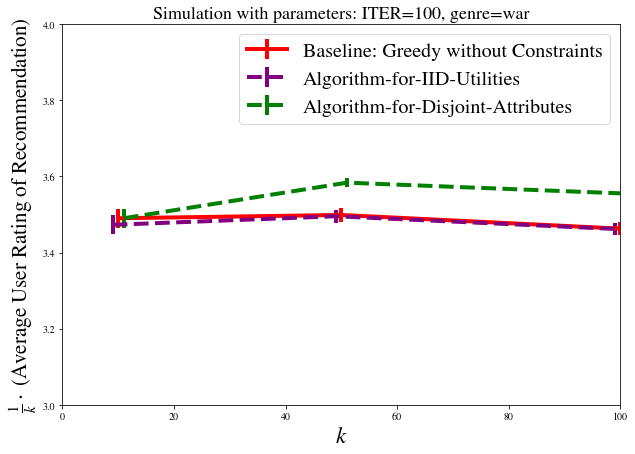

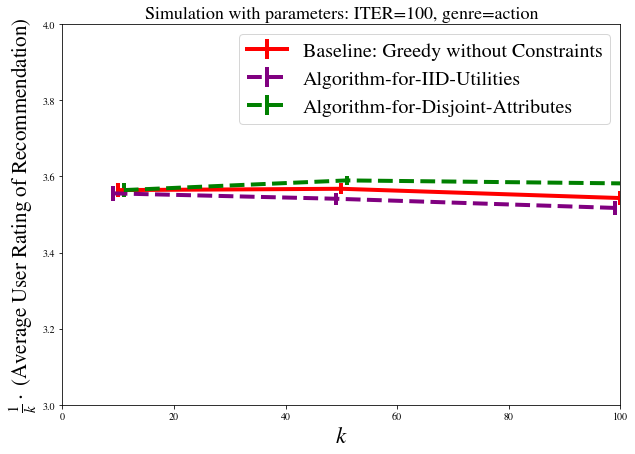

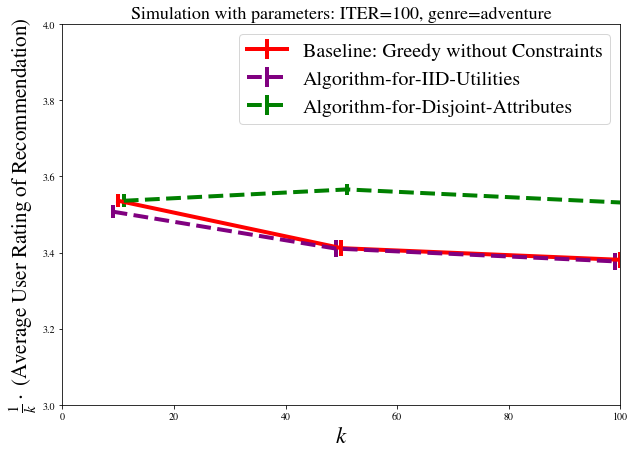

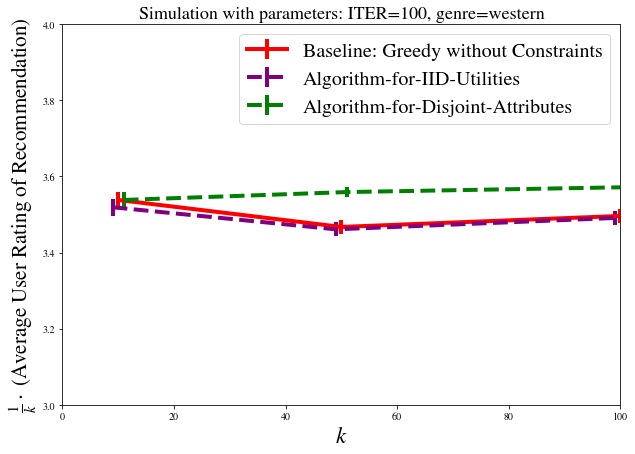

In [112]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

for g in [18, 1, 2, 19]: 
    weight_F = np.zeros(20)
#     for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []

    x = []

    print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

    for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
    #     for ijk in tqdm(range(ITERS)):
            u_id = selected_users[user_draws[ijk]]


            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    ggg = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][ggg]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)

            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 


            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            print('#'*15 + f' iteration {ijk} ' + '#'*15)
            print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
            print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
            print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
            print('#'*50)
            print(g)

            

        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))
        
            
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)


    print(f'y1: {y1}')
    print(f'y4: {y4}')
    print(f'y5: {y5}')
    print(f'y1_err: {y1_err}')
    print(f'y4_err: {y4_err}')
    print(f'y5_err: {y5_err}')

    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[g]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=3.8574104518457077 and score-std=0.1352867625602872
max: -1, min: 100000000.0
score-mean=3.753505093652651 and score-std=0.17800076591426228
max: -1, min: 100000000.0
score-mean=3.8574104518457077 and score-std=0.13528676256028724
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.8574104518457077, 0.0
util_algo_2_greedy_cons: 3.753505093652651, 0.0
util_algo_3_disjoint_attr: 3.8574104518457077, 0.0
##################################################
6
max: -1, min: 100000000.0
score-mean=3.7825094870105103 and score-std=0.34411311502912684
max: -1, min: 100000000.0
score-mean=3.7391524118003248 and score-std=0.3484825579262277
max: -1, min: 100000000.0
score-mean=3.782509487010511 and score-std=0.34411311502912684
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.8199599694281092, 0.026481490076191636
util_algo_2_greedy_cons: 3.746328752726488,

max: -1, min: 100000000.0
score-mean=3.7300451340635226 and score-std=0.36028823580093655
max: -1, min: 100000000.0
score-mean=3.7129667753045674 and score-std=0.35046848008733855
max: -1, min: 100000000.0
score-mean=3.7300451340635226 and score-std=0.3602882358009365
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.7978840009152686, 0.023751887910172072
util_algo_2_greedy_cons: 3.7700810105138034, 0.028263290613812164
util_algo_3_disjoint_attr: 3.7978840009152686, 0.023751887910172142
##################################################
6
max: -1, min: 100000000.0
score-mean=3.5084907893606276 and score-std=0.4246164736856909
max: -1, min: 100000000.0
score-mean=3.7048371784715792 and score-std=0.4149128883603389
max: -1, min: 100000000.0
score-mean=3.5084907893606276 and score-std=0.42461647368569094
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.780860870823819, 0.027793418012119427
util_algo_2_greedy_cons: 3.7662431380407315, 0.

max: -1, min: 100000000.0
score-mean=3.7515993532189853 and score-std=0.233636266688861
max: -1, min: 100000000.0
score-mean=3.756662780292803 and score-std=0.2369749142001327
max: -1, min: 100000000.0
score-mean=3.751599353218986 and score-std=0.233636266688861
############### iteration 87 ###############
util_baseline_greedy_uncons: 3.767538277180078, 0.019781095397149676
util_algo_2_greedy_cons: 3.7443778592494605, 0.02103201156266632
util_algo_3_disjoint_attr: 3.767538277180078, 0.019781095397149704
##################################################
6
max: -1, min: 100000000.0
score-mean=3.609121743190356 and score-std=0.14027236880444915
max: -1, min: 100000000.0
score-mean=3.619002062339292 and score-std=0.15114480516305628
max: -1, min: 100000000.0
score-mean=3.609121743190356 and score-std=0.14027236880444915
############### iteration 94 ###############
util_baseline_greedy_uncons: 3.7625877604928992, 0.01977270530272367
util_algo_2_greedy_cons: 3.740459865596018, 0.02073648619

max: -1, min: 100000000.0
score-mean=3.841046099792841 and score-std=0.2737062442510197
max: -1, min: 100000000.0
score-mean=3.841046099792841 and score-std=0.2737062442510197
max: -1, min: 100000000.0
score-mean=3.841046099792842 and score-std=0.2737062442510197
############### iteration 126 ###############
util_baseline_greedy_uncons: 3.7640906564231718, 0.01597172002479929
util_algo_2_greedy_cons: 3.750408973187462, 0.017241727418771537
util_algo_3_disjoint_attr: 3.7640906564231718, 0.01597172002479931
##################################################
6
max: -1, min: 100000000.0
score-mean=4.0341464120569235 and score-std=0.18709323584680873
max: -1, min: 100000000.0
score-mean=3.9987600583313814 and score-std=0.19013774033127953
max: -1, min: 100000000.0
score-mean=4.034146412056924 and score-std=0.1870932358468087
############### iteration 129 ###############
util_baseline_greedy_uncons: 3.769836523564315, 0.016633361694498472
util_algo_2_greedy_cons: 3.7556930388288223, 0.017666

max: -1, min: 100000000.0
score-mean=3.8348231871561502 and score-std=0.36307805346047234
max: -1, min: 100000000.0
score-mean=3.825094715073372 and score-std=0.3556987290645381
max: -1, min: 100000000.0
score-mean=3.8348231871561493 and score-std=0.3630780534604723
############### iteration 162 ###############
util_baseline_greedy_uncons: 3.7685020597423775, 0.014961853714133468
util_algo_2_greedy_cons: 3.7501510299957097, 0.015429051781187133
util_algo_3_disjoint_attr: 3.7685020597423775, 0.014961853714133484
##################################################
6
max: -1, min: 100000000.0
score-mean=3.8856956366888986 and score-std=0.09221953110076803
max: -1, min: 100000000.0
score-mean=3.874381805514208 and score-std=0.10148699950005849
max: -1, min: 100000000.0
score-mean=3.885695636688898 and score-std=0.09221953110076803
############### iteration 164 ###############
util_baseline_greedy_uncons: 3.7703922787253856, 0.014839454378535146
util_algo_2_greedy_cons: 3.752154752181492, 0.

max: -1, min: 100000000.0
score-mean=3.7606618086819816 and score-std=0.3007111800986574
max: -1, min: 100000000.0
score-mean=3.7190133683098834 and score-std=0.2543630268759638
max: -1, min: 100000000.0
score-mean=3.7606618086819816 and score-std=0.3007111800986574
############### iteration 187 ###############
util_baseline_greedy_uncons: 3.772030968379022, 0.01300973848872564
util_algo_2_greedy_cons: 3.755228299284213, 0.013162702667633655
util_algo_3_disjoint_attr: 3.772030968379022, 0.013009738488725652
##################################################
6
max: -1, min: 100000000.0
score-mean=3.8098375906558637 and score-std=0.2779417108222518
max: -1, min: 100000000.0
score-mean=3.808672570761627 and score-std=0.2777864925103762
max: -1, min: 100000000.0
score-mean=3.809837590655863 and score-std=0.2779417108222518
############### iteration 188 ###############
util_baseline_greedy_uncons: 3.7725219634735265, 0.012850042725948179
util_algo_2_greedy_cons: 3.7559223807319717, 0.013010

max: -1, min: 100000000.0
score-mean=3.883825526864136 and score-std=0.21514764955923876
max: -1, min: 100000000.0
score-mean=3.8858004953832195 and score-std=0.2162028915996631
max: -1, min: 100000000.0
score-mean=3.883825526864136 and score-std=0.21514764955923876
############### iteration 226 ###############
util_baseline_greedy_uncons: 3.760190466954797, 0.012977229530283095
util_algo_2_greedy_cons: 3.742799665241321, 0.013014080988315632
util_algo_3_disjoint_attr: 3.760190466954797, 0.012977229530283104
##################################################
6
max: -1, min: 100000000.0
score-mean=3.843369582518237 and score-std=0.260746151264242
max: -1, min: 100000000.0
score-mean=3.8392505965751598 and score-std=0.2643595564832555
max: -1, min: 100000000.0
score-mean=3.843369582518238 and score-std=0.260746151264242
############### iteration 228 ###############
util_baseline_greedy_uncons: 3.761094587776139, 0.012867629096587414
util_algo_2_greedy_cons: 3.7438480449297318, 0.01291478

max: -1, min: 100000000.0
score-mean=3.68066339480128 and score-std=0.33360722892513334
max: -1, min: 100000000.0
score-mean=3.6721212222709956 and score-std=0.3273275310246913
max: -1, min: 100000000.0
score-mean=3.6621808467932953 and score-std=0.36066772470800573
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.808565567090025, 0.03433480714301761
util_algo_2_greedy_cons: 3.7987421631371174, 0.03423969797872005
util_algo_3_disjoint_attr: 3.7011779048249545, 0.037157340061253166
##################################################
6
max: -1, min: 100000000.0
score-mean=3.8853929891389236 and score-std=0.3049050202155743
max: -1, min: 100000000.0
score-mean=3.8481464775245326 and score-std=0.30253631049142565
max: -1, min: 100000000.0
score-mean=3.7208588023520353 and score-std=0.34448995156684586
############### iteration 31 ###############
util_baseline_greedy_uncons: 3.819540913097011, 0.031134628196769893
util_algo_2_greedy_cons: 3.80579992233532, 0.030066

max: -1, min: 100000000.0
score-mean=3.8604840235601525 and score-std=0.3216194154329816
max: -1, min: 100000000.0
score-mean=3.8491785060572856 and score-std=0.35417308458071545
max: -1, min: 100000000.0
score-mean=3.6731295252582665 and score-std=0.44321010722566523
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.82380617098281, 0.016457006891729055
util_algo_2_greedy_cons: 3.8085875298758674, 0.017301563543859633
util_algo_3_disjoint_attr: 3.70824248135236, 0.019190430604956725
##################################################
6
max: -1, min: 100000000.0
score-mean=3.7653778084693927 and score-std=0.2913793904644089
max: -1, min: 100000000.0
score-mean=3.7497231490173233 and score-std=0.28248534285218285
max: -1, min: 100000000.0
score-mean=3.6679097879366678 and score-std=0.40609127835586045
############### iteration 72 ###############
util_baseline_greedy_uncons: 3.821150336323109, 0.015921818539889172
util_algo_2_greedy_cons: 3.805911876200479, 0.0167

max: -1, min: 100000000.0
score-mean=3.7712295572614067 and score-std=0.2852184768444344
max: -1, min: 100000000.0
score-mean=3.7566236734483534 and score-std=0.29367188717786463
max: -1, min: 100000000.0
score-mean=3.777414229390837 and score-std=0.30526422700921113
############### iteration 119 ###############
util_baseline_greedy_uncons: 3.814707786054735, 0.012032764124879339
util_algo_2_greedy_cons: 3.797802524510133, 0.012553708010838648
util_algo_3_disjoint_attr: 3.708817443501686, 0.014022470519878942
##################################################
6
max: -1, min: 100000000.0
score-mean=3.6942581137248647 and score-std=0.27054524898719673
max: -1, min: 100000000.0
score-mean=3.6996745379764633 and score-std=0.27029270471965344
max: -1, min: 100000000.0
score-mean=3.7330911650909724 and score-std=0.2781316548844227
############### iteration 122 ###############
util_baseline_greedy_uncons: 3.8114523895052788, 0.012139934604299095
util_algo_2_greedy_cons: 3.795150416765979, 0.0

max: -1, min: 100000000.0
score-mean=3.8508714610857795 and score-std=0.3589387083230276
max: -1, min: 100000000.0
score-mean=3.867133780778439 and score-std=0.306103755472111
max: -1, min: 100000000.0
score-mean=3.6330475151221817 and score-std=0.5390841857869276
############### iteration 159 ###############
util_baseline_greedy_uncons: 3.782313533016072, 0.015380858270238528
util_algo_2_greedy_cons: 3.768266462112288, 0.015443896382647085
util_algo_3_disjoint_attr: 3.694384309366779, 0.012852545157232177
##################################################
6
max: -1, min: 100000000.0
score-mean=3.777528036184729 and score-std=0.27783645798402845
max: -1, min: 100000000.0
score-mean=3.735420825248575 and score-std=0.28779931722698354
max: -1, min: 100000000.0
score-mean=3.6283578164487578 and score-std=0.37997340668653856
############### iteration 167 ###############
util_baseline_greedy_uncons: 3.782221504230854, 0.015085347851158962
util_algo_2_greedy_cons: 3.7676348152495245, 0.01515

max: -1, min: 100000000.0
score-mean=3.835659324846329 and score-std=0.19169305485204002
max: -1, min: 100000000.0
score-mean=3.8351682273581993 and score-std=0.19182036148104428
max: -1, min: 100000000.0
score-mean=3.7489158024550293 and score-std=0.24988146146264295
############### iteration 216 ###############
util_baseline_greedy_uncons: 3.775353888983289, 0.014741816328691154
util_algo_2_greedy_cons: 3.7611407159783816, 0.014936807868507434
util_algo_3_disjoint_attr: 3.6855115320540737, 0.012942033403837087
##################################################
6
max: -1, min: 100000000.0
score-mean=3.6450506471275412 and score-std=0.33472931571692305
max: -1, min: 100000000.0
score-mean=3.6136667677293963 and score-std=0.3381801354980773
max: -1, min: 100000000.0
score-mean=3.574019696064442 and score-std=0.34027501655792725
############### iteration 218 ###############
util_baseline_greedy_uncons: 3.7734090644779794, 0.014649513698941088
util_algo_2_greedy_cons: 3.758939612273173, 0

max: -1, min: 100000000.0
score-mean=3.722606187544571 and score-std=0.4140652366195376
max: -1, min: 100000000.0
score-mean=3.730035099837297 and score-std=0.4171602380146727
max: -1, min: 100000000.0
score-mean=3.6862480731808684 and score-std=0.3806890996369713
############### iteration 253 ###############
util_baseline_greedy_uncons: 3.77892417406568, 0.01323295628330411
util_algo_2_greedy_cons: 3.7652814664283603, 0.013404387582081706
util_algo_3_disjoint_attr: 3.6892285396271567, 0.011630813084213973
##################################################
6
max: -1, min: 100000000.0
score-mean=3.9179273821710723 and score-std=0.26339148304467846
max: -1, min: 100000000.0
score-mean=3.9103884645420433 and score-std=0.28544877909354144
max: -1, min: 100000000.0
score-mean=3.7936272115176912 and score-std=0.3247971597761761
############### iteration 254 ###############
util_baseline_greedy_uncons: 3.780619335140136, 0.0131797078494829
util_algo_2_greedy_cons: 3.767051063966332, 0.0133572

max: -1, min: 100000000.0
score-mean=3.8798797020318934 and score-std=0.2795600464235086
max: -1, min: 100000000.0
score-mean=3.9123416888467673 and score-std=0.25215239044586124
max: -1, min: 100000000.0
score-mean=3.784240947348303 and score-std=0.35007197384877575
############### iteration 287 ###############
util_baseline_greedy_uncons: 3.787978835454688, 0.011790833497786158
util_algo_2_greedy_cons: 3.7759907520698412, 0.012060254555977357
util_algo_3_disjoint_attr: 3.692759624897329, 0.010425866157996417
##################################################
6
max: -1, min: 100000000.0
score-mean=3.657384384073237 and score-std=0.3332685441166298
max: -1, min: 100000000.0
score-mean=3.6649774973238203 and score-std=0.3381465632880397
max: -1, min: 100000000.0
score-mean=3.6567147361310304 and score-std=0.379626043225074
############### iteration 290 ###############
util_baseline_greedy_uncons: 3.7866325009043638, 0.011745892514892414
util_algo_2_greedy_cons: 3.774846285526068, 0.0119

max: -1, min: 100000000.0
score-mean=3.7599575304836788 and score-std=0.3452263892966843
max: -1, min: 100000000.0
score-mean=3.750239445759828 and score-std=0.33419902053341144
max: -1, min: 100000000.0
score-mean=3.587870556328588 and score-std=0.4060957994039907
############### iteration 47 ###############
util_baseline_greedy_uncons: 3.7273228468896225, 0.03467355314124049
util_algo_2_greedy_cons: 3.7138773333654855, 0.03526968416058583
util_algo_3_disjoint_attr: 3.6434493295805295, 0.03398879437533533
##################################################
6
max: -1, min: 100000000.0
score-mean=3.6902567142003284 and score-std=0.3736874451689416
max: -1, min: 100000000.0
score-mean=3.6904252992102884 and score-std=0.3778710939836696
max: -1, min: 100000000.0
score-mean=3.536392662351399 and score-std=0.4464979717273764
############### iteration 51 ###############
util_baseline_greedy_uncons: 3.7242340024988483, 0.03192137655158734
util_algo_2_greedy_cons: 3.711922997185886, 0.032384644

max: -1, min: 100000000.0
score-mean=3.5386182485349673 and score-std=0.40863268407836767
max: -1, min: 100000000.0
score-mean=3.5482160512977106 and score-std=0.38484907226155013
max: -1, min: 100000000.0
score-mean=3.475068536577607 and score-std=0.47628541602977237
############### iteration 91 ###############
util_baseline_greedy_uncons: 3.7217891465805266, 0.02008836243280441
util_algo_2_greedy_cons: 3.7103406176169695, 0.019917482646614578
util_algo_3_disjoint_attr: 3.6250074330634567, 0.01826626059834424
##################################################
6
max: -1, min: 100000000.0
score-mean=3.5418993850734934 and score-std=0.49792529537731145
max: -1, min: 100000000.0
score-mean=3.542368137597573 and score-std=0.5055869311514499
max: -1, min: 100000000.0
score-mean=3.4950379525971753 and score-std=0.5348615904098483
############### iteration 95 ###############
util_baseline_greedy_uncons: 3.715126562821007, 0.020419348325714844
util_algo_2_greedy_cons: 3.7041194146532885, 0.020

max: -1, min: 100000000.0
score-mean=3.83301128082941 and score-std=0.32221979470404855
max: -1, min: 100000000.0
score-mean=3.832735811793686 and score-std=0.3076982726000198
max: -1, min: 100000000.0
score-mean=3.6733562280085637 and score-std=0.41308562730425763
############### iteration 131 ###############
util_baseline_greedy_uncons: 3.7140305345137565, 0.018499040122875
util_algo_2_greedy_cons: 3.704147835900282, 0.01815527843949398
util_algo_3_disjoint_attr: 3.615315838270939, 0.016318153097225303
##################################################
6
max: -1, min: 100000000.0
score-mean=3.762935944718133 and score-std=0.3107043008444772
max: -1, min: 100000000.0
score-mean=3.7553892948727063 and score-std=0.3206783827900261
max: -1, min: 100000000.0
score-mean=3.524703142660199 and score-std=0.4777024842062651
############### iteration 140 ###############
util_baseline_greedy_uncons: 3.715194949042432, 0.018095196476273487
util_algo_2_greedy_cons: 3.705367870637721, 0.01776395577

max: -1, min: 100000000.0
score-mean=3.7308229960782153 and score-std=0.3001524939711619
max: -1, min: 100000000.0
score-mean=3.7399843374045205 and score-std=0.29368930097236595
max: -1, min: 100000000.0
score-mean=3.633854423114154 and score-std=0.35151939954724276
############### iteration 210 ###############
util_baseline_greedy_uncons: 3.7133203437349454, 0.015449556605624042
util_algo_2_greedy_cons: 3.70332444778576, 0.01557758828640636
util_algo_3_disjoint_attr: 3.6084950557674405, 0.014778457218960492
##################################################
6
max: -1, min: 100000000.0
score-mean=3.6945795692194237 and score-std=0.3996436988806602
max: -1, min: 100000000.0
score-mean=3.6808407808951147 and score-std=0.4057954347793624
max: -1, min: 100000000.0
score-mean=3.5399693745786185 and score-std=0.4662099077058908
############### iteration 219 ###############
util_baseline_greedy_uncons: 3.712991558217129, 0.01518200982938997
util_algo_2_greedy_cons: 3.702929997489433, 0.01530

max: -1, min: 100000000.0
score-mean=3.486267623544981 and score-std=0.4192871105422414
max: -1, min: 100000000.0
score-mean=3.4824171158146964 and score-std=0.4214560518088372
max: -1, min: 100000000.0
score-mean=3.494776585119815 and score-std=0.4173509570639078
############### iteration 264 ###############
util_baseline_greedy_uncons: 3.7151564389053062, 0.013844560679205815
util_algo_2_greedy_cons: 3.7051377227450475, 0.01397866767224867
util_algo_3_disjoint_attr: 3.6129481683292806, 0.013063618714766781
##################################################
6
max: -1, min: 100000000.0
score-mean=3.75693428414541 and score-std=0.3716134095159503
max: -1, min: 100000000.0
score-mean=3.75955769699268 and score-std=0.3718257934847762
max: -1, min: 100000000.0
score-mean=3.602683834955057 and score-std=0.39784022647324313
############### iteration 267 ###############
util_baseline_greedy_uncons: 3.715736686755863, 0.013664429265290132
util_algo_2_greedy_cons: 3.7058935557207087, 0.01380493

max: -1, min: 100000000.0
score-mean=3.7652731366994656 and score-std=0.29434798118137806
max: -1, min: 100000000.0
score-mean=3.757548607450025 and score-std=0.28226742671505944
max: -1, min: 100000000.0
score-mean=3.644352055918066 and score-std=0.35755897747394716
############### iteration 317 ###############
util_baseline_greedy_uncons: 3.7257214804427154, 0.011873437292264019
util_algo_2_greedy_cons: 3.7158629245454686, 0.011964083060394103
util_algo_3_disjoint_attr: 3.6222776267588643, 0.011495505115683799
##################################################
6
max: -1, min: 100000000.0
score-mean=3.7388578882358456 and score-std=0.37013737821520004
max: -1, min: 100000000.0
score-mean=3.700291874115095 and score-std=0.40311295628570837
max: -1, min: 100000000.0
score-mean=3.5482258730224494 and score-std=0.4781680350174814
############### iteration 322 ###############
util_baseline_greedy_uncons: 3.72587247363574, 0.011737921044178775
util_algo_2_greedy_cons: 3.7156839469543144, 0.

Genre: ['action', 'adventure', 'crime', 'war', 'western']
max: -1, min: 100000000.0
score-mean=4.011132291369532 and score-std=0.2207032837775239
max: -1, min: 100000000.0
score-mean=3.8346917917273595 and score-std=0.42114497613519697
max: -1, min: 100000000.0
score-mean=4.011132291369531 and score-std=0.2207032837775239
############### iteration 1 ###############
util_baseline_greedy_uncons: 4.011132291369532, 0.0
util_algo_2_greedy_cons: 3.8346917917273595, 0.0
util_algo_3_disjoint_attr: 4.011132291369531, 0.0
##################################################
15
max: -1, min: 100000000.0
score-mean=3.976203951381341 and score-std=0.1930530622589725
max: -1, min: 100000000.0
score-mean=3.9570208232486133 and score-std=0.18653175695578858
max: -1, min: 100000000.0
score-mean=3.976203951381342 and score-std=0.19305306225897254
############### iteration 4 ###############
util_baseline_greedy_uncons: 3.9936681213754364, 0.012349033030619478
util_algo_2_greedy_cons: 3.8958563074879864, 0

max: -1, min: 100000000.0
score-mean=3.6646659076732346 and score-std=0.4849584179443624
max: -1, min: 100000000.0
score-mean=3.680138471981097 and score-std=0.5205547871373143
max: -1, min: 100000000.0
score-mean=3.6646659076732346 and score-std=0.4849584179443624
############### iteration 46 ###############
util_baseline_greedy_uncons: 3.8019351721393497, 0.052310754935671826
util_algo_2_greedy_cons: 3.7655394767035126, 0.04019047572980218
util_algo_3_disjoint_attr: 3.8019351721393497, 0.052310754935671895
##################################################
15
max: -1, min: 100000000.0
score-mean=3.949183189980489 and score-std=0.4081232079850402
max: -1, min: 100000000.0
score-mean=3.7680633245952295 and score-std=0.3866276214966292
max: -1, min: 100000000.0
score-mean=3.949183189980489 and score-std=0.40812320798504026
############### iteration 49 ###############
util_baseline_greedy_uncons: 3.8105968202476523, 0.049945604640499776
util_algo_2_greedy_cons: 3.765687938344202, 0.03782

max: -1, min: 100000000.0
score-mean=3.8446341862025326 and score-std=0.3584857503617875
max: -1, min: 100000000.0
score-mean=3.993976704751275 and score-std=0.16419905403923338
max: -1, min: 100000000.0
score-mean=3.8446341862025326 and score-std=0.3584857503617875
############### iteration 96 ###############
util_baseline_greedy_uncons: 3.824802345730418, 0.031680266435511285
util_algo_2_greedy_cons: 3.7858978621757235, 0.026281013444479754
util_algo_3_disjoint_attr: 3.824802345730418, 0.031680266435511334
##################################################
15
max: -1, min: 100000000.0
score-mean=4.011178242874331 and score-std=0.20113454970438097
max: -1, min: 100000000.0
score-mean=4.040516926628555 and score-std=0.10409784566026786
max: -1, min: 100000000.0
score-mean=4.011178242874331 and score-std=0.20113454970438097
############### iteration 107 ###############
util_baseline_greedy_uncons: 3.8306265925161656, 0.031221046356761647
util_algo_2_greedy_cons: 3.793854707939875, 0.026

max: -1, min: 100000000.0
score-mean=3.917753916443437 and score-std=0.2930714358921803
max: -1, min: 100000000.0
score-mean=3.8162869015800496 and score-std=0.3345354185363723
max: -1, min: 100000000.0
score-mean=3.9177539164434365 and score-std=0.2930714358921803
############### iteration 139 ###############
util_baseline_greedy_uncons: 3.817277156552504, 0.024890630974469575
util_algo_2_greedy_cons: 3.7922800947995983, 0.022067467338439922
util_algo_3_disjoint_attr: 3.817277156552504, 0.0248906309744696
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7524159520008147 and score-std=0.36542089814917045
max: -1, min: 100000000.0
score-mean=3.772720905268291 and score-std=0.3160687679901509
max: -1, min: 100000000.0
score-mean=3.7524159520008142 and score-std=0.3654208981491704
############### iteration 141 ###############
util_baseline_greedy_uncons: 3.815897130923745, 0.0243992698680861
util_algo_2_greedy_cons: 3.7918639418308473, 0.0216018

max: -1, min: 100000000.0
score-mean=3.96905732841378 and score-std=0.31906673573213096
max: -1, min: 100000000.0
score-mean=3.9856807711074858 and score-std=0.25285094087511384
max: -1, min: 100000000.0
score-mean=3.96905732841378 and score-std=0.31906673573213096
############### iteration 208 ###############
util_baseline_greedy_uncons: 3.8402316982005837, 0.021687658297519397
util_algo_2_greedy_cons: 3.812783916964384, 0.01891593011445298
util_algo_3_disjoint_attr: 3.8402316982005837, 0.021687658297519417
##################################################
15
max: -1, min: 100000000.0
score-mean=4.008960922676485 and score-std=0.24589849919671017
max: -1, min: 100000000.0
score-mean=3.951406224753625 and score-std=0.2358682019530243
max: -1, min: 100000000.0
score-mean=4.008960922676485 and score-std=0.24589849919671017
############### iteration 209 ###############
util_baseline_greedy_uncons: 3.8429531373050336, 0.02150792719119032
util_algo_2_greedy_cons: 3.8150197606384038, 0.0187

max: -1, min: 100000000.0
score-mean=4.00757394168527 and score-std=0.19528862996381577
max: -1, min: 100000000.0
score-mean=4.021689482478985 and score-std=0.19971066443697658
max: -1, min: 100000000.0
score-mean=4.00757394168527 and score-std=0.19528862996381577
############### iteration 237 ###############
util_baseline_greedy_uncons: 3.8383335065317907, 0.019290220389328278
util_algo_2_greedy_cons: 3.8148534131879983, 0.017299413530273648
util_algo_3_disjoint_attr: 3.8383335065317907, 0.019290220389328292
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7814479409466437 and score-std=0.27853914633839577
max: -1, min: 100000000.0
score-mean=3.871064988232559 and score-std=0.23092208969054107
max: -1, min: 100000000.0
score-mean=3.7814479409466437 and score-std=0.27853914633839577
############### iteration 239 ###############
util_baseline_greedy_uncons: 3.8375947329527627, 0.019053839507355598
util_algo_2_greedy_cons: 3.815583433643122, 0.

max: -1, min: 100000000.0
score-mean=3.690836812273391 and score-std=0.2501083788954563
max: -1, min: 100000000.0
score-mean=3.7445720755081395 and score-std=0.27088576601504005
max: -1, min: 100000000.0
score-mean=3.690836812273391 and score-std=0.25010837889545634
############### iteration 287 ###############
util_baseline_greedy_uncons: 3.846432891855819, 0.017190393375675406
util_algo_2_greedy_cons: 3.8241824729602603, 0.015116192042219485
util_algo_3_disjoint_attr: 3.846432891855819, 0.017190393375675413
##################################################
15
max: -1, min: 100000000.0
score-mean=3.688069337200787 and score-std=0.3764864617608057
max: -1, min: 100000000.0
score-mean=3.6803095934994845 and score-std=0.3309151202593516
max: -1, min: 100000000.0
score-mean=3.688069337200787 and score-std=0.3764864617608057
############### iteration 290 ###############
util_baseline_greedy_uncons: 3.844711548870438, 0.017089506451757497
util_algo_2_greedy_cons: 3.8226186373139477, 0.0150

max: -1, min: 100000000.0
score-mean=3.7551656351514384 and score-std=0.4409703112844691
max: -1, min: 100000000.0
score-mean=3.754260559817721 and score-std=0.42694653292290996
max: -1, min: 100000000.0
score-mean=3.6738294928678306 and score-std=0.38545644600547374
############### iteration 9 ###############
util_baseline_greedy_uncons: 3.8185725232128642, 0.060556748318707186
util_algo_2_greedy_cons: 3.800632670409616, 0.06547932071856682
util_algo_3_disjoint_attr: 3.6932612329068135, 0.06610513569769923
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7156171704583305 and score-std=0.3683686373176852
max: -1, min: 100000000.0
score-mean=3.7027350220154602 and score-std=0.4188416866168314
max: -1, min: 100000000.0
score-mean=3.5869643150412984 and score-std=0.4422207088143524
############### iteration 10 ###############
util_baseline_greedy_uncons: 3.803864615676502, 0.053662181883765855
util_algo_2_greedy_cons: 3.786647292067594, 0.057599

max: -1, min: 100000000.0
score-mean=3.9071745550056836 and score-std=0.2959316216078208
max: -1, min: 100000000.0
score-mean=3.921121306579465 and score-std=0.30846903878524035
max: -1, min: 100000000.0
score-mean=3.8332321852908002 and score-std=0.3460018362983004
############### iteration 60 ###############
util_baseline_greedy_uncons: 3.782307863310437, 0.027165798776767187
util_algo_2_greedy_cons: 3.771717080160927, 0.0297678834971608
util_algo_3_disjoint_attr: 3.678091912622729, 0.026915879560404726
##################################################
15
max: -1, min: 100000000.0
score-mean=3.888421286019021 and score-std=0.34132224912859477
max: -1, min: 100000000.0
score-mean=3.908280507547332 and score-std=0.31593254283580796
max: -1, min: 100000000.0
score-mean=3.8255232466517106 and score-std=0.3488124862324432
############### iteration 71 ###############
util_baseline_greedy_uncons: 3.7871312007062814, 0.026355707760019588
util_algo_2_greedy_cons: 3.777924508678491, 0.0290548

max: -1, min: 100000000.0
score-mean=3.8399401969213267 and score-std=0.33980003793820757
max: -1, min: 100000000.0
score-mean=3.845530070517922 and score-std=0.34545062157946566
max: -1, min: 100000000.0
score-mean=3.696632759599623 and score-std=0.3757865653716551
############### iteration 115 ###############
util_baseline_greedy_uncons: 3.797538917643148, 0.018813229829374074
util_algo_2_greedy_cons: 3.7889671362035386, 0.021147153631228623
util_algo_3_disjoint_attr: 3.6980642573721068, 0.01786232805973335
##################################################
15
max: -1, min: 100000000.0
score-mean=3.412146720824621 and score-std=0.45595288668332973
max: -1, min: 100000000.0
score-mean=3.4201186777944543 and score-std=0.4380579048986753
max: -1, min: 100000000.0
score-mean=3.466195403196484 and score-std=0.4077824656471614
############### iteration 116 ###############
util_baseline_greedy_uncons: 3.787122912323728, 0.0209910769126739
util_algo_2_greedy_cons: 3.778998258949239, 0.022804

max: -1, min: 100000000.0
score-mean=3.8549290431078362 and score-std=0.2723298670004686
max: -1, min: 100000000.0
score-mean=3.8524878833325262 and score-std=0.27544652903382716
max: -1, min: 100000000.0
score-mean=3.84519224685943 and score-std=0.22530162602158393
############### iteration 178 ###############
util_baseline_greedy_uncons: 3.7870174407793913, 0.01863460676197385
util_algo_2_greedy_cons: 3.7791479907016656, 0.01951672562855353
util_algo_3_disjoint_attr: 3.69153948957061, 0.016119973865032534
##################################################
15
max: -1, min: 100000000.0
score-mean=3.941574052494464 and score-std=0.20624445693026638
max: -1, min: 100000000.0
score-mean=3.956361796669159 and score-std=0.2035395394844891
max: -1, min: 100000000.0
score-mean=3.7982947214038485 and score-std=0.3071650903229578
############### iteration 182 ###############
util_baseline_greedy_uncons: 3.7899896833123736, 0.018511769554065957
util_algo_2_greedy_cons: 3.782555948508733, 0.01943

max: -1, min: 100000000.0
score-mean=3.776742530191648 and score-std=0.31038875589478526
max: -1, min: 100000000.0
score-mean=3.744673028145126 and score-std=0.3052875159770849
max: -1, min: 100000000.0
score-mean=3.696062515416712 and score-std=0.4217073031942164
############### iteration 225 ###############
util_baseline_greedy_uncons: 3.789469569077204, 0.01640706360448589
util_algo_2_greedy_cons: 3.7779378108361525, 0.01741387749610507
util_algo_3_disjoint_attr: 3.697768630772224, 0.014066179886066168
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7478670765077795 and score-std=0.3875258392555037
max: -1, min: 100000000.0
score-mean=3.742834834518805 and score-std=0.3915679034456714
max: -1, min: 100000000.0
score-mean=3.7182566894775197 and score-std=0.3881459499848792
############### iteration 226 ###############
util_baseline_greedy_uncons: 3.788848636352287, 0.01617392752985119
util_algo_2_greedy_cons: 3.777413885816491, 0.017161848

max: -1, min: 100000000.0
score-mean=3.84687807076669 and score-std=0.3119648179434401
max: -1, min: 100000000.0
score-mean=3.6641130417685024 and score-std=0.45349162313571645
max: -1, min: 100000000.0
score-mean=3.7149034451464225 and score-std=0.3968386554287008
############### iteration 271 ###############
util_baseline_greedy_uncons: 3.796763416285615, 0.014147327296854136
util_algo_2_greedy_cons: 3.7830562034428414, 0.0151610216861326
util_algo_3_disjoint_attr: 3.7069628295373414, 0.012551214806948553
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7198627814468925 and score-std=0.4287056008839718
max: -1, min: 100000000.0
score-mean=3.706272793789756 and score-std=0.39640021258432073
max: -1, min: 100000000.0
score-mean=3.6106746971231245 and score-std=0.3961252724852661
############### iteration 272 ###############
util_baseline_greedy_uncons: 3.795825603665631, 0.014005847768401808
util_algo_2_greedy_cons: 3.7821198203982918, 0.0150

max: -1, min: 100000000.0
score-mean=3.744123989628639 and score-std=0.27253747543258117
max: -1, min: 100000000.0
score-mean=3.731521058359375 and score-std=0.26703414939788417
max: -1, min: 100000000.0
score-mean=3.7098049129614763 and score-std=0.2910181759700737
############### iteration 325 ###############
util_baseline_greedy_uncons: 3.7932617847260857, 0.012679290370188468
util_algo_2_greedy_cons: 3.778927361415814, 0.013488477779152717
util_algo_3_disjoint_attr: 3.705446011138669, 0.011235209123882721
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7546738216457847 and score-std=0.38941610652529685
max: -1, min: 100000000.0
score-mean=3.7905927780722273 and score-std=0.33720527412553497
max: -1, min: 100000000.0
score-mean=3.7124921557281767 and score-std=0.4778997873002161
############### iteration 328 ###############
util_baseline_greedy_uncons: 3.7928639706737113, 0.012554815214016577
util_algo_2_greedy_cons: 3.7790476234431996, 0

max: -1, min: 100000000.0
score-mean=3.6469769656767665 and score-std=0.39444480912448066
max: -1, min: 100000000.0
score-mean=3.659645066862512 and score-std=0.3726011441747758
max: -1, min: 100000000.0
score-mean=3.566445107762504 and score-std=0.4603401631711472
############### iteration 22 ###############
util_baseline_greedy_uncons: 3.7113697170692133, 0.026415817520186523
util_algo_2_greedy_cons: 3.6958347010993466, 0.03458669670807943
util_algo_3_disjoint_attr: 3.6226217781471743, 0.031110790109343287
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7709012768884054 and score-std=0.330183795088495
max: -1, min: 100000000.0
score-mean=3.773388397760972 and score-std=0.3048581220789715
max: -1, min: 100000000.0
score-mean=3.698971258520362 and score-std=0.3774730929573264
############### iteration 23 ###############
util_baseline_greedy_uncons: 3.716330680387479, 0.024675943916483447
util_algo_2_greedy_cons: 3.7022975091544823, 0.0323026

max: -1, min: 100000000.0
score-mean=3.6958187435086156 and score-std=0.44899529027647955
max: -1, min: 100000000.0
score-mean=3.685078978953739 and score-std=0.45607683746748173
max: -1, min: 100000000.0
score-mean=3.7248935975393613 and score-std=0.4280974424085624
############### iteration 56 ###############
util_baseline_greedy_uncons: 3.7596757554831295, 0.018748680393323912
util_algo_2_greedy_cons: 3.7487839865747463, 0.0210727154031424
util_algo_3_disjoint_attr: 3.6764481534112616, 0.023508925865423493
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7218376910990316 and score-std=0.3702827193739564
max: -1, min: 100000000.0
score-mean=3.714618299647686 and score-std=0.3762669904650677
max: -1, min: 100000000.0
score-mean=3.5739472097482605 and score-std=0.42674087889933404
############### iteration 62 ###############
util_baseline_greedy_uncons: 3.7582743456911256, 0.018106584741897795
util_algo_2_greedy_cons: 3.747518590762633, 0.020

max: -1, min: 100000000.0
score-mean=3.886597204829465 and score-std=0.20448660543685457
max: -1, min: 100000000.0
score-mean=3.88315383103982 and score-std=0.2070753254093843
max: -1, min: 100000000.0
score-mean=3.827368681817975 and score-std=0.2718416002273947
############### iteration 102 ###############
util_baseline_greedy_uncons: 3.744808160254027, 0.01654263717506702
util_algo_2_greedy_cons: 3.731326943852566, 0.01841022908982268
util_algo_3_disjoint_attr: 3.6614384047559296, 0.018823801055741395
##################################################
15
max: -1, min: 100000000.0
score-mean=3.2432774554453356 and score-std=0.4951651769325499
max: -1, min: 100000000.0
score-mean=3.178946272252006 and score-std=0.5406817871971963
max: -1, min: 100000000.0
score-mean=3.2709146151107076 and score-std=0.4888451875629726
############### iteration 107 ###############
util_baseline_greedy_uncons: 3.732866952996677, 0.0199994994796283
util_algo_2_greedy_cons: 3.7181750231001716, 0.0221775439

max: -1, min: 100000000.0
score-mean=3.6833516036714915 and score-std=0.4000210412160307
max: -1, min: 100000000.0
score-mean=3.668155083829818 and score-std=0.4118099242905848
max: -1, min: 100000000.0
score-mean=3.6788854565043683 and score-std=0.3867839884993044
############### iteration 159 ###############
util_baseline_greedy_uncons: 3.737851939591657, 0.017441780081778147
util_algo_2_greedy_cons: 3.724416674435175, 0.0190703231654095
util_algo_3_disjoint_attr: 3.6607196662138883, 0.017909643165294524
##################################################
15
max: -1, min: 100000000.0
score-mean=3.706667262575242 and score-std=0.36437035558640346
max: -1, min: 100000000.0
score-mean=3.698549092569666 and score-std=0.38832423226051876
max: -1, min: 100000000.0
score-mean=3.7238066590558496 and score-std=0.3565435821701827
############### iteration 164 ###############
util_baseline_greedy_uncons: 3.737304839994878, 0.017144362280775215
util_algo_2_greedy_cons: 3.723962857209464, 0.018741

max: -1, min: 100000000.0
score-mean=3.6966914279441743 and score-std=0.3870058006192342
max: -1, min: 100000000.0
score-mean=3.7231726269619276 and score-std=0.34146491299898935
max: -1, min: 100000000.0
score-mean=3.6326578290812908 and score-std=0.38989335253295554
############### iteration 222 ###############
util_baseline_greedy_uncons: 3.726129339264941, 0.01636494929577636
util_algo_2_greedy_cons: 3.7163569291197316, 0.017148809254502538
util_algo_3_disjoint_attr: 3.655533684122578, 0.016169224903812507
##################################################
15
max: -1, min: 100000000.0
score-mean=3.8543896883100586 and score-std=0.29165361320375466
max: -1, min: 100000000.0
score-mean=3.851198106117297 and score-std=0.38181997707728743
max: -1, min: 100000000.0
score-mean=3.7026826446709316 and score-std=0.45069541167851174
############### iteration 226 ###############
util_baseline_greedy_uncons: 3.7279107330016776, 0.016234324920786587
util_algo_2_greedy_cons: 3.718229723244698, 0

max: -1, min: 100000000.0
score-mean=3.72523926857071 and score-std=0.3390404056192057
max: -1, min: 100000000.0
score-mean=3.674272479139702 and score-std=0.4111247631895951
max: -1, min: 100000000.0
score-mean=3.5524624615442337 and score-std=0.4787060299398656
############### iteration 262 ###############
util_baseline_greedy_uncons: 3.72627427332021, 0.014638263018393322
util_algo_2_greedy_cons: 3.7165913127278873, 0.015394038609725665
util_algo_3_disjoint_attr: 3.650866571511978, 0.014438640026037619
##################################################
15
max: -1, min: 100000000.0
score-mean=3.7311817735447192 and score-std=0.3565258764622464
max: -1, min: 100000000.0
score-mean=3.655373821055731 and score-std=0.4263759999585107
max: -1, min: 100000000.0
score-mean=3.655553385848325 and score-std=0.4052815643184823
############### iteration 263 ###############
util_baseline_greedy_uncons: 3.726330681368768, 0.014470115804470099
util_algo_2_greedy_cons: 3.715887663398322, 0.015233168

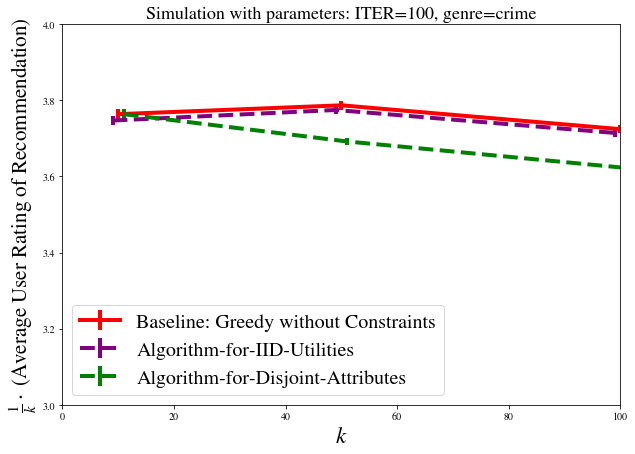

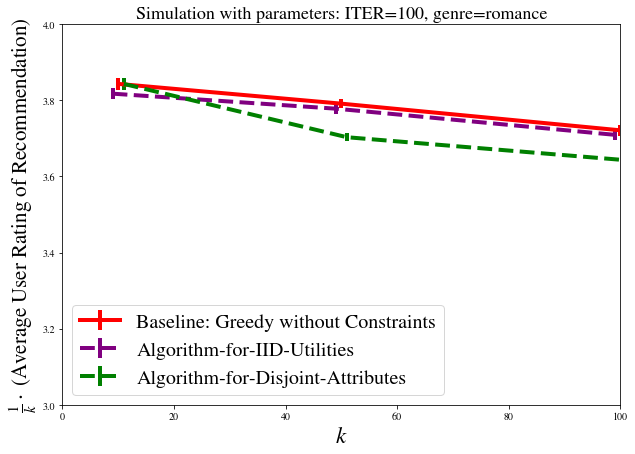

In [113]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

# action 1
# adventure 2
# crime 6
# romance 15
# war 18
# western 19

for g in [6, 15]: 
    weight_F = np.zeros(20)
#     for g in [1, 2, 6, 18, 19]: 
    weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []

    x = []

    print(f'Genre: {[genres[g] for g in [1, 2, 6, 18, 19]]}')

    for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
    #     for ijk in tqdm(range(ITERS)):
            u_id = selected_users[user_draws[ijk]]


            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    ggg = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][ggg]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)

            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 


            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            print('#'*15 + f' iteration {ijk} ' + '#'*15)
            print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
            print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
            print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
            print('#'*50)
            print(g)

            

        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_3_disjoint_attr)))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr)))
        
            
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)


    print(f'y1: {y1}')
    print(f'y4: {y4}')
    print(f'y5: {y5}')
    print(f'y1_err: {y1_err}')
    print(f'y4_err: {y4_err}')
    print(f'y5_err: {y5_err}')

    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[g]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

In [73]:
##########################################
#### Functions for plotting Functions  ###
##########################################
exec(open('../utils.py').read())
##########################################
####### Fetch: Helper Functions  #########
##########################################
exec(open('../neurips-2022-utils.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('../neurips-2022-algorithms.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('simulation-utils.py').read())
import itertools

Genre: ['western', 'war']
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 2 ###############
util_baseline_greedy_uncons: 3.6218553814838175, 0.0
util_algo_2_greedy_cons: 3.6163745459323606, 0.0
util_algo_3_disjoint_attr: 3.621855381483818, 0.0
##################################################
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 13 ###############
util_baseline_greedy_uncons: 3.5017275074549445, 0.14084635006936438
util_algo_2_greedy_cons: 3.5274255176108853, 0.12713095647449563
util_algo_3_disjoint_attr: 3.501727507454945, 0.1408463500693644
##################################################
############### iteration 25 ###############
util_baseline_greedy_uncons: 3.448426575820347, 0.10042492849065206
util_algo_2_greedy_cons: 3.483344045519242, 0.08299923159832158
util_algo_3_disjoint_attr: 3.448426575820347, 0.10042492849065202
##################################################
############### iteration 36 ###############
util_

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.41421

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951


KeyboardInterrupt: 

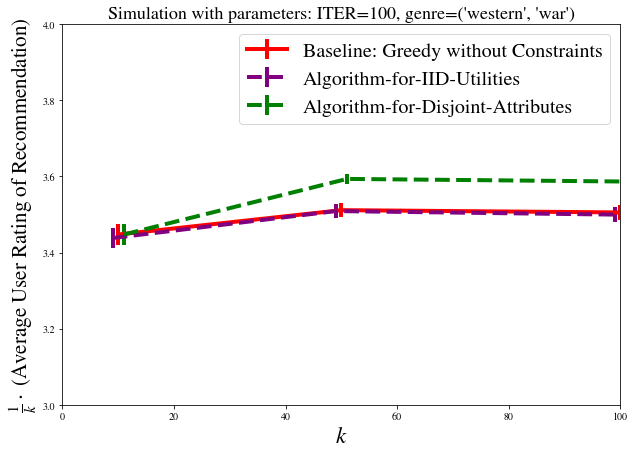

In [69]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

prev = -1000

fg=0
iterator = list(itertools.product([1, 2, 6, 18, 19], repeat=2))
iterator.reverse()
for gen in iterator:
    if gen[0]==gen[1]: continue 
    
    weight_F = np.zeros(20)
    for g in gen: 
        weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []
    
    x = []
    
    print(f'Genre: {[genres[g] for g in gen]}')

    for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
            u_id = selected_users[user_draws[ijk]]

            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)
            
            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 

            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            
            if ijk > prev + 10:
                prev = ijk
                print('#'*15 + f' iteration {ijk} ' + '#'*15)
                print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
                print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
                print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
                print('#'*50)
            
        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(ITERS))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(ITERS))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(ITERS))
        
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[gen[0]], genres[gen[1]]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

Genre: ['western', 'war']
############### iteration 6 ###############
util_baseline_greedy_uncons: 3.8478404372388475, 0.0
util_algo_2_greedy_cons: 3.8270394591358596, 0.0
util_algo_3_disjoint_attr: 3.8478404372388475, 0.0
##################################################
############### iteration 17 ###############
util_baseline_greedy_uncons: 3.4559122561079767, 0.10191671886184613
util_algo_2_greedy_cons: 3.470965294576214, 0.07945293939996477
util_algo_3_disjoint_attr: 3.4559122561079767, 0.10191671886184615
##################################################
############### iteration 28 ###############
util_baseline_greedy_uncons: 3.4224314554373336, 0.06816575803375736
util_algo_2_greedy_cons: 3.4348193723740303, 0.057694739180097376
util_algo_3_disjoint_attr: 3.4224314554373336, 0.06816575803375738
##################################################
############### iteration 39 ###############
util_baseline_greedy_uncons: 3.425529238971146, 0.057070892393942814
util_algo_2_greedy

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
./figs/H01M12S11_05-16-22vwezr.p

func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
./figs/H03M24S45_05-16-22qqnxc.pdf
Genre: ['crime', 'war']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 337 ###############
util_baseline_greedy_uncons: 3.77736149045199, 0.01081038358474451
util_algo_2_greedy_cons: 3.764054292597081, 0.011354963612430068
util_algo_3_disjoint_attr: 3.6776222089102557, 0.010644480325612587
##################################################
############### iteration 351 ###############
util_baseline_greedy_uncons: 3.7741344859839425, 0.010525650094347045
util_algo_2_greedy_cons: 3.7596660330073335, 0.011241613912

KeyboardInterrupt: 

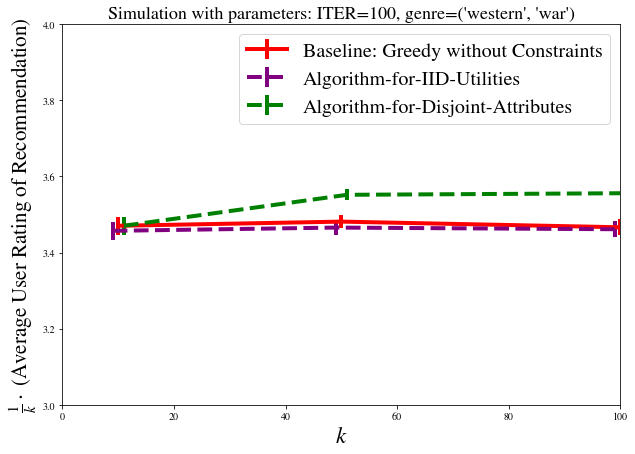

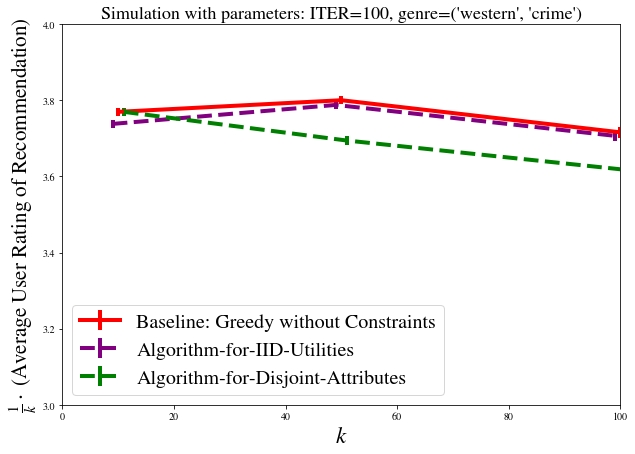

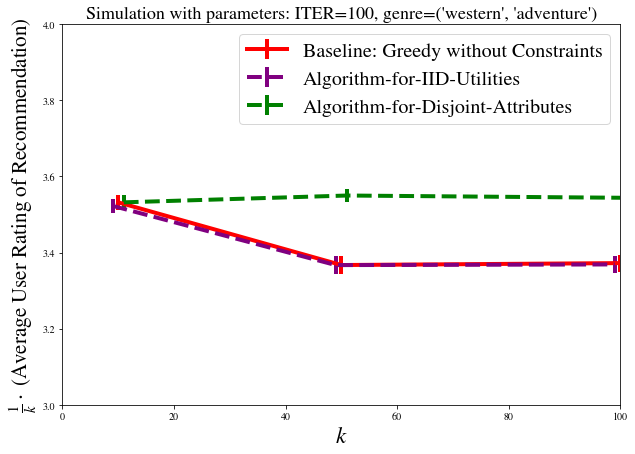

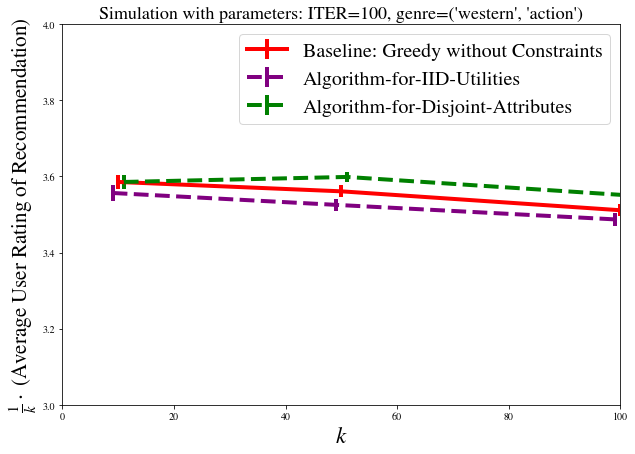

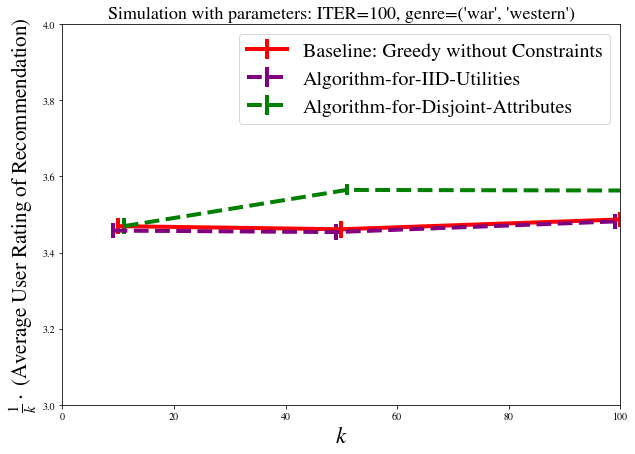

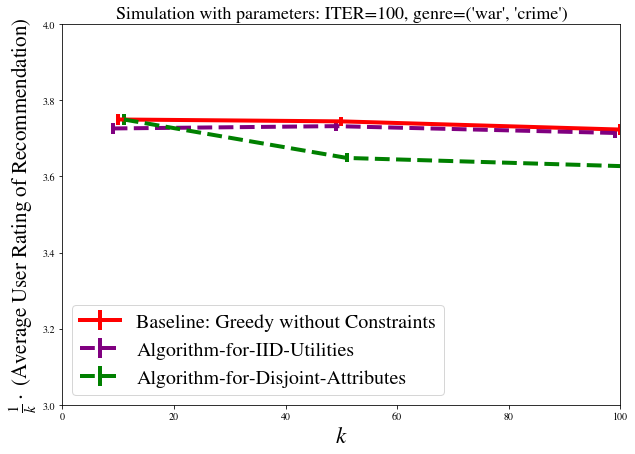

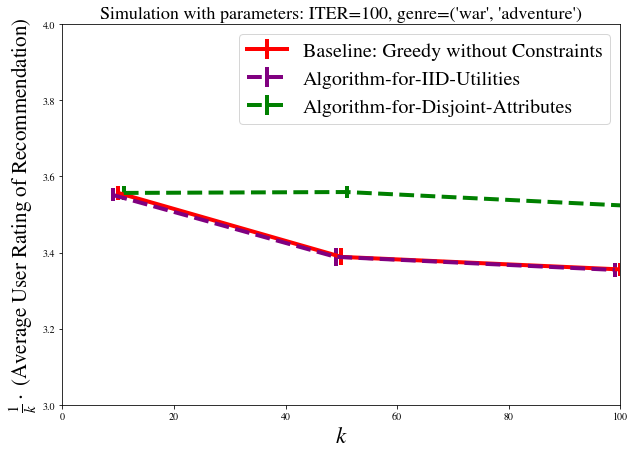

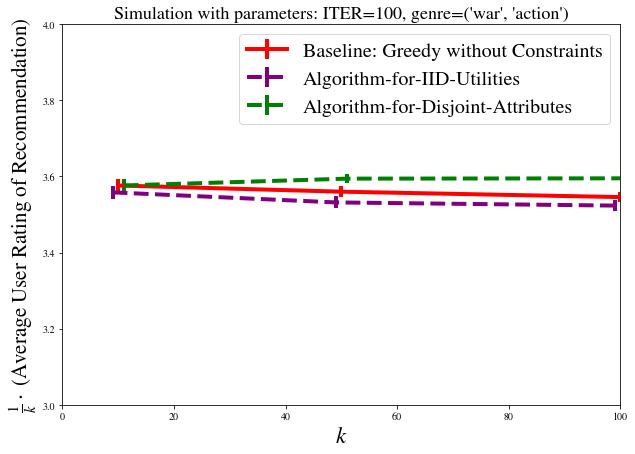

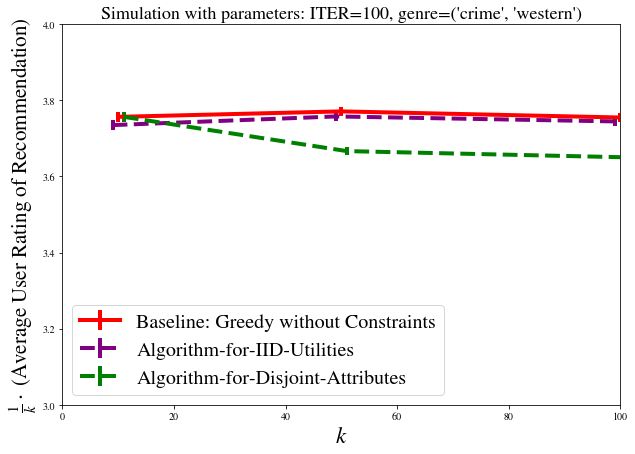

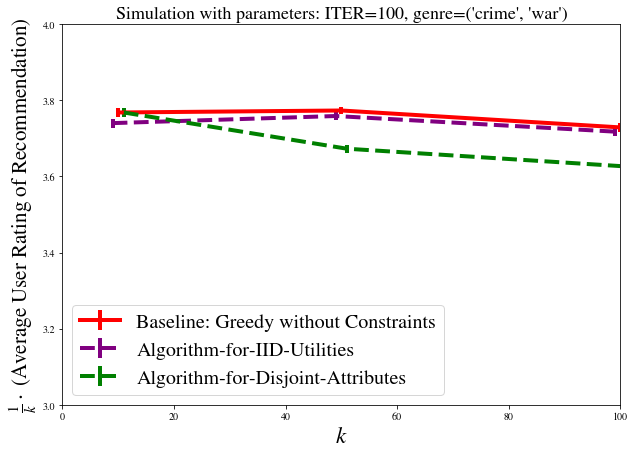

In [74]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

prev = -1000

fg=0
iterator = list(itertools.product([1, 2, 6, 18, 19], repeat=2))
iterator.reverse()
for gen in iterator:
    if gen[0]==gen[1]: continue 
    
    weight_F = np.zeros(20)
    for g in gen: 
        weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []
    
    x = []
    
    print(f'Genre: {[genres[g] for g in gen]}')

    for k in [10, 50, 100]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
            u_id = selected_users[user_draws[ijk]]

            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            assert(n>=k)

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)
            
            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 

            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            
            if ijk > prev + 10:
                prev = ijk
                print('#'*15 + f' iteration {ijk} ' + '#'*15)
                print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
                print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
                print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
                print('#'*50)
            
        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(ITERS))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(ITERS))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(ITERS))
        
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)



    plt.title(f'Simulation with parameters: ITER={ITERS}, genre={genres[gen[0]], genres[gen[1]]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)

    # plt.show()
    pdf_savefig()

In [77]:
##########################################
#### Functions for plotting Functions  ###
##########################################
exec(open('../utils.py').read())
##########################################
####### Fetch: Helper Functions  #########
##########################################
exec(open('../neurips-2022-utils.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('../neurips-2022-algorithms.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('simulation-utils.py').read())
import itertools

  0%|          | 0/10 [00:00<?, ?it/s]

Genre: ['action', 'adventure']
############### iteration 3 ###############
util_baseline_greedy_uncons: 3.9291786683725234, 0.0
util_algo_2_greedy_cons: 3.9058007265129775, 0.0
util_algo_3_disjoint_attr: 3.9291786683725234, 0.0
##################################################
############### iteration 26 ###############
util_baseline_greedy_uncons: 3.648391196990678, 0.06492795104066694
util_algo_2_greedy_cons: 3.6174688861130475, 0.07312538629601238
util_algo_3_disjoint_attr: 3.650848305814904, 0.06822924853950982
##################################################
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 48 ###############
util_baseline_greedy_uncons: 3.596417811521088, 0.048775155637974466
util_algo_2_greedy_cons: 3.5697131475502872, 0.052220056585354335
util_algo_3_disjoint_attr: 3.5939930563132205, 0.04873550063003058
##################################################
############### iteration 70 ###############
util_baseline_greedy_uncons: 3.60127424

 10%|█         | 1/10 [57:37<8:38:37, 3457.53s/it]

y1 = [3.6562578949813473, 3.580750687663383, 3.5074148296816325, 3.483003913118249, 3.476521975596288]
y4 = [3.6303708084195563, 3.5557905989940837, 3.4858058282218765, 3.4678353326231535, 3.4690977598819455]
y5 = [3.6490241536664376, 3.6331019434054705, 3.5764411914870617, 3.5395632985986807, 3.538359502372923]
y1_err = [0.01676574743430451, 0.015262031437666117, 0.015580905597356396, 0.014701368627232, 0.017988449540541553]
y4_err = [0.01763047762601582, 0.01635897538299636, 0.0157169110256496, 0.015107648094297987, 0.018101567811907842]
y5_err = [0.01752639969285851, 0.01245122696598652, 0.013693660816398672, 0.013187586942388233, 0.015617570623479723]
./figs/H04M57S32_05-16-22fdecm.pdf
Genre: ['action', 'crime']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  F

 20%|██        | 2/10 [1:52:13<7:26:46, 3350.87s/it]

y1 = [3.7201954369658323, 3.63045560645071, 3.572542927069728, 3.5710003800814984, 3.5646598167125796]
y4 = [3.676830087713693, 3.604964653461232, 3.556882010302011, 3.561428911799116, 3.5559114678221158]
y5 = [3.7510445421233043, 3.6391126272263348, 3.5813712844317394, 3.5803094275302523, 3.5733755010505894]
y1_err = [0.016729616959970092, 0.012697042633199526, 0.013910898002369295, 0.01606659829926619, 0.014465243605863579]
y4_err = [0.017772673127475665, 0.013415388617314228, 0.014366123353405943, 0.01581074842522602, 0.014344292960832205]
y5_err = [0.013555296405361784, 0.011659208517849625, 0.012862930352071719, 0.014617020453617046, 0.01327251356617456]
./figs/H05M52S09_05-16-22kmgfr.pdf
Genre: ['action', 'war']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G: 

 30%|███       | 3/10 [2:52:56<6:46:29, 3484.15s/it]

y1 = [3.602535281350933, 3.562035548984467, 3.5276360099482504, 3.520943657133442, 3.466751122661111]
y4 = [3.584223502514234, 3.535914362056417, 3.5064821145744283, 3.507499556793724, 3.4549850376155957]
y5 = [3.602535281350933, 3.5996390109549186, 3.574487972099774, 3.563550752073939, 3.514668750845228]
y1_err = [0.017516268756533983, 0.014638252412998428, 0.013389476993024521, 0.01708738409705146, 0.016183543761130882]
y4_err = [0.018983909950449566, 0.015282376353440805, 0.014056504404891344, 0.017413286961612654, 0.016319512477559188]
y5_err = [0.01751626875653398, 0.012520637345926216, 0.012044639375219338, 0.01551008315738601, 0.01445367016135555]
./figs/H06M52S51_05-16-22ldrql.pdf
Genre: ['action', 'western']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  

 40%|████      | 4/10 [3:53:49<5:55:06, 3551.00s/it]

y1 = [3.591877098235591, 3.545030000989795, 3.508973992930099, 3.5030763762559842, 3.5012666636127556]
y4 = [3.556239557592454, 3.515605515354979, 3.4854841504841874, 3.486434602641032, 3.489834597241968]
y5 = [3.591877098235591, 3.5763253133038164, 3.5584613461161596, 3.5467228409541183, 3.551286208491325]
y1_err = [0.018125651669078684, 0.01512389952656377, 0.014990541409874237, 0.016326995068547626, 0.016334135595666432]
y4_err = [0.019682012025404386, 0.015427012571406537, 0.015381317813507548, 0.016233143173759464, 0.016434696726604144]
y5_err = [0.018125651669078688, 0.013372246048717626, 0.013111111436841502, 0.015023028054103615, 0.014453014863727184]
./figs/H07M53S45_05-16-22skoth.pdf
Genre: ['adventure', 'crime']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAM

 50%|█████     | 5/10 [4:49:05<4:48:50, 3466.06s/it]

y1 = [3.7147530680029472, 3.6125719739784494, 3.588758288146514, 3.57707333929201, 3.538956645700791]
y4 = [3.691913897574396, 3.6110785708995543, 3.5792625135981466, 3.5705754958085656, 3.5331177096481143]
y5 = [3.681903647223617, 3.6266528914543583, 3.5839907827356283, 3.5734547893589514, 3.5476143033065615]
y1_err = [0.011820351787471924, 0.014745801226123127, 0.01655552144967845, 0.017045545628005806, 0.017977283548474023]
y4_err = [0.01193895770938339, 0.014424915118271611, 0.017013352232551193, 0.0172366294488357, 0.01802957267999872]
y5_err = [0.013926163482998497, 0.01106605789102552, 0.014014706959777194, 0.014918044973793513, 0.01648153849178842]
./figs/H08M49S00_05-16-22qrdhg.pdf
Genre: ['adventure', 'war']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G: 

 60%|██████    | 6/10 [5:48:53<3:53:50, 3507.68s/it]

y1 = [3.5118749100006657, 3.384023703976191, 3.358804525257475, 3.362952064510394, 3.395732413869353]
y4 = [3.491299187088806, 3.3831469766593436, 3.3562444859038885, 3.3615073321286015, 3.3941242973411216]
y5 = [3.511874910000665, 3.552676932583322, 3.512290805562324, 3.4991583144465155, 3.5110966372757555]
y1_err = [0.01968359475800251, 0.021559598713026245, 0.020416502729165825, 0.02168225886311315, 0.01923053950143935]
y4_err = [0.021533610500110434, 0.02136816218580974, 0.02034279563800013, 0.021628665977899825, 0.019263025273599358]
y5_err = [0.019683594758002514, 0.015254112793840485, 0.017000106935224808, 0.01572747136961246, 0.014286567998131123]
./figs/H09M48S49_05-16-22bkqmv.pdf
Genre: ['adventure', 'western']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_

 70%|███████   | 7/10 [6:43:17<2:51:23, 3427.79s/it]

y1 = [3.5162886696784557, 3.334148414151999, 3.3785221977167823, 3.4044030822000657, 3.412686972443316]
y4 = [3.506333026859273, 3.3394502631209555, 3.3818928084312603, 3.4025845913157218, 3.410649445105695]
y5 = [3.5162886696784557, 3.5301139161039607, 3.5582607995213147, 3.532412004106499, 3.5056255132267973]
y1_err = [0.018886876606677414, 0.02106321816008574, 0.019752327866370472, 0.020450598836998318, 0.02019750392074989]
y4_err = [0.01919843048152283, 0.020787172797079458, 0.0195347394146729, 0.02039483787028776, 0.020236728976149244]
y5_err = [0.018886876606677414, 0.01483765671376099, 0.013443842825252367, 0.014817523458256803, 0.016698875237410836]
./figs/H10M43S12_05-16-22cmwsk.pdf
Genre: ['crime', 'war']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  Fa

 80%|████████  | 8/10 [7:38:58<1:53:20, 3400.26s/it]

y1 = [3.7932601391162435, 3.7648193490023334, 3.7264455022846765, 3.661450456989309, 3.657437027429463]
y4 = [3.762685025243487, 3.7524794581867082, 3.7161696529600188, 3.6537682108924368, 3.653177834409567]
y5 = [3.7932601391162435, 3.661633591364894, 3.633472968709057, 3.5962779521066737, 3.5871921132409508]
y1_err = [0.010346077005121189, 0.011316030324649892, 0.014284344860182981, 0.01730875269276256, 0.014669071394232147]
y4_err = [0.011681500994310959, 0.01118566638719119, 0.014241541452187537, 0.017417506972150623, 0.014562256363577077]
y5_err = [0.010346077005121194, 0.010325896121791061, 0.013228469622038285, 0.014597810737089758, 0.012555672666122494]
./figs/H11M38S53_05-16-22hekpb.pdf
Genre: ['crime', 'western']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAM

 90%|█████████ | 9/10 [8:37:20<57:12, 3432.13s/it]  

y1 = [3.7595784046673306, 3.763198774891487, 3.739041638660577, 3.6952092831841323, 3.6693664923883453]
y4 = [3.7421855285182644, 3.7522062771589986, 3.7284824663401777, 3.6865804287089334, 3.6634055498275084]
y5 = [3.7595784046673306, 3.671282856775812, 3.6387140580049078, 3.631420050636127, 3.6038156045443537]
y1_err = [0.01081306763476393, 0.011673810218333344, 0.012056111480347872, 0.01370464429220323, 0.016271630708538765]
y4_err = [0.011181072095153295, 0.01155051362002299, 0.012093211668721312, 0.013519017433823383, 0.016281962441480943]
y5_err = [0.010813067634763935, 0.010868163982716249, 0.01181080436297426, 0.01235772756228692, 0.014505565901090553]
./figs/H12M37S16_05-16-22ksrfk.pdf
Genre: ['war', 'western']
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G

100%|██████████| 10/10 [9:29:10<00:00, 3415.03s/it]

y1 = [3.5118039048071092, 3.4714887762285063, 3.4613548523873323, 3.4995707163145413, 3.5039975911858092]
y4 = [3.495817386538806, 3.4639538150921574, 3.458172963809351, 3.497066676412602, 3.5009477238976725]
y5 = [3.5118039048071092, 3.5626586053138776, 3.5526456894274365, 3.5722881442206234, 3.5506332577325197]
y1_err = [0.02092886633587631, 0.02082047305446797, 0.019887508194057327, 0.01950789913491811, 0.016791079166560453]
y4_err = [0.021381874799711445, 0.020642458109190076, 0.01947727556166965, 0.019372580491270754, 0.016817169701537304]
y5_err = [0.020928866335876314, 0.013942450430680814, 0.0146543506530986, 0.01484274184405136, 0.014316680434258109]
./figs/H13M29S05_05-16-22kqqdf.pdf


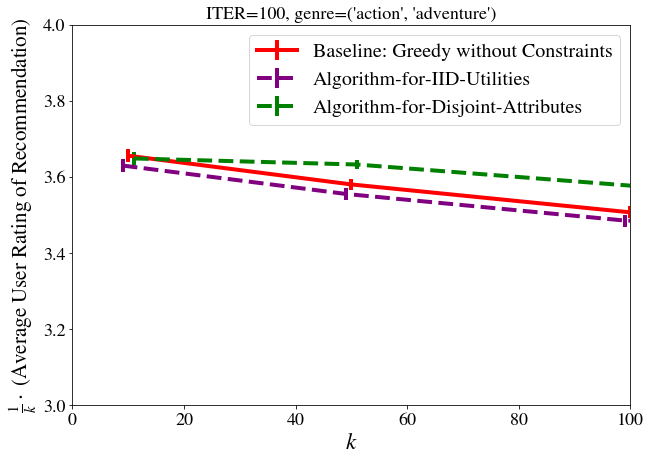

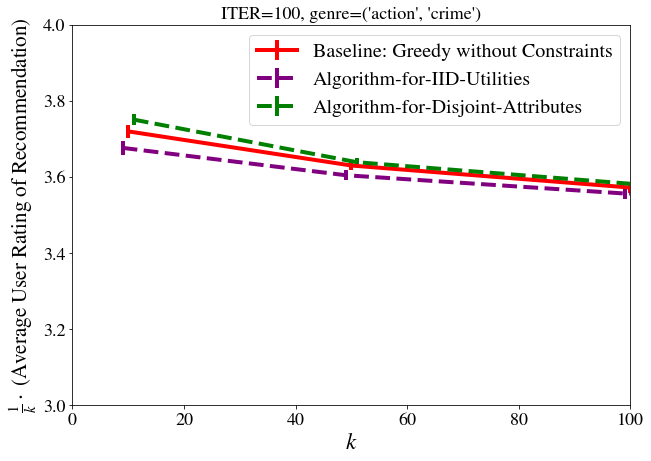

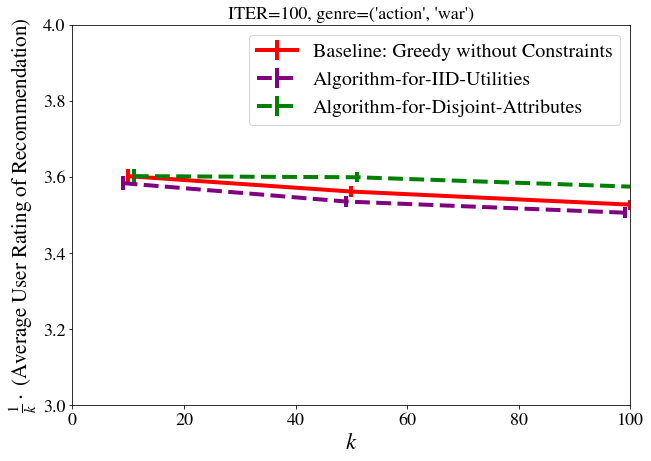

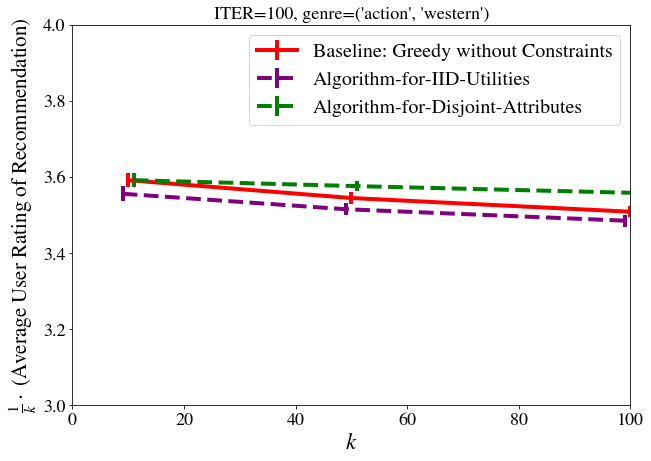

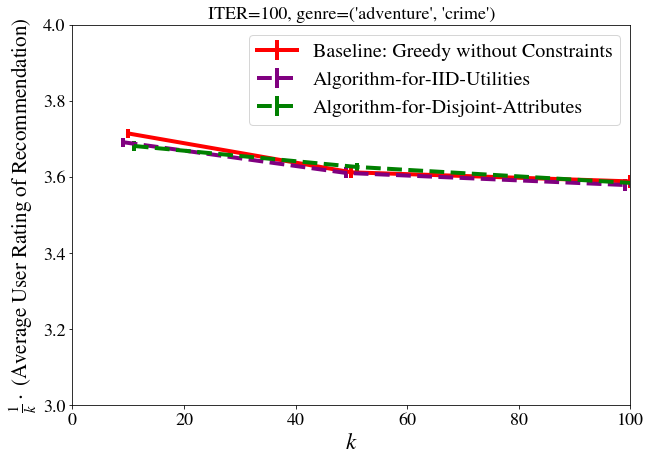

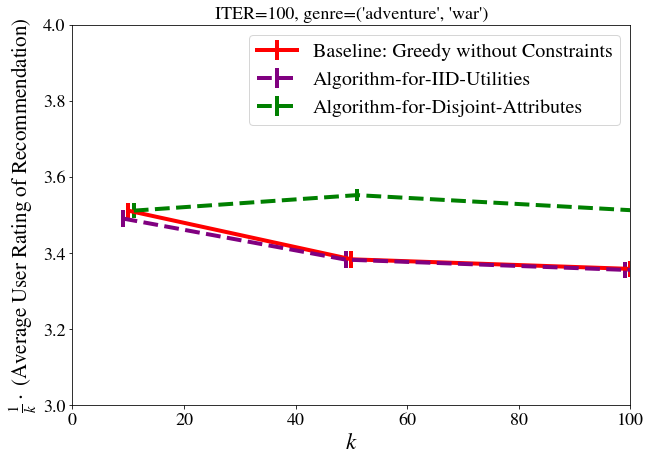

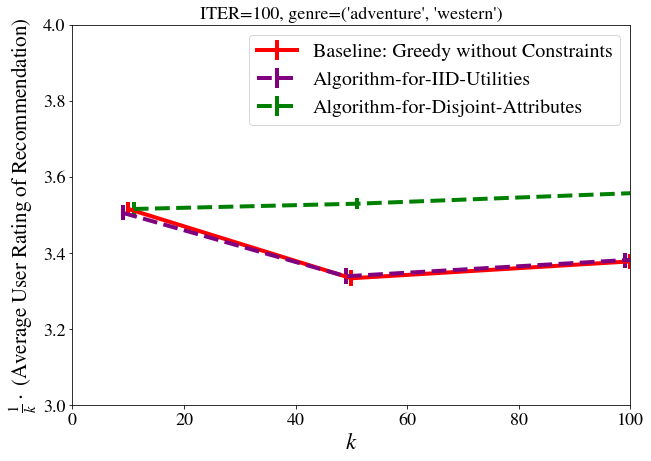

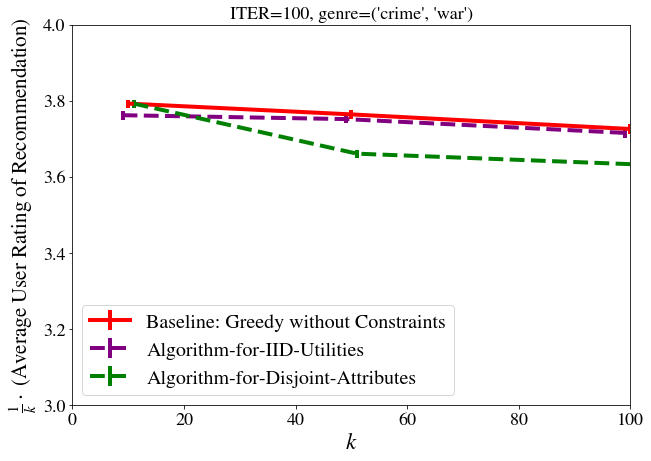

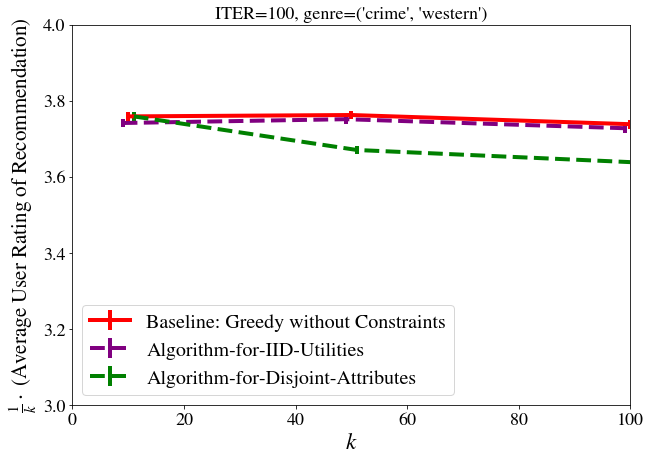

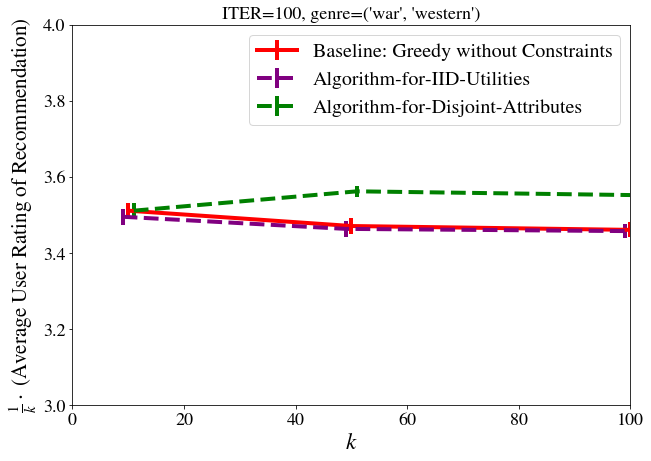

In [78]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

prev = -1000

fg=0
iterator = list(itertools.combinations([1, 2, 6, 18, 19], 2))
for gen in tqdm(iterator):
    weight_F = np.zeros(20)
    for g in gen: 
        weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []
    
    x = []
    
    print(f'Genre: {[genres[g] for g in gen]}')

    for k in [10, 50, 100, 150, 200]: #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
            u_id = selected_users[user_draws[ijk]]

            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            
            if n < k:
                continue 

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)
            
            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 

            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            
            if ijk > prev + 20:
                prev = ijk
                print('#'*15 + f' iteration {ijk} ' + '#'*15)
                print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
                print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
                print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
                print('#'*50)
            
        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(ITERS))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(ITERS))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(ITERS))
        
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)

    
    print(f'y1 = {y1}')
    print(f'y4 = {y4}')
    print(f'y5 = {y5}')
    print(f'y1_err = {y1_err}')
    print(f'y4_err = {y4_err}')
    print(f'y5_err = {y5_err}')


    plt.title(f'ITER={ITERS}, genre={genres[gen[0]], genres[gen[1]]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    # plt.show()
    pdf_savefig()

In [80]:
#   horror 11
# romance 15
##########################################
#### Functions for plotting Functions  ###
##########################################
exec(open('../utils.py').read())
##########################################
####### Fetch: Helper Functions  #########
##########################################
exec(open('../neurips-2022-utils.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('../neurips-2022-algorithms.py').read())
##########################################
### Fetch: Algorithms and Baselines ######
##########################################
exec(open('simulation-utils.py').read())
import itertools

Genre: ['horror', 'romance']


  0%|          | 0/5 [00:00<?, ?it/s]

############### iteration 6 ###############
util_baseline_greedy_uncons: 3.563181964874649, 0.0
util_algo_2_greedy_cons: 3.551494720842804, 0.0
util_algo_3_disjoint_attr: 3.670611350980713, 0.0
##################################################
############### iteration 30 ###############
util_baseline_greedy_uncons: 3.9331146768650114, 0.05761072630642165
util_algo_2_greedy_cons: 3.9092379372150674, 0.054773690453017485
util_algo_3_disjoint_attr: 3.972292032724432, 0.04537699213872761
##################################################
############### iteration 53 ###############
util_baseline_greedy_uncons: 3.902572660657964, 0.04031453614051319
util_algo_2_greedy_cons: 3.8786033647529092, 0.038681951733228595
util_algo_3_disjoint_attr: 3.961822834462227, 0.03346679600262092
##################################################
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 76 ###############
util_baseline_greedy_uncons: 3.9323687033891153, 0.028727528120165515
uti

 20%|██        | 1/5 [01:07<04:30, 67.69s/it]

############### iteration 273 ###############
util_baseline_greedy_uncons: 3.9567990251689933, 0.01355772806340226
util_algo_2_greedy_cons: 3.9414822089717068, 0.013359016071215857
util_algo_3_disjoint_attr: 3.9984554879877505, 0.011696129352159152
##################################################
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 306 ###############
util_baseline_greedy_uncons: 3.824283867956379, 0.012104969701163235
util_algo_2_g

 40%|████      | 2/5 [06:54<11:35, 231.84s/it]

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951


 60%|██████    | 3/5 [17:46<14:07, 423.86s/it]

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.41421

 80%|████████  | 4/5 [33:51<10:37, 637.19s/it]

SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:325: RuntimeWarning: divide by zero encountered in double_scalars


SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 327 ###############
util_baseline_greedy_uncons: 3.6660033442883226, 0.01549108044905755
util_algo_2_greedy_cons: 3.662405041886024, 0.015397228510756115
util_algo_3_disjoint_attr: 3.61141560096528, 0.01416729373823767
##################################################
SAME_G:  False
func(2):  1.4142135623730951
SAME_G:  False
func(2):  1.4142135623730951
############### iteration 349 ##############

100%|██████████| 5/5 [54:52<00:00, 658.57s/it]


y1 = [3.9567990251689933, 3.8259723825812135, 3.7190885194101515, 3.6865279720037383, 3.6665931953221333]
y4 = [3.9414822089717068, 3.814010967980057, 3.7125126167559954, 3.6817147645031163, 3.663168669774704]
y5 = [3.9984554879877505, 3.716252762539481, 3.629184064181528, 3.623855949229559, 3.6122939468861106]
y1_err = [0.01355772806340226, 0.011798190700627964, 0.015008303888206264, 0.015102013897074407, 0.014940132160833421]
y4_err = [0.013359016071215857, 0.012165192089349037, 0.015104383940738684, 0.015177320493373262, 0.014855113135110712]
y5_err = [0.011696129352159152, 0.010986926771937588, 0.013661326211664285, 0.014732501348189517, 0.013593961440053124]
./figs/H21M38S59_05-16-22dmdsu.pdf


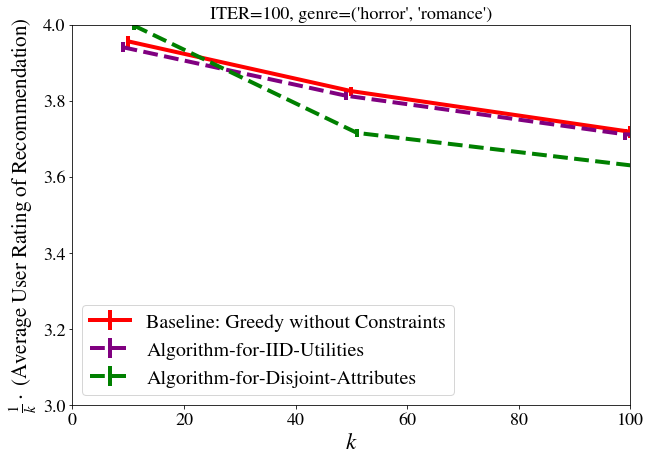

In [81]:
func = lambda x: np.sqrt(x)
func2 = lambda x: np.sqrt(x)

ITERS = 100

prev = -1000

fg=0
for gen in [[11, 15]]:
    weight_F = np.zeros(20)
    for g in gen: 
        weight_F[g] = 1

    LIST_baseline_greedy_uncons_OUTER = []
    LIST_algo_2_greedy_cons_OUTER = []
    LIST_algo_3_disjoint_attr_OUTER = []

    ERR_LIST_baseline_greedy_uncons_OUTER = []
    ERR_LIST_algo_2_greedy_cons_OUTER = []
    ERR_LIST_algo_3_disjoint_attr_OUTER = []
    
    x = []
    
    print(f'Genre: {[genres[g] for g in gen]}')

    for k in tqdm([10, 50, 100, 150, 200]): #[10, 25, 50, 75, 100]:
        list_baseline_greedy_uncons = []
        list_algo_2_greedy_cons = []
        list_algo_3_disjoint_attr = []
        
        user_draws = rng.choice(len(selected_users), 10*ITERS)

        ijk = -1
        while len(list_algo_3_disjoint_attr) < ITERS and ijk < 10*ITERS:
            ijk += 1
            u_id = selected_users[user_draws[ijk]]

            m_inds = get_rated_movie_indices(u_id)

            m_ind_to_i = {}
            for i, ind in enumerate(m_inds): m_ind_to_i[ind] = i

            n = len(m_inds)
            m = len(genres_matching_tags)
            
            if n < k:
                continue 

            obs_util = np.zeros((n, m))

            for i in range(n):
                for j in range(m):
                    m_ind = m_inds[i]
                    g = rev_tags[genres_matching_tags[j]] # name of j-th genre 

                    obs_util[i][j] = movie_tag_rel_scores[m_ind][g]

            # grps
            grps_int = [[], []]
            for i in range(n):
                m_ind = m_inds[i]

                if m_ind in grps_set[0]:
                    grps_int[0].append(i)
                elif m_ind in grps_set[1]:
                    grps_int[1].append(i)
                else:
                    assert(False)
            
            if len(grps_int[0]) == 0 or len(grps_int[1]) == 0:
                continue 
            if len(grps_int[1]) <= 0.2 * len(grps_int[0]) or len(grps_int[0]) <= 0.2 * len(grps_int[1]):
                continue 

            # run algorithms and baselines
            sol_baseline_greedy_uncons = baseline_greedy_uncons(obs_util, grps_int, k, m)
            sol_algo_2_greedy_cons = algo_4_greedy_cons(obs_util, grps_int, k, m)
            sol_algo_3_disjoint_attr = algo_3_disjoint_attr(obs_util, grps_int, k, m) 

            util_baseline_greedy_uncons = get_score_rating_overall_users(sol_baseline_greedy_uncons, m_inds, m_ind_to_i) / k
            util_algo_2_greedy_cons = get_score_rating_overall_users(sol_algo_2_greedy_cons, m_inds, m_ind_to_i) / k
            util_algo_3_disjoint_attr = get_score_rating_overall_users(sol_algo_3_disjoint_attr, m_inds, m_ind_to_i) / k

            list_baseline_greedy_uncons.append(util_baseline_greedy_uncons) # / util_ideal_no_bias)
            list_algo_2_greedy_cons.append(util_algo_2_greedy_cons) # / util_ideal_no_bias)
            list_algo_3_disjoint_attr.append(util_algo_3_disjoint_attr) # / util_ideal_no_bias)

            
            if ijk > prev + 20:
                prev = ijk
                print('#'*15 + f' iteration {ijk} ' + '#'*15)
                print(f"util_baseline_greedy_uncons: {np.mean(list_baseline_greedy_uncons)}, {np.std(list_baseline_greedy_uncons) / np.sqrt(len(list_baseline_greedy_uncons))}")
                print(f"util_algo_2_greedy_cons: {np.mean(list_algo_2_greedy_cons)}, {np.std(list_algo_2_greedy_cons) / np.sqrt(len(list_algo_2_greedy_cons))}")
                print(f"util_algo_3_disjoint_attr: {np.mean(list_algo_3_disjoint_attr)}, {np.std(list_algo_3_disjoint_attr) / np.sqrt(len(list_algo_3_disjoint_attr))}")
                print('#'*50)
            
        x.append(k)

        LIST_baseline_greedy_uncons_OUTER.append(np.mean(list_baseline_greedy_uncons))
        LIST_algo_2_greedy_cons_OUTER.append(np.mean(list_algo_2_greedy_cons))
        LIST_algo_3_disjoint_attr_OUTER.append(np.mean(list_algo_3_disjoint_attr))

        ERR_LIST_baseline_greedy_uncons_OUTER.append(np.std(list_baseline_greedy_uncons) / np.sqrt(ITERS))
        ERR_LIST_algo_2_greedy_cons_OUTER.append(np.std(list_algo_2_greedy_cons) / np.sqrt(ITERS))
        ERR_LIST_algo_3_disjoint_attr_OUTER.append(np.std(list_algo_3_disjoint_attr) / np.sqrt(ITERS))
        
    x = np.array(x)
    y1 = LIST_baseline_greedy_uncons_OUTER
    y4 = LIST_algo_2_greedy_cons_OUTER
    y5 = LIST_algo_3_disjoint_attr_OUTER

    y1_err = ERR_LIST_baseline_greedy_uncons_OUTER
    y4_err = ERR_LIST_algo_2_greedy_cons_OUTER
    y5_err = ERR_LIST_algo_3_disjoint_attr_OUTER

    fig, ax = plt.subplots()
    plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
    plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
    plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)

    
    print(f'y1 = {y1}')
    print(f'y4 = {y4}')
    print(f'y5 = {y5}')
    print(f'y1_err = {y1_err}')
    print(f'y4_err = {y4_err}')
    print(f'y5_err = {y5_err}')


    plt.title(f'ITER={ITERS}, genre={genres[gen[0]], genres[gen[1]]}', fontsize=18)
    plt.ylim(3, 4)
    plt.xlim(0, 100)
    ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
    ax.set_xlabel('$k$', fontsize=23)
    legend = plt.legend(loc='best', shadow=False, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    # plt.show()
    pdf_savefig()

./figs/H01M56S33_05-17-22gjjgk.pdf


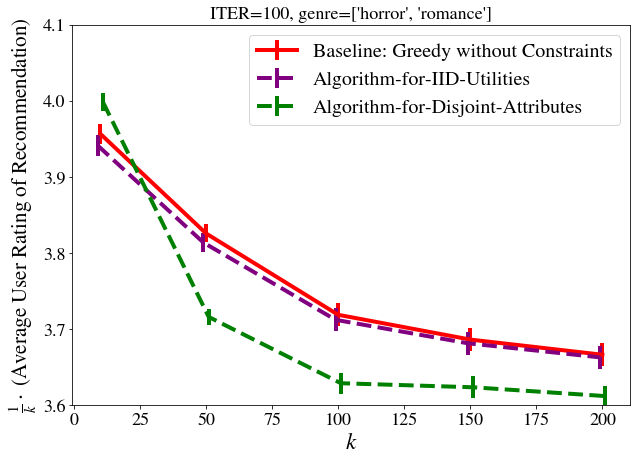

In [85]:
x = [10, 50, 100, 150, 200]

gen = ['action', 'adventure', 'crime', 'war', 'western']
y1 = [3.9567990251689933, 3.8259723825812135, 3.7190885194101515, 3.6865279720037383, 3.6665931953221333]
y4 = [3.9414822089717068, 3.814010967980057, 3.7125126167559954, 3.6817147645031163, 3.663168669774704]
y5 = [3.9984554879877505, 3.716252762539481, 3.629184064181528, 3.623855949229559, 3.6122939468861106]
y1_err = [0.01355772806340226, 0.011798190700627964, 0.015008303888206264, 0.015102013897074407, 0.014940132160833421]
y4_err = [0.013359016071215857, 0.012165192089349037, 0.015104383940738684, 0.015177320493373262, 0.014855113135110712]
y5_err = [0.011696129352159152, 0.010986926771937588, 0.013661326211664285, 0.014732501348189517, 0.013593961440053124]


y1 = [yy for _, yy in sorted(zip(x, y1))]
y4 = [yy for _, yy in sorted(zip(x, y4))]
y5 = [yy for _, yy in sorted(zip(x, y5))]
y1_err = [yy for _, yy in sorted(zip(x, y1_err))]
y4_err = [yy for _, yy in sorted(zip(x, y4_err))]
y5_err = [yy for _, yy in sorted(zip(x, y5_err))]
x = np.array(sorted(x))

fig, ax = plt.subplots()
plt.errorbar(x, y1, yerr=y1_err, color="red", label='Baseline: Greedy without Constraints',  linewidth=4, alpha=1.0)
plt.errorbar(x-1, y4, yerr=y4_err, linestyle='--', color="purple", label='Algorithm-for-IID-Utilities',  linewidth=4, alpha=1.0)
plt.errorbar(x+1, y5, yerr=y5_err, linestyle='--', color="green", label='Algorithm-for-Disjoint-Attributes',  linewidth=4, alpha=1.0)

plt.title(f'ITER={ITERS}, genre={[genres[g] for g in [11, 15]]}', fontsize=18)
plt.ylim(3.6, 4.1)
# plt.xlim(0, 100)
ax.set_ylabel('$\\frac{1}{k}\\cdot$ (Average User Rating of Recommendation)',fontsize=21)
ax.set_xlabel('$k$', fontsize=23)
legend = plt.legend(loc='best', shadow=False, fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

# plt.show()
pdf_savefig()